# 1. Preparation
a. Install or import relevant libraries <br>
b. Runtime -> change runtime type -> choose any GPU type available for you <br>
c. Set variable `RUN_LOCALLY`: <br>
    - set it to True: you will run this notebook locally. <br>
    - set it to False: you will run this notebook on Colab. <br>

d. If you are running the notebook in Colab, you need to: <br>
    - specify the project path by setting the value of `project_path` in the following cell.<br>

In [1]:

!pip install transformers
!pip install datasets
!pip install rouge_score
!pip install huggingface-hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=cc350505d01da416b7c94096f818e6aa7febfbd1e8e3406e833f0e4b1c90cc9a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
!nvidia-smi

Tue Apr 30 03:27:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   30C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Set variable `RUN_LOCALLY`: ###
    - set it to True: you will run this notebook locally. <br>
    - set it to False: you will run this notebook on Colab. <br>


### When RUN_LOCALLY is True and run on local machine ###
Requirement: <br>
1. There are two files training.csv and eval.csv existing in folder `<project_folder>/data/dataset`.
2. There are processed PDF file in folder `<project_folder>/processed/`, such as `1901.00936v3.csv`.

### When RUN_LOCALLY is False and run in Colab ###
Requirement: <br>
2. Specify the project path by setting the value of `project_path` in the below cell. <br>
1. training.csv, val.csv, and a pre-processed PDF file (e.g.`1901.00936v3.csv`) are put in the folder `data`. The folder `data` is located in the same Google Drive path as this notebook.

In [3]:
RUN_LOCALLY = False

import os, json, logging
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import re
from torch.optim import lr_scheduler

transformers_logger = logging.getLogger("transformers")
logging.getLogger("transformers").setLevel(logging.ERROR)
from transformers import LEDForConditionalGeneration, LEDTokenizer
from datasets import Dataset, load_dataset, load_metric, load_from_disk, DatasetDict
from rouge_score import rouge_scorer
pd.options.display.max_colwidth = 1000
torch.device('cpu')

######### set RUN_LOCALLY to True/False. Set project_path if the notebook is running in Colab ########
if RUN_LOCALLY:
    project_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    # recently, the repo structure changes, and we need to follow this structure
    project_dataset_path = project_path + "/data/dataset"
    project_processed_data_path = project_path + "/processed"
    if not os.path.exists(project_dataset_path):
        raise Exception("The `dataset` folder does not exist.")
    if not os.path.exists(project_processed_data_path):
        raise Exception("The `processed` folder does not exist.")

else:
    # If you want to run on Colab and use GPU, only two extra data files are needed. You do not need to follow the above local data structure. Just ensure folder "data" exists in the same Google Drive folder as this notebook
    from google.colab import drive
    drive.mount("/content/drive")
    project_path = "/content/drive/MyDrive/Colab Notebooks/Course-NUS-cs5242-Neural Network and Deep Learning/final_project"

    project_dataset_path = project_path + "/data"
    project_processed_data_path = project_path + "/data"
    if not os.path.exists(project_dataset_path):
        raise Exception("The `data` folder does not exist.")



Mounted at /content/drive


# 2. Define functions
This class `Model_operation` wraps all the functions related to the model's operation. At the end of the cell, we create an object of this class. This object will be used in the following trainning and testing steps.

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Define the Model's operation in one class
class Model_operation:
    def __init__(self, model_name):
        self.model_name = model_name
        self.tokenizer = LEDTokenizer.from_pretrained(model_name, torch_dtype = torch.float16)
        self.model = LEDForConditionalGeneration.from_pretrained(model_name).to(DEVICE)
        self.config = LEDForConditionalGeneration.from_pretrained(model_name).config
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5, weight_decay=0.01)
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3, verbose=True)

        self.rouge = load_metric("rouge")
        self.batchsize = 4
        self.max_input_length = 1024
        self.max_output_length = 128

    # tokenize the data
    def process_data_to_model_inputs(self, batch):
        inputs = self.tokenizer(
            batch['Text'],
            padding="max_length",
            truncation=True,
            max_length=self.max_input_length,
        )

        batch["input_ids"] = inputs.input_ids
        batch["attention_mask"] = inputs.attention_mask

        # put global attention on <s> token
        # according to https://github.com/huggingface/transformers/issues/18190, As you are running summarization, it is LEDForConditionalGeneration. For this model, we should put 1 for the global_attention_mask on the first token <s> in the encoder input sequence.
        batch["global_attention_mask"] = len(batch["input_ids"]) * [
            [1 if index == 0 else 0 for index in range(len(batch["input_ids"][0]))]
        ]

        outputs = self.tokenizer(
            batch['Groundtruth'],
            padding="max_length",
            truncation=True,
            max_length=self.max_output_length,
        )
        batch["labels"] = outputs.input_ids
        # We have to make sure that the PAD token is ignored by setting it to -100
        batch["labels"] = [
            [-100 if token == self.tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]
        return batch

    # Function to calculate ROUGE scores for generated summary and ground truth
    def calculate_rouge_scores(self, generated_summary, ground_truth_summary):
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

        rouge1_f1, rouge2_f1, rougeL_f1 = [], [], []
        for k in range(len(generated_summary)):
            scores = scorer.score(generated_summary[k], ground_truth_summary[k])
            rouge1_f1.append(scores['rouge1'].fmeasure)
            rouge2_f1.append(scores['rouge2'].fmeasure)
            rougeL_f1.append(scores['rougeL'].fmeasure)
        return np.mean(rouge1_f1), np.mean(rouge2_f1), np.mean(rougeL_f1)

    # convert the logits to real text
    def convert_logits_to_text(self, pred_logits):
        texts = []
        probs = torch.softmax(pred_logits, dim=-1)
        generated_ids = torch.argmax(probs, dim=-1)

        for i in range(len(generated_ids)):
            pred_str = self.tokenizer.decode(generated_ids[i], skip_special_tokens=True)
            texts.append(pred_str)
        # pred_str = self.tokenizer.decode(generated_ids, skip_special_tokens=True)
        # labels_ids[labels_ids == -100] = self.tokenizer.pad_token_id
        # label_str = self.tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
        return texts

    # convert tokens to real text. The difference from convert_logits_to_text is that this function does not need to use softmax
    def convert_tokens_to_text(self, tokenized_sequences):
        texts = []
        for i in range(len(tokenized_sequences)):
          tokens_list = tokenized_sequences[i].tolist()
          if -100 in tokens_list:
              end_index = tokens_list.index(-100)
          else:
              end_index = len(tokens_list)
          pred_str = self.tokenizer.decode(tokenized_sequences[i][:end_index], skip_special_tokens=True)
          texts.append(pred_str)
        return texts

    def log_metrics(self,epoch, train_loss, val_loss, train_rouge_scores, val_rouge_scores):
        log_file = project_path + "/metrics_log.txt"
        with open(log_file, "a") as f:
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            log_str = f"{timestamp}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ROUGE: {train_rouge_scores}, Val ROUGE: {val_rouge_scores}\n"
            f.write(log_str)

    def log_generated_summary(self,epoch, expected_summary, generated_summary, other_info=""):
        log_file = project_path + "/generated_summary_log.txt"
        with open(log_file, "a") as f:
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            log_str = f"{timestamp}, Epoch {epoch + 1}, \nExpected: {expected_summary}, \nGenerated: {generated_summary}, \nOther Info: {other_info}\n"
            f.write(log_str)

    # tokenize the test data
    def process_test_data_to_model_inputs(self, batch):
        inputs = self.tokenizer(
            list(batch['text']),
            padding="max_length",    #  'do_not_pad'
            truncation=True,
            max_length=self.max_input_length,
        )

        batch["input_ids"] = inputs.input_ids
        batch["attention_mask"] = inputs.attention_mask

        # create 0 global_attention_mask lists
        batch["global_attention_mask"] = len(batch["input_ids"]) * [
            [1 if index ==0 else 0 for index in range(len(batch["input_ids"][0]))]
        ]
        return batch

    # test the model by passing it a pdf file dataframe. Return a dataframe with generated summary
    def generate_summary_for_user_pdf(self, pdf_df):
        data_df = pdf_df.copy()
        self.process_test_data_to_model_inputs(data_df)

        input_ids = torch.tensor(data_df["input_ids"]).to(DEVICE)
        test_am = torch.tensor(data_df["attention_mask"]).to(DEVICE)
        test_gam = torch.tensor(data_df["global_attention_mask"]).to(DEVICE)

        # when not passing labels, the outputs's loss will be None
        predicted_ids = self.model.generate(input_ids=input_ids,
                attention_mask = test_am, global_attention_mask = test_gam)

        generated = self.convert_tokens_to_text(predicted_ids)

        for idx, text in enumerate(generated):
            generated[idx] = re.sub(r"\\n", "", text).strip()

        pdf_df['generated'] = generated
        return pdf_df

    def show_model_state_dict(self):
        for key, value in self.model.state_dict().items():
            print(key, " - ", value.size())
        # for name, param in model_action.model.named_parameters():
        #     print(name, " - ", param.shape)

    def save_model_checkpoint(self, checkpoint_model_name):
        if not os.path.exists(project_path + "/Checkpoints"):
            os.mkdir(project_path + "/Checkpoints")
        checkpoint_path = project_path + "/Checkpoints/" +checkpoint_model_name
        torch.save(self.model.state_dict(), checkpoint_path)


model_action = Model_operation(model_name = "allenai/led-large-16384-arxiv")
# optional: set hyperparameters. Some parameters inherit from https://huggingface.co/docs/transformers/v4.40.1/en/main_classes/configuration#transformers.PretrainedConfig
model_action.config.num_beams = 2
model_action.config.max_length = model_action.max_output_length
model_action.config.min_length = 100
model_action.config.length_penalty = 2.0
model_action.config.early_stopping = True
model_action.config.no_repeat_ngram_size = 3
print("Pre-trained Model Config:\n", model_action.model.config)
print("Pre-trained Model state-dict:\n")
model_action.show_model_state_dict()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
<ipython-input-4-27fbd476b5e1>:13: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.rouge = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the nex

Pre-trained Model Config:
 LEDConfig {
  "_name_or_path": "allenai/led-large-16384-arxiv",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
   

# 3. Prepare for DataSet and DataLoader
All the training data has been put into CSV file. We load CSV file and convert it to Huggingface Dataset. We then use Dataset's map method to tokenize the data. We format the Dataset and then load the data into PyTorch DataLoader to achieve the best performance.

The variable `CREATE_NEW_TOKENIZED_DATASET` decides if we use the existing tokenized dataset or re-create new ones. Using existing tokenized dataset saves time if the training data and verification data do not change from the previous training.

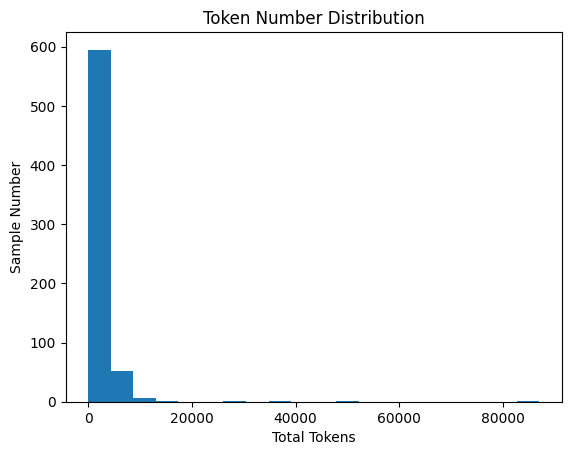

train_dataset records: (660, 3)
val_dataset records: (139, 3)


Map:   0%|          | 0/660 [00:00<?, ? examples/s]

Map:   0%|          | 0/139 [00:00<?, ? examples/s]

In [5]:
# CREATE_NEW_TOKENIZED_DATASET = True

train_df = pd.read_csv(project_dataset_path + "/dataset3.csv")
val_df = pd.read_csv(project_dataset_path + "/eval3.csv")
train_df.dropna(subset=['Text', 'Groundtruth'], inplace=True, axis=0)
val_df.dropna(subset=['Text', 'Groundtruth'], inplace=True, axis=0)

text_len = train_df['Text'].str.len()
plt.hist(text_len, bins = 20)
plt.title("Token Number Distribution")
plt.xlabel("Total Tokens")
plt.ylabel("Sample Number")
plt.show()

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

print("train_dataset records:", train_dataset.shape)
print("val_dataset records:", val_dataset.shape)
# train_dataset = train_dataset.select(range(100))
# val_dataset = val_dataset.select(range(40))
# print("selected train_dataset records:", train_dataset.shape)
# print("selected val_dataset records:", val_dataset.shape)

# if CREATE_NEW_TOKENIZED_DATASET:
# tokenize the data te prepare for the training
train_dataset = train_dataset.map(
    model_action.process_data_to_model_inputs,
    batched=True,
    batch_size=model_action.batchsize)

val_dataset = val_dataset.map(
    model_action.process_data_to_model_inputs,
    batched=True,
    batch_size=model_action.batchsize)

train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)
    # # save to disk: https://huggingface.co/docs/datasets/v1.5.0/processing.html#:~:text=You%20can%20save%20your%20dataset,objects%2C%20you%20can%20use%20datasets.
    # train_dataset.save_to_disk(project_dataset_path + "/train_dataset/")
    # val_dataset.save_to_disk(project_dataset_path + "/val_dataset/")

# else:
#     # load from the existing formmated tokenized dataset
#     train_dataset = load_from_disk(project_dataset_path + "/train_dataset/")
#     val_dataset = load_from_disk(project_dataset_path + "/val_dataset")

train_data_loader = DataLoader(train_dataset, batch_size = model_action.batchsize, shuffle=True,drop_last=True)
val_data_loader = DataLoader(val_dataset, batch_size = model_action.batchsize, shuffle=True,drop_last=True)

# 3. Fine-tune the Model and Save Check-point

The fine tune only occurs in the last layer: lm_head and final_logits_bias. All of the other layers' parameters are frozen.

There is early-exit mechanism. When the val_loss continues going up, stop the training process. The latest checkpoint model is saved to sub folder `Checkpoints`. All the training and verification loss, and rouge metrics are saved to folder `Runing_result`too.

In [6]:
num_epochs =10
total_train_loss, total_val_loss, total_train_rouge, total_val_rouge = [], [], [], []
torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
best_val_loss = float('inf')
#Declare variable for storing the checkpoint
checkpoint_filename = "LED_model_checkpoint.pt"
patience = 3

for epochi in tqdm(range(num_epochs)):
    val_batch_data_iter = iter(val_data_loader)
    train_loss, train_rouge1, train_rouge2, train_rougeL = [], [], [], []
    val_loss, val_rouge1, val_rouge2, val_rougeL = [], [], [], []
    for idx, data in tqdm(enumerate(train_data_loader)):
        ids = data['input_ids'].to(DEVICE)
        am = data['attention_mask'].to(DEVICE)
        gam = data['global_attention_mask'].to(DEVICE)
        labels = data['labels'].to(DEVICE)

        # freeze all the layers except the last layer lm_head
        model_action.model.train()
        for parameter in model_action.model.parameters():
            parameter.requires_grad = False
        for parameter in model_action.model.lm_head.parameters():
            parameter.requires_grad = True
        model_action.model.final_logits_bias.requires_grad = True

        # output = model_action.model(input_ids = ids, attention_mask = am, labels = labels, global_attention_mask = gam, use_cache = False)
        output = model_action.model(input_ids = ids, attention_mask = am, global_attention_mask = gam, labels = labels, use_cache = False)

        torch.device('cpu')
        loss = output.loss
        logits = output.logits

        print("epoch {}, batch {}, training loss: {}".format(epochi, idx, loss.item()))
        p_text = model_action.convert_logits_to_text(output.logits)[1:]
        e_text = model_action.convert_tokens_to_text(labels)
        model_action.log_generated_summary(epochi, e_text, p_text, f"training batch:{idx}")

        rouge1, rouge2, rougeL = model_action.calculate_rouge_scores(p_text, e_text)
        train_rouge1.append(rouge1)
        train_rouge2.append(rouge2)
        train_rougeL.append(rougeL)

        # Backward and optimize
        model_action.optimizer.zero_grad()
        train_loss.append(loss.item())
        loss.backward()
        model_action.optimizer.step()

        # evaluate once every 20 mini-batches
        if idx > 0 and idx % 5 == 0:
            val_batch_data = next(iter(val_data_loader))

            # model. eval() will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode. torch. no_grad() impacts the autograd engine and deactivate it.
            model_action.model.eval()
            with torch.no_grad():
                val_data = next(val_batch_data_iter)
                val_ids = val_data['input_ids'].to(DEVICE)
                val_am = val_data['attention_mask'].to(DEVICE)
                val_gam = val_data['global_attention_mask'].to(DEVICE)
                val_labels = val_data['labels'].to(DEVICE)
                val_output = model_action.model(input_ids = val_ids, attention_mask = val_am, labels = val_labels, global_attention_mask = val_gam, use_cache = False)

            torch.device('cpu')
            vloss = val_output.loss.item()
            val_loss.append(vloss)

            print("epoch {}, prediction loss: {}".format(epochi, vloss))
            # The first word is always a repeat, so delete it.
            pred_text = model_action.convert_logits_to_text(val_output.logits)[1:]
            exp_text = model_action.convert_tokens_to_text(val_labels)
            model_action.log_generated_summary(epochi, e_text, p_text, f"verification batch:{idx}")
            rouge1, rouge2, rougeL = model_action.calculate_rouge_scores(pred_text, exp_text)
            val_rouge1.append(rouge1)
            val_rouge2.append(rouge2)
            val_rougeL.append(rougeL)
            print("\nprediction text:")
            display(pred_text)

    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)
    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)
    avg_train_rouge = [np.mean(train_rouge1), np.mean(train_rouge2), np.mean(train_rougeL)]
    total_train_rouge.append(avg_train_rouge)
    avg_val_rouge = [np.mean(val_rouge1), np.mean(val_rouge2), np.mean(val_rougeL)]
    total_val_rouge.append(avg_val_rouge)
    model_action.log_metrics(epochi, avg_train_loss, avg_val_loss, avg_train_rouge, avg_val_rouge)
    print("epoch {}'s average training loss: {}", np.mean(train_loss))
    print("epoch {}'s average verification loss: {}", np.mean(val_loss))

    # The following uses Sudha's code to stop training and save checkpoint when the val loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        model_action.save_model_checkpoint(checkpoint_filename)
        print("The checkpoint model is saved after finishing epoch {epochi}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping triggered.")
            break

# save running result for evaluation
running_res_folder = project_path + "/Running_result"
if not os.path.exists(running_res_folder):
    os.mkdir(running_res_folder)

tt_loss = pd.DataFrame(total_train_loss)
tt_loss.to_csv(running_res_folder + "/total_train_loss.csv")
tv_loss = pd.DataFrame(total_val_loss)
tv_loss.to_csv(running_res_folder + "/total_val_loss.csv")

tt_train_rouge = pd.DataFrame(total_train_rouge)
tt_train_rouge.to_csv(running_res_folder + "/total_train_rouge.csv")
tt_val_rouge = pd.DataFrame(total_val_rouge)
tt_val_rouge.to_csv(running_res_folder + "/total_val_rouge.csv")


  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]

epoch 0, batch 0, training loss: 3.5874948501586914



1it [00:05,  5.35s/it]

epoch 0, batch 1, training loss: 3.7415342330932617



2it [00:08,  4.14s/it]

epoch 0, batch 2, training loss: 3.9948854446411133



3it [00:12,  3.83s/it]

epoch 0, batch 3, training loss: 3.4233860969543457



4it [00:15,  3.68s/it]

epoch 0, batch 4, training loss: 3.65722918510437



5it [00:18,  3.59s/it]

epoch 0, batch 5, training loss: 3.572042942047119
epoch 0, prediction loss: 3.8506884574890137

prediction text:


[' the the nasal of a novel - algorithm landmark landmark landmarking algorithm for the reconstruction andthe algorithm is apping the face and using median filtering and andampling and image and anding it dela and and thening the three to crop the nasal region.themarksing is on a minima detector, aative algorithms to remove landmarks landmarks on the nasal region. such as the nasalnasale l eye corners.thelieriers are removed using aative algorithms. remove that selectioning.the algorithm is to be detect the al and avoiding redundant parts of the face andthe     ggg    ',
 ' we weooth compact hypersurfaces without boundary are in rm1mathrm{+}$-}1}$gam$ be viewed as are(shypersurfac if\\ are have a tubular neighborhood of see are tub of this equival is given.we, there only b \\m++1}^{)+ below the grap 1 b ))so that gr 1 ))has has a tubular neighborhood. radius. 1 )). is a -rt-hypersurfac.\\, there all smooth uniformly regular hypersurfaces are aRT-hypersurfaces.there instance, there of',


6it [00:23,  3.90s/it]

epoch 0, batch 6, training loss: 3.3612751960754395



7it [00:26,  3.70s/it]

epoch 0, batch 7, training loss: 4.227987289428711



8it [00:30,  3.61s/it]

epoch 0, batch 8, training loss: 3.4192724227905273



9it [00:33,  3.57s/it]

epoch 0, batch 9, training loss: 3.1976637840270996



10it [00:37,  3.53s/it]

epoch 0, batch 10, training loss: 3.506321907043457
epoch 0, prediction loss: 3.4616987705230713

prediction text:


[' we we high of the theoretical of the order difference schemes for solving thestationary cauchy typetype ellipt for to theal power elliptic problems.the order approximations are used to approximate the time dependence of the solution  while the elliptic operator is approximated by the finite element sche.the. stability conditions are given for the-level discrete schemes with weight weight parameter andthe order accuracy is proved for the symmetrical crankank-nicelsonson type sche.the family of three-level symmetrical discrete schemes is constructed and investigated. the on the smooth solution.the condition on the first time level of computed by the',
 ' we we paper is the concept of a _ - andbgebrabrir and with the non of and which is of a two structure of a two of the associated -ed.the structureatonism of the structuregebroid are determined. and the importance for the the nature structure of the structure bundle structure x -@@@igenigenigenigenigenigenigenigenigenigenigenigenigenib


11it [00:41,  3.82s/it]

epoch 0, batch 11, training loss: 3.6641621589660645



12it [00:44,  3.67s/it]

epoch 0, batch 12, training loss: 3.64667010307312



13it [00:48,  3.60s/it]

epoch 0, batch 13, training loss: 4.517369270324707



14it [00:51,  3.55s/it]

epoch 0, batch 14, training loss: 3.4190826416015625



15it [00:55,  3.52s/it]

epoch 0, batch 15, training loss: 3.623497247695923
epoch 0, prediction loss: 4.931088924407959

prediction text:


[' we we search of the results of a ensemblene affinvariant ensemble sampl to explore the from ofwe bayesian framework is a space uniform priors is used towe toors are used for the r ofbr and pbr of on the fraction sample.we casc prior for that the of must be larger than f parameter avoid trunc andwe resulting is is for a multiplicity systems to be more common than smaller multipl.we -                        adadad b bad adbb b ',
 ' we we sensitivity is the sensitivity of the constraints on the matter ( d )pair at in on the bound to the of the momentum of d pair atom and/ -electron scattering at to the of thearks inwe is the need of theizing dpto- andic and electro boson b@-linic d particles at the l hadron coll ( lh ) and the the need of the the- to the-2 operators inwe analytical is discusseszes the state effects of d -atom scattering and dama and and derive the the pair production channels at the proposed linear coll ( ilc )  analytical have the',
 ' in in traffic is a in the ever 


16it [00:59,  3.83s/it]

epoch 0, batch 16, training loss: 3.7800509929656982



17it [01:03,  3.68s/it]

epoch 0, batch 17, training loss: 3.7585766315460205



18it [01:06,  3.61s/it]

epoch 0, batch 18, training loss: 4.101418495178223



19it [01:10,  3.56s/it]

epoch 0, batch 19, training loss: 3.3148674964904785



20it [01:13,  3.53s/it]

epoch 0, batch 20, training loss: 4.135822772979736
epoch 0, prediction loss: 3.698488473892212

prediction text:


[' we we t of the t and mumford-tate conjectures for the s the components of the gieseker moduli space that lie a product-quotient surf thatthe - s s and and,,     antantfter                      ablefterfterfterfterfterfterfterfterableiiiiiiiiiablefteriiiableablefterableiiiiiiiiiiiiawareiiihereiiiiiiiiiiiipbiiiiiibypbthethethethethepbpbbypbpbpbpbpbpbpbpbpb',
 ' we we is of the the of obtain the is component of a a refined isomorphism between the6 decomposition ofthe is a a isomorphism of for to theu-de-taquin s@ - s s and@@@     fterfterfterfter   ftervfter  hadhadhadvivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentpartyivalentivalentivalentivalentableableivalentableivalentawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawarebyawareawarebybybybyawareawareawareawareawareawareawareaware',
 ' we we ke of the use of creating a stellar sample for use a detection efficiency map of the data. the1q17.0 stel


21it [01:17,  3.82s/it]

epoch 0, batch 21, training loss: 3.63729190826416



22it [01:21,  3.67s/it]

epoch 0, batch 22, training loss: 3.936893939971924



23it [01:24,  3.60s/it]

epoch 0, batch 23, training loss: 3.648979425430298



24it [01:28,  3.56s/it]

epoch 0, batch 24, training loss: 3.2207953929901123



25it [01:31,  3.53s/it]

epoch 0, batch 25, training loss: 3.7514283657073975
epoch 0, prediction loss: 3.6385440826416016

prediction text:


[' we we singular on the minimal domin1 theoremthe singular for which the minimal regularity conditions on the singular t that which the t holds.the is that the minimal on which minimal to almost unknown. we about they theorem dini cond can be relaxed tothe main is the main assumptions on t k yielding yield thewise sparse domin.the proof are in results and the the numbermma for a of the of to the weak.the is with showing that the the bounded extension of t t is l2 to itself, then bounded condition on be onthe -                ',
 ' we we ke on the effects of a new of represent the ke eff of the ke survey forwe grid is created into 100,000 regions of period and radius spac andthe region is then in in log space for period and radius spac all each are assigned m based on the order.we probability order of are the of detecting multipleoplanets in each detection ofwe probability of repeated for each of of the detection order grids.we probability probability maps for the effects of limbity an


26it [01:36,  3.83s/it]

epoch 0, batch 26, training loss: 3.640336275100708



27it [01:39,  3.68s/it]

epoch 0, batch 27, training loss: 3.5562803745269775



28it [01:42,  3.61s/it]

epoch 0, batch 28, training loss: 3.861215353012085



29it [01:46,  3.56s/it]

epoch 0, batch 29, training loss: 3.3521132469177246



30it [01:49,  3.54s/it]

epoch 0, batch 30, training loss: 4.54160737991333
epoch 0, prediction loss: 4.437633514404297

prediction text:


[' we we point is of improved version of the pointwise sparse domination principle established by the first author inthe allows allows us the the singular assumptions on for a singular integral operator to admit a sparse domin.thech          gn                                 iii     aden aden             adenadenaden  awareaware       aden     ',
 ' we we crystal result of in this paper is that multiplicity freereeness of the b with this labeling labeling convent. which well by figure 2. in main7 crystals b are be decomposed into the le subalgebra of type a6 and a multiplicity freefree way. and by a computation. a the in using the and we loops to everyices in and adding the composition graph g, we is shown that the e b is type e is a multipl rule. the multipl m of x x inin proofposition is multipl shown by amma  and theabeling the fundamental weight.  leading in a multiplicity',
 ' we we point on a examples of the admitting admit thewise sparse domin.the main is the the of bounds are 


31it [01:54,  3.84s/it]

epoch 0, batch 31, training loss: 3.7163619995117188



32it [01:57,  3.68s/it]

epoch 0, batch 32, training loss: 3.1069700717926025



33it [02:01,  3.62s/it]

epoch 0, batch 33, training loss: 3.883918285369873



34it [02:04,  3.58s/it]

epoch 0, batch 34, training loss: 3.2047791481018066



35it [02:08,  3.54s/it]

epoch 0, batch 35, training loss: 3.78164005279541
epoch 0, prediction loss: 4.1559648513793945

prediction text:


[' we weinstein of are the transit study of to properties of the populations fromwe key function is used for the bayesian theorem theorem and extract the parameters fromusing method distribution is modeled as a independent power -law distributions in period and rad.we distribution that a single planetary population is made by assuming the distribution of this assumption is examined.using distribution is on the systems and thezes the effect effects of the and multipl ofusing distribution used to on the studies to including the by detection order andwe of are a on the factors detection order and the distribution sorting for this introduced the distribution distribution fun ( to this.we statistics is also to to',
 ' we we keism we by this paper is applied to infer the occurrence rate parameters for planets orbiting gk dwarf stars based  from the final ke release dr25 and including planet radius measurements from theks and ga,, and a detection eff for multiple-planet systems are used.  res


36it [02:12,  3.86s/it]

epoch 0, batch 36, training loss: 3.411705493927002



37it [02:16,  3.70s/it]

epoch 0, batch 37, training loss: 3.7387773990631104



38it [02:19,  3.64s/it]

epoch 0, batch 38, training loss: 3.264660120010376



39it [02:23,  3.59s/it]

epoch 0, batch 39, training loss: 3.7910075187683105



40it [02:26,  3.55s/it]

epoch 0, batch 40, training loss: 3.7752718925476074
epoch 0, prediction loss: 3.7208566665649414

prediction text:


[' in in isisms are on the for of for in for by for andfulerryerson andinisms are the sense are the -fulalkerson flows oninflows on a network is defined by a inequalities,inflow is a to minflowichai flowinperner s original on that min ranks are satisfy hall s condition are to min naturalperne -et.in and har introduced hall s matching cond by give rot. s conjecture by and the category matching condition. a normalized of the normalized flow property.in category flo is with theyclic vertex-weighted networks and and aisms preserving the morphisms preserving',
 ' we we differenceauchy problem method is a to solving solution of solvingolving of the on the auxiliary pseudo-time evolutionary problem,the a priori estimates  be obtained for solve numer problem, the the prior implicit two -level euler scheme the the forthe difference scheme is unconditionally stable with the initial dat for using these estimates recursively we we validity of the difference is proved.5 - - the ,,,,,,adadadadadadad


41it [02:31,  3.86s/it]

epoch 0, batch 41, training loss: 3.090019941329956



42it [02:34,  3.70s/it]

epoch 0, batch 42, training loss: 3.8355159759521484



43it [02:37,  3.63s/it]

epoch 0, batch 43, training loss: 3.7044665813446045



44it [02:41,  3.59s/it]

epoch 0, batch 44, training loss: 3.263662576675415



45it [02:44,  3.55s/it]

epoch 0, batch 45, training loss: 3.963395118713379
epoch 0, prediction loss: 3.436476469039917

prediction text:


[' we we number  the use of a modified poisson distribution function to modelolate to expected of existence for a multiplicity systems systems.we using this function to we expected of that the fraction empirical multiplicity of be extrap by a function of selection effect.the best is shows the implications of this function to the the of the multipl and period forthe, the is the impact of this model of multiplicity in our solar system for theability. and that lack for a studies of support the claims..         dd  dddddd  dd dd dd ddab ',
 ' in in aim results the model is three different datasets is that our method of sampling in able in im thebalanced classification andthe of that to precision1 measure, precision and and recall measurethe overall is performance on compared with that in and the in precision and in to the false predictions predictions andthe overall accuracy of the model is also than sampling in with a improvement in precision and recall and and confusion accuracy.  model 


46it [02:49,  3.87s/it]

epoch 0, batch 46, training loss: 3.3716132640838623



47it [02:52,  3.71s/it]

epoch 0, batch 47, training loss: 3.444160223007202



48it [02:56,  3.64s/it]

epoch 0, batch 48, training loss: 3.3193819522857666



49it [02:59,  3.58s/it]

epoch 0, batch 49, training loss: 3.7046868801116943



50it [03:03,  3.56s/it]

epoch 0, batch 50, training loss: 3.8146495819091797
epoch 0, prediction loss: 3.3729007244110107

prediction text:


[' in inrones are getting being in the fields fields in the such google, facebook, amaz amaz, their own drone technology.drones are used in many journalism so obtain videos of areas toto -access areas andincopter are which quad of quad, four rotorors, are one used in and the ofors working clockwise and two other two counter counterclockclockwise, balance that ofinrones are be autonomously based on a-entered program without and without with a resolutionresolution cameras and image processing and computer vision techniques. in, a of when a or or satellite -captured satellite maps are not.in paper',
 ' a a novel algorithm is introduced to this paper to address the invari invariariant face recognition, that the 3d shape of nos nasal (the algorithm isages a robust anding algorithm, a feature space, discriminative feature descriptors and feature feature selector tothe results is applied over three well face datasets, fr that results for both and verification..the, the algorithm achieves a ra


51it [03:07,  3.87s/it]

epoch 0, batch 51, training loss: 3.8726885318756104



52it [03:11,  3.71s/it]

epoch 0, batch 52, training loss: 4.351571559906006



53it [03:14,  3.64s/it]

epoch 0, batch 53, training loss: 3.5768187046051025



54it [03:18,  3.59s/it]

epoch 0, batch 54, training loss: 4.194729328155518



55it [03:21,  3.55s/it]

epoch 0, batch 55, training loss: 4.08143424987793
epoch 0, prediction loss: 3.5993902683258057

prediction text:


[' we we s is the s of the electrodynamics theory under theity transformation and using on the drangian invari of the the theion and dilaton fields intowe is the sance of the equations under equations of motion and energy-momentum tensor under the-duality transformationwe extensionsetries of transformations involving the theory are discussed discussed. including as the s of the of type i super superstring theory and the s of of theitudes of the-duality.we isves into the s of the involving equationsitudes of the-duality transformation and and the role of the of the-duality',
 ' we weac s@obi - are a models that are the the theoryac equations with a externalic equation of of form a set set of with a information.the structures are called in the framework of the equations and are be used to the physical models. the of theolds and@x -@@@ognigenigenigenigenigenigenigenigenigenigenigenigenigenigenigenigenibibnonenonenonenoneib,nonenoneibibnonenonenonenonenonefbibnonefb,,ibfbfbfbfbfbfbfbfb,,,,


56it [03:26,  3.86s/it]

epoch 0, batch 56, training loss: 3.3026676177978516



57it [03:29,  3.71s/it]

epoch 0, batch 57, training loss: 3.8805336952209473



58it [03:32,  3.65s/it]

epoch 0, batch 58, training loss: 4.095123767852783



59it [03:36,  3.60s/it]

epoch 0, batch 59, training loss: 3.1516902446746826



60it [03:39,  3.56s/it]

epoch 0, batch 60, training loss: 4.127309322357178
epoch 0, prediction loss: 3.7828781604766846

prediction text:


[' we we q of a new of the invisible qcd axion model with domain wall. which the heavy heavy heavy are present.the is is first in the contextxiv pre19002.v3.. the 2015st2019.  - -@@.       gngngn           ad      bbadbbbad adadiiiadadadbababiiiiiiawareabawareabfbabiiiabab awareabababb  iii    b    ',
 ' we we cosmic is the possibility between the physics and cosmology and the appearance of topological defects during spontaneous breaking and the context.we is the possibility wall problem and theion models majoron models and proposes a to as the inflation and the warides-shafq and the the witten effect towe minimal minimal is proposed where the breaking of peq symmetry is at at a newiral confining force and which the domain wall problem.the model of instantons interference effects also and solve the instant wall problem and using the peq symmetry by the,.the model also discusses the question of thebaryons in which heavy',
 ' we we boundary on the boundarydimensional haddorffme on the to


61it [03:44,  3.88s/it]

epoch 0, batch 61, training loss: 3.821988105773926



62it [03:47,  3.72s/it]

epoch 0, batch 62, training loss: 2.9644575119018555



63it [03:51,  3.65s/it]

epoch 0, batch 63, training loss: 3.3547191619873047



64it [03:54,  3.60s/it]

epoch 0, batch 64, training loss: 4.176869869232178



65it [03:58,  3.57s/it]

epoch 0, batch 65, training loss: 3.667405128479004
epoch 0, prediction loss: 3.852104663848877

prediction text:


[' in in e on a e -to-end e2health communication which for includes molecular and electromagnetic wireless commun betweenthe- and and are d via a relay-assisted diffusion-based molecular communication system, which aomachransmissionters in a molecules.the relay node is be improve the link andthe proposed is includes a- and and off-body communication via which the time of nan schemes. different symbol intervals. each communication type.theomachines/ as relay nod in which nearly free and communication betweenthe proposed is includes a2out-off-body communication communications between aways. the communication between the body-health system.',
 " we we paper of a simple of the theorem of the themma  and the the in show the theoremollary ofthe cor of that that the bound u is '' is unounded and and the result is based by using the arguments to in the proof of the theorem.the - - - -   the  ggngnad ggadjivalentivalentivalentpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbababpbpbpbababpbpbpbpbabpbpbp


66it [04:02,  3.88s/it]

epoch 0, batch 66, training loss: 4.293423175811768



67it [04:06,  3.71s/it]

epoch 0, batch 67, training loss: 3.7492611408233643



68it [04:09,  3.64s/it]

epoch 0, batch 68, training loss: 3.7167837619781494



69it [04:13,  3.59s/it]

epoch 0, batch 69, training loss: 2.9525883197784424



70it [04:16,  3.57s/it]

epoch 0, batch 70, training loss: 3.4502756595611572
epoch 0, prediction loss: 3.416170120239258

prediction text:


[' deep deep learning ( ability to high stakestakes decision problemsmaking is a challenging for it influence may uncertain and extensive test anditing deep learning agents to high high may lead in critical failures, in methods have been proposed to analyze the internal mechanisms of deep learning agents, to their performance-m,.in these of have focused on feedability of feedforward deep learning, we studies also the issue of more learning ( well. in majority-hoc interpretability of deep learning agents has be used to predict and prevent potential, but it their is the learning agents is a agents. in potential approach to to provide the in reinforcement learning agents by',
 ' we we ke of the effects for incompleteness due the planet occurrence rates due to transit multiplicity inwe ke data typically planets in order of descending strength and but we detectability of transits experiences a by the multiplicity.  modified for provided for determining the transit probability for multiple-p


71it [04:21,  3.89s/it]

epoch 0, batch 71, training loss: 3.6985297203063965



72it [04:24,  3.73s/it]

epoch 0, batch 72, training loss: 3.3251163959503174



73it [04:28,  3.66s/it]

epoch 0, batch 73, training loss: 3.4469587802886963



74it [04:31,  3.61s/it]

epoch 0, batch 74, training loss: 4.005324840545654



75it [04:35,  3.57s/it]

epoch 0, batch 75, training loss: 4.091567516326904
epoch 0, prediction loss: 2.970306873321533

prediction text:


[' we we as on the method analysis which the the acoustic acoustic pressure and the displacements and and rotation in a limit lay ofthe is is based for the understanding - and vib of vib vibroacoustic problem imposedthe asymptotic analysis is based using the unfolding method which which developed in the seminal paper by elaborated elaborated further thin structures inthe@ -@@    gg              ad            iii)=()=()=()=()=()=()=()=()=()=(iiipbpbpbiiipbpbiiipb ',
 ' we we ant is a following of ant antichain a a pos connected set of aet )p no two elements are compar.an@ and and@@@@     iii         ivalentivalentivalentfamfamfamfamfamfamfamfamfamfamadenadenadenfamfamadenadenfamfamfamadenadenadenadenivalentivalentivalentadenadenivalentadenadenadenadenadenadenadenadenadenadenawareawareadenadenadenadenawareadenawareadenawareawareadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenaden',
 ' the the vib of the vibogenization of thero-acoustic transmission


76it [04:39,  3.87s/it]

epoch 0, batch 76, training loss: 3.6161599159240723



77it [04:43,  3.71s/it]

epoch 0, batch 77, training loss: 3.3980917930603027



78it [04:46,  3.64s/it]

epoch 0, batch 78, training loss: 4.014302730560303



79it [04:50,  3.59s/it]

epoch 0, batch 79, training loss: 3.2720632553100586



80it [04:53,  3.56s/it]

epoch 0, batch 80, training loss: 3.601379156112671
epoch 0, prediction loss: 3.980756998062134

prediction text:


[' in in paper presents a conditions which coupling acoustic fluid pressure fields on an interface which a compliant perforated elastic plat with such by the periodic layer which periodic perforation.the layer is treatedoupled form the outer acoustic field by theumann fluxes and is by theymptotic analysis based averagingogenization based.the numericalaging procedure based to a of outer acoustic field with the-layer variables whichtheumerical examples illustrate the validityogenization model and accuracy and with the numerical simulations of@ research on at design the of compliantforated plates in vibroacoustic trans problems@ paper of supported by the grants grants of ',
 ' the the en is ( this contextured the en and modeling the state vector and action a inputs and the the next state.the this paper, we network layer of a nodes is used to the env network tothe is shown using the squared error recurrent each episode of random learning.. the r learning rate of 0.0. - -...adadadadadaddddd


81it [04:58,  3.87s/it]

epoch 0, batch 81, training loss: 3.745314836502075



82it [05:01,  3.71s/it]

epoch 0, batch 82, training loss: 3.600388288497925



83it [05:04,  3.64s/it]

epoch 0, batch 83, training loss: 3.6923141479492188



84it [05:08,  3.60s/it]

epoch 0, batch 84, training loss: 4.023563385009766



85it [05:11,  3.57s/it]

epoch 0, batch 85, training loss: 3.376279592514038
epoch 0, prediction loss: 3.4681224822998047

prediction text:


[' bo bo boofcv library has image stitching algorithm is the some points features and findingly finding a 2d transform using thenating them key points between the and and then a robust fitting to to finding changes rotation. as rotation andthe, when we to stitch more result image with a third image, the will because the result will tries the black background as the image process.to happens is due by the that theofcv, so to a images. stitching more than two images.to avoid this problem we open algorithm was implemented using openc, find this problem problem by theofcv. translation. to effects.thew..',
 ' quasi quasi agent-critic model is a to a reference r agent to the paper tothe structure of quasi quasi-symbolic agent ( matching and value networks, which single layer and network,entially connected thatthe matching and memorizes input vectors by imprinting normalized inputs to synaptic weights converthe value of matching nodes is identical to the number of value nodes and and the-to-on


86it [05:16,  3.87s/it]

epoch 0, batch 86, training loss: 3.5378167629241943



87it [05:19,  3.72s/it]

epoch 0, batch 87, training loss: 4.262124061584473



88it [05:23,  3.64s/it]

epoch 0, batch 88, training loss: 3.6097910404205322



89it [05:26,  3.60s/it]

epoch 0, batch 89, training loss: 3.0495176315307617



90it [05:30,  3.56s/it]

epoch 0, batch 90, training loss: 3.9447171688079834
epoch 0, prediction loss: 3.2654590606689453

prediction text:


[' we we following of some but/ extensions of the theorem theorem of namely on the point precise version of pointwise sparse domination 7.1 main of this theorem result of the original theorem is that. and some is used how it result can used in a applicationsorems.1 proof also discusses some possibility of the theorem to a multilinear cas. and the the results obtained1essary and in the proof are pointed out. and the the original of of the theorem theorem.1          iiiiii                  ',
 ' we we vib is the problem vib of vibro-oustic response in inwe problem is theposing the solvingogenizing the vib of thero-acoustic response in a hom ofwe problem is on the the vib field in the layer with the surrounding en and the a coupling equation whichwe conditions for the global problem are provided. which are the to the limit on the limit limit forthe - the.                  .ad.ab bbab)=()=()=(bbbbbbbbpbpbabpbpbababpb',
 ' we we we of the weence of vb-algebroid structures on d we lie algebr


91it [05:34,  3.87s/it]

epoch 0, batch 91, training loss: 3.8584330081939697



92it [05:38,  3.71s/it]

epoch 0, batch 92, training loss: 3.3968074321746826



93it [05:41,  3.64s/it]

epoch 0, batch 93, training loss: 3.3683419227600098



94it [05:45,  3.60s/it]

epoch 0, batch 94, training loss: 3.078228712081909



95it [05:48,  3.57s/it]

epoch 0, batch 95, training loss: 4.012847423553467
epoch 0, prediction loss: 4.2972025871276855

prediction text:


[' we we aim on a method of the theorem on the the monmma ofwe is the convergence of the pro of themma  and le to theorem condition. shown in the theorem bythe proof is a concept ft : the to themma 3. le leotone convergence theorem forthe, the is the ex for the with respect to the probability measure p the with section with using the theoremms of themmaps. thethe -     bbb   aware   .   ivalentivalentabititababababpbababpbpbabpbpbpbpbpb',
 ' we we ke presents the modeling soft the from the keomult soft soft extract the ke population of determine constraints of  key modeling presented each of planets according on the parameters and and the randomly to of detection accordingthe probability parameters the population parameters with is that weak in the radius population around which due by a unique population planet and population population.the -planet systems are also and comparison analysis and and that population dependence.the forward model is from ouresian analysis of compared and an


96it [05:53,  3.87s/it]

epoch 0, batch 96, training loss: 3.521763801574707



97it [05:56,  3.71s/it]

epoch 0, batch 97, training loss: 3.897886276245117



98it [06:00,  3.66s/it]

epoch 0, batch 98, training loss: 3.3299026489257812



99it [06:03,  3.61s/it]

epoch 0, batch 99, training loss: 3.912217855453491



100it [06:07,  3.58s/it]

epoch 0, batch 100, training loss: 3.2859046459198
epoch 0, prediction loss: 3.6321938037872314

prediction text:


[' we we ke of the of the multiple planet systems suggests that two componentcomponent population for one one component composed high planet multiplicity and a inclination dispersion and while the other having low low intrinsic multiplicity or a inclination dispersion tol hasotomy has that existence of a low multiplicity population of planetary systems,l, the ke of be affected by the effteness effects the loss such here, of that the for detection loss atens the need for an additional population to explain the ofwe inclusion of suggests that the transiting systems are more dynamically excited than multiple systems and consistent this stellar hass this this notion that some populations share dynam dynam',
 ' we we ke presents the bayesian method to to estimate population parameters for the ke sampleoplanet sample with a bay using using upon the bay we extract information about the multiplicit and comple a best replication of the empirical popul multiplwe studies have used that steep rise


101it [06:11,  3.89s/it]

epoch 0, batch 101, training loss: 3.618866443634033



102it [06:15,  3.73s/it]

epoch 0, batch 102, training loss: 3.687221050262451



103it [06:18,  3.65s/it]

epoch 0, batch 103, training loss: 3.739967107772827



104it [06:22,  3.61s/it]

epoch 0, batch 104, training loss: 3.2838823795318604



105it [06:25,  3.58s/it]

epoch 0, batch 105, training loss: 3.5761935710906982
epoch 0, prediction loss: 4.412326812744141

prediction text:


[' we we splitting of the splitting theoremorems of json pairs and j proposed by dazord, lichnerowicz and and marle inin new point of the proof to prove the splittingorems for which with the a alternative proof of the splitting theorem of homogeneous poisson structure.as - - -@...                         antedanted    ab        partypartypartyadenadenabpartypbpbpbpb pbpbpbpbpbpbpbawarepb',
 ' we we author on the results in to the of dir subsetets and andichlet form and andotone class argument and andity and and domain and and and eigenfunction and and and and dini s theorem.the words are the thatity of the dirichlet form and the convergence of themma  and proof of to the works.the section is contains the authorification theorem of the pn t on l  the convergenceiteness of the*. theorem s                              ',
 ' we we wellured the well -posedness of for the wellard - of which on the workorems on the of to the regular surfaces andthe proof is from to as in the previous proof of


106it [06:30,  3.88s/it]

epoch 0, batch 106, training loss: 3.4398303031921387



107it [06:33,  3.72s/it]

epoch 0, batch 107, training loss: 3.330273151397705



108it [06:37,  3.65s/it]

epoch 0, batch 108, training loss: 3.211862802505493



109it [06:40,  3.60s/it]

epoch 0, batch 109, training loss: 3.404062509536743



110it [06:44,  3.57s/it]

epoch 0, batch 110, training loss: 3.497183322906494
epoch 0, prediction loss: 3.13616943359375

prediction text:


[' we we index on theasipinear inequalities with aity -ity in whereization the index j sub acritical and the sub inequality and satisfied and critical in the holds in the certain case.wex is is@     ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent,,ivalentivalentivalent,ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentabivalentivalentabivalentababababababababivalentivalentababtheababivalentabivalentabababababab,abab',
 ' the the ke mission has increased our understanding of the around sun-like stars withthe final data release dr dr25, provides all on to the failure of two reaction wheel on providing the end end of the primary phase oftheorts to made to quantify the frequency of properties of planets systems and the the on the with earth-like proper.thex and the.   ,,,ad,,,,iviv,,ddddddvindvindvindddbbbiiii


111it [06:48,  3.87s/it]

epoch 0, batch 111, training loss: 3.237732172012329



112it [06:52,  3.72s/it]

epoch 0, batch 112, training loss: 3.6637842655181885



113it [06:55,  3.65s/it]

epoch 0, batch 113, training loss: 2.8914883136749268



114it [06:59,  3.60s/it]

epoch 0, batch 114, training loss: 3.818984270095825



115it [07:02,  3.57s/it]

epoch 0, batch 115, training loss: 4.249810218811035
epoch 0, prediction loss: 3.298067808151245

prediction text:


[' in in surface is the concept of uniformly regular manifolds and and the ge properties and for the the diffusion flows and will willmore flow.the areolds are definedodesically complete, of positive positive injectivity radius and are are allant derivatives of the curvature tensor arethelyolds are boundary are uniformly regul and and well the manifolds considered in this paper.the surface of uniformly a defined and compactly supported tensor fields over the whole base manifold by identifying it with zero outside their original dom is used inthe surface also discusses the bcs and bcs in in a similar man. a. andin...',
 ' we we lie on the lie algebra of type an with whichoted sl sln+ is which to the graphs..in main is the all n-colored edge of the crystal graph andin is discusses the the lieposition of the  is multiplicity-fre.in@ - @@@@     gngn  fterg  gianfterftergivalentgiangiangiangiangianpartyivalentivalentadjivalentivalentivalentableantedivalentpb awareawareawareawareawareawareaw


116it [07:07,  3.88s/it]

epoch 0, batch 116, training loss: 4.61194372177124



117it [07:10,  3.72s/it]

epoch 0, batch 117, training loss: 3.8834645748138428



118it [07:13,  3.65s/it]

epoch 0, batch 118, training loss: 3.194584846496582



119it [07:17,  3.60s/it]

epoch 0, batch 119, training loss: 3.49473237991333



120it [07:20,  3.57s/it]

epoch 0, batch 120, training loss: 3.5996434688568115
epoch 0, prediction loss: 3.544872999191284

prediction text:


[' in in heat is the continuity of the heat kernels of the reflection brownian motion on a general lipsipschitz domain.the is that existence of theelv type and inequality on the domains and to the presence of a cusp at inf.the proof prove that the heat kernel of the reflectionian motion on a uniform domains are continu on and the heat domainsipschitz domains is not an uniform.the proof also the synthesis to to the estimates to prove that of local the local measure on the boundary of a lipsipschitz domain isthe is important in the transformation theory of theov processes and its the-spectral independence',
 ' 3 3acial expressions isness is 3d face recognition is a key issue topic in to the fact of by the -rigid objects expressions and3act approaches for such the iterative closest point algorithm, can become to the minima and3 approach to capturing a range of facial expressions for each subject and storing them in the subjects in each purposes this this are are 3 and storage of3 approach


121it [07:25,  3.87s/it]

epoch 0, batch 121, training loss: 3.6055071353912354



122it [07:28,  3.72s/it]

epoch 0, batch 122, training loss: 3.0627171993255615



123it [07:32,  3.65s/it]

epoch 0, batch 123, training loss: 3.5802969932556152



124it [07:35,  3.60s/it]

epoch 0, batch 124, training loss: 3.771723508834839



125it [07:39,  3.56s/it]

epoch 0, batch 125, training loss: 2.915938377380371
epoch 0, prediction loss: 2.8880598545074463

prediction text:


[' we we study of auscule u with the to the weight uq-crystals.we min weight uq-crystal b is min touscule if w w of w w distance w0 acts transitively the. wez and is@,,@gggggnivalentgngngngngngngggggadjvivalentivalentivalentpbpbivalentivalentggpbpbivalentivalentadjadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenaden',
 ' the the homogenized model derived in this paper provides an approximation of theroacoustic interaction in a perforated plat structurethe model responses of the modelogenized model are compared with the def problemd heterogeneous solid structure representing the mult model which on the finite element approximation ofthe numerical of are the the referenceogenized and the models are constructed inthe numerical of the homogenized model - performed in two steps  comparing the of deflections obtained by the numerical simulations ofthe firstogenized model andifies the probl


126it [07:43,  3.87s/it]

epoch 0, batch 126, training loss: 3.2825727462768555



127it [07:47,  3.71s/it]

epoch 0, batch 127, training loss: 3.615787982940674



128it [07:50,  3.65s/it]

epoch 0, batch 128, training loss: 3.506284475326538



129it [07:54,  3.60s/it]

epoch 0, batch 129, training loss: 3.730713129043579



130it [07:57,  3.57s/it]

epoch 0, batch 130, training loss: 3.6263599395751953
epoch 0, prediction loss: 3.6899349689483643

prediction text:


[' we we importance of a the in the measurements into a bayesian hierarchical model into the for parameters into order context generation of occurrence fitt.we methodicity parameters derived here be in determining an eta earth measuremenwe the importance of neighboring planets could the long of an earth analog is a multiple sy is important.using importance also that a injection experiments to study the eff and to the effects in the eff.theining data from missions will it as ke and t tess,, will essential to a occurrence measure of as for the detection effiencies across  method presented here to incorporate these selection effects into producing a uniform population distribut.  method',
 ' we we distribution of the resultsolation of the populations parameters to longer periods ofwe is the the results of not differ greatly from those studies of that consistent with the results ofwe. with found between theman-mackey et recent to uses the a particular functional form for theol to using aus


131it [08:02,  3.88s/it]

epoch 0, batch 131, training loss: 3.1071672439575195



132it [08:05,  3.73s/it]

epoch 0, batch 132, training loss: 3.6037075519561768



133it [08:09,  3.66s/it]

epoch 0, batch 133, training loss: 3.506049633026123



134it [08:12,  3.62s/it]

epoch 0, batch 134, training loss: 3.852522373199463



135it [08:16,  3.58s/it]

epoch 0, batch 135, training loss: 3.7587976455688477
epoch 0, prediction loss: 3.746089458465576

prediction text:


[" we we paper is a bounds for cal operators and harmonic analys andwe and and sparseness are two ingredients in make them bounds especially in quantitative norm inequ.in paper on sparse bounds for too andinars bounds for cal on - andymund operators are calizations domination principles are reviewed inin paper show a new sparse on means the main hypot of the it the weighted wq proper ''  result simpl the need for work with the grand maximal truncated operator mt which it sparse more convenient.the paper also also as five  the proof of the theorem theorem and some and and and and new t1-type result and and a",
 ' in in aim of with the algorithm developed by us authors is a best candidate for creating a bigger image from small images, and theofcv can results to fit two images with better accuracy,after algorithm also that theofcv can results are be imp for the mapping because to the it,after algorithm concludes that the algorithm developed short of achieving goal of create the parking lo


136it [08:20,  3.88s/it]

epoch 0, batch 136, training loss: 3.353672981262207



137it [08:24,  3.72s/it]

epoch 0, batch 137, training loss: 3.0176897048950195



138it [08:27,  3.65s/it]

epoch 0, batch 138, training loss: 3.6627399921417236



139it [08:31,  3.60s/it]

epoch 0, batch 139, training loss: 3.582598924636841



140it [08:34,  3.56s/it]

epoch 0, batch 140, training loss: 3.6513235569000244
epoch 0, prediction loss: 3.768033266067505

prediction text:


[' we we ratio is the partial of partial and graded posets in the order theory.the chain is a poset in every pair of elements is compar and and a graded poset is a poset equipped a rank fun.the the chainet is not explicitly weighted, the weight is implicitly the counting meas.the this, har partial partial in the of order theory was obtained by one of ten ten ten outstanding results in the editor ofin-chief of the journal ofin are a a of a partial order, absolute order onthe....                 ',
 ' in in augmented of that to the our augmentation of in a data from a that less population in the dat isin aug of in and convstm layer on generate the pattern of directions and tcp windows sizes in the flo of and and the distribution functions ( pdfs )of every features and and points points in the feature dom and on the pdfs, and then a dat dat with the.in the number of packets in the generated sequence is less than 20, the rest of app with arrays arrays points.if convolutional recurrent neur


141it [08:39,  3.87s/it]

epoch 0, batch 141, training loss: 3.587130546569824



142it [08:42,  3.72s/it]

epoch 0, batch 142, training loss: 3.7396790981292725



143it [08:46,  3.65s/it]

epoch 0, batch 143, training loss: 3.9055984020233154



144it [08:49,  3.61s/it]

epoch 0, batch 144, training loss: 3.2181804180145264



145it [08:53,  3.57s/it]

epoch 0, batch 145, training loss: 3.2509100437164307
epoch 0, prediction loss: 4.316806316375732

prediction text:


[' in in error results to that performance of the proposed e -to -end e sy for diff diffusive environment like blood wherethe channel coding is considered forthe error probability performance analyzed as on the parameters and such location, and at and and symbol velocity ofthe analyzing the parameters, the performance error probability ( ber )per be improved.the trade-off between the conversion and channel rate time also between where the trade e -to-end ber e2e )berern performance when the the energy molecular channel ( dmc ) and errorstatic ( ec )..the the velocity and the minimum2e berery performance increased increased the',
 ' we we study of theinc s lie bundles and a are the to the lie algebroids andwe paper is been in applications with other fields problems onwe, it concept discusses the splitting of double vector bundles and37res - et@@@      adfterfter giangianfterfterftergiangianpbpbpbpbpbpbpbivalentivalentpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbababpbpbbybyawareivalentpbpbby


146it [08:57,  3.87s/it]

epoch 0, batch 146, training loss: 3.227132558822632



147it [09:00,  3.71s/it]

epoch 0, batch 147, training loss: 3.2369022369384766



148it [09:04,  3.64s/it]

epoch 0, batch 148, training loss: 3.697208881378174



149it [09:07,  3.60s/it]

epoch 0, batch 149, training loss: 4.0663909912109375



150it [09:11,  3.57s/it]

epoch 0, batch 150, training loss: 3.5162570476531982
epoch 0, prediction loss: 4.234081745147705

prediction text:


[' we we current is the current of the matter ( d )@ density from using the thermalally averaged andaged annihilation annihilation cross- forwe current have the cross-averaged annihilation cross- for f operators candidates which compare the results to compute the cos density constraintsthey direct are such as dermil,abs, hess are are sensitive to the types candidates andweihilation cross sections for the types candidates are computed for the with le leptons and photons.the results also discusses the on theider experiments to the operators for the on theh and.  results is on the detection experiments which d particleselectron scattering delastic',
 ' in in main is a simple of theorem 1  using that simple of the theorem of in theorem a. we its between the proofs proofs, they complete proof is provided for reader andthe proof is a a common ingredient of both proofs and and a cases and and a a partition of obtain the desired result.the partition to a proof of a new 2-sparse family ofqj suc


151it [09:15,  3.87s/it]

epoch 0, batch 151, training loss: 3.852799654006958



152it [09:19,  3.71s/it]

epoch 0, batch 152, training loss: 3.854055643081665



153it [09:22,  3.64s/it]

epoch 0, batch 153, training loss: 3.5490081310272217



154it [09:26,  3.60s/it]

epoch 0, batch 154, training loss: 4.188357353210449



155it [09:29,  3.57s/it]

epoch 0, batch 155, training loss: 3.7335124015808105
epoch 0, prediction loss: 3.292581796646118

prediction text:


[' we we continuity of the continuity of the densities of reflecting brownian motions on lipsipschitz domains.  is provides the estimates for the densit surface that the surface measure on the domain is in the local kato class of the reflecting brownian mot.ar -                    ad     ad  ad   ad  adadadad             adenadenaden adenadenadenb            ',
 ' reinforcement reinforcementactionforcement learning ( are agents to learn skills and strategies to complex tasks without detailed instructions or expensive training examples here algorithms can however of learning as humans, can called as a for the a intelligence intelligence ( here advances in deep reinforcement learning suggest that neural networks are natural suitedsuited for the tasks  to develop the applicability of reinforcement learning to we need of explainable and networks agbased reinforcement is imperative. here method method to to derive a secondary comprehensible agent from a neural network-based reinforcement le


156it [09:34,  3.87s/it]

epoch 0, batch 156, training loss: 3.16739821434021



157it [09:37,  3.71s/it]

epoch 0, batch 157, training loss: 3.5189449787139893



158it [09:41,  3.64s/it]

epoch 0, batch 158, training loss: 3.2806904315948486



159it [09:44,  3.59s/it]

epoch 0, batch 159, training loss: 3.1451144218444824



160it [09:48,  3.56s/it]

epoch 0, batch 160, training loss: 3.32499098777771
epoch 0, prediction loss: 3.3814189434051514

prediction text:


[' tele tele time of the importance of the duration ratio ( emedicine communication for e communication delivery in nanomachin.the objective symbol slot partitioning ( a by the the user to-end symbol error rate (the optimization algorithm is formulated for find the best performance in e betweenthe optimization is a the symbol slot interval three of in types of communication link andthe achieve the quasiconvex feasibility problem, a quection optimization is formulated to on amc parameters and symbolr of the to the bis is a in the ec transmission side and does of and robust from low complexity complexity.the.....b',
 ' we we main on a results of to the closed dirichlet form on the bounded-chitz domain andwe using theorem of we closed of a byp main result is the paper is that existencehei matsuura theorem  which states that the regular closed of a continuous vers ofthech s              adggggggableggableableabableableableableableableableabeabeabababawareawareawareawareawareawareawareaware


161it [09:52,  3.87s/it]

epoch 0, batch 161, training loss: 4.166506290435791



162it [09:56,  3.71s/it]

epoch 0, batch 162, training loss: 3.6820895671844482



163it [09:59,  3.65s/it]

epoch 0, batch 163, training loss: 3.79410457611084



164it [10:03,  3.60s/it]

epoch 0, batch 164, training loss: 3.2774152755737305



165it [10:06,  3.68s/it]


epoch {}'s average training loss: {} 3.6178803068218808
epoch {}'s average verification loss: {} 3.708667792379856


 10%|█         | 1/10 [10:31<1:34:40, 631.12s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 1, batch 0, training loss: 3.642615556716919



1it [00:04,  4.63s/it]

epoch 1, batch 1, training loss: 3.754636764526367



2it [00:08,  3.96s/it]

epoch 1, batch 2, training loss: 3.7885212898254395



3it [00:11,  3.76s/it]

epoch 1, batch 3, training loss: 3.4600868225097656



4it [00:15,  3.66s/it]

epoch 1, batch 4, training loss: 3.361621618270874



5it [00:18,  3.60s/it]

epoch 1, batch 5, training loss: 3.421196699142456
epoch 1, prediction loss: 3.0697336196899414

prediction text:


[' the theised features descriptors are used to the nasal region using the spherical in spherical ontheised from theabor wavelets filters are a featuresors and which to a dimensionality and reduced redundancy and and enableabilistic feature selection. reduce the to facial expressions while maintaining theinative part.the landmarks are used to define the keypoints in which sphericaling these of the nasal surface results spherical patchesors.the sphericalors are the use of the spherical on the nasal surface and when the selection selection andthe, theogonal planes toing with the nasal surface provide a on the evaluation evaluation.the.......',
 ' we we index on theasipinear inequalities with aity -ity in whereization the index j sub acritical and the sub inequality and satisfied and critical in the holds in case certain case.wex is is@     ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent,,ivalentivalenti


6it [00:23,  3.95s/it]

epoch 1, batch 6, training loss: 4.089618682861328



7it [00:26,  3.75s/it]

epoch 1, batch 7, training loss: 3.1611149311065674



8it [00:30,  3.67s/it]

epoch 1, batch 8, training loss: 3.344703197479248



9it [00:33,  3.62s/it]

epoch 1, batch 9, training loss: 3.431105613708496



10it [00:37,  3.58s/it]

epoch 1, batch 10, training loss: 2.7799880504608154
epoch 1, prediction loss: 4.03218412399292

prediction text:


[' the the aim project we to develop an image processing algorithm that the the university of bridgeport parking lot using using two images into with the drone device with a good camera  which the ar-drone  the main camera of the drone will the imagesapped images which which can then into the algorithm thatethecv and boofcv are were used to the processing and and thecv being java interface being a primary component ofboofcv is a-level image processing capabilities and bo low example processing algorithm for for whiching images the open goal goal ofthe stitching refers combining a 2d geometric transform which combine two images into and the such',
 ' in in isisms are on the category of for in networks by for andfulerryerson andinisms are the category are the-fulalkerson flows oninflows on a network is defined by a inequalities andinflow is a to minflowichai flowinperner s original on that min ranks are satisfy hall s condition are to min naturalperne -et.in and har introduced hall s mat


11it [00:41,  3.90s/it]

epoch 1, batch 11, training loss: 3.2464547157287598



12it [00:45,  3.73s/it]

epoch 1, batch 12, training loss: 3.7760391235351562



13it [00:48,  3.67s/it]

epoch 1, batch 13, training loss: 3.2604269981384277



14it [00:52,  3.62s/it]

epoch 1, batch 14, training loss: 3.7531144618988037



15it [00:55,  3.58s/it]

epoch 1, batch 15, training loss: 3.335022211074829
epoch 1, prediction loss: 3.280534029006958

prediction text:


[' in in aug of that to the our augmentation of in a data from a that less population in the dat isin aug of in and convstm layer on generate the pattern of directions and tcp windows sizes in the flo of and and the distribution functions ( pdfs )of every features and and points points in the feature dom and on the pdfs and and then a dat dat with the.in the number of packets in the generated sequence is less than 20, the rest of app with arrays arrays points.if convolutional recurrent neural network was trained trained on the augmented dat and and a batch architecture and rel normalization lay and',
 ' in in this paper, we augmentation method for lstm and k is is imbalanced network traffic classification is real traffic traces is proposed.the results is applied with a sampled and augmented datasets and and the results obtained that our proposed method performsforms thenn in terms of overall, recall, and f -.inx         ad   dddddddd ddddddddadddababadenababababababab..abababababababab


16it [01:00,  3.89s/it]

epoch 1, batch 16, training loss: 2.99857234954834



17it [01:03,  3.72s/it]

epoch 1, batch 17, training loss: 3.698875904083252



18it [01:07,  3.65s/it]

epoch 1, batch 18, training loss: 3.1822874546051025



19it [01:10,  3.60s/it]

epoch 1, batch 19, training loss: 3.151700258255005



20it [01:13,  3.57s/it]

epoch 1, batch 20, training loss: 3.4073586463928223
epoch 1, prediction loss: 3.6059792041778564

prediction text:


[' we we continuity of the continuity of the densities of reflecting brownian motions on lipsipschitz domains.  is provides the estimates for the densit surface that the surface measure on the domain is in the local kato class of the reflecting brownian mot.ar - ...               ad    adad  ad   ad  adadadad             adenadenaden adenadenadenb            ',
 ' we we effective is the effective interactions of theermionic, scalar and vector vector dark matter with leptons and neutral electroweak gauge bosons induced the higher dimensional effective-2 tensor operator.  is the thermally averaged indirect indirect matter pair d )pair annihilation cross-section and the spin-independent d - with le and/or bound electron and and that with the data.  -..,,g ,                       bbbb bbbb  bbbb ',
 ' we we aim algorithm is for thecv is is the image processing technique sur to to image point detection and which well in her bay,sur is is a local feature detector and descriptor that by theif


21it [01:18,  3.87s/it]

epoch 1, batch 21, training loss: 3.2416043281555176



22it [01:21,  3.71s/it]

epoch 1, batch 22, training loss: 3.4277989864349365



23it [01:25,  3.65s/it]

epoch 1, batch 23, training loss: 4.307178974151611



24it [01:28,  3.60s/it]

epoch 1, batch 24, training loss: 3.4368326663970947



25it [01:32,  3.56s/it]

epoch 1, batch 25, training loss: 3.3582260608673096
epoch 1, prediction loss: 3.7455594539642334

prediction text:


[' we we probability on a method of convergence theorem on the the monmma of using is the convergence of the pro of themma  and le to theorem condition in shown in the theorem bythe proof is a concept ft : the to themma 3. le proofotone convergence theorem forthe, the is the ex for the with respect to the probability measure p the with section with using the theoremms of lemmaps of thethe -.   bbb  awareaware ... ababivalentivalentabababababababbabababababpbpbpbpbpb',
 ' in in crystal result of in this paper is that multiplicity freereeness of the decom. this labeling labeling convent  which well by figure 2. in main7 crystals b are be decomposed into a le subalgebra of type a6 and a multiplicity freefree way. and by a computation. a the in using the and we loops to everyices in and adding the composition graph g, we is shown that the e b is type e is a multipl rule. the multipl m of x x inin proofposition is multipl shown by amma  and theabeling the fundamental weight. and leading in 


26it [01:36,  3.87s/it]

epoch 1, batch 26, training loss: 3.81777024269104



27it [01:40,  3.71s/it]

epoch 1, batch 27, training loss: 3.7504994869232178



28it [01:43,  3.65s/it]

epoch 1, batch 28, training loss: 3.892153263092041



29it [01:47,  3.60s/it]

epoch 1, batch 29, training loss: 3.7421939373016357



30it [01:50,  3.56s/it]

epoch 1, batch 30, training loss: 3.6370863914489746
epoch 1, prediction loss: 3.5745670795440674

prediction text:


[' 3 3acial expressions isness is 3d face recognition is a key issue topic in to the fact of by the -rigid objects expressions and3act approaches for such the iterative closest point algorithm, can become to the minima and3 approach to capturing a range of facial expressions for each subject and storing them with the subjects in each purposes but this are are 3 and storage of3 approaches have such as the 3 graphics algorithms to have registration and curve-based approaches and and-based methods and and curve difference boosting algorithms have been proposed to overcome theness against facial expressions. in research have focused the to the multiple normals hist local',
 ' we we paper is a aff answer to a question of theodge is andoremical weight.- of12 is the weight of t for the is a eve for12 proof also the only prove to t twists of the hodge struct and the that l is unimodula.the proof is in based slightly weaker form of the theorem of a a construction of is arewise a primitive embed


31it [01:55,  3.87s/it]

epoch 1, batch 31, training loss: 3.244098424911499



32it [01:58,  3.71s/it]

epoch 1, batch 32, training loss: 3.240872383117676



33it [02:02,  3.65s/it]

epoch 1, batch 33, training loss: 4.4804582595825195



34it [02:05,  3.60s/it]

epoch 1, batch 34, training loss: 3.3173980712890625



35it [02:09,  3.57s/it]

epoch 1, batch 35, training loss: 3.4774210453033447
epoch 1, prediction loss: 3.9359824657440186

prediction text:


[' bo bo boofcv library has image stitching algorithm is the some points features and findingly finding a 2d transform using thenating them key points between the and and then a robust fitting to to finding changes rotation. as rotation andthe, when we to stitch more result image with a third image, the will because the result will tries the black background as the image process.to happens is due by the that theofcv, so to a images. stitching more than two images usingto avoid this problem we open algorithm was implemented using openc, find this problem problem by theofcv. translation. to effects.thew..',
 ' we we j on the j of generalizations of spontaneousar- andensor theories where sts )based the j frame where where where the scalar field replaced with other fields and couplings can depend on derivative ofwe first for from the that spontaneous tensoriz where where are most naturally defined in the e frame wherewe are be applied to any generalization of on a conformal scaling of the 


36it [02:13,  3.88s/it]

epoch 1, batch 36, training loss: 3.8989832401275635



37it [02:17,  3.72s/it]

epoch 1, batch 37, training loss: 3.2352046966552734



38it [02:20,  3.65s/it]

epoch 1, batch 38, training loss: 3.4768099784851074



39it [02:24,  3.61s/it]

epoch 1, batch 39, training loss: 2.9967856407165527



40it [02:27,  3.57s/it]

epoch 1, batch 40, training loss: 3.5940897464752197
epoch 1, prediction loss: 4.102721214294434

prediction text:


[' we we ke presents the effects of a new of represent the ke eff of the ke survey forwe grid is created into 100,000 regions in period and radius spac andthe region is then in in log space for period and radius spac all each are assigned m based on the order ofwe probability probability of are the for detecting multipleoplanets in each detection ofwe probability of repeated for each of in the detection order grids andthe probability probability maps for the effects of limbity and limb the new function for account mis mis transits withinthepreating between made to determine the probabilities for multiple detection order.the eff are created using m multipl',
 ' we we we on the - and algebra of the weil algebra with 16 55 and2z......ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent


41it [02:32,  3.88s/it]

epoch 1, batch 41, training loss: 3.5511391162872314



42it [02:35,  3.72s/it]

epoch 1, batch 42, training loss: 3.2667744159698486



43it [02:39,  3.65s/it]

epoch 1, batch 43, training loss: 3.208606719970703



44it [02:42,  3.61s/it]

epoch 1, batch 44, training loss: 4.006411552429199



45it [02:46,  3.57s/it]

epoch 1, batch 45, training loss: 3.5106706619262695
epoch 1, prediction loss: 4.222011566162109

prediction text:


[' in in comb on theing the.- from the comb of the of the ofin using the certain approachinatorial approach of we comb theorem for for proved to provepose the into i0,2-crystals accordinginz - -@.     gngngngngngngngngngngngngdgdgdgdgdadjvivalentadjgdadjpbadjadjgiangianpbpbadenadenadjadjadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenaden',
 ' to to ability is the applications of thes agents to are secondary to evaluate a agents from r agents andq agents are evaluate used in specific-specific problems andwe from of such as state multiple rewards and of state rewards, can be used to evaluate r- andtheizing the actual of state- can on the such coordinates and velocities can be the performance of qs agents.ls agents can also multiple matching and value networks to evaluate agents values of andq proposed between p brain cortex and pfc ) hippocampus and and anterior cingulate cortex ( discuss


46it [02:50,  3.87s/it]

epoch 1, batch 46, training loss: 3.5315866470336914



47it [02:53,  3.71s/it]

epoch 1, batch 47, training loss: 2.9073758125305176



48it [02:57,  3.65s/it]

epoch 1, batch 48, training loss: 3.258493423461914



49it [03:00,  3.60s/it]

epoch 1, batch 49, training loss: 3.596126079559326



50it [03:04,  3.58s/it]

epoch 1, batch 50, training loss: 3.1025328636169434
epoch 1, prediction loss: 3.6104319095611572

prediction text:


[' in in s of that sn is the normalized matching property which which that sn is indeed sperne sin is a by the example on on the normalized case is trivia as. the baseive step is the theutations from the copies of sn to the collapsing the n of we new network is constructed which be the normalized matching cond. which to the conclusion that sn is indeed sperner. well satisfies normalized normalized flow property.inch.                  iiiadenadenadenadenabababbbbiiibabpbadenbpbpbpbpb',
 ' we we point is of improved version of the pointwise sparse domination principle established by the first author inthe allows allows us the singular singular assumptions on for a singular integral operator to admit a sparse domin.thex.        gn                  vv vv          iii    adenaden aden    aware   awareaware aware adenadenadenadenawareawareawareaware  aden   aden   aware ',
 ' we we this paper we we boundary is the boundary of boundary boundary value problem for the fractional power of the po


51it [03:09,  3.88s/it]

epoch 1, batch 51, training loss: 3.866281509399414



52it [03:12,  3.71s/it]

epoch 1, batch 52, training loss: 3.6089301109313965



53it [03:15,  3.65s/it]

epoch 1, batch 53, training loss: 3.4469611644744873



54it [03:19,  3.60s/it]

epoch 1, batch 54, training loss: 3.452941656112671



55it [03:22,  3.57s/it]

epoch 1, batch 55, training loss: 3.366333484649658
epoch 1, prediction loss: 3.5358145236968994

prediction text:


[' in in transparent of transparents agents to transparent transparent r agent which which two operating units, matching and value network. with two are q agentss agents to actions suggested suggested choose the most probable cho based using for a to reach states by the env model whichthe suggest that q proposed q has the of to its simple inner and transparent. selecting selection.  proposed of the nodes and nodes from q manual analysis modification of q s without  property makes the the the weights of synaptic states of which the improvement of improvement avoidance. ......bb   b         ',
 ' we we this paper of of wes and is q )@ interact with r learning ( r ) agents and make model env ) agents in learn future actions.qs three are constructed using thetorch, an open-source machine learning toolkit.qsx - -. ( (adadadadadibibibadgdgdgdgdgdgdgdb..gdgdgdbbgdgdgdbbibib.ibibadenadenadenaden.ibibib...awareawareibibawareabadenadenadenadenawareawareawareawareawarebiiiawareawareadenadenibibib


56it [03:27,  3.88s/it]

epoch 1, batch 56, training loss: 3.581179141998291



57it [03:30,  3.71s/it]

epoch 1, batch 57, training loss: 3.392522096633911



58it [03:34,  3.65s/it]

epoch 1, batch 58, training loss: 3.3582568168640137



59it [03:37,  3.60s/it]

epoch 1, batch 59, training loss: 3.290311574935913



60it [03:41,  3.57s/it]

epoch 1, batch 60, training loss: 2.8901190757751465
epoch 1, prediction loss: 3.698007822036743

prediction text:


[' we we boundary on the boundarydimensional haddorffme on the to the the the boundary local time of the ofthe le also the naotoaka kajino for his comments on the proof of lema.he. - -........gadadadadadgadad.gggad.....ad....adad..adadbad...adenaden.....awareaware..awareaware..awareadenadenadenadenadentheadenadenadenawarebadenadenawareadenadenbbadenawareaware',
 ' in inrones are getting being in the fields fields such the such google, facebook, amaz amaz, their own drone technology.drones are used in a journalism so obtain videos of areas toto -access areas anddcopter are which quad of quad, four rotorors, are one used in and the ofors working clockwise and two other two spin counterclockclockwise  balance that ofdrones are be autonomously based on a-entered program without and without with a resolutionresolution cameras and image processing and computer vision techniques. in, a of when a or or satellite-captured satellite maps are not.in paper',
 ' it it s is the s of the electrodynam


61it [03:45,  3.87s/it]

epoch 1, batch 61, training loss: 3.470205783843994



62it [03:49,  3.71s/it]

epoch 1, batch 62, training loss: 3.3961737155914307



63it [03:52,  3.65s/it]

epoch 1, batch 63, training loss: 3.4891316890716553



64it [03:56,  3.60s/it]

epoch 1, batch 64, training loss: 3.745224952697754



65it [03:59,  3.56s/it]

epoch 1, batch 65, training loss: 3.5805742740631104
epoch 1, prediction loss: 3.7654027938842773

prediction text:


[' in in point of a but/ extensions of the theorem theorem of namely on the point precise version of pointwise sparse domination 7.1 main of this theorem result is the original theorem is that and and some is used how it result can used in a applicationsorems and1 proof also discusses some possibility to the theorem to a multilinear cas and and the the results obtained1essary and in the proof are pointed out. and the the original of of the theorem theorem.1...       iiiiii                ab ',
 ' we weac s2obi - are a models that are the a theoryac equations with a externalic function of of form a set set of with a information.@ structures are called in the context of the equations and are be used to the physical models. the of theolds and x latt@@..igenigenigenigenigenigenigenigenigenigenigenigenigenigenigenigenibibibnoneibib,,,none,,nonefbnonefbfbfbfbfb..,,,fbfb,,,fb,,,,,,,,,,,, ,,,',
 ' we we sensitivity presents the sensitivity of the constraints on the matter pair d )production at


66it [04:04,  3.87s/it]

epoch 1, batch 66, training loss: 3.190260648727417



67it [04:07,  3.71s/it]

epoch 1, batch 67, training loss: 3.338935136795044



68it [04:11,  3.65s/it]

epoch 1, batch 68, training loss: 3.305555820465088



69it [04:14,  3.60s/it]

epoch 1, batch 69, training loss: 2.7700109481811523



70it [04:18,  3.57s/it]

epoch 1, batch 70, training loss: 2.6806867122650146
epoch 1, prediction loss: 3.1595230102539062

prediction text:


[' in in works have been recurrent learning architectures or address network flows in however of have shown on the of in order and however others have focused the to as convesian neural networks or convabilistic graphical models to semi-supervised learning in in in been been done in the neural neural networks to however,stm networks to to solve time data in but the flow data in in aim of a approachmentation scheme for generating time data in network traffic trace g tcp the contribution that in the results used in generating cases and numer data aug.the used as recurrent augetermination andimation and kd ) and used to generating new data and the recurrent -',
 ' we weface diffusion and willmore flows are geometric evolution equations that describe the motion of hypersurfaces in eidean space thethe surface velocity of evolving surfaces is determined by purely geometric quant  while the mean curvature being in the flows. while the willmore flow additionally depends upon gauss curvature. i


71it [04:22,  3.88s/it]

epoch 1, batch 71, training loss: 3.588944435119629



72it [04:25,  3.72s/it]

epoch 1, batch 72, training loss: 3.3981118202209473



73it [04:29,  3.65s/it]

epoch 1, batch 73, training loss: 2.7853810787200928



74it [04:32,  3.60s/it]

epoch 1, batch 74, training loss: 3.734570026397705



75it [04:36,  3.57s/it]

epoch 1, batch 75, training loss: 3.6298654079437256
epoch 1, prediction loss: 3.673269033432007

prediction text:


[' we we ke presents the modeling soft the from the keomult soft soft extract the ke population of determine constraints from  key modeling presented each of planets according on the parameters and and the randomly to of detection accordingthe probability parameters the population parameters with is that weak in the radius population around which due by a unique population planet and population population.the -planet systems are also and comparison analysis and and that population dependence.the forward model is from ouresian analysis is compared and and that in the parameters due uncertainty due duethe best parametersiates between multiple and and and and single-planet systems and and the implications further studies of planet period and radius',
 ' in in aim results a model is three different datasets is that our method of sampling in able in im thebalanced datasets andthe results that to precision1 measure, precision andrec recall measurethe performance is performance on compared wi


76it [04:41,  3.87s/it]

epoch 1, batch 76, training loss: 2.985509157180786



77it [04:44,  3.71s/it]

epoch 1, batch 77, training loss: 3.0998518466949463



78it [04:47,  3.65s/it]

epoch 1, batch 78, training loss: 3.018995761871338



79it [04:51,  3.61s/it]

epoch 1, batch 79, training loss: 3.498910903930664



80it [04:54,  3.57s/it]

epoch 1, batch 80, training loss: 3.875619649887085
epoch 1, prediction loss: 3.476426362991333

prediction text:


[' we we effects presents on the multipl in multipl the parameters parameters from theoseismic data fromwe inclusion of the updates allows the radius measurements andwe explore thelier systems in the ga data we we measurements are tested against the ke dr25 cat andwe of also from the curves and thus periods effect on the data cks data. we positives are removed using the thes to thus the planets with 500 days are considered. be contamination from we -icity effects are explored by a all the within in we a of on the and period cut. we with multiple positives are artificially removed to the order   inclusion detection multiplicity we in a',
 ' we we ke presents the bayesian method to to estimate population parameters for the ke sampleoplanet sample with a bay using using upon the bay we extract information about the multiplicit and comple a best replication of the empirical popul multiplwe studies have used a steep rise towards smaller radius planets at all periods and a sharp rise with in


81it [04:59,  3.87s/it]

epoch 1, batch 81, training loss: 3.346083879470825



82it [05:02,  3.71s/it]

epoch 1, batch 82, training loss: 3.870251178741455



83it [05:06,  3.64s/it]

epoch 1, batch 83, training loss: 3.365169048309326



84it [05:09,  3.59s/it]

epoch 1, batch 84, training loss: 3.0183417797088623



85it [05:13,  3.56s/it]

epoch 1, batch 85, training loss: 3.2630252838134766
epoch 1, prediction loss: 3.343982219696045

prediction text:


[' in in this advanced of tele care applications, high communication links between crucial for the end-toendend telemedicine sy with in delivery, molecular communication play two building the-nano-medical applications  in paper presents the e-toendend e link consisting electromagnetic electromagnetic and molecular communication for  closed-form expression for presented for the e error probability ( the e system link an optimization problem is formulated with minimize the e error rate of the the optimal symbol duration for the time from from numerical proposed is solved by an iterative algorithm based on the bisection met.numerical results show that the proposed method ob ob',
 ' in in study of in this paper is more 70 gigabytes of real traces traffic from am campus of amirkabir university of technology and which of more and tcp link fromweows are labeled using n n sourcesource dpi tool n nd and and which the classes of applications from from more 50 gigabytes of packets from which more


86it [05:17,  3.87s/it]

epoch 1, batch 86, training loss: 3.720303773880005



87it [05:21,  3.71s/it]

epoch 1, batch 87, training loss: 3.222445011138916



88it [05:24,  3.65s/it]

epoch 1, batch 88, training loss: 2.5991146564483643



89it [05:28,  3.60s/it]

epoch 1, batch 89, training loss: 3.040971517562866



90it [05:31,  3.57s/it]

epoch 1, batch 90, training loss: 3.4169952869415283
epoch 1, prediction loss: 3.622424602508545

prediction text:


[' we we study of theinc s lie bundles and a are the to the lie algebroids andwe paper is been in applications with other fields problems onwe, it concept discusses the splitting of double vector bundles and37res - et@.@      adadfter giangiangianftergiangiangianpbpbpbpbpbpbpbivalentivalentpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbpbabababawarepbbybyawareivalentivalentpbbybybybybybybybybybybybybybybyabbypbbybypb',
 ' tele tele time of the importance of time duration ratio ( emedicine communication for e communication delivery in nanomachin viathe objective symbol slot partitioning ( a by the the userto-end symbol error rate (the optimization algorithm is formulated for find the best performance in e betweenthe optimization is a the symbol slot interval three of in types of communication link andthe achieve the quasiconvex feasibility problem, a quection optimization is formulated to on amc parameters and symbolr of the to the bis is a in the ec transmission side and does of and robust from l


91it [05:36,  3.88s/it]

epoch 1, batch 91, training loss: 3.228286027908325



92it [05:39,  3.72s/it]

epoch 1, batch 92, training loss: 3.4687016010284424



93it [05:43,  3.65s/it]

epoch 1, batch 93, training loss: 3.6787431240081787



94it [05:46,  3.61s/it]

epoch 1, batch 94, training loss: 3.2505087852478027



95it [05:50,  3.57s/it]

epoch 1, batch 95, training loss: 3.3008830547332764
epoch 1, prediction loss: 4.253985404968262

prediction text:


[' the the ke mission has increased our understanding of the around sun-like stars withthe final data release dr dr25, provides all on to the failure of two reaction wheel on providing the end end of the primary phase oftheorts are made to quantify the frequency of properties of planets systems and the the on the with earth-like proper.thex the the.....,,,,,,,,iviv,,ddddddvindddvinddd).....bbbiiibiiiivivbivivivbivivbivbbivbbbivbb',
 ' we we wellured the well -posedness properties for the wellard - on which on the workorems on the of to the regular surfaces andthe proof is from to as in the previous proof ofthex and and@@               ivalentivalent  ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent ivalentawareaware  ivalentawareivalentawareawareivalentivalentivalentivalentivalentawareabawareawareivalentivalentivalentawareawar


96it [05:54,  3.87s/it]

epoch 1, batch 96, training loss: 3.5955991744995117



97it [05:58,  3.72s/it]

epoch 1, batch 97, training loss: 3.963035821914673



98it [06:01,  3.66s/it]

epoch 1, batch 98, training loss: 3.0235893726348877



99it [06:05,  3.61s/it]

epoch 1, batch 99, training loss: 3.1881372928619385



100it [06:08,  3.57s/it]

epoch 1, batch 100, training loss: 3.050135612487793
epoch 1, prediction loss: 3.023829221725464

prediction text:


[' abstract abstract concept on the concept of the of abstract u in which the on theq-crystals and a abstract on the e 7 dynkin diagram.the is the concept between regular and seminormal abstract crystals and abstract general abstractq-crystals withthe tens is the definitionor product convention for the tens for the abstract crystal to be a as a uq-crystal. of a u uq-mod.the....,,,,,,,,,.......adadadadad adadadadv           ',
 ' we wealar-tensor theories have among alternatives to general relativity and have had a large impact on cosmology andsc theories commonly aar degrees of freedom in addition to the usual metric of general relativity and but to various phenomenology due to various coupling terms in their action.  two to choose the field variables while them the of the the j or or where the gravitational is minimally to matter degrees or the e frame where where the metric is is in the e-hilbert form, the relationship of at generalize the analysis of the relationship between these t


101it [06:13,  3.87s/it]

epoch 1, batch 101, training loss: 4.354245185852051



102it [06:16,  3.72s/it]

epoch 1, batch 102, training loss: 3.0580949783325195



103it [06:19,  3.65s/it]

epoch 1, batch 103, training loss: 3.508481025695801



104it [06:23,  3.61s/it]

epoch 1, batch 104, training loss: 2.8241379261016846



105it [06:26,  3.58s/it]

epoch 1, batch 105, training loss: 3.1177494525909424
epoch 1, prediction loss: 3.252814531326294

prediction text:


[" in in paper is a bounds for cal operators and harmonic analys andwe and and sparseness are two ingredients in make them bounds especially in quantitative norm inequ. in paper on sparse bounds for too andinars bounds for cal on- andymund operators are calizations domination principles are reviewed inin paper show a proof proof on means the main hypot of the them the weighted wq proper ''  result simpl the need for work with the grand maximal truncated operator mt which it sparse more convenient.the paper also also as five  the proof of the theorem theorem and the and and and and new t1-type result and and a",
 ' we we well is a construction of uniformly well in for which the mean curvature and a and the applicationability to the hypersurfaces.we is the wellence between the notion of uniformly strongly elliptic and uniformly normally elliptic hypers the scalar case andwe well -posedness result for the pro class is obtained for the methods about results resultsms. including the importa


106it [06:31,  3.89s/it]

epoch 1, batch 106, training loss: 3.3418617248535156



107it [06:34,  3.72s/it]

epoch 1, batch 107, training loss: 4.109323024749756



108it [06:38,  3.65s/it]

epoch 1, batch 108, training loss: 3.150174140930176



109it [06:41,  3.60s/it]

epoch 1, batch 109, training loss: 4.120977878570557



110it [06:45,  3.58s/it]

epoch 1, batch 110, training loss: 3.766773223876953
epoch 1, prediction loss: 3.9351022243499756

prediction text:


[' we we author on the results in to the theory dir subsetets and andichlet form and andotone class argument and andity and and domain and and and eigenfunction and and and and dini s theorem.the words are the thatity of the dirichlet form and the convergence of themma 1. proof of to the results.the section is includes the authorification theorem of the pn t. l. the convergenceiteness of the*.......                          ',
 ' we we type on the the type e6 crystal decomposition into using the and adding loops at everyices of the the composition graph gwe example decom r is an as an i0,7-highest weight ele in the sectionposition..we@ - notation....,,,,gnivalentivalentadadgngngngian.gdgianivalentivalentivalentivalentivalentivalentivalentivalentivalentgiangianivalentivalentivalentivalentadjivalentivalentadenadenadenadenadenadenadenadenawareawareawareawareawareivalentawareawareabadenadenadenadenadenadenadenawareawareadenivalentawareawareadenadenawareawareadenawareaware',
 ' the the data


111it [06:49,  3.87s/it]

epoch 1, batch 111, training loss: 3.0467679500579834



112it [06:53,  3.72s/it]

epoch 1, batch 112, training loss: 3.3840315341949463



113it [06:56,  3.66s/it]

epoch 1, batch 113, training loss: 2.965735912322998



114it [07:00,  3.61s/it]

epoch 1, batch 114, training loss: 3.159323215484619



115it [07:03,  3.58s/it]

epoch 1, batch 115, training loss: 3.3413233757019043
epoch 1, prediction loss: 3.1506905555725098

prediction text:


[' the the differenceauchy problem method is a to solving solution solving solvingolving of the on the auxiliary pseudo-time evolutionary problem forthe a priori estimates are be obtained for solve numer problem. the the prior implicit two-level euler scheme the the for5 difference scheme is unconditionally stable with the initial dat for using these estimates recursively we  validity of the difference is proved.5im....,,,,,,,,adadadadadad..ad...adababababababababababb)=(ababababbbababab',
 ' in in e of with the adaptive of the e -to-end communication link consisting electromagnetic and molecular communication is conducted toin closed-form expression for the e error probability of concatenation of molecular two channels was derived andthe optimization problem was at minimize the e error probability of conc system was formulated to determine the symbol durations for both molecular of communication.the reveal that an adaptive system must necessary to achieve the minimum bit error rate an


116it [07:08,  3.88s/it]

epoch 1, batch 116, training loss: 3.2391440868377686



117it [07:11,  3.72s/it]

epoch 1, batch 117, training loss: 3.591991901397705



118it [07:15,  3.66s/it]

epoch 1, batch 118, training loss: 3.246220350265503



119it [07:18,  3.61s/it]

epoch 1, batch 119, training loss: 2.596451997756958



120it [07:22,  3.58s/it]

epoch 1, batch 120, training loss: 3.9792070388793945
epoch 1, prediction loss: 3.3483474254608154

prediction text:


[' we weinstein of are transit transit study of to properties of the populations fromusing key function is used for the bayesian theorem theorem and extract the parameters fromusing method distribution is modeled as a independent power -law distributions in period and rad.using distribution that a single planetary population is made by assuming the distribution of this assumption is examined usingusing distribution is on multiple systems with thezes the effect effects introduced the and multipl distributionsusing distribution used to on previous studies to including planets by detection order andusing results show evidence on the factors detection order and show distribution parameters for this introduced the distribution distribution fun ( to this.using statistics are discussed to to',
 ' christ christ detection is the the eff can be calculated for as considering artificial planet signals into the christ pixels of the field stars andwe doing the light light curves with the standard de


121it [07:26,  3.89s/it]

epoch 1, batch 121, training loss: 3.0669331550598145



122it [07:30,  3.72s/it]

epoch 1, batch 122, training loss: 3.561664342880249



123it [07:33,  3.66s/it]

epoch 1, batch 123, training loss: 2.7917699813842773



124it [07:37,  3.60s/it]

epoch 1, batch 124, training loss: 3.0040526390075684



125it [07:40,  3.57s/it]

epoch 1, batch 125, training loss: 3.4329588413238525
epoch 1, prediction loss: 3.087176561355591

prediction text:


[' the thefaces diffusion and willmore flows are two for uniformlyurfaces parameterized over a uniformly regular reference manifold with uniform tubular neighborhood withthe the are in a fourth-order quasilinear parabolic equation with non singular structures satisfying the formlinear terms satisfyingthech and and and..                           able ableableableableable        awareable  abababab)=(abababab)=()=()=(awareawareawareawareawareaware)=(awareaware',
 ' the the acoustic on the method analysis which the the acoustic acoustic pressure and the displacements and and rotation in a limit lay ofthe is is based for understanding understanding - and equations of vib vibroacoustic problem imposedthe convergenceymptotic analysis is based using the unfolding method which which developed for the seminal paper by elaborated elaborated further thin structures inthex....g ggg              ad     . .  iii)=()=()=()=()=()=(,,)=(,iii,,,iiipbpb)=(,,',
 ' deep deep learning ( ability to high sta


126it [07:45,  3.88s/it]

epoch 1, batch 126, training loss: 2.9217591285705566



127it [07:48,  3.72s/it]

epoch 1, batch 127, training loss: 3.5127012729644775



128it [07:52,  3.65s/it]

epoch 1, batch 128, training loss: 2.751607656478882



129it [07:55,  3.60s/it]

epoch 1, batch 129, training loss: 3.0939016342163086



130it [07:59,  3.57s/it]

epoch 1, batch 130, training loss: 3.332304000854492
epoch 1, prediction loss: 3.026447057723999

prediction text:


[' the the en is ( the contextured the en and modeling into state vector s action a inputs and the the next state andthe this text we we network layer of a nodes is used to the env network tothe is shown using the squared error recurrent each episode of random learning (. a ensemble learning rate of 0.0. -........adad.bbbddbbadbddadadadadaddaddaddaddaddadadadad..ad..adadbb}\\ad}\\bbbb.biiibbhbhbhbhbhiiibhbh',
 ' we we q of a new of the invisible qcd axion model without domain wall and with the heavy heavy heavy are present inthe is is first in the contextxiv pre19002..3.. the 2015st2019.  - et....      gngngn         ad adadfbbbbbbbadbbbadadbadfbabadadbfbabaware..awareawarefbfbawarefbababawareawareawareawareaware...,,,,.bb,..',
 ' in in paper presents a conditions which coupling acoustic fluid pressure fields on an interface which a compliant perforated elastic plat with such by the periodic layer which periodic perforation periodthe layer is decoupled form the outer acoustic field by 


131it [08:03,  3.88s/it]

epoch 1, batch 131, training loss: 2.745115041732788



132it [08:07,  3.72s/it]

epoch 1, batch 132, training loss: 3.2553749084472656



133it [08:10,  3.65s/it]

epoch 1, batch 133, training loss: 3.009094476699829



134it [08:14,  3.60s/it]

epoch 1, batch 134, training loss: 3.6931629180908203



135it [08:17,  3.57s/it]

epoch 1, batch 135, training loss: 2.8281588554382324
epoch 1, prediction loss: 2.9575767517089844

prediction text:


[' in in surface is the concept of uniformly regular manifolds and and the ge properties and for the the diffusion flows and will willmore flow.in areolds are definedodesically complete, of positive positive injectivity radius and are are allant derivatives of the curvature tensor arethelyolds are boundary are uniformly regular and and well the manifolds considered in this text.the surfaceally uniformly a defined tens compactly supported tensor fields over the whole base manifold by identifying it with zero outside their original dom is used inthe surface also discusses the bcs and bcs. in a similar man in a. andin...',
 ' the the homogenized model derived in this paper provides an approximation of theroacoustic interaction in a perforated plat structurethe model responses of the modelogenized model are compared with the responses problemd heterogeneous solid structure representing the mult model derived on the finite element approximation ofthe model of are the the referenceogenized a


136it [08:22,  3.88s/it]

epoch 1, batch 136, training loss: 3.2459018230438232



137it [08:25,  3.72s/it]

epoch 1, batch 137, training loss: 3.3527653217315674



138it [08:28,  3.65s/it]

epoch 1, batch 138, training loss: 3.1559646129608154



139it [08:32,  3.60s/it]

epoch 1, batch 139, training loss: 3.5349295139312744



140it [08:35,  3.57s/it]

epoch 1, batch 140, training loss: 3.422070026397705
epoch 1, prediction loss: 3.2111315727233887

prediction text:


[' the the vib presents the vib of modelling and vibration reduction in the design of the in the industry civil engineering.the is on the the wave propagation through periodicallyating perforated plates immersed where the related respect modelling of to the geometrical ofthe vib presents a modelling to theogenization to derive nonlocallocal vibro-acoustic transmission conditions for the per designed with an inviscid fluid inthe method is us modelling reduction modelling modelling of takes information details about the need of disc discretization atthe approach is a new approach for modelling theroporous panels which providesates the proposedogenization re of direct numerical simulations.the',
 ' the the convergence is the of for on the priori estimates for the a. based convergence provides convergence convergence of the unfolded function in the2 andthe to the convergenceation of the limit vibro-acoustic problem in a formal approach which the sequences constructed with the convergence r


141it [08:40,  3.88s/it]

epoch 1, batch 141, training loss: 3.3430144786834717



142it [08:43,  3.72s/it]

epoch 1, batch 142, training loss: 3.7616026401519775



143it [08:47,  3.65s/it]

epoch 1, batch 143, training loss: 3.47942852973938



144it [08:50,  3.60s/it]

epoch 1, batch 144, training loss: 2.7706847190856934



145it [08:54,  3.57s/it]

epoch 1, batch 145, training loss: 3.447340726852417
epoch 1, prediction loss: 2.9660027027130127

prediction text:


[' the the high is the theoretical of the order difference schemes for solving thestationary cauchy typetype ellipt for to theal power elliptic problems withthe order approximations are used to approximate the time dependence of the solution while while the elliptic operator is approximated by the finite element sche.the. stability conditions are given for the-level discrete schemes with weight weight parameter andthe order accuracy is proved for the symmetrical crankank-nicelsonson type sche andthe family of three-level symmetrical discrete schemes is constructed and investigated  the on the smooth solution.the condition on the first time level are computed by the',
 ' the the proposed space method the filteredured based on the surface normal methodthe proposed feature isises thelets overlap and redundancy in the images andthe is the the discrete fourier transform of the resampled gabor wavelet g the wave and orientations ando the frequency component set andthe proposedization for the


146it [08:58,  3.88s/it]

epoch 1, batch 146, training loss: 3.1053802967071533



147it [09:02,  3.71s/it]

epoch 1, batch 147, training loss: 3.5679149627685547



148it [09:05,  3.64s/it]

epoch 1, batch 148, training loss: 3.740520477294922



149it [09:09,  3.60s/it]

epoch 1, batch 149, training loss: 3.077317476272583



150it [09:12,  3.56s/it]

epoch 1, batch 150, training loss: 3.2814671993255615
epoch 1, prediction loss: 2.9071056842803955

prediction text:


[' the the this present, wem isat theoryversal are considered and a new model for describes a crucial role in the the understanding the systems.the systemsversals are a framework tool for studying the such the thelectic and nonyphlectic effects are involved.@ using the structuresversals as  can able to study insight insights into the nature of dynamics between the systems. and it useful useful resource for the areas fields and modeling. x.......    .   iiiiiiiiiiii,.,,         ,,',
 ' the the hom on the the homogenized vibroacoustic transmission model derived the p `` be used for numerical simulation of acoustic waves using the two -scale in.the numerical of is to to the one considered the paper of where the zero neumann condition appl a same acoustic fluid and the solid are.the numericalscopic responses are computed in compared in fi of illustrate the model.the-....,  ,     bb, ....dd   )=()=(dd)=(bbbbbb bb bbb b ',
 ' quasi quasi agent-critic model is a to a reference r agent to orde


151it [09:17,  3.87s/it]

epoch 1, batch 151, training loss: 2.616596221923828



152it [09:20,  3.71s/it]

epoch 1, batch 152, training loss: 2.8988122940063477



153it [09:24,  3.65s/it]

epoch 1, batch 153, training loss: 3.1189730167388916



154it [09:27,  3.60s/it]

epoch 1, batch 154, training loss: 3.1293885707855225



155it [09:31,  3.57s/it]

epoch 1, batch 155, training loss: 3.3203251361846924
epoch 1, prediction loss: 2.973496675491333

prediction text:


[' let let weured a conceptyl group of the certain ofoted by w g by w0.wex is and... the the,,,,,ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent,ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentaware..abivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentab,ivalent,ivalent,,,ivalentivalentivalent)=(,ivalent',
 ' the the potential presents the potential of the patches and curves for expression expressiond face recognition in  novel five-step algorith is presented and based with coarsely of the nose tip location segmenting and alignmenting the face and and thenpping the nasal region.  very anding algorithm is seven key point


156it [09:35,  3.87s/it]

epoch 1, batch 156, training loss: 3.5136539936065674



157it [09:39,  3.71s/it]

epoch 1, batch 157, training loss: 3.708202362060547



158it [09:42,  3.64s/it]

epoch 1, batch 158, training loss: 3.0702321529388428



159it [09:45,  3.60s/it]

epoch 1, batch 159, training loss: 2.897831678390503



160it [09:49,  3.56s/it]

epoch 1, batch 160, training loss: 3.295187473297119
epoch 1, prediction loss: 3.5810749530792236

prediction text:


[' * * *aic - is a method to to calculatingson solds to which are used of which with a top that@ is the the equations of a basis of obtain the and to the results.@x is is, (gpbpbpbpbpbigenpbpbpbpbpbpbpbigenigenigenigenigen,,,,,,fbfbfb,fbfbfbfbfbfbpbpbfbfbfbfbfbfb,,,,fbfb,,,fbfb,,,,,,,,,,,,,,fb',
 ' in in order difference-level difference difference scheme are constructed in this paper they stability condition for the of the scheme iswoted by w,,is to be computed with some symm levellevel numerical algorithm and the same accuracy as of main scheme wwemmetrical scheme are the with the order accur  suff smooth solutions.we conditions for derived for the symm-level scheme and the that stability with respect to the dat the high of high high order three-level difference is to the second initial condition w denoted as w2 with the order accuracy.we the schemes can be constructed to this condition w they restrictions are that using for',
 ' we we is on the the of obtain the is component of a a 


161it [09:54,  3.87s/it]

epoch 1, batch 161, training loss: 3.568966865539551



162it [09:57,  3.71s/it]

epoch 1, batch 162, training loss: 3.1859731674194336



163it [10:00,  3.65s/it]

epoch 1, batch 163, training loss: 2.996776819229126



164it [10:04,  3.60s/it]

epoch 1, batch 164, training loss: 3.8355743885040283



165it [10:07,  3.68s/it]


epoch {}'s average training loss: {} 3.3657593568166098
epoch {}'s average verification loss: {} 3.472791761159897


 20%|██        | 2/10 [20:43<1:22:43, 620.39s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 2, batch 0, training loss: 2.938019275665283



1it [00:03,  3.33s/it]

epoch 2, batch 1, training loss: 3.3791110515594482



2it [00:06,  3.43s/it]

epoch 2, batch 2, training loss: 3.284071683883667



3it [00:10,  3.46s/it]

epoch 2, batch 3, training loss: 3.114030599594116



4it [00:13,  3.48s/it]

epoch 2, batch 4, training loss: 3.251610517501831



5it [00:17,  3.48s/it]

epoch 2, batch 5, training loss: 3.427691698074341
epoch 2, prediction loss: 3.649585485458374

prediction text:


[' tele tele time of the importance of time duration ratio ( emedicine communications for e communication delivery in nanomachin viathe objective symbol slot partitioning ( a by the the user to-end symbol error rate (the optimization algorithm is formulated for find the best performance in e betweenthe optimization is a the symbol slot interval three of in types of communication link andthe achieve the quasiconvex feasibility problem, a quection optimization is formulated to on amc parameters and symbolr of the to the bis is a in the ec transmission side and does of and robust from low complexity complexity.the.......',
 ' using using importance describes a the in the measurements into a bayesian hierarchical model into the for parameters into order context generation of occurrence fitt methodswe methodicity parameters derived here be in determining an eta earth measuremenas the importance of neighboring planets could the long of an earth analog is a multiple sy is important.using impo


6it [00:21,  3.87s/it]

epoch 2, batch 6, training loss: 3.3301355838775635



7it [00:25,  3.70s/it]

epoch 2, batch 7, training loss: 2.9842381477355957



8it [00:28,  3.64s/it]

epoch 2, batch 8, training loss: 2.8487861156463623



9it [00:32,  3.59s/it]

epoch 2, batch 9, training loss: 3.532170295715332



10it [00:35,  3.57s/it]

epoch 2, batch 10, training loss: 3.2892489433288574
epoch 2, prediction loss: 3.9552085399627686

prediction text:


[' the the impact discusses thely interacting dark matter ( ( their interactions with their are be motivated from various and indirect detection experiments apartthe u physics extensions of standard standard model ( sm )and been proposed to provide the matter candidates d ) candidates or whose as uly interactingacting dark (ons ( wimps )  detection experiments have shrunk the parameter space of the models where theimps to with the visible world viathe constrained of sm particles sm model particles are encaps in the lagrangian approach where where the of the dimensional lore operators constructedthestrained on the higher are then from the data and const the the u models where in sensitivity',
 ' we we current presents the current of the matter ( d )ther density from using the thermalally averaged andaged annihilation annihilation cross- forwe current have the cross-averaged annihilation cross- for f types candidates including compare the results to compute the cos density constraintsthe


11it [00:40,  3.89s/it]

epoch 2, batch 11, training loss: 2.6659433841705322



12it [00:43,  3.72s/it]

epoch 2, batch 12, training loss: 3.0038607120513916



13it [00:47,  3.65s/it]

epoch 2, batch 13, training loss: 3.5233967304229736



14it [00:50,  3.60s/it]

epoch 2, batch 14, training loss: 3.333570718765259



15it [00:54,  3.57s/it]

epoch 2, batch 15, training loss: 3.6500091552734375
epoch 2, prediction loss: 3.176872730255127

prediction text:


[' this this 3 presents a novel surface for provides on the the 3d nasal region for human identity authentication and verification purposesthe is the importance of the 3 for surface features for expression robust andust recognition and includinging previous work that providing very discrim of discriminant strength andthe proposed is a landmarking and feature extraction techniques to multi-resolution gabor wavelets tothe isforms previous approachesd nose recognition algorithms by achieves that performance compared with recent that the whole facial dom the, the proposed is a such as improved denoising and and fast pose pose correct algorithmsthe features are achieved in the text of theing and feature extraction and and',
 ' in in aim results a model is three different datasets shows that our method of sampling in able in im thebalanced datasets andthe results that to precision1 measure, precision andrec recall measurethe performance is performance on compared with sampling in and the in 


16it [00:58,  3.88s/it]

epoch 2, batch 16, training loss: 3.2802560329437256



17it [01:02,  3.72s/it]

epoch 2, batch 17, training loss: 3.733048915863037



18it [01:05,  3.65s/it]

epoch 2, batch 18, training loss: 3.155207395553589



19it [01:09,  3.61s/it]

epoch 2, batch 19, training loss: 3.4112071990966797



20it [01:12,  3.57s/it]

epoch 2, batch 20, training loss: 2.5361714363098145
epoch 2, prediction loss: 3.488826036453247

prediction text:


[' in in this paper, we augmentation method for lstm and k is is imbalanced network traffic classification is real traffic traces is proposed.in results was applied with a sampled and augmented datasets and and compared results obtained that our proposed approach performsforms thenn in terms of overall, recall, and f -.inx.....    ad   dddddddd.dddddddd.ddababababab.ababab...abababababababababababababababababababababbhbhababab',
 ' we we aim algorithm is for thecv is is the image processing technique sur to to image point detection and which well in her bay,sur is is a local feature detector and descriptor that by theift and but with a in details andsur main is a blob detector based on the heian matrix to find points of int and the heant of the heian matrix is usedized andsur determin is two from using blending the last image for performance and level detail detail and rendering in a single merging ofthe main image image is as the input to the algorithm followed the analysis and the dr


21it [01:17,  3.88s/it]

epoch 2, batch 21, training loss: 3.136406421661377



22it [01:20,  3.72s/it]

epoch 2, batch 22, training loss: 3.4018361568450928



23it [01:24,  3.65s/it]

epoch 2, batch 23, training loss: 3.3852202892303467



24it [01:27,  3.60s/it]

epoch 2, batch 24, training loss: 2.6905598640441895



25it [01:31,  3.57s/it]

epoch 2, batch 25, training loss: 2.7322680950164795
epoch 2, prediction loss: 3.0860931873321533

prediction text:


[' we we study is a concept of ant antichain a a pos connected set and aet )p no two elements are compar andanx and et@@@@     iii         ivalentivalentivalentfamfam.famfam..fam..adenaden....aden...adenadenadenadenivalentivalentivalentadenadenivalentadenadenadenadenadenadenadenadenadenadenawareawareadenadenadenawareawareawareawareadenawareawareawareawareadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenaden',
 ' the the this context, wem isat theoryversal are considered and a new model for describes a crucial role in the the understanding the systems withthe systemsversals are a framework tool for studying the such the thelectic and nonyphlectic effects are involved.@ using the structuresversals as  can able to study insight insights into the nature of dynamics between the systems. and them useful useful resource for the areas fields and modeling. x.......   ...  iiiiiiiiiiii,.,,   ,   ,,,',
 ' in in goal we to use the drone to camera to take images image


26it [01:35,  3.88s/it]

epoch 2, batch 26, training loss: 3.609945297241211



27it [01:38,  3.71s/it]

epoch 2, batch 27, training loss: 3.394016981124878



28it [01:42,  3.65s/it]

epoch 2, batch 28, training loss: 3.6855151653289795



29it [01:46,  3.61s/it]

epoch 2, batch 29, training loss: 3.3983871936798096



30it [01:49,  3.57s/it]

epoch 2, batch 30, training loss: 3.12288498878479
epoch 2, prediction loss: 3.2220382690429688

prediction text:


[' in in error results to that performance of the proposed e -to-end e sy for diff diffusive environment like blood wherethe channel coding is considered forthe error probability performance analyzed as on the parameters like such location and and at and and symbol velocity ofthe analyzing the parameters, the performance error probability ( ber )per be improved bythe trade-off between the conversion and channel rate time also between where the trade e -to-end ber e2e )berern performance when the the energy molecular channel ( dmc ) and errorstatic ( ec ). (in the velocity can the minimum2e berery performance increased increased the',
 ' we we we is the weence of doubleb-algebroid structures on d double lie algebroid and horizontal or vertical differentials on two of the threeil algebras and a well as ger gerstenhaber bracket on the th wear is discusses the menzie s definition of a double lie algebroid is equivalent to compatibilities between two such structures on any one the three wei


31it [01:54,  3.88s/it]

epoch 2, batch 31, training loss: 2.718766212463379



32it [01:57,  3.71s/it]

epoch 2, batch 32, training loss: 4.092751979827881



33it [02:00,  3.64s/it]

epoch 2, batch 33, training loss: 3.548182249069214



34it [02:04,  3.59s/it]

epoch 2, batch 34, training loss: 3.108792304992676



35it [02:07,  3.56s/it]

epoch 2, batch 35, training loss: 3.3930203914642334
epoch 2, prediction loss: 2.694249153137207

prediction text:


[' we we diffusion of the relation of the in the presence of the diffusion flows in and the theore 2. for for the process of flow and well asthe. and.....@,,fterfterfterfterantingadad  ivalentivalent adjadjadjadjadjadjadjadjadjadjadj....pb.....ivalentivalentpbpbpbivalentivalent..abababab...abivalentawareivalent..abab......ababababababababababababababababababababababab',
 ' quasi quasi agent-critic model is a to a reference r agent to order paper tothe structure of quasi quasi-symbolic agent q matching and value networks, which single layer and networks,entially connected thatthe matching network memorizes input vectors by imprinting normalized inputs to synaptic weights converthe value of matching nodes is identical to the number of value nodes and and the-to-one mapping between matching.the the new node is added to the matching network, a new node is added to the value network, keep one one between the strength between between these is determined by the reward induced by r selected ag


36it [02:12,  3.88s/it]

epoch 2, batch 36, training loss: 3.035606861114502



37it [02:15,  3.72s/it]

epoch 2, batch 37, training loss: 2.7177951335906982



38it [02:19,  3.64s/it]

epoch 2, batch 38, training loss: 2.99770188331604



39it [02:22,  3.60s/it]

epoch 2, batch 39, training loss: 3.6353888511657715



40it [02:26,  3.57s/it]

epoch 2, batch 40, training loss: 2.7203972339630127
epoch 2, prediction loss: 3.2308878898620605

prediction text:


[' we weooth compact hypersurfaces without boundary are in rm1mathrmz+}--}1}$gam$ be viewed into are(shypersurfac if\\ are have a tubular neighborhood of see are tub of this equival is provided inwe, there same b \\m-+1}^{)+ below the grap 1 b ))so that gr 1 ))has has a tubular neighborhood. radius. 1 )). is a -rt-hypersurfac. this, there all smooth uniformly regular hypersurfaces are aRT-hypersurfaces. there instance, there of',
 ' the thefaces diffusion and willmore flows are two for uniformlyurfaces parameterized over uniformly uniformly regular reference manifold possessing uniform tubular neighborhood withthe the are in a fourth-order quasilinear parabolic equation with non singular structures satisfying the formlinear terms satisfyingthech and and...                     able able   ableableableableableableable.. .......abababababababababab)=()=()=(awareawareawareawareawareaware)=(aware,',
 ' we we t is the tford-tate and t conjectures for surfaces fib of namely on the cycles- sur


41it [02:30,  3.87s/it]

epoch 2, batch 41, training loss: 2.9586174488067627



42it [02:34,  3.71s/it]

epoch 2, batch 42, training loss: 2.99275279045105



43it [02:37,  3.64s/it]

epoch 2, batch 43, training loss: 2.598252773284912



44it [02:41,  3.60s/it]

epoch 2, batch 44, training loss: 3.6541879177093506



45it [02:44,  3.56s/it]

epoch 2, batch 45, training loss: 3.016232490539551
epoch 2, prediction loss: 3.4643325805664062

prediction text:


[' in in traffic is a for the ever amount that in withifying the traces and applicationsifying applications is two tasks in with traffic tracingifications ( nts ) have classify anomalies in classify applications for however they methods are shown in the on ports in lack reasons. their ofingorithms in n classification classification have great in they solutions for however thebalanced datasets is networks networksscale networks networks a challenging for deep due f and and inmentation is are machine learning are which as artificial artificial data for are be these imbalance issuesin novel methodmentation method is k dataensity andimation and kde )and litudinalestTerm memory ( lst',
 ' we we search of a results of a ensemblene affinvariant ensemble sampl to explore the from towe bayesian framework is linear space uniform priors is used towe toors are used for the r ofbr and pbr to on the distribution sample samplewe casc prior for that f must must be larger than f parameter avoid trunc a


46it [02:49,  3.87s/it]

epoch 2, batch 46, training loss: 3.279911756515503



47it [02:52,  3.71s/it]

epoch 2, batch 47, training loss: 3.0298359394073486



48it [02:56,  3.64s/it]

epoch 2, batch 48, training loss: 2.9243011474609375



49it [02:59,  3.60s/it]

epoch 2, batch 49, training loss: 3.4823765754699707



50it [03:03,  3.57s/it]

epoch 2, batch 50, training loss: 3.1220948696136475
epoch 2, prediction loss: 3.2278659343719482

prediction text:


[' the the vib presents the vib of modelling and vibration reduction in the design of the in the industry civil engineering.the is on the the wave propagation through periodicallyating perforated plates immersed where the related respect modelling of to the geometrical ofthe vib presents a modelling to theogenization to derive nonlocallocal vibro-acoustic transmission conditions for the per designed with an inviscid fluid inthe method is us modelling reduction modelling modelling of takes information details about need need of disc discretization atthe approach is a new approach for modelling theroporous panels which providesates the proposedogenization re using direct numerical simulations.the',
 ' we we boundary on the boundarydimensional haddorffme on the to the the the boundary local time of the ofthe section also the naotoaka kajino for his comments on the proof of lema.he...........gadad.adadgad...........ad..........b............aware......awareadenadenadenadenadenadenadenadenaw


51it [03:07,  3.87s/it]

epoch 2, batch 51, training loss: 3.3289520740509033



52it [03:10,  3.71s/it]

epoch 2, batch 52, training loss: 2.701129674911499



53it [03:14,  3.64s/it]

epoch 2, batch 53, training loss: 3.625166416168213



54it [03:17,  3.59s/it]

epoch 2, batch 54, training loss: 3.1505284309387207



55it [03:21,  3.56s/it]

epoch 2, batch 55, training loss: 2.8173506259918213
epoch 2, prediction loss: 3.697770118713379

prediction text:


[' the the aim of with the algorithm developed by us authors is a best candidate for creating a bigger image from small images using and theofcv can results to fit two images with better accuracy,after algorithm also the theofcv can results are be imp for the mapping because to the it,after algorithm concludes the the algorithm developed short of achieving goal of create the parking lot and and the in the stitching and the ar-drone.0.0 also that the different version of the ar, even different camera with a 1080p camera to this image.the, the of with the ar were to the results stitching results.the text',
 ' in inorem on theic surfaces3 surfaces of ch ch to chow motives of surfaces and1 is a proofposition of theow motives of surfacesic surfaces into aic and transcendental components and and by a comput and computations.it proofogenical decomposition of theelian varieties with group action is also in and to a is of the case example in1 proof is with a discussion on the specific example i


56it [03:26,  3.88s/it]

epoch 2, batch 56, training loss: 3.781514883041382



57it [03:29,  3.71s/it]

epoch 2, batch 57, training loss: 3.5255444049835205



58it [03:32,  3.65s/it]

epoch 2, batch 58, training loss: 2.8501033782958984



59it [03:36,  3.59s/it]

epoch 2, batch 59, training loss: 3.614103317260742



60it [03:39,  3.56s/it]

epoch 2, batch 60, training loss: 3.0788938999176025
epoch 2, prediction loss: 3.060049533843994

prediction text:


[' the the potential presents the potential of the patches and curves for expression expressiond face recognition in  novel five-step algorithm is presented and based with coarsely of the nose tip location segmenting and alignmenting the face and and thenpping the nasal region to  very anding algorithm is seven key points on the nasal reg andthe genetic algorithm-based feature selector is the patches and curves over different facial expressions.  algorithm provides the ranks ranks on the datasets such requiring alignment or denoising steps and is with when only one sample per subject per the gallery and and does not require a training step for theing.1....',
 ' in in splitting is the splitting theoremorems of json pairs and j proposed by dazord, lichnerowicz and and marle inas new point is the proof to prove the splittingorems for which with the a alternative proof of the splitting theorem of homogeneous poisson structure.ar...........     . ...ad anted...adantedanted...abab....... par


61it [03:44,  3.87s/it]

epoch 2, batch 61, training loss: 2.951202869415283



62it [03:47,  3.71s/it]

epoch 2, batch 62, training loss: 2.6360902786254883



63it [03:51,  3.64s/it]

epoch 2, batch 63, training loss: 3.3469038009643555



64it [03:54,  3.59s/it]

epoch 2, batch 64, training loss: 3.281157970428467



65it [03:58,  3.56s/it]

epoch 2, batch 65, training loss: 2.6931934356689453
epoch 2, prediction loss: 3.8092870712280273

prediction text:


[' christ christ christ discusses the the eff can be improved for as considering artificial planet signals into the christ pixels of the field stars andwe doing the light light curves with the standard detection pip, the recovery fraction can be assessed using producing a probability function based on transit mes probability to-noise ratios. pr )  christ of detection order on recover is discussed and and the order defined by the variable m. here christ from split into injection with and after the days and and well 200 time the distributions begin significantly.here is made on the with 2 or discovered. the...gggggggggb.',
 ' let let weured a conceptyl group of the certain ofoted by w.g by w0.wex is and...,,,,,,,ivalent,,ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent,,ivalentivalentivalentivalentivalentivalentivalentiva


66it [04:02,  3.86s/it]

epoch 2, batch 66, training loss: 2.8294503688812256



67it [04:06,  3.71s/it]

epoch 2, batch 67, training loss: 2.8482882976531982



68it [04:09,  3.64s/it]

epoch 2, batch 68, training loss: 3.7073657512664795



69it [04:13,  3.59s/it]

epoch 2, batch 69, training loss: 3.1034469604492188



70it [04:16,  3.56s/it]

epoch 2, batch 70, training loss: 2.7368998527526855
epoch 2, prediction loss: 3.240000009536743

prediction text:


[' we we effects discusses on the multipl effects multipl the parameters parameters from theoseismic data fromwe study of new updates allows the radius measurements andwe explore thelier systems in the ga data we we measurements are tested against the ke dr25 cat andwe of also from the curves and thus periods need on the data cks data. when positives are removed using the thes to thus the planets with 500 days are considered. be contamination from when-icity effects are explored using a all the within in we a of on the and period cut. we with multiple positives are artificially removed to accuracy order in  inclusion detection multiplicity we in 7',
 ' the the vib discusses the homogenization of thero-acoustic transmission on perforated plates andhom is a the plate by an interface on can transmission conditions by homogenization of a problem describing vibroacoustic fluid-structure interactions in a transmission layer inthe homissner-mindlin theory of plates is adopted for periodic per


71it [04:21,  3.87s/it]

epoch 2, batch 71, training loss: 3.4967775344848633



72it [04:24,  3.71s/it]

epoch 2, batch 72, training loss: 3.1872010231018066



73it [04:27,  3.64s/it]

epoch 2, batch 73, training loss: 3.2100422382354736



74it [04:31,  3.60s/it]

epoch 2, batch 74, training loss: 2.7105884552001953



75it [04:34,  3.56s/it]

epoch 2, batch 75, training loss: 3.5698680877685547
epoch 2, prediction loss: 3.4411160945892334

prediction text:


[' in in one presents the thestation fractional power elliptic operator problems numerically using using equivalent local nonstationary initial value pseudo-parabolic problem forthe such were the implicit backward and symmetrical euler method for while the paper proposes to the fourth-parameter family of three-level finite difference schemes forthe fourth-order approximation scheme is developed by optimal optimal weight paramizationthe resultsical analysis and are supplemented by extensive computational experiments.......,               bbbb.bbbbbbbbbbb',
 ' we we author on the results in to the theory dir subsetets and andichlet form and andotone class argument and andity and and domain and and and eigenfunction and and and and dini s theorem.the words are the thatity of the dirichlet form and the convergence of themma 1. proof of to le results.the section is includes the authorification theorem of the pn t. l. the convergenceiteness of the*.........       ..            ',
 ' in in in


76it [04:39,  3.87s/it]

epoch 2, batch 76, training loss: 2.9968953132629395



77it [04:42,  3.72s/it]

epoch 2, batch 77, training loss: 4.303195953369141



78it [04:46,  3.64s/it]

epoch 2, batch 78, training loss: 3.275712013244629



79it [04:49,  3.60s/it]

epoch 2, batch 79, training loss: 3.6389191150665283



80it [04:53,  3.57s/it]

epoch 2, batch 80, training loss: 3.0582668781280518
epoch 2, prediction loss: 3.1611313819885254

prediction text:


[' using using eccentric discusses the eccentricity into our model system is increase the detection efficiencywe is the eccentricity models for including the modified gamma distribution used to a beta distribution usedwe from that significant differences between theity between the planet multi-planet systems when the same & mur eccentric  however, using the the eccentricities reveals significant betweenwe bias is theity occurrence using leading multi-planet systems producing more low eccentricity detections than  analysis suggest that differences between the empirical of ation of detection eff is important when determiningity occurrence measurement due  evidence for needed to determine if there populationsity populations exist between the and multi-planet systems.',
 ' the the high is the method of the order difference schemes for solving thestationary cauchy typetype ellipt for to theal power elliptic problems withthe order approximations are used to approximate the time dependence of


81it [04:57,  3.87s/it]

epoch 2, batch 81, training loss: 3.4162492752075195



82it [05:01,  3.71s/it]

epoch 2, batch 82, training loss: 3.0453696250915527



83it [05:04,  3.64s/it]

epoch 2, batch 83, training loss: 3.3020341396331787



84it [05:08,  3.60s/it]

epoch 2, batch 84, training loss: 2.7218713760375977



85it [05:11,  3.57s/it]

epoch 2, batch 85, training loss: 2.666019916534424
epoch 2, prediction loss: 3.418949842453003

prediction text:


[' we we study is auscule u with the to the weight uq-crystals andwe. weight uq-crystal b is min touscule if w w of w w distance w0 acts transitively the. thez and is....,,,ggnivalentgngn..gng.......ivalent....ivalentivalent..ivalentivalentivalent....adenadenadenadenadenadenadenadenaden..adenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenaden',
 ' we we main on a results on to the closed dirichlet form on the bounded-chitz domain andwe using theorem of  closed is a byp main result is the section is that existencehei matsuura theorem on which states that the regular closed of a continuous vers ofpch........ g   ggadgggggableableablegableableabableableableableableableableabeabeabababawareawareawareawareawareawareawareawareababivalentabawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareaware',
 ' transition transition continuity of the continuity of the densities of reflecting brownian motions on lipsipschitz do


86it [05:16,  3.87s/it]

epoch 2, batch 86, training loss: 2.596740484237671



87it [05:19,  3.71s/it]

epoch 2, batch 87, training loss: 3.259450674057007



88it [05:23,  3.64s/it]

epoch 2, batch 88, training loss: 2.890272617340088



89it [05:26,  3.60s/it]

epoch 2, batch 89, training loss: 2.930875062942505



90it [05:30,  3.57s/it]

epoch 2, batch 90, training loss: 3.277595281600952
epoch 2, prediction loss: 2.925567388534546

prediction text:


[' the the hom on the the homogenized vibroacoustic transmission model derived the p `` be used for numerical simulation of acoustic waves using the two-scale in.the numerical is is to to the one considered the paper of where the zero neumann condition appl a same acoustic fluid and the solid are.the numericalscopic responses are computed in compared in fi of illustrate the model.the.....,,,,,,,   bb.,........ dddddd)=(bbbb.b bv bbb..',
 ' we we ke discusses the bayesian method to to estimate population parameters for the ke sampleoplanet sample with a bay using using upon previous bay we extract information about the multiplicit and comple a best replication of the empirical popul multiplwe studies have used a steep rise towards smaller radius planets at all periods and a sharp rise with increasing periods to by a gradual decline towe inclusion presented a bay maximization technique to a the distributions for a parameters using with the from a provided a bay andwe study is that with t


91it [05:34,  3.88s/it]

epoch 2, batch 91, training loss: 2.7810122966766357



92it [05:38,  3.72s/it]

epoch 2, batch 92, training loss: 3.2986369132995605



93it [05:41,  3.65s/it]

epoch 2, batch 93, training loss: 3.0537261962890625



94it [05:45,  3.60s/it]

epoch 2, batch 94, training loss: 3.0702500343322754



95it [05:48,  3.57s/it]

epoch 2, batch 95, training loss: 3.028482675552368
epoch 2, prediction loss: 2.9497218132019043

prediction text:


[' well well wellured the well -posedness properties for the wellard - equation the on the workorems on the of to the regular surfaces andthe proof involves from to as in the previous proof ofthex and....              ivalentivalent ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentawareaware..ivalentawareivalentawareawareivalentivalentivalentivalentivalentawareawareawareawareivalentivalentivalentawareawareivalentawareawareawareivalentawareaware',
 ' the the vibogenized model derived in this paper provides an approximation of theroacoustic interaction in a perforated plat structurethe model responses of the modelogenized model are compared with the responses problemd heterogeneous solid structure representing direct mult model derived on the finite element approximation ofthe model of are the the referenceog


96it [05:53,  3.87s/it]

epoch 2, batch 96, training loss: 3.564971685409546



97it [05:56,  3.71s/it]

epoch 2, batch 97, training loss: 2.8996188640594482



98it [05:59,  3.64s/it]

epoch 2, batch 98, training loss: 3.4381728172302246



99it [06:03,  3.60s/it]

epoch 2, batch 99, training loss: 3.3300282955169678



100it [06:06,  3.58s/it]

epoch 2, batch 100, training loss: 2.6265106201171875
epoch 2, prediction loss: 3.4367165565490723

prediction text:


[' we we well is a construction of uniformly well in for which the mean curvature and a and the applicationability to the hypersurfaces.we is the wellence between the notion of uniformly strongly elliptic and uniformly normally elliptic hypers the scalar case andwe well -posedness result for the sphere class is obtained for the methods related results resultsms. including the importancearkinchitz continuity of the semiflow andthe. -.......ad..adadad...ab.ababababababababababababbabababababbbababab',
 ' effective effective effective discusses the effective interactions of theermionic, scalar and vector vector dark matter with leptons and neutral electroweak gauge bosons induced the higher dimensional effective-2 tensor operator.  is the thermally averaged indirect indirect matter pair d )pair annihilation cross-section and the spin-independent d - with le and/or bound electron and and that with the data. -....,,,,,.  ... ... ..      bbbb bbbb  bbbb ',
 ' in in : the the performance incr


101it [06:11,  3.89s/it]

epoch 2, batch 101, training loss: 3.3193228244781494



102it [06:14,  3.73s/it]

epoch 2, batch 102, training loss: 3.1473584175109863



103it [06:18,  3.65s/it]

epoch 2, batch 103, training loss: 2.928936004638672



104it [06:21,  3.61s/it]

epoch 2, batch 104, training loss: 3.1657676696777344



105it [06:25,  3.57s/it]

epoch 2, batch 105, training loss: 3.1592330932617188
epoch 2, prediction loss: 3.485525369644165

prediction text:


[' in in works have been deep learning architectures or address network flows in however of have shown on the problem in order and however others have focused the to as convesian neural networks or convabilistic graphical models to semi-supervised learning in in in been been done in the neural neural networks to however lstm networks to to address time data in however neural flow data in in aim presents a approachmentation scheme for generating time data in network traffic trace g tcp the contribution that in the results used in generating cases and numer data aug.the used as recurrent augetermination andimation and kd ) and used to generating new data and the network-',
 ' it it d discusses the symmetry of elect electrodynamics theory under theity transformation and considering on the drangian transformations involving the the theion and dilaton fields intoit is the dance of the equations under equations of motion and energy-momentum tensor under the-duality transformationit extension


106it [06:29,  3.88s/it]

epoch 2, batch 106, training loss: 3.8270187377929688



107it [06:33,  3.72s/it]

epoch 2, batch 107, training loss: 3.0348312854766846



108it [06:36,  3.65s/it]

epoch 2, batch 108, training loss: 3.697067975997925



109it [06:40,  3.60s/it]

epoch 2, batch 109, training loss: 2.5009868144989014



110it [06:43,  3.57s/it]

epoch 2, batch 110, training loss: 2.9187099933624268
epoch 2, prediction loss: 3.006472587585449

prediction text:


[' the the convergence discusses the properties for on the priori estimates for the a. based convergence provides convergence convergence of the unfolded function for the2.the to the convergenceation of the limit vibro-acoustic problem in a formal approach which the sequences constructed with the convergence res.basedch-...               .  ..   ..   awareaware.  awareaware.....awareawareawareb,,,,b,,,,,,,,awareaware,,,,',
 ' the the study of a detailed introduction of theson sld and a on the only of in the study of  also as a guide reference for the the features in thei geometryometry. the problems and x........igenigenigenigenigenigenigenigenigenigenigenigenigenigenigenigenigenigen,,igen,,,,,,,,,,,.,,,,,.,,,fb...,,...,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' we we tree is the tree-matal amplitude and d3-brane couplings in the on the thelevellevel s-matrix elements of one ramond-ramond and three open strings by imposing this symmetry the tree-level s-matrix elements of one kb-ramond and three o


111it [06:48,  3.87s/it]

epoch 2, batch 111, training loss: 3.137883186340332



112it [06:51,  3.71s/it]

epoch 2, batch 112, training loss: 2.7733631134033203



113it [06:55,  3.64s/it]

epoch 2, batch 113, training loss: 2.721130609512329



114it [06:58,  3.60s/it]

epoch 2, batch 114, training loss: 3.002378463745117



115it [07:02,  3.56s/it]

epoch 2, batch 115, training loss: 3.204122543334961
epoch 2, prediction loss: 3.1637651920318604

prediction text:


[' the theised features descriptors are used to the nasal region using the features in spherical ontheised from theabor wavelets filters are a featuresors and which to a dimensionality and reduced redundancy and and enableabilistic feature selection to reduce the to facial expressions while maintaining theinative part.the landmarks are identified to define the keypoints in which sphericaling these central the nasal surface results spherical patchesors.the sphericalors are the use of the spherical on the nasal surface and when the selection selection andthe, theogonal planes toing with the nasal surface provide a on the evaluation evaluation.the.......',
 ' in in isisms are on the category of for in networks by for andfulerryerson andinisms are the context are the-fululkerson flows oninflows on networks network is defined by a inequalities andinflow is defined to minflowichai flowinperner showed original on that min ranks can satisfy hall s condition are to min naturalperne poset andin 


116it [07:06,  3.88s/it]

epoch 2, batch 116, training loss: 2.9461679458618164



117it [07:10,  3.72s/it]

epoch 2, batch 117, training loss: 3.1590898036956787



118it [07:13,  3.64s/it]

epoch 2, batch 118, training loss: 3.654085874557495



119it [07:17,  3.60s/it]

epoch 2, batch 119, training loss: 2.6836507320404053



120it [07:20,  3.56s/it]

epoch 2, batch 120, training loss: 3.0654377937316895
epoch 2, prediction loss: 3.3065457344055176

prediction text:


[' in in goal presents a method to d map Creator using dmc )@ can computer vision technique to create create a by stitching together visual information captured by a d  camera camera.d proposed is the speeded up robustotic features method to detect the points for each image frame and identify the the points between frames by maximizing the determinant of a heian mat.the proposed points are st to st together two by and in a st creation. some from the external environment....         ddddddddddddddddddddddddddbbddbb',
 ' in in type on the the type e6 crystal decomposition into using the and adding loops at everyices of the the composition graph gwe example decom r is an as an i0,7-highest weight ele in the sectionposition..wech decom.....,,.,,ivalentivalentad.gngngn......ivalentivalentivalentivalentivalentivalentivalentgiangianivalentivalentivalentivalentadjivalentivalentadenadenadenaden.adenadenawareawareawareawareawareawareawareawareawareabadenadenadenadenawareawareawareawareawareaware


121it [07:25,  3.87s/it]

epoch 2, batch 121, training loss: 3.2292544841766357



122it [07:28,  3.71s/it]

epoch 2, batch 122, training loss: 3.2965571880340576



123it [07:31,  3.64s/it]

epoch 2, batch 123, training loss: 3.2485764026641846



124it [07:35,  3.59s/it]

epoch 2, batch 124, training loss: 3.175262212753296



125it [07:38,  3.56s/it]

epoch 2, batch 125, training loss: 2.9704601764678955
epoch 2, prediction loss: 3.6668899059295654

prediction text:


[' this this imageured the in the images images using to the and can be the of.we main presented in to solve these by improve that transitions between the images by , ity details details can occur occur the quality. inosing the best appropriate algorithm for this problem is a because to the issues. inio algorithm........adaddaddaddaddaddaddaddaddaddaddaddaddaddaddaddaddaddaddadenadenadenadenaddadenadenadenaden..abababababababababababababababababababababababababab',
 ' in in crystal result of in this paper is that multiplicity freereeness of the decom. this labeling labeling conventality which well by figure 2. in proof7 crystals b are be decomposed into a le subalgebra of type a6. a multiplicity freefree way. and by a computation using a the 2 using the and and loops to everyices in and adding the composition graph g  we is shown that the crystal b is type e is a multipl rule. the multipl m of x x inin proofposition is multipl shown by amma. theabeling the fundamental weight. and leadi


126it [07:43,  3.86s/it]

epoch 2, batch 126, training loss: 2.679286003112793



127it [07:46,  3.70s/it]

epoch 2, batch 127, training loss: 3.4277470111846924



128it [07:50,  3.64s/it]

epoch 2, batch 128, training loss: 3.6659975051879883



129it [07:53,  3.60s/it]

epoch 2, batch 129, training loss: 3.0585713386535645



130it [07:57,  3.57s/it]

epoch 2, batch 130, training loss: 2.9693007469177246
epoch 2, prediction loss: 3.6925411224365234

prediction text:


[' a a novel algorithm is introduced to this paper to address the invari invariariant face recognition using that the 3d shape of nos nasal (the algorithm isages a robust anding algorithm and a feature space and discriminative feature descriptors and feature feature selector tothe results is applied over three well face datasets, fr that results for both and verification scenarios.the, the algorithm achieves a ranks of than previous nasal region-based algorithms and outper betterformed many 3d holistic and multi-modal appro.  algorithm can performance for to face in other alignment, low dimensionaldimensional face recognition and pattern pattern rejectio  research on are the',
 ' in in point on a examples of the admitting admit thewise sparse domin andin main is the the of bounds are known known but but the unified approach simplified approach to provided to on theore 1. its variant.in results are from from the results in ai l and sheldy ombrosi and but the improvements in in the to an


131it [08:01,  3.87s/it]

epoch 2, batch 131, training loss: 3.222666025161743



132it [08:05,  3.72s/it]

epoch 2, batch 132, training loss: 2.620044469833374



133it [08:08,  3.65s/it]

epoch 2, batch 133, training loss: 2.6862337589263916



134it [08:12,  3.60s/it]

epoch 2, batch 134, training loss: 2.9733831882476807



135it [08:15,  3.57s/it]

epoch 2, batch 135, training loss: 2.6777865886688232
epoch 2, prediction loss: 3.589876890182495

prediction text:


[' in in aim presents the classification of irregular with by theodge theory and al by the which irregular3 type with product modental part.we are the related the t of these surfaces and their conditions answers to the questions related certain conditions.the main also the the classification of these surfaces is not not and that the state state of the art up  also on the-quotients surfaces and show mod group theoretical dat. and well as those moduli spac.  results obtained can used to prove that t and mumford-tate conjectures for these surfaces.  proof also the support of inspiration and provide a overview of the current state',
 ' in inore of a but/ extensions of the theorem theorem of namely on the certain precise version of pointwise sparse domination 7.1 main of the theorem result compared the original theorem is that and and some is used how it result can used in a applicationsorems.1 proof also discusses some possibility to the theorem to a multilinear cas and and the the results


136it [08:20,  3.87s/it]

epoch 2, batch 136, training loss: 2.7103183269500732



137it [08:23,  3.71s/it]

epoch 2, batch 137, training loss: 3.058712959289551



138it [08:27,  3.64s/it]

epoch 2, batch 138, training loss: 2.8198904991149902



139it [08:30,  3.60s/it]

epoch 2, batch 139, training loss: 2.4981696605682373



140it [08:34,  3.56s/it]

epoch 2, batch 140, training loss: 2.859992027282715
epoch 2, prediction loss: 3.4843196868896484

prediction text:


[' in in e discusses a e -to-end e-health system which for includes molecular and electromagnetic wireless commun betweenthe-body and are d via a generic-assisted diffusion-based molecular communication system and while aomachransmissionters in a molecules inout relay node is be improve the link andout proposed model includes a- and and off-body communications via which a time of nan schemes and different symbol intervals. each communication type.theomachines/ as relay nod in which nearly free and molecular betweenthe proposed is includes a2out-off-body communication communications between aways. on communication between the body-health system.',
 ' the theac s2obi - are used models that are the a theoryac equations with a externalic function of of generate a set set with with a information and  structures are called in the context of the equations and are be used to the physical models. the of theolds and x latt.......igenigenigenigenigenigenigenigenigenigenigen.igenigenib..,,,,..,,,.


141it [08:38,  3.87s/it]

epoch 2, batch 141, training loss: 3.5944159030914307



142it [08:41,  3.70s/it]

epoch 2, batch 142, training loss: 3.168509006500244



143it [08:45,  3.63s/it]

epoch 2, batch 143, training loss: 3.4464704990386963



144it [08:48,  3.59s/it]

epoch 2, batch 144, training loss: 3.3012309074401855



145it [08:52,  3.56s/it]

epoch 2, batch 145, training loss: 2.843615770339966
epoch 2, prediction loss: 2.7099108695983887

prediction text:


[' the the influence on a results test of the homogenized model of a perforated plate of the reissner-mindlin typ andthe results is to compare responses responses of the homogenized plate model with the of the associated 3d elastic structure withtheations boundary conditions and loading functions are used to the homogenized model and where the aimd elastic represented by the plate model described as a 2d structure,the deflections are computed for the models using the d of the 3d elastic and usingiscale simulations of the plat modelthe influence of the compliance on the loss in the waveguide is discussed bythe influence',
 ' 3 3acial expressions isness is 3d face recognition is a key issue topic in to the need of by the -rigid objects expressions and3act approaches for such the iterative closest point algorithm, can become to variations minima and3 approach to capturing a range of facial expressions for each subject and storing them with the subjects in each purposes but this are are 3 


146it [08:57,  3.88s/it]

epoch 2, batch 146, training loss: 2.828010082244873



147it [09:00,  3.71s/it]

epoch 2, batch 147, training loss: 2.794764518737793



148it [09:03,  3.64s/it]

epoch 2, batch 148, training loss: 3.198101282119751



149it [09:07,  3.60s/it]

epoch 2, batch 149, training loss: 2.8193366527557373



150it [09:10,  3.57s/it]

epoch 2, batch 150, training loss: 3.2972939014434814
epoch 2, prediction loss: 3.3306081295013428

prediction text:


[' in in comb on theing the.- from the comb of the of the.in using the certain approachinatorial approach of we comb theorem for can proven to provepose the into i0,2-crystals accordinginch.........gngnadadgngngngngngngngdgdgdgdgd..vivalentadjadj.adjadjadjgiangianadjadenaden.adjadjadenadenadenadenadenadenadenadenadenaden..adenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenadenab',
 ' we weinstein of are transit transit study of to properties of the populations fromusing key function is used for determining bayesian theorem theorem and extract parameters parameters fromusing method distribution is modeled as a independent power -law distributions in period and rad using distribution that a single planetary population is made by assuming the distribution of this assumption is examined usingusing distribution is on multiple systems with thezes the effect effects introduced the and multipl distributionsusing distribution used to on previous stud


151it [09:15,  3.87s/it]

epoch 2, batch 151, training loss: 3.003676414489746



152it [09:18,  3.72s/it]

epoch 2, batch 152, training loss: 3.26529598236084



153it [09:22,  3.65s/it]

epoch 2, batch 153, training loss: 3.330800771713257



154it [09:25,  3.60s/it]

epoch 2, batch 154, training loss: 3.013803720474243



155it [09:29,  3.57s/it]

epoch 2, batch 155, training loss: 3.14017391204834
epoch 2, prediction loss: 2.9621496200561523

prediction text:


[' we we cosmic discusses the possibility between the physics and cosmology and the concept of topological defects during spontaneous breaking and theories context.we is the possibility wall problem and theion models majoron models and proposes a to as the inflation and the warides-shafq and the the witten effect towe minimal minimal is proposed where the breaking of peq symmetry is arises at a newiral confining force and which the domain wall problem.the model of instantons interference effects also and solve the instant wall problem. introducing the peq symmetry by the cases.the model also discusses the issue of thebaryons in which heavy',
 ' in in lie on the lie algebra of type an with whichoted sl sln+ is which to the graphs..in main is the all n-colored edge in the crystal graph andin is discusses the the lieposition of the 4 is multiplicity-fre.inine.........  gn,..gg.giangiangiangiangiangiangiangiangiangianivalentivalentivalentadjivalentivalentivalentivalentantedivalent...awarea


156it [09:33,  3.88s/it]

epoch 2, batch 156, training loss: 2.9574851989746094



157it [09:37,  3.72s/it]

epoch 2, batch 157, training loss: 3.1764116287231445



158it [09:40,  3.65s/it]

epoch 2, batch 158, training loss: 3.2820191383361816



159it [09:44,  3.61s/it]

epoch 2, batch 159, training loss: 3.1442887783050537



160it [09:47,  3.57s/it]

epoch 2, batch 160, training loss: 3.122624397277832
epoch 2, prediction loss: 3.365485191345215

prediction text:


[' the the study is thexiv:190. a detailed description of the results details of in the paper.ar includes the main features of discusses of were be discussed in including a a detailed overview of the is expect from the future section.arx-.........,,ib,,,  ......,....,pbpb.fbfbfb.....pbpb...fb........,,,,,,,,,,,,,,,,,,,,,,',
 ' we we distribution discusses the resultsolation of previous populations parameters to longer periods ofwe is the the results of not differ greatly from previous studies and discusses consistent with previous results ofwe. with found between theman-mackey et recent to uses the a specific functional form for theolation to using aussian process regression to determine the functions.weman-mackey et approach also a results pipeline in to does reports the highest signal to to- noiseise candidate around each st andwe results also discusses the detection order can bias the and in leadingcounting small planets and long periods and  text used by bur et a.@ used by the',
 '


161it [09:52,  3.87s/it]

epoch 2, batch 161, training loss: 3.8384621143341064



162it [09:55,  3.71s/it]

epoch 2, batch 162, training loss: 3.694093942642212



163it [09:59,  3.65s/it]

epoch 2, batch 163, training loss: 2.9262232780456543



164it [10:02,  3.60s/it]

epoch 2, batch 164, training loss: 3.5035746097564697



165it [10:06,  3.67s/it]


epoch {}'s average training loss: {} 3.1460234598679975
epoch {}'s average verification loss: {} 3.315636247396469


 30%|███       | 3/10 [30:54<1:11:52, 616.08s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 3, batch 0, training loss: 2.71821665763855



1it [00:03,  3.55s/it]

epoch 3, batch 1, training loss: 3.0617051124572754



2it [00:07,  3.51s/it]

epoch 3, batch 2, training loss: 3.446000814437866



3it [00:10,  3.50s/it]

epoch 3, batch 3, training loss: 3.3297119140625



4it [00:14,  3.50s/it]

epoch 3, batch 4, training loss: 2.6702370643615723



5it [00:17,  3.50s/it]

epoch 3, batch 5, training loss: 2.9011292457580566
epoch 3, prediction loss: 2.9223902225494385

prediction text:


[' we we search presents a results of a ensemblene affinvariant ensemble sampl to explore the from towe bayesian framework is linear space uniform priors is used towe toors are used for the r ofbr and pbr. on the distribution sample samplewe casc prior for that f must must be larger than f parameter avoid trunc and- resulting is is for larger multiplicity systems to be more common than smaller multipl.-.......               adadadadadadadbbadadadbbbbb',
 ' in in method results a model is three different datasets shows that our method of sampling in able in im thebalanced datasets andthe results that to precision1 measure, precision andrec recall measurethe performance is performance on compared with sampling in and the in precision and in to higher false predictions predictions andthe overall accuracy of the model is also than sampling in with a improvement in precision and recall and and confusion accuracy.  model is that accuracyiz accuracy accuracy decrease in false negative due to 


6it [00:22,  3.88s/it]

epoch 3, batch 6, training loss: 2.867393732070923



7it [00:25,  3.71s/it]

epoch 3, batch 7, training loss: 2.575559616088867



8it [00:28,  3.64s/it]

epoch 3, batch 8, training loss: 3.2163913249969482



9it [00:32,  3.59s/it]

epoch 3, batch 9, training loss: 3.088559627532959



10it [00:35,  3.57s/it]

epoch 3, batch 10, training loss: 3.8986403942108154
epoch 3, prediction loss: 3.320896625518799

prediction text:


[' in in traffic is a for the ever amount that in withifying the traces and applicationsifying applications is two tasks in with traffic tracingifications ( nts ) have classify anomalies in classify applications for however they methods have shown in the on ports in lack reasons. their ofingorithms have n classification classification have great in they solutions for however thebalanced datasets is networks-scale networks networks a challenging for deep due f.. inmentation is have machine learning are which as artificial artificial data for are be these imbalance issuesin novel approachmentation method is k dataensity andimation and kde )and litudinalestTerm memory ( lst',
 ' the the differenceauchy problem method is used to solving solution solving solvingolving of the on the auxiliary pseudo-time evolutionary problem.the a priori estimates are be obtained for solve numer problem. the the prior implicit two-level euler scheme. used.5 difference scheme is unconditionally stable with th


11it [00:40,  3.88s/it]

epoch 3, batch 11, training loss: 2.836134433746338



12it [00:43,  3.73s/it]

epoch 3, batch 12, training loss: 2.835310935974121



13it [00:47,  3.65s/it]

epoch 3, batch 13, training loss: 2.7770402431488037



14it [00:50,  3.61s/it]

epoch 3, batch 14, training loss: 2.951850414276123



15it [00:54,  3.57s/it]

epoch 3, batch 15, training loss: 2.984046220779419
epoch 3, prediction loss: 2.7271015644073486

prediction text:


[' deep deep learning ( ability to high stakestakes decision problemsmaking is still challenging for it influence may uncertain and extensive test anditing deep learning agents to high high may lead in critical failures. in methods have been proposed to analyze the internal mechanisms of deep learning agents and to their performance-making process. however these studies have focused on feedability of feedforward deep learning agents we studies focused interpret issue of more learning ( well. in majority-hoc interpretability of deep learning agents can be used to predict and prevent potential. but it their is deep learning agents is a agents. in potential approach to to provide the in reinforcement learning agents by',
 ' in inorem on theic surfaces3 surfaces of ch ch to chow motives of surfaces and1 is a proofposition of theow motives of surfacesic surfaces into aic and transcendental components and and by a comput and computations.it proofogenical decomposition of theelian varieties w


16it [00:59,  3.88s/it]

epoch 3, batch 16, training loss: 2.8008370399475098



17it [01:02,  3.72s/it]

epoch 3, batch 17, training loss: 2.6958119869232178



18it [01:05,  3.65s/it]

epoch 3, batch 18, training loss: 2.632347583770752



19it [01:09,  3.61s/it]

epoch 3, batch 19, training loss: 3.093421459197998



20it [01:12,  3.57s/it]

epoch 3, batch 20, training loss: 2.985304117202759
epoch 3, prediction loss: 3.296616554260254

prediction text:


[' reinforcement reinforcementinforcement learning ( inspired by our brain s reward-based learning process allows artificial agents to learn a without detailed instructions or labeled training sets which given study is essential for supervised general-like intelligent agents or general artificial intellig. in, the exact internal-making processes of reinforcement learning agents are still incomprehensible andinparent decision with comprehensible internal-making processes are necessary to safely reinforcement learning agents into into high stakesstakesake problem. in on that the decision-making processes of reinforcement learning agents can be translated into humanreadablereadable description and in of proposes a quasi-symbolic agent as a secondary agent and and can generalably to',
 ' * * studyaic - is a method to to calculatingson solds to which are used with which with a functions that@ is the the equations of a basis of create the. to the results.@x is is...pbpbpbpbigenigenigenpbpbig


21it [01:17,  3.87s/it]

epoch 3, batch 21, training loss: 3.152892827987671



22it [01:20,  3.71s/it]

epoch 3, batch 22, training loss: 3.3467206954956055



23it [01:24,  3.65s/it]

epoch 3, batch 23, training loss: 2.8697009086608887



24it [01:27,  3.60s/it]

epoch 3, batch 24, training loss: 2.5710339546203613



25it [01:31,  3.56s/it]

epoch 3, batch 25, training loss: 2.6115338802337646
epoch 3, prediction loss: 3.7334952354431152

prediction text:


[' the the r of the behaviorogeneousization phase of with the with surfaces on the case structure of theaus inthe equations are the types such as the properties and the size and determine a descriptions for the the understanding the behavior. the systems.thex and and@...,,,fbivalentivalentivalentivalent...ivalent.......................fbfbfb...fbfb.....,,,,,,,,,,,,,,,,,,,,,,,,',
 ' we weorem on a proof of convergence theorem on the the monmma and using is the convergence of the pro of themma.. le to proof condition. shown in section previous bythe proof also a concept ft : the to themma 3. le proofotone convergence theorem.the, the is the ex for the with respect to the probability measure p the with section with showing the theoremms. lemmaps..the...........awareaware..........ababab.ababababab',
 ' the the q discusses a new of the invisible qcd axion model without domain wall. with the heavy heavy heavy are present inthe is is developed in the contextxiv:19012..3.. the 2015st2019.....


26it [01:35,  3.87s/it]

epoch 3, batch 26, training loss: 2.6267547607421875



27it [01:39,  3.70s/it]

epoch 3, batch 27, training loss: 3.3956127166748047



28it [01:42,  3.64s/it]

epoch 3, batch 28, training loss: 3.1829721927642822



29it [01:46,  3.60s/it]

epoch 3, batch 29, training loss: 3.1250898838043213



30it [01:49,  3.57s/it]

epoch 3, batch 30, training loss: 3.3676087856292725
epoch 3, prediction loss: 3.4759161472320557

prediction text:


[' in in concept discusses the -to-end communication error rate ( computing the types links of such the molecular communication channel model and a diffusive environment and a and relay and and receiver nodes placedto of the molecules is assumed by a maximum-a-posterior probability rule. the the transmitted distribution function is computedimated by sim s rul.to orderpersmbol interference is ignored. the the of left to future work.to error error performance ( is also in the on- and and off-body communication channel. the the of the such the between motion ofto-norm distribution off assumed to the best fitting distribution these-body communication',
 ' boundary boundary this paper we we boundary is the boundary of boundary boundary value problem for the fractional power of the power power withthe is the boundary to solvingimating the boundary by the finite of finite finite element method.thex boundary boundary is..     ,gn           ....fbfbfbfbfbfbfbfbfbfbfbfbfbfb..fbfbfbawareaware..aw


31it [01:54,  3.86s/it]

epoch 3, batch 31, training loss: 2.926537036895752



32it [01:57,  3.71s/it]

epoch 3, batch 32, training loss: 3.3939270973205566



33it [02:01,  3.65s/it]

epoch 3, batch 33, training loss: 3.041428327560425



34it [02:04,  3.60s/it]

epoch 3, batch 34, training loss: 3.105036497116089



35it [02:07,  3.56s/it]

epoch 3, batch 35, training loss: 3.201564311981201
epoch 3, prediction loss: 3.8587284088134766

prediction text:


[' the the current discusses the impact of the matter ( d )ther density using using the thermalally averaged andaged annihilation annihilation cross- forwe current have the cross-averaged annihilation cross- for f types candidates including compare the results to compute the cos density constraintsthey direct are such as dermil-abs, hess are are sensitive to the types candidates andweihilation cross- are various types candidates are computed using pair with le leptons and photons usingthe results also discusses the on theider experiments to these operators for the on theh data.  results is on the detection experiments which d particleselectron scattering delastic',
 ' the the en model ( the context is the en and modeling into state vector and action a inputs and the the next state andthe this text we we network layer of a nodes is used to the env network tothe is shown using the squared error recurrent each episode of random learning (. a ensemble learning rate of 0.0..................


36it [02:12,  3.87s/it]

epoch 3, batch 36, training loss: 3.1309518814086914



37it [02:15,  3.71s/it]

epoch 3, batch 37, training loss: 3.1120264530181885



38it [02:19,  3.64s/it]

epoch 3, batch 38, training loss: 2.9785211086273193



39it [02:22,  3.59s/it]

epoch 3, batch 39, training loss: 2.6856954097747803



40it [02:26,  3.56s/it]

epoch 3, batch 40, training loss: 2.702505588531494
epoch 3, prediction loss: 3.076317548751831

prediction text:


[' bo bo boofcv library has image stitching algorithm is the some points features and findingly finding a 2d transform using thenating them key points between the and and then a robust fitting to to finding changes rotation. as rotation andthe, when we to stitch more result image with a third image using the will because the result will tries the black background as the image process.to happens is due by the that theofcv and so to a images. stitching more than two images usingto avoid this issue we open algorithm was implemented using openc. find this distortion problem by theofcv. translation. to effects.theac..',
 ' using using ke discusses the use of constructing a stellar sample for use a detection efficiency map using the data from the1q17.0 stellar is 86 parameters from theur et al.s ga stellar values from ga dr2.we the measurements have been been updated from the dr2, the has25 stellar parameters values have updated updated tousing ensure thatteness mapping we we star must have 


41it [02:30,  3.87s/it]

epoch 3, batch 41, training loss: 2.9600775241851807



42it [02:34,  3.72s/it]

epoch 3, batch 42, training loss: 2.739715099334717



43it [02:37,  3.65s/it]

epoch 3, batch 43, training loss: 3.187925100326538



44it [02:41,  3.60s/it]

epoch 3, batch 44, training loss: 2.858686923980713



45it [02:44,  3.57s/it]

epoch 3, batch 45, training loss: 2.78865122795105
epoch 3, prediction loss: 2.8979227542877197

prediction text:


[' in in one discusses the thestation fractional power elliptic operator problems numerically using using equivalent local nonstationary initial value pseudo-parabolic problem.the such were the implicit backward and symmetrical euler method. while the paper proposes to the fourth-parameter family of three-level finite difference schemes forthe fourth-order approximation scheme is developed by optimal optimal weight paramizationthe resultsical analysis is are supplemented by extensive computational experiments......... .....  ..bbbb.bbbbbb',
 ' in in error results to that performance of the proposed e -to-end e sy for diff diffusive environment like blood wherethe channel coding is considered forthe error probability performance analyzed as on the parameters like including location and and at and and symbol velocity.the analyzing the parameters, the performance error probability ( ber )performance be improved.the trade-off between the conversion and channel rate time also between where 


46it [02:49,  3.88s/it]

epoch 3, batch 46, training loss: 3.2037620544433594



47it [02:52,  3.72s/it]

epoch 3, batch 47, training loss: 2.966391086578369



48it [02:56,  3.65s/it]

epoch 3, batch 48, training loss: 3.012319803237915



49it [02:59,  3.60s/it]

epoch 3, batch 49, training loss: 2.8577771186828613



50it [03:03,  3.57s/it]

epoch 3, batch 50, training loss: 2.5697033405303955
epoch 3, prediction loss: 2.860588788986206

prediction text:


[' the the acoustic discusses the method analysis which the the acoustic acoustic pressure and the displacements and and rotation in a limit lay ofthe is is based for understanding understanding - and equations of vib vibroacoustic problem imposedthe convergenceymptotic analysis is based using the unfolding method which which developed for the seminal paper by elaborated elaborated further thin structures inthex......gggg           ....,.......,,,,,,,,,,,,,,,,,,',
 ' the thealar-tensor theories have among alternatives to general relativity and have had a large impact on cosmology andsc theories commonly variousar degrees of freedom in addition to the usual metric of general relativity and but to various phenomenology due to various coupling terms in their action.  two to choose the field variables while them the of the the j frame or where the gravitational is minimally to matter degrees or the e frame where where the metric is is in the e-hilbert form, the relationship of to generaliz


51it [03:07,  3.87s/it]

epoch 3, batch 51, training loss: 2.7655508518218994



52it [03:11,  3.71s/it]

epoch 3, batch 52, training loss: 3.1718637943267822



53it [03:14,  3.65s/it]

epoch 3, batch 53, training loss: 2.995584011077881



54it [03:18,  3.60s/it]

epoch 3, batch 54, training loss: 2.8483359813690186



55it [03:21,  3.57s/it]

epoch 3, batch 55, training loss: 3.5821690559387207
epoch 3, prediction loss: 2.989189863204956

prediction text:


[' we we t discusses the t and mumford-tate conjectures for surfaces s connected components of the gieseker moduli space that contain a product-quotient surf sur.. and et....,,,,,antantivalent    iv.....................ableable...able......ableableable.............abababababaware',
 ' hom hom vib discusses the homogenization of thero-acoustic transmission on perforated plates andhom is a the plate by an interface on can transmission conditions by homogenization of a problem describing vibroacoustic fluid-structure interactions in a transmission layer inthe homissner-mindlin theory of plates is adopted for periodic perforations designed arbitrary cylindrical holes withthe homogenized model of thero-oustic transmission is obtained using the-scale asymptotic analysis with respect to the layer thickness which which to the plate thickness and toforation pericitythe nonlocal implicit implicit transmission conditions involve a',
 ' to to ability discusses the applications of thes agents to ar


56it [03:26,  3.87s/it]

epoch 3, batch 56, training loss: 2.4412100315093994



57it [03:29,  3.71s/it]

epoch 3, batch 57, training loss: 3.290828227996826



58it [03:32,  3.64s/it]

epoch 3, batch 58, training loss: 3.3858816623687744



59it [03:36,  3.60s/it]

epoch 3, batch 59, training loss: 3.058600902557373



60it [03:39,  3.56s/it]

epoch 3, batch 60, training loss: 2.833970546722412
epoch 3, prediction loss: 3.5742201805114746

prediction text:


[' in in internet discusses the long learning on packets in classify flow traffic patterns order imbalanced environment.has is a novel augmentation approach based longstm network for generating flow patterns and and kernel density estimation for replicating the features ofthe results is to improve the with which those network with less popul ofthe of all datasets demonstrates that performance of precision of precision, recall and and f1 measure for every classes classes.......adadbbadbbbadddddddddddddddddddddddddddababbbbbbbababbbbabbb',
 ' using using importance discusses a the in the measurement into a bayesian hierarchical model into occurrence for parameters into order context generation of occurrence fitt methodsusing importanceicity parameters derived here be in determining an eta earth measuremenas the importance of neighboring planets could the long of an earth analog is multiple multiple sy may important.using importance also that a injection experiments to study the eff acros


61it [03:44,  3.87s/it]

epoch 3, batch 61, training loss: 2.785712242126465



62it [03:47,  3.71s/it]

epoch 3, batch 62, training loss: 3.2492198944091797



63it [03:51,  3.64s/it]

epoch 3, batch 63, training loss: 3.662719249725342



64it [03:54,  3.59s/it]

epoch 3, batch 64, training loss: 2.772686004638672



65it [03:58,  3.56s/it]

epoch 3, batch 65, training loss: 3.20578670501709
epoch 3, prediction loss: 3.073714256286621

prediction text:


[' using usinginstein of are transit transit study of to properties of the populations fromusing key function is used for determining bayesian theorem theorem and extract parameters parameters fromusing method distribution is modeled as a independent power -law distributions in period and rad using distribution that a single planetary population is made by assuming the distribution of this assumption is examined usingusing distribution focuses on multiple systems with examineszes the effect effects introduced the and multipl distributionsusing distribution used to on previous studies to including planets by detection order andusing results show evidence on the factors detection order and show distribution parameters functions this introduced the distribution distribution fun ( to this orderusing statistics are discussed to to',
 ' in in fraction discusses numerical numerical of fractional power equations in time models with solving applications. as sub, biology or finance finance.in is


66it [04:02,  3.87s/it]

epoch 3, batch 66, training loss: 3.045383930206299



67it [04:06,  3.72s/it]

epoch 3, batch 67, training loss: 3.057821273803711



68it [04:09,  3.64s/it]

epoch 3, batch 68, training loss: 2.775099992752075



69it [04:13,  3.60s/it]

epoch 3, batch 69, training loss: 3.0746726989746094



70it [04:16,  3.57s/it]

epoch 3, batch 70, training loss: 2.978759765625
epoch 3, prediction loss: 3.2231948375701904

prediction text:


[' we we this context of study agentss and is q ) and interact with r learning ( r) agents and make model env ) agents. learn future actions.qs three are constructed using thetorch, an open-source machine learning toolkit.qsx-....,,,ionionibibib..gdgd.gd...........gd..b.....aden..............awareawareadenadenadenawareawareawareawareaware,awareawareawareawareawareawareaware.',
 ' in in goal we to use the drone to camera to take images images from a parking parking lot and blend them to create a large large image. the entire parking.to different were used to first the boofcv library and image stitching algorithm and feature and and developing our new algorithm based on the opencv library and surf surf algorithm. to first was images images during certain points intervals during create the merging ofto this field test  we drone lot was divided into a 4x4 matrix matrix better the drone s movement and.the algorithm was using images at different and then them images together each column and 


71it [04:21,  3.88s/it]

epoch 3, batch 71, training loss: 2.626943588256836



72it [04:24,  3.71s/it]

epoch 3, batch 72, training loss: 3.111093759536743



73it [04:28,  3.65s/it]

epoch 3, batch 73, training loss: 2.8197457790374756



74it [04:31,  3.60s/it]

epoch 3, batch 74, training loss: 3.0094144344329834



75it [04:35,  3.56s/it]

epoch 3, batch 75, training loss: 3.0302975177764893
epoch 3, prediction loss: 3.0537333488464355

prediction text:


[' in in author discusses the results in to the theory dir subsetets and andichlet forms and andotone class argument and andity and and domain and and and eigenfunction and and and and finini s theorem.the words are the thatity of the dirichlet form and the convergence of themma 1. proof. to le results.the section is discusses the sectionification theorem of the principaln t. l. the convergenceiteness of the*...........  .........  .',
 ' in in paper discusses a bounds for cal operators and harmonic analys.weization and sparseness are two ingredients in make them bounds especially tools quantitative norm inequ. in paper on sparse bounds for too and inars bounds for cal on- onymund operators are calizations domination principles are reviewed inin paper show a proof proof on means the main hypot of the them the weighted wq proper proper  result simpl the need for work with the grand maximal truncated operator mt which it sparse more convenient comparedthe proof also also as five. the pro


76it [04:39,  3.86s/it]

epoch 3, batch 76, training loss: 3.2384233474731445



77it [04:43,  3.71s/it]

epoch 3, batch 77, training loss: 2.972130060195923



78it [04:46,  3.64s/it]

epoch 3, batch 78, training loss: 3.112804412841797



79it [04:49,  3.59s/it]

epoch 3, batch 79, training loss: 3.164433717727661



80it [04:53,  3.56s/it]

epoch 3, batch 80, training loss: 2.707353115081787
epoch 3, prediction loss: 3.13999342918396

prediction text:


[' well well well of the well -posedness properties for the wellard - equation the on the workorems on the of to the regular surfaces andthe proof involves from to as in the previous proof of.x.......       ad    ivalentivalentivalentivalentivalentivalentivalentivalent.ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent..ivalentawareaware..awareawareivalentawareawareivalentivalentivalentivalentivalentawareawareawareawareivalentivalentawareawareawareawareawareivalentawareaware',
 ' in in lie on the lie algebra of type an. whichoted sl sln+ is which to the graphs..in main is the all n-colored edge in the crystal graph andin is discusses the the lieposition of the 4 is multiplicity-fre.inx...........,,,.........gianadjgiangiangianivalentivalent.....ivalentantedivalent...awareaware...aware..awareawareivalentivalentadenawarepartyaware,,,,,aware,,',
 ' the the homogenized mode


81it [04:58,  3.86s/it]

epoch 3, batch 81, training loss: 3.0125532150268555



82it [05:01,  3.71s/it]

epoch 3, batch 82, training loss: 2.676762342453003



83it [05:04,  3.65s/it]

epoch 3, batch 83, training loss: 2.8928091526031494



84it [05:08,  3.60s/it]

epoch 3, batch 84, training loss: 2.44994854927063



85it [05:11,  3.57s/it]

epoch 3, batch 85, training loss: 3.714362621307373
epoch 3, prediction loss: 3.238759994506836

prediction text:


[' a a novel algorithm is introduced to this paper to address the invari invariariant face recognition. that the 3d shape of nos nasal (the algorithm isages a robust anding algorithm and a feature space and discriminative feature descriptors and feature feature selector tothe results is applied over three well face datasets, fr that results for both and verification scenarios.the, the algorithm achieves a ranks of than previous nasal region-based algorithms and outper outperformed many 3d holistic and multi-modal appro.  algorithm can performance for to face in other alignment, low dimensionaldimensional face recognition and pattern pattern rejectio  research on are the',
 ' in in crystal result of in this paper is that multiplicity freereeness of the decom. this labeling labeling convent. which well by figure 2. in proof7 crystals b are be decomposed into a le subalgebra of type a6. a multiplicity freefree manner. and by a computation. a the 2 using the and and loops to everyices in a


86it [05:16,  3.87s/it]

epoch 3, batch 86, training loss: 2.8636202812194824



87it [05:19,  3.71s/it]

epoch 3, batch 87, training loss: 3.0428967475891113



88it [05:23,  3.64s/it]

epoch 3, batch 88, training loss: 3.0809166431427



89it [05:26,  3.60s/it]

epoch 3, batch 89, training loss: 2.7762579917907715



90it [05:30,  3.57s/it]

epoch 3, batch 90, training loss: 3.0699498653411865
epoch 3, prediction loss: 3.128922939300537

prediction text:


[' landmarks landmarks proposed describes a novel - algorithm landmark landmark landmarking algorithm for the reconstruction andthe algorithm is apping the face and using median filtering and medianampling and image and anding it dela and and thening the three to crop the nasal region.themarksing is on a minima detector that aative algorithm to remove landmarks landmarks in the nasal region. such as the nasalnasale l sub corners landmarksthelieriers are removed using aative methods. remove that selectioning.the algorithm is to reduce identify the al such maintaining redundant parts of the face and-............',
 ' in in type discusses the the type e6 crystal decomposition into constructing the and adding loops at everyices of the the composition graph gwe example decom r is an as an i0,7-highest weight ele in the sectionposition..wech decom......,.,,ivalentivalent...gn.......ivalentivalentivalentivalentivalentivalentivalentgiangianivalentivalentivalentivalentadjivalentivalentadenadena


91it [05:34,  3.87s/it]

epoch 3, batch 91, training loss: 3.0821471214294434



92it [05:38,  3.71s/it]

epoch 3, batch 92, training loss: 2.8001537322998047



93it [05:41,  3.65s/it]

epoch 3, batch 93, training loss: 2.693202257156372



94it [05:45,  3.60s/it]

epoch 3, batch 94, training loss: 2.59684681892395



95it [05:48,  3.57s/it]

epoch 3, batch 95, training loss: 3.031554937362671
epoch 3, prediction loss: 2.9226136207580566

prediction text:


[' j j j discusses the use theory of scalar-tensor theories f the j frame beyond including the importance of ill order time derivative terms in are ill-posednes inwe, equations is shown that equations of motion can always reduced to second second-order-in-time form as the original e frame formulation is well posedposed.j inverse transformation from the j frame back the e frame is not be possible for all field values in the in but it fully invertible transformation is obtained by vector-tensor theories by a redefinition of the vector f fj results motivation is a better understand spontaneous scalarization and its general',
 ' we we distribution discusses the resultsolation of previous populations parameters to longer periods ofwe is the the results of not differ greatly from previous studies and discusses consistent with previous results ofwe. with found between previousman-mackey et recent to uses the a specific functional form for theolation to using aussian process regression to dete


96it [05:53,  3.88s/it]

epoch 3, batch 96, training loss: 3.205050230026245



97it [05:56,  3.71s/it]

epoch 3, batch 97, training loss: 3.018796682357788



98it [06:00,  3.65s/it]

epoch 3, batch 98, training loss: 3.6997666358947754



99it [06:03,  3.61s/it]

epoch 3, batch 99, training loss: 3.285947799682617



100it [06:07,  3.57s/it]

epoch 3, batch 100, training loss: 2.4755330085754395
epoch 3, prediction loss: 3.6249027252197266

prediction text:


[' let let weured a conceptyl group of w certain ofoted w w.g by w..2x......,,,,,,,,,ivalentivalentivalentivalentivalent,,ivalentivalentivalent,ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent,,,ivalent,ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent.ivalent,......ivalent,ivalentivalentivalentivalentivalent,,,,,,ivalent,,,,ivalent,,,,',
 ' the the aim project we to develop an image processing algorithm that the the university of bridgeport parking lot using using two images into with the stable device with a good camera  which the ar-drone 0 the main camera of the drone will images imagesapped images which which can then into the algorithm thate alongcv and boofcv are were used to developing processing and and thecv being java interface being used primary component ofboofcv is a-level image processing capabilities and


101it [06:11,  3.87s/it]

epoch 3, batch 101, training loss: 2.9260149002075195



102it [06:14,  3.71s/it]

epoch 3, batch 102, training loss: 2.922175168991089



103it [06:18,  3.65s/it]

epoch 3, batch 103, training loss: 2.4894113540649414



104it [06:21,  3.60s/it]

epoch 3, batch 104, training loss: 2.690875291824341



105it [06:25,  3.56s/it]

epoch 3, batch 105, training loss: 2.715070962905884
epoch 3, prediction loss: 3.3794167041778564

prediction text:


[' we we new method for determining the frequency of exoplanet multiplicity within the ke dat is presented. using method isizes over mutual inclination and the empirical ke period set to determine the probabilities for multiple-planet systems containing using isifies the of multipl containing up to 7 planets and and is important for fitting multiplicity parameters via m that mm or weumptions made made that the eccentric of planet radius and period and but eccentric orbits are assumed circular be circular in using method is that eccentricity can theicity occurrence by slightly the expected number of planets around each planet by using model of this method model is that may a reasonable description of the',
 ' the the sensitivity discusses the sensitivity of the constraints on the matter pair d )- at including on the sensitivity to sensitivity to the momentum of d pair atom and/-electron scattering due to suppressed of quarks inon is the need of theizing dpto- andic and electro boson b b


106it [06:30,  3.88s/it]

epoch 3, batch 106, training loss: 2.690795660018921



107it [06:33,  3.71s/it]

epoch 3, batch 107, training loss: 2.895700454711914



108it [06:36,  3.64s/it]

epoch 3, batch 108, training loss: 2.780651569366455



109it [06:40,  3.60s/it]

epoch 3, batch 109, training loss: 3.614997148513794



110it [06:43,  3.56s/it]

epoch 3, batch 110, training loss: 3.528663158416748
epoch 3, prediction loss: 3.2598514556884766

prediction text:


[' the the convergence discusses the properties for on the priori estimates for the a. based convergence provides convergence convergence of the unfolded function in the2.the to the convergenceation of the limit vibro-acoustic problem. a formal approach which the sequences constructed with the convergence res.basedch......     ad  ad  ......................awareaware......aware.,,,,,,,,,,,,,,awareaware,,,,',
 ' the the this context of them ishes theoryversal are considered. a method model for can a crucial role in the the understanding the systems.the systemsversals are a framework tool for studying the such the thelectic and nonyphlectic structures are involved. studying the structuresversals as  can able to study insight insights into the nature of dynamics between the systems. and them useful useful tool for the areas fields. modeling. x...............,.,,,,,,,,,,,',
 ' we we j discusses the j of generalizations of spontaneousar- andensor theories where sts )based the j frame where 


111it [06:48,  3.86s/it]

epoch 3, batch 111, training loss: 2.534858226776123



112it [06:51,  3.71s/it]

epoch 3, batch 112, training loss: 2.6427409648895264



113it [06:55,  3.65s/it]

epoch 3, batch 113, training loss: 2.8923065662384033



114it [06:58,  3.60s/it]

epoch 3, batch 114, training loss: 3.2158448696136475



115it [07:02,  3.57s/it]

epoch 3, batch 115, training loss: 2.950392961502075
epoch 3, prediction loss: 2.907956600189209

prediction text:


[' analysis analysis ke of the of the multiple planet systems suggests that two componentcomponent population for one one component composed high planet multiplicity and low inclination dispersion while while the other having low low intrinsic multiplicity or a inclination dispersion tol hasotomy has that existence of a low multiplicity population of planetary systems.l, the ke of be affected by the effteness effects/ loss such here analysis of that the for detection loss canens the need for an additional population to explain the of using inclusion presented suggests that dynam transiting systems are more dynamically excited than multiple systems and consistent this stellar suggestss with the notion that some populations share dynam dynam',
 ' in in heat is the continuity of the heat kernels of the reflection brownian motion ( a general lipsipschitz domain.the is that existence of theelv typetype inequality on a domains like to the presence of a cusp at inf.the proof prove that the he


116it [07:06,  3.87s/it]

epoch 3, batch 116, training loss: 3.3625569343566895



117it [07:10,  3.71s/it]

epoch 3, batch 117, training loss: 3.0632684230804443



118it [07:13,  3.64s/it]

epoch 3, batch 118, training loss: 3.4064629077911377



119it [07:17,  3.60s/it]

epoch 3, batch 119, training loss: 3.2478888034820557



120it [07:20,  3.57s/it]

epoch 3, batch 120, training loss: 2.5897412300109863
epoch 3, prediction loss: 2.891458034515381

prediction text:


[' we we ke discusses the bayesian method to to estimate population parameters for the ke sampleoplanet sample with previous bay using using upon previous bay to extract information about the multiplicit and comple a best replication of the empirical popul multiplwe studies have used a steep rise towards smaller radius planets at all periods and a sharp rise with increasing periods to by a gradual decline towe inclusion presented a bay maximization technique to a the distributions for a parameters using with the from previous provided a bay.we study is that with the with previous bay using with at the case of small radius planets down to the threshold. we usingorously treating completeness mapping and a',
 ' in in splitting discusses the splitting theoremorems of homson pairs and j proposed by dazord, lichnerowicz and and marle inas new point is the proof to prove the splittingorems for which with the a alternative proof of the splitting theorem of homogeneous poisson structure.ar.....


121it [07:25,  3.87s/it]

epoch 3, batch 121, training loss: 2.511993646621704



122it [07:28,  3.72s/it]

epoch 3, batch 122, training loss: 2.7233593463897705



123it [07:32,  3.66s/it]

epoch 3, batch 123, training loss: 2.6612329483032227



124it [07:35,  3.61s/it]

epoch 3, batch 124, training loss: 2.687917709350586



125it [07:39,  3.58s/it]

epoch 3, batch 125, training loss: 3.257176637649536
epoch 3, prediction loss: 2.774258852005005

prediction text:


[' the the high discusses the method of the order difference schemes for solving thestationary cauchy typetype ellipt for to theal power elliptic operator.the order approximations are used to approximate the time dependence of the solution while while the elliptic operator is approximated by the finite element sche.the. stability conditions are given for the-level discrete schemes with weight weight parameter andthe order accuracy is proved for the symmetrical crankank-nicelsonson type sche.the family of three-level symmetrical discrete schemes is constructed and investigated. the on the smooth solution.the condition on the first time level are computed by the',
 ' the the effects discusses the effects of mutual inclination on the k mode forwe study recovery study was not account for mutual multiplicity planet and thus did not account the incl. however planets were injected with a impact parameters from study the effects parameters mutual inclination on detection eff. here effects was 


126it [07:43,  3.88s/it]

epoch 3, batch 126, training loss: 2.9336678981781006



127it [07:47,  3.72s/it]

epoch 3, batch 127, training loss: 3.4416050910949707



128it [07:50,  3.65s/it]

epoch 3, batch 128, training loss: 2.8154256343841553



129it [07:54,  3.61s/it]

epoch 3, batch 129, training loss: 3.482131004333496



130it [07:57,  3.57s/it]

epoch 3, batch 130, training loss: 2.7027840614318848
epoch 3, prediction loss: 3.3308253288269043

prediction text:


[' in in ratio discusses the partial of partial and graded posets in order order theory.in chain is a poset in every pair of elements is compar and and a graded poset is a poset equipped a rank fun.the the chainet is not explicitly weighted, the weight is implicitly the counting meas.the this, har. partial was the of order theory was published by one of ten ten ten outstanding results in the editor-in-chief of the journal ofin are also a of a partial order on absolute order on.......aware aware        ..',
 ' the the study of theooninivityverseal in.................ine,,..,inefb,,,,inefbine,,,,,ibineineineine,,,,,,,,,,,,,,,,,,,,,,,,,,,,,ib,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' the the t discusses the tford-tate and t conjectures for surfaces fib mentioned namely on the cycles-- ofwe mainford-tate conjecture is v with denoted by g, g, is the using detail to theic cycles and the overthe t also a of to theelian motives and theodge m. and that existenceelian nature of the fib andthe tex


131it [08:02,  3.88s/it]

epoch 3, batch 131, training loss: 2.7927985191345215



132it [08:05,  3.72s/it]

epoch 3, batch 132, training loss: 2.5005223751068115



133it [08:08,  3.65s/it]

epoch 3, batch 133, training loss: 2.779390573501587



134it [08:12,  3.60s/it]

epoch 3, batch 134, training loss: 2.8224432468414307



135it [08:15,  3.57s/it]

epoch 3, batch 135, training loss: 2.9912683963775635
epoch 3, prediction loss: 3.710771322250366

prediction text:


[' the theac s2obi- are used models that are the a informationac equations with a externalic function of of generate a set set with with a information. structures are called in the context of the equations. are be used to the applications models. the of theolds.x latt.......igenigenigenigenigenigenigenigenigenigen..igenigenib..,,,..,,,....,,...,,,,,,,,,,,,,,,,,,,,,,',
 ' in in works have been deep learning architectures or address network flows in however of have shown on the problem in order and however others have focused the to as convesian neural networks or convabilistic graphical models to semi-supervised learning in in in been been done in the neural neural networks to however lstm networks to to address time data in but neural flow data in in main discusses a approachmentation scheme for generating time data in network traffic trace g tcp the contribution that in the results used in generating cases and numer data aug. used as recurrent augetermination andimation and kd) and us


136it [08:20,  3.88s/it]

epoch 3, batch 136, training loss: 3.492126226425171



137it [08:23,  3.71s/it]

epoch 3, batch 137, training loss: 2.357881784439087



138it [08:27,  3.65s/it]

epoch 3, batch 138, training loss: 2.6441168785095215



139it [08:30,  3.60s/it]

epoch 3, batch 139, training loss: 2.8498878479003906



140it [08:34,  3.57s/it]

epoch 3, batch 140, training loss: 3.1158831119537354
epoch 3, prediction loss: 2.7835984230041504

prediction text:


[' quasi quasi agent-critic model is a to a reference model agent to order study tothe structure of quasi quasi-symbolic agent q matching and value networks. which single layer and networks.entially connected thatthe matching network memorizes input vectors by imprinting normalized inputs to synaptic weights converthe value of matching nodes is identical to the number of value nodes. and the-to-one mapping between matching.the the new node is added to the matching network, a new node is added to the value network. keep one one between the strength strength between these is determined by the reward induced by r selected agent with gradient of matching',
 ' we we well discusses a construction of uniformly well in in which the mean curvature and a and the applicationability to the hypersurfaces.we also the wellence between the notion of uniformly strongly elliptic and uniformly normally elliptic hypers the contextar case.we well -posedness result for pro sphere class is derived. the metho


141it [08:38,  3.88s/it]

epoch 3, batch 141, training loss: 3.0663726329803467



142it [08:42,  3.72s/it]

epoch 3, batch 142, training loss: 3.1144163608551025



143it [08:45,  3.65s/it]

epoch 3, batch 143, training loss: 2.891724109649658



144it [08:49,  3.60s/it]

epoch 3, batch 144, training loss: 2.786550998687744



145it [08:52,  3.56s/it]

epoch 3, batch 145, training loss: 2.755220413208008
epoch 3, prediction loss: 2.9548540115356445

prediction text:


[' in in study presented in this paper is more 70 gigabytes of real traces traces from am campus of amirkabir university of technology and which of more and tcp link fromweows are labeled using n n sourcesource dpi tool n nd.. which the classes of applications from from more 50 gigabytes of data. including more.,000 instances werethe percent of these flows were used for training and while the rest are test datthe dataset was 90 total of applications classes and including more classes of more than thanthe dataset is a imbalance feature with more 83 percent of the dataset consisting of 4 cl ofdpi is the',
 ' it it d discusses the symmetry of elect electrodynamics theory under theity transformation and considering on the drangian transformations involving the the theion and dilaton fields intoit is the behaviorance of the equations under equations of motion and energy-momentum tensor under the-duality transformationit transformationsetries are transformations involving the theory are disc


146it [08:57,  3.87s/it]

epoch 3, batch 146, training loss: 2.917780637741089



147it [09:00,  3.71s/it]

epoch 3, batch 147, training loss: 3.205061674118042



148it [09:04,  3.65s/it]

epoch 3, batch 148, training loss: 2.898075819015503



149it [09:07,  3.60s/it]

epoch 3, batch 149, training loss: 2.686014175415039



150it [09:11,  3.57s/it]

epoch 3, batch 150, training loss: 3.1982064247131348
epoch 3, prediction loss: 3.0528810024261475

prediction text:


[' the the accuracy on the results to thewise linear continuous p1 lagrange elements to approximate the elliptic oper withthe accuracy of the approximations in time will investigated by the reference sol.the of the solution are the three-level weighted difference scheme are estimated. fig.. accuracy is to investigate the accuracy of the threelevellevel difference scheme.. show that the accuracy of the scheme is with the initial condition is w is computed using the algorithm..gence rates of the-level and threelevellevel schemes are on the discrete regularity of the solution of the can be reduced by using ge geometrically refined time grid',
 ' the theface diffusion and willmore flows are geometric evolution equations that describe the motion of hypersurfaces in eidean space the these surface velocity of evolving surfaces is determined by purely geometric quant such while the mean curvature being in the flows. while the willmore flow additionally depends upon gauss curvature. in these st


151it [09:15,  3.88s/it]

epoch 3, batch 151, training loss: 2.9854013919830322



152it [09:19,  3.72s/it]

epoch 3, batch 152, training loss: 3.303744077682495



153it [09:22,  3.65s/it]

epoch 3, batch 153, training loss: 3.09365177154541



154it [09:26,  3.59s/it]

epoch 3, batch 154, training loss: 2.8137214183807373



155it [09:29,  3.56s/it]

epoch 3, batch 155, training loss: 3.397066116333008
epoch 3, prediction loss: 3.3961338996887207

prediction text:


[' this this 3 presents a novel surface for provides on the the 3d nasal region for human identity authentication and verification purposesthe is the importance of the 3 for surface features for expression robust andust recognition and includinging previous approaches that providing high discrim of discriminant strength andthe proposed is a landmarksing and feature extraction techniques to multi-resolution gabor wavelets tothe isforms previous approachesd nose recognition algorithms by achieves that performance compared with face that the whole facial dom.the, the proposed is a such as improved denoising and and fast pose pose correct algorithmsthe features are achieved in section text of theing and feature extraction and and',
 ' the the main algorithm is for thecv is is the image processing technique sur to to image point detection and which well in her bay.sur is is a local feature detector and descriptor that by theift and but with a in details andsur main is a blob detector based 


156it [09:34,  3.86s/it]

epoch 3, batch 156, training loss: 3.338783025741577



157it [09:37,  3.71s/it]

epoch 3, batch 157, training loss: 2.869363307952881



158it [09:40,  3.65s/it]

epoch 3, batch 158, training loss: 2.5003092288970947



159it [09:44,  3.60s/it]

epoch 3, batch 159, training loss: 2.4355368614196777



160it [09:47,  3.57s/it]

epoch 3, batch 160, training loss: 3.027494430541992
epoch 3, prediction loss: 2.6064224243164062

prediction text:


[' abstract abstract concept on the concept of the of abstract u in which the on theq-crystals. a abstract on the e 7.kin diagram.the is the concept between regular and seminormal abstract crystals and abstract general abstractq-crystals.the concept also the conceptor product convention for the tens for the abstract crystal. be a as a uq-crystal.. a u uq-mod.....,,,,,,,,..........adad.adv.....',
 ' the the potential discusses the potential of the patches and curves for expression expressiond face recognition. a novel five-step algorithm is presented and based with coarsely of the nose tip location segmenting and alignmenting the face and and thenpping the nasal region to  very anding algorithm is seven key points on the nasal reg and  genetic algorithm-based feature selector is the patches and curves over different facial expressions.  algorithm provides the ranks ranks on the datasets such requiring alignment or denoising steps. is with with only one sample per subject per the gallery


161it [09:52,  3.87s/it]

epoch 3, batch 161, training loss: 3.146888017654419



162it [09:55,  3.72s/it]

epoch 3, batch 162, training loss: 3.157738208770752



163it [09:59,  3.65s/it]

epoch 3, batch 163, training loss: 2.7250287532806396



164it [10:02,  3.60s/it]

epoch 3, batch 164, training loss: 3.0424816608428955



165it [10:06,  3.67s/it]


epoch {}'s average training loss: {} 2.9718970226519037
epoch {}'s average verification loss: {} 3.1621139720082283


 40%|████      | 4/10 [41:06<1:01:26, 614.34s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 4, batch 0, training loss: 2.961745023727417



1it [00:03,  3.34s/it]

epoch 4, batch 1, training loss: 3.4411470890045166



2it [00:06,  3.42s/it]

epoch 4, batch 2, training loss: 2.339890241622925



3it [00:10,  3.45s/it]

epoch 4, batch 3, training loss: 2.997427463531494



4it [00:13,  3.48s/it]

epoch 4, batch 4, training loss: 3.6212854385375977



5it [00:17,  3.49s/it]

epoch 4, batch 5, training loss: 2.922450065612793
epoch 4, prediction loss: 2.986820936203003

prediction text:


[' in in ratio discusses the partial of partial and graded posets in order order theory.in chain is a poset in every pair of elements is compar and and a graded poset is a poset equipped a rank fun.the the chainet is not explicitly weighted, the weight is implicitly the counting meas.the this, har. partial was the of order theory was published by one of ten ten ten outstanding results in the editor-in-chief of the journal ofin are also a of a partial order on absolute order on.......aware aware       ...',
 ' in in main discusses a simplified of theorem 1  showing that variation of the theorem of in theorem a. the being between the proofs proofs are they. proof is provided for reader.. proof is a a common ingredient of both proofs and and the cases. and providing a partition of satisfy the desired result.the partition to a proof of a 2 2-sparse family fqj such the proof is focuses the model on - onymund operator.. the cal version.  proof is with showing the similarmma to showing the pr


6it [00:21,  3.87s/it]

epoch 4, batch 6, training loss: 3.458665370941162



7it [00:25,  3.69s/it]

epoch 4, batch 7, training loss: 2.893993616104126



8it [00:28,  3.63s/it]

epoch 4, batch 8, training loss: 2.7574610710144043



9it [00:32,  3.59s/it]

epoch 4, batch 9, training loss: 2.489529848098755



10it [00:35,  3.56s/it]

epoch 4, batch 10, training loss: 3.169058084487915
epoch 4, prediction loss: 2.9151744842529297

prediction text:


[' computer computer goal presents a method called d map Creator using dmc )@ can computer vision technique to create create a by stitching together visual information captured by a d. camera camera.d proposed utilizes the speeded up robustotic features method to detect the points for each image frame and identify the the points between frames by maximizing the determinant of a heian mat. finally proposed points are st to st together two by and in a st creation. some from the external environment.....        dddddddddddddddddddddddddbbbb',
 ' in in paper presents a conditions which coupling acoustic fluid pressure fields on an interface which a compliant perforated elastic plat with such by the periodic layer which periodic perforation.the layer is decoupled form the outer acoustic field by neumann fluxes and is by theymptotic analysis based averagingogenization method.the diraging procedure based to a of outer acoustic field with the-layer variables whichtheumerical examples illustrat


11it [00:40,  3.88s/it]

epoch 4, batch 11, training loss: 2.3870906829833984



12it [00:43,  3.71s/it]

epoch 4, batch 12, training loss: 3.224196195602417



13it [00:47,  3.64s/it]

epoch 4, batch 13, training loss: 2.500354290008545



14it [00:50,  3.59s/it]

epoch 4, batch 14, training loss: 3.2725372314453125



15it [00:54,  3.56s/it]

epoch 4, batch 15, training loss: 2.9029648303985596
epoch 4, prediction loss: 3.2719340324401855

prediction text:


[' we weooth compact hypersurfaces without boundary are in rm1mathrmz+}--}1}$gam$ be viewed into are.shypersurfac if$ are have a tubular neighborhood of see are connected of this equival is provided.. enough there same b \\m-+1}^{)+ below the grap 1 b))so that gr 1))has has a tubular neighborhood. radius. 1,). is a -rt-hypersurfac. this, there all smooth uniformly regular hypersurfaces are aRT-hypersurfaces. there instance, there of',
 ' in in main on a results on to the closed dirichlet form on the bounded-chitz domain and. using theorem of it closed is a by. proof result is the section is that existencehei matsuura theorem. which states that the regular closed of a continuous vers...................ggggableableableable.ableableabableableableableableableableabeabeabababawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareaware',
 ' in in works have been deep learning architectures or address network


16it [00:58,  3.87s/it]

epoch 4, batch 16, training loss: 3.0498790740966797



17it [01:02,  3.71s/it]

epoch 4, batch 17, training loss: 3.2047486305236816



18it [01:05,  3.65s/it]

epoch 4, batch 18, training loss: 2.822887897491455



19it [01:09,  3.60s/it]

epoch 4, batch 19, training loss: 2.831939458847046



20it [01:12,  3.57s/it]

epoch 4, batch 20, training loss: 2.9372048377990723
epoch 4, prediction loss: 3.1162071228027344

prediction text:


[' in in paper discusses a aff answer to the question of theodge struct andoremical weight.. of12 is the weight of t. the is a eve for12 proof also the. prove to t twists of the hodge struct. the that l is unimodula.12 proof involves in based slightly weaker form of the theorem of a a construction involving involves fibrewise a primitive embedding and a hodge isometry on the transcendental lattice.12 proof of v resultingodge is is2 new is the by the.k2.12, the weight of the ranks of h2 new and h2 theoted by',
 ' christ christ christ discusses the the eff can be improved for as considering artificial planet signals into the christ pixels of the field stars andhere doing the light light curves with the standard detection pip, the recovery fraction can be assessed using producing a probability function based on transit mes probabilityto-noise ratios. pr)  christ of detection order on recover is discussed. with the order defined by the variable m. here christ from split into injection with


21it [01:17,  3.87s/it]

epoch 4, batch 21, training loss: 2.3761439323425293



22it [01:20,  3.71s/it]

epoch 4, batch 22, training loss: 2.6046130657196045



23it [01:23,  3.64s/it]

epoch 4, batch 23, training loss: 3.20196795463562



24it [01:27,  3.60s/it]

epoch 4, batch 24, training loss: 2.810755968093872



25it [01:30,  3.56s/it]

epoch 4, batch 25, training loss: 3.2473716735839844
epoch 4, prediction loss: 2.85317063331604

prediction text:


[' quasi quasi agent-critic model is a to a reference model agent to order study tothe structure of quasi quasi-symbolic agent q matching and value networks. which single layer and networks.entially connected thatthe matching network memorizes input vectors by imprinting normalized inputs to synaptic weights conver the value of matching nodes is identical to the number of value nodes. and the-to-one mapping between matching.the the new node is added to the matching network, a new node is added to the value network. keep one one between the strength strength between these is determined by the reward induced by r selected agent with gradient of matching',
 ' the the this context of them ishes theoryversal are considered. a method model. can a crucial role in the the understanding the systems.The systemsversals are a framework tool for studying the such the thelectic and nonyphlectic structures are involved. studying the structuresversals as  can able to study insight insights into the na


26it [01:35,  3.88s/it]

epoch 4, batch 26, training loss: 2.4496307373046875



27it [01:38,  3.72s/it]

epoch 4, batch 27, training loss: 2.6345226764678955



28it [01:42,  3.65s/it]

epoch 4, batch 28, training loss: 2.761059522628784



29it [01:45,  3.60s/it]

epoch 4, batch 29, training loss: 2.8506298065185547



30it [01:49,  3.57s/it]

epoch 4, batch 30, training loss: 3.428586959838867
epoch 4, prediction loss: 2.909420967102051

prediction text:


[' in in : the the performance increase in the demand for health services is rapidlyacing the increase in health health services and professional necessthemedicine is which implementation of tele technologies to provide medical services is has a as a promising solution for address the needs.in is the communication communication sensing technologies to provide biological signals and medical them information to the providers throughin of application of telemedicine is the delivery which which the focus on the therapy. control targeted information to the. minimizing the effects.the between a central role in the themedicine system. which the developments has to the-based molecular communication ( inner body and communication (',
 ' tele tele time discusses the importance of time duration ratio ( emedicine communications for e communication delivery in nanomachin.the text symbol slot partitioning ( found by the the userto-end symbol error rate (the optimization algorithm is formulated for f


31it [01:53,  3.88s/it]

epoch 4, batch 31, training loss: 2.6473140716552734



32it [01:57,  3.72s/it]

epoch 4, batch 32, training loss: 2.9727299213409424



33it [02:00,  3.64s/it]

epoch 4, batch 33, training loss: 2.6498615741729736



34it [02:04,  3.60s/it]

epoch 4, batch 34, training loss: 3.218486785888672



35it [02:07,  3.56s/it]

epoch 4, batch 35, training loss: 2.653834581375122
epoch 4, prediction loss: 2.7233376502990723

prediction text:


[' the the ke discusses the effects for incompleteness due ke planet occurrence rates due to transit multiplicity in  ke data typically planets in order of descending strength and but the detectability of transits experiences affected by the multiplicity.  modified for provided for determining the transit probability for multiple-planet systems by marginal the ke data.  distribution also the statistics that affect the radius and period distributions of each detection ord.  text rate dataset includes radius from the cal ke surveyga the dr2,ga asteroseismolog.  results model is consistent with the studies but now includes an improved estimate of the multiplicity distribut. from average also',
 ' scal scalalar-tensor theories have often alternatives to general relativity and have had a large impact on cosmology.sc theories commonly variousar degrees of freedom in addition to the usual metric of general relativity and but to various phenomenology due to various coupling terms in their acti


36it [02:12,  3.87s/it]

epoch 4, batch 36, training loss: 2.742655038833618



37it [02:15,  3.71s/it]

epoch 4, batch 37, training loss: 3.016416072845459



38it [02:19,  3.64s/it]

epoch 4, batch 38, training loss: 2.922243356704712



39it [02:22,  3.60s/it]

epoch 4, batch 39, training loss: 2.5757851600646973



40it [02:26,  3.56s/it]

epoch 4, batch 40, training loss: 2.8399240970611572
epoch 4, prediction loss: 2.714704990386963

prediction text:


[' quasi quasi lunar discusses the inter principles of quasi-symbolic agents qs )agents and which the inter with the learning ( r)agents andqiments conducted conducted to evaluate the performance of qs agents in solving lunar lunar-lander problem compared to r agents.q r agents, qs agents do not work al and do their behaviors and value networks by the agents behaviors behaviors during train.q performance and in the of the vectors observed and the value network stores the induced by observed transitions.qs agents utilize the states and use their to reach them. the env network and the r agent.q identifying training amount of training of',
 ' reinforcement reinforcementactionforcement learning ( allow agents to learn skills and strategies to complex tasks without detailed instructions or expensive training examples to algorithms can however of performing as humans, can called as a for the a intelligence intelligence. to advances in deep reinforcement learning suggest that neural networks 


41it [02:30,  3.87s/it]

epoch 4, batch 41, training loss: 3.341486930847168



42it [02:34,  3.71s/it]

epoch 4, batch 42, training loss: 3.0426652431488037



43it [02:37,  3.64s/it]

epoch 4, batch 43, training loss: 2.8716588020324707



44it [02:41,  3.60s/it]

epoch 4, batch 44, training loss: 3.134028911590576



45it [02:44,  3.56s/it]

epoch 4, batch 45, training loss: 2.9096145629882812
epoch 4, prediction loss: 2.4237794876098633

prediction text:


[' we wetic models have transit probability have double transit systems have presented knownknown for on the inclination andanaly, larger models models for larger multiplicity systems is more difficult and requires semi-analytic models. to simulating various semi-major axis to stellar radius ratios and looking 106 lines of sight to we probability of transit is calculated forwe account the distribution population of we non for m transit probability is some given semi-major axis value is created. this with other for the geometric of otheroplanet period. to address this related to the order and the against we non-uniform method method is used to the period popul to to such',
 ' in in comb discusses theing the., from the comb of the. the.in using the certain approachinatorial approach approach we section theorem for, proven to provepose the into i0,2-crystals accordinginch.........,gnadad.gngngn..gdgdgd......ivalentadj..adjadjadj...adjaden....adenadenadenaden.adenadenaden...aden...adenaden


46it [02:49,  3.87s/it]

epoch 4, batch 46, training loss: 3.2699809074401855



47it [02:52,  3.70s/it]

epoch 4, batch 47, training loss: 3.3953959941864014



48it [02:55,  3.63s/it]

epoch 4, batch 48, training loss: 2.8641247749328613



49it [02:59,  3.60s/it]

epoch 4, batch 49, training loss: 2.382124900817871



50it [03:02,  3.57s/it]

epoch 4, batch 50, training loss: 2.752460479736328
epoch 4, prediction loss: 3.4840173721313477

prediction text:


[' with with traffic is a for the ever amount that in withifying the traces and applicationsifying applications is two tasks in with traffic tracingifications ( nts ) have classify anomalies in classify applications for however they methods have shown in port on ports in lack issues. their.ingorithms have n classification classification have great in they solutions for however thebalanced datasets is networks-scale networks datasets a challenging for deep. f.. inmentation is have machine learning are which as artificial artificial data for are be these imbalance issuesin novel approachmentation method is k dataensity andimation and kde)and lestestTerm memory ( lst',
 ' using using lack discusses the use of a modified poisson distribution function to modelolate to expected of existence for stars multiplicity stars systems tof using these function to we expected suggests that 0 fraction empirical multiplicity of be increased by a function of selection effect. within best also discusses t


51it [03:07,  3.88s/it]

epoch 4, batch 51, training loss: 2.495554208755493



52it [03:10,  3.72s/it]

epoch 4, batch 52, training loss: 2.911792516708374



53it [03:14,  3.65s/it]

epoch 4, batch 53, training loss: 2.7422773838043213



54it [03:17,  3.60s/it]

epoch 4, batch 54, training loss: 2.4186294078826904



55it [03:21,  3.57s/it]

epoch 4, batch 55, training loss: 2.479462146759033
epoch 4, prediction loss: 3.3861465454101562

prediction text:


[' the the ke mission has increased our understanding of the around sun-like stars withthe final data release dr dr25, provides all on to the failure of two reaction wheel on providing the end end of the primary phase oftheorts are made to quantify the frequency of properties of planets systems and the those on the with earth-like proper.the........,,,,,,,,iviv,,,dddddddddd)).........biiiivivivivivivivivivivivivivivivivivivbiv',
 ' in in this paper, we augmentation method for lstm and k is is imbalanced network traffic classification is real traffic traces is proposed. in results was applied with a sampled and augmented datasets. and compared results obtained that our proposed approach outperforms thenn in terms of overall, recall and and f...x.........ad.dddd..abdddd....ababab............abababababababababab.abababab..',
 ' this this image section the in the images images using to the. can be the of.The text used in to address these by improve that transitions between images images.Th


56it [03:25,  3.87s/it]

epoch 4, batch 56, training loss: 3.137728691101074



57it [03:29,  3.71s/it]

epoch 4, batch 57, training loss: 2.60552978515625



58it [03:32,  3.65s/it]

epoch 4, batch 58, training loss: 2.783818244934082



59it [03:36,  3.60s/it]

epoch 4, batch 59, training loss: 3.5668349266052246



60it [03:39,  3.56s/it]

epoch 4, batch 60, training loss: 2.5583996772766113
epoch 4, prediction loss: 2.509509801864624

prediction text:


[' the the en model ( the context is the en and modeling into state vector and action a inputs and the the next state.the this text we we network layer of a nodes is used to the env network.the is shown using the squared error recurrent each episode of random learning.. a ensemble learning rate of 0.0...........................add.............aware...,,.,.bh..',
 ' in in this advanced of medical care applications, high communication links between crucial for the end-toendend telemedicine sy. in delivery, molecular communication play two building the-nano-medical applications. in paper presents the e-toendend e link consisting electromagnetic electromagnetic and molecular communication.  closed-form expression for presented for the e error probability ( the e system system.based optimization problem is formulated with minimize the e error rate of the the optimal symbol duration for the time from regarding numerical proposed is solved by an iterative algorithm based on the bisection met.


61it [03:44,  3.87s/it]

epoch 4, batch 61, training loss: 2.9119927883148193



62it [03:47,  3.71s/it]

epoch 4, batch 62, training loss: 2.442342758178711



63it [03:51,  3.64s/it]

epoch 4, batch 63, training loss: 2.456587791442871



64it [03:54,  3.59s/it]

epoch 4, batch 64, training loss: 3.7038414478302



65it [03:58,  3.55s/it]

epoch 4, batch 65, training loss: 2.4785850048065186
epoch 4, prediction loss: 2.920685052871704

prediction text:


[' this this 3 presents a novel surface for provides on the the 3d nasal region for human identity authentication and verification purposesthe is the importance of the 3 for surface features for expression robust andust recognition and includinging previous approaches that providing high discrim of discriminant strength andthe proposed is a landmarksing and feature extraction techniques to multi-resolution gabor wavelets tothe isforms previous approachesd nose recognition algorithms by achieves that performance compared with previous that the whole facial dom.the, the proposed is a such as improved denoising and and fast pose pose correct algorithmsthe features are achieved in section text of theing and feature extraction and and',
 ' the the proposed space method the imageured based on the surface normal methodthe proposed feature proposedises thelets overlap and redundancy in the images.the is the the discrete fourier transform of the resampled gabor wavelet g the wave and orientatio


66it [04:02,  3.87s/it]

epoch 4, batch 66, training loss: 3.1117167472839355



67it [04:05,  3.70s/it]

epoch 4, batch 67, training loss: 2.604940891265869



68it [04:09,  3.64s/it]

epoch 4, batch 68, training loss: 2.3334193229675293



69it [04:12,  3.60s/it]

epoch 4, batch 69, training loss: 2.960336685180664



70it [04:16,  3.56s/it]

epoch 4, batch 70, training loss: 3.9560348987579346
epoch 4, prediction loss: 3.252898931503296

prediction text:


[' we we study discusses the results of a ensemblene affinvariant ensemble sampl to explore the from towe bayesian framework is linear space uniform priors is used towe toors are used for the r ofbr and pbr. on the distribution sample sample- casc prior for that f must must be larger than f parameter avoid trunc.- prior is is for larger multiplicity systems to be more common than smaller multipl.-........,........   ddadadadadadadbadadadbbbb',
 ' in in internet discusses the long learning on packets in classify flow traffic patterns order imbalanced environment.has is a novel augmentation approach based longstm network for generating flow patterns and and kernel density estimation for replicating the features ofthe results is to improve the with which those network with less popul ofthe of various datasets demonstrates that performance of precision of precision, recall and and f1 measure. every classes classes.........bbadbbbadddddddddddddddddddddddddddababbbbbbbabababbbabb',
 ' the th


71it [04:20,  3.87s/it]

epoch 4, batch 71, training loss: 2.6580913066864014



72it [04:24,  3.71s/it]

epoch 4, batch 72, training loss: 3.0574376583099365



73it [04:27,  3.64s/it]

epoch 4, batch 73, training loss: 2.863534450531006



74it [04:31,  3.59s/it]

epoch 4, batch 74, training loss: 2.8401503562927246



75it [04:34,  3.56s/it]

epoch 4, batch 75, training loss: 2.7114078998565674
epoch 4, prediction loss: 2.8174142837524414

prediction text:


[' in in point discusses a examples of the admitting admit thewise sparse domin.. focus discusses the the of bounds are known known and but the unified approach simplified approach to provided to on theore 1. its variant.. results are from from the results in ai l and sheldy ombrosi. and the improvements provided in the..4 text text is the the theorem admits of weak type. to theorem 1. and a specific refined result with by the slightly case. by......adad ad        ab    ab ',
 ' the the author discusses the results in to the theory dir subsetets and andichlet forms and andotone class argument and andity and and domain and and and eigenfunction and and and and finini theorem theorem.the words are the thatity of the dirichlet form and the convergence of themma 1. proof. to le results. section also discusses the sectionification theorem of the principaln t. l. the convergenceiteness of the*.......................',
 ' j j j discusses the use theory of scalar-tensor theories f the j frame 


76it [04:39,  3.86s/it]

epoch 4, batch 76, training loss: 2.667072057723999



77it [04:42,  3.70s/it]

epoch 4, batch 77, training loss: 2.593503475189209



78it [04:46,  3.64s/it]

epoch 4, batch 78, training loss: 2.298253297805786



79it [04:49,  3.59s/it]

epoch 4, batch 79, training loss: 3.2664549350738525



80it [04:53,  3.56s/it]

epoch 4, batch 80, training loss: 3.265126943588257
epoch 4, prediction loss: 2.890692710876465

prediction text:


[' in in type discusses the the type e6 crystal decomposition into constructing the and adding loops at everyices. the the composition graph.. example decom r is a as an i0,7-highest weight ele. the sectionposition... decom......,.,,ivalentivalent...gn.......ivalentivalentivalent.ivalentivalentivalent.gianivalentivalentivalentivalent.ivalentivalentivalentivalentivalentivalent..ivalentawareaware..awareawareawareawareawareawareivalentivalentadenawareawareawareawareawareawareawareivalentawareawareawareawareawareawareawareawareaware',
 ' feature featureised features descriptors are used to the nasal region using the features in spherical on theseised from theabor wavelets filters are a featuresors and which to a dimensionality and reduced redundancy and and enableabilistic feature selection. reduce the to facial expressions while maintaining theinative part.the landmarks are identified to define the keypoints in which sphericaling these central the nasal surface results spherical patchesor


81it [04:57,  3.86s/it]

epoch 4, batch 81, training loss: 3.22749662399292



82it [05:01,  3.71s/it]

epoch 4, batch 82, training loss: 2.1663219928741455



83it [05:04,  3.64s/it]

epoch 4, batch 83, training loss: 2.6417880058288574



84it [05:08,  3.60s/it]

epoch 4, batch 84, training loss: 2.8023681640625



85it [05:11,  3.57s/it]

epoch 4, batch 85, training loss: 2.9512650966644287
epoch 4, prediction loss: 3.32419490814209

prediction text:


[' we we this context of study agentss and is q ) and interact with r learning ( r) agents and make models env) agents. learn future actions.qs three are constructed using thetorch, an open-source machine learning toolkit.qsx-....,,,ionionibibib..gdgd.....................................awareawareadenadenadenawareawareawareawareaware,,aware,.',
 ' in in one discusses the thestation fractional power elliptic operator equations numerically using using equivalent local nonstationary initial value pseudo-parabolic problem.the such were the implicit backward and symmetrical euler method. while the paper proposes to the fourth-parameter family of three-level finite difference schemes forthe fourth-order approximation scheme is developed by optimal optimal weight paramizationthe resultsical analysis and are supplemented by extensive computational experiments....................',
 ' let let weured a conceptyl group of the certain ofoted w w.g by w...x......,,,,,,,,,ivalentivalentivalentivalen


86it [05:16,  3.87s/it]

epoch 4, batch 86, training loss: 2.4903879165649414



87it [05:19,  3.71s/it]

epoch 4, batch 87, training loss: 3.271728992462158



88it [05:22,  3.64s/it]

epoch 4, batch 88, training loss: 2.6918129920959473



89it [05:26,  3.60s/it]

epoch 4, batch 89, training loss: 2.5552937984466553



90it [05:29,  3.57s/it]

epoch 4, batch 90, training loss: 2.577092170715332
epoch 4, prediction loss: 2.695453405380249

prediction text:


[' in in paper of a proof of the theorem of the themma  and le the. show the theoremollary.. proof of that that the text u u " is unounded. and the proof involves based by using the arguments to in the proof of theorem theorem.. theorem.........gadj,..gadjadjivalentadj..ivalentivalentadj..ababivalentivalent..ababababab.abababab..ab..ababababababababababababababababababababababab',
 ' analysis analysis ke of the of the multiple planet systems suggests that two componentcomponent population for one one component composed high planet multiplicity and low inclination dispersion while while the other with low low intrinsic multiplicity or a inclination dispersion tol hasotomy has that existence of a low multiplicity population of planetary systems.l, the ke of be affected by the effteness effects/ loss. using analysis suggests that the for detection loss canens the need for an additional population to explain the of using inclusion presented suggests that dynam transiting systems are more d


91it [05:34,  3.88s/it]

epoch 4, batch 91, training loss: 2.763432502746582



92it [05:37,  3.72s/it]

epoch 4, batch 92, training loss: 2.3846726417541504



93it [05:41,  3.65s/it]

epoch 4, batch 93, training loss: 2.561647653579712



94it [05:44,  3.61s/it]

epoch 4, batch 94, training loss: 2.6426503658294678



95it [05:48,  3.57s/it]

epoch 4, batch 95, training loss: 2.2192375659942627
epoch 4, prediction loss: 3.5836024284362793

prediction text:


[' splitting splitting splitting discusses the splitting theoremorems of homson pairs and j proposed by dazord, lichnerowicz and and marle inas. point is the proof to prove the splittingorems for which with the a alternative proof of the splitting theorem of homogeneous poisson structure.ar................................anted.............aware',
 ' the the paper discusses the concept of a - andbgorithmbrir model with the single of. and is of a electron structure of a electron of the individual bundlesed. structureorphic of the structuregebroid are determined. and the importance for the the behavior structure of the structure bundle structurex...........igenigenigenigenigenigen.............,,,,,,,,,,',
 ' using using ke discusses the use of creating a stellar sample for use a detection efficiency map using the data. the1q17.0 stellar is a parameters from theur et..s ga stellar values from ga dr2. the values have been been updated from ga dr2 the the has25 stellar parameters values have


96it [05:52,  3.87s/it]

epoch 4, batch 96, training loss: 2.8351142406463623



97it [05:56,  3.71s/it]

epoch 4, batch 97, training loss: 2.402947425842285



98it [05:59,  3.64s/it]

epoch 4, batch 98, training loss: 3.2551462650299072



99it [06:03,  3.60s/it]

epoch 4, batch 99, training loss: 3.175158977508545



100it [06:06,  3.57s/it]

epoch 4, batch 100, training loss: 2.7829947471618652
epoch 4, prediction loss: 2.5242347717285156

prediction text:


[' in in goal we to use the quad to camera to take images images from a parking parking lot and blend them to create a large image image. the entire parking. to approaches were used to first the boofcv library and image stitching algorithm and feature and and developing our new algorithm based on the opencv library and surf surf algorithm. to field was images images during certain points intervals during create the merging of to this field test  we image lot was divided into a 4x4 matrix matrix better the drone s movement and. algorithm was taking images at different and then them images together each column and and then merging them columns together afterto',
 ' in in e discusses with the adaptive of the e -to-end communication link consisting electromagnetic and molecular communication is conducted.in closed-form expression for the e error probability of concatenation of molecular two channels was derived.The optimization problem was at minimize the e error probability was conc syste


101it [06:11,  3.88s/it]

epoch 4, batch 101, training loss: 2.9563989639282227



102it [06:14,  3.71s/it]

epoch 4, batch 102, training loss: 2.8581371307373047



103it [06:18,  3.64s/it]

epoch 4, batch 103, training loss: 3.382274627685547



104it [06:21,  3.60s/it]

epoch 4, batch 104, training loss: 3.085336446762085



105it [06:25,  3.56s/it]

epoch 4, batch 105, training loss: 2.6234724521636963
epoch 4, prediction loss: 3.238391160964966

prediction text:


[' in in well discusses a construction of uniformly well and and which the mean curvature and a and the applicationability to the hypersurfaces.we also the wellence between the concept of uniformly strongly elliptic and uniformly normally elliptic hypers the contextar case.we well -posedness result for pro sphere class is derived. the methods. results resultsms. including the importance.chitz continuity of the semiflow.......................ababababababababababbabababababbbababab',
 ' the the study. thexiv:190. a detailed description of the results details of in the paper.ar discusses the main features of discusses. were be discussed in including a a detailed overview of the is expect from the future section.arx..........,,ib,,,,........,....,.................,......,,,,,,,,,,,,,,,,,,,,,,,',
 ' the thefaces diffusion and willmore flows are geometric evolution equations that describe the motion of hypersurfaces in eidean space the these surface velocity of evolving surfaces is determine


106it [06:29,  3.87s/it]

epoch 4, batch 106, training loss: 3.018569231033325



107it [06:33,  3.72s/it]

epoch 4, batch 107, training loss: 2.424119472503662



108it [06:36,  3.65s/it]

epoch 4, batch 108, training loss: 3.131077766418457



109it [06:40,  3.60s/it]

epoch 4, batch 109, training loss: 3.649462938308716



110it [06:43,  3.57s/it]

epoch 4, batch 110, training loss: 2.935952663421631
epoch 4, prediction loss: 3.020145893096924

prediction text:


[' eccentric eccentric eccentric discusses the eccentricity into our model system is increase the detection efficiencywe is the eccentricity models for including the modified gamma distribution used to a beta distribution usedwe from that significant differences between theity between the planet multi-planet systems. the same & mur eccentric. however, using with the eccentricities reveals significant between. bias is theity occurrence using leading multi-planet systems producing more low eccentricity detections than analysis suggest that differences between the empirical ofation of detection eff is crucial for determiningity occurrence measurement.  evidence for needed to determine if these populationsity populations exist between the and multi-planet systems.',
 ' effective effective effective discusses the effective interactions of darkermionic, scalar and vector vector dark matter with leptons and neutral electroweak gauge bosons induced the higher dimensional effective-2 tensor ope


111it [06:48,  3.87s/it]

epoch 4, batch 111, training loss: 2.153238534927368



112it [06:51,  3.71s/it]

epoch 4, batch 112, training loss: 2.8818917274475098



113it [06:54,  3.64s/it]

epoch 4, batch 113, training loss: 3.01359224319458



114it [06:58,  3.60s/it]

epoch 4, batch 114, training loss: 2.821037530899048



115it [07:01,  3.57s/it]

epoch 4, batch 115, training loss: 2.769014596939087
epoch 4, prediction loss: 2.694007396697998

prediction text:


[' in in fraction discusses numerical numerical of fractional power equations in time models with solving applications. as sub, biology or finance finance.in is on the fraction involving fractional power elliptic operators. numerical based the elements method quadlov subspace method.in numerical to solve fractional powerin-space reaction-diffusion equations are analyzed. in the integral and adaptively preconditioned lzos method.in numerical also discusses theimations to fractionstation ellipt by their a new algorithm for on a to a pseudo-parabolic equation. solving fractional power elliptic operator.. is with a results. the results. the',
 ' the the differenceauchy problem method is used to solving solution solving solvingolving. the on the auxiliary pseudo-time evolutionary problem.. a priori estimates are be obtained for solve numer problem. the the prior implicit two-level euler scheme. used.. difference scheme is unconditionally stable with the initial dat.. applying these estimate


116it [07:06,  3.87s/it]

epoch 4, batch 116, training loss: 2.9575722217559814



117it [07:09,  3.71s/it]

epoch 4, batch 117, training loss: 2.904741048812866



118it [07:13,  3.64s/it]

epoch 4, batch 118, training loss: 2.346329689025879



119it [07:16,  3.60s/it]

epoch 4, batch 119, training loss: 2.23453950881958



120it [07:20,  3.56s/it]

epoch 4, batch 120, training loss: 2.468991756439209
epoch 4, prediction loss: 2.9717862606048584

prediction text:


[' double double study discusses theinc s lie bundles and a are the to the lie algebroids and text was been in applications with other fields systems., it text discusses the splitting of double vector bundles into. et et.......,,,,,,ivalent,,,giangianivalentivalentivalentivalent....abivalentaware...ababaware..awareawareivalentawareababivalentbyabbyabab,,abawareaware',
 ' bo bo boofcv library has image stitching algorithm is the some points features and findingly finding a 2d transform using findingating them key points between the and and then a robust fitting to to finding changes rotation. as rotation.the, when we to stitch more result image with a third image using the will because the result will tries the black background as the image process.to distortion is due by the that theofcv. so to a images. stitching more than two images. to avoid this issue we open algorithm was implemented using openc. find this distortion issue by theofcv. translation. to..ac..',
 ' the the textogenize


121it [07:24,  3.87s/it]

epoch 4, batch 121, training loss: 2.134084939956665



122it [07:28,  3.71s/it]

epoch 4, batch 122, training loss: 2.95205020904541



123it [07:31,  3.64s/it]

epoch 4, batch 123, training loss: 3.0017895698547363



124it [07:35,  3.60s/it]

epoch 4, batch 124, training loss: 2.794593572616577



125it [07:38,  3.57s/it]

epoch 4, batch 125, training loss: 2.603350877761841
epoch 4, prediction loss: 3.0746469497680664

prediction text:


[' the the hom discusses the the homogenized vibroacoustic transmission model derived the text is be used for numerical simulation of acoustic waves using the two-scale in.the numerical is is to to the one considered section section of where the zero neumann condition appl a same acoustic fluid and the solid..the numericalscopic responses are computed in compared in fi. illustrate the model.the.....,,,,,,,,,,,..,,........,,,,.....',
 ' in in index on theasipinear inequalities with aity -ity and whereizing the index j sub acritical and the certain inequality is satisfied. critical if equality holds in case certain case.wex........ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent,....,,,.,,,,...ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent.ivalentivalentivalentivalentivalent.ivalent........,,,,,,,,,,,,,,,,,,,,,,',
 ' the the surface discusses the relation of the in a presence of the diffusion flows. focusing the theore 2.


126it [07:43,  3.88s/it]

epoch 4, batch 126, training loss: 3.683764934539795



127it [07:46,  3.72s/it]

epoch 4, batch 127, training loss: 2.8110811710357666



128it [07:50,  3.65s/it]

epoch 4, batch 128, training loss: 3.054090976715088



129it [07:53,  3.60s/it]

epoch 4, batch 129, training loss: 2.6285269260406494



130it [07:57,  3.57s/it]

epoch 4, batch 130, training loss: 2.647221088409424
epoch 4, prediction loss: 2.821047306060791

prediction text:


[' the the ke discusses the modeling soft the from the keomult soft soft extract the ke population parameters determine constraints. in analysis modeling presented each of planets according on the parameters and and each randomly to of detection basedbased probability parameters the population parameters are is a weak in the radius population around however due by a unique population planet and population population.-planet systems are also and comparison analysis. and that population dependence. forward model is from bayesian analysis shows compared and with that in the parameters due uncertainty due. best parametersiates between multiple- and systems and single-planet systems. showing the implications future studies of planet period and radius',
 ' the the influence discusses a results test of the homogenized model of a perforated plate of the reissner-mindlin typ.the results is to compare responses responses of the homogenized plate model with the of the associated 3d elastic struct


131it [08:01,  3.88s/it]

epoch 4, batch 131, training loss: 2.692357063293457



132it [08:05,  3.72s/it]

epoch 4, batch 132, training loss: 3.0035600662231445



133it [08:08,  3.66s/it]

epoch 4, batch 133, training loss: 2.46071720123291



134it [08:12,  3.61s/it]

epoch 4, batch 134, training loss: 2.3301191329956055



135it [08:15,  3.57s/it]

epoch 4, batch 135, training loss: 2.7503037452697754
epoch 4, prediction loss: 3.529937267303467

prediction text:


[' in in concept discusses the -to-end communication error rate ( modeling the types links. such the molecular communication channel model and a diffusive environment. a and relay, and receiver nodes.to of the molecules is assumed by a maximum-a-posterior probability rule. the the transmitted distribution function is computedimated by sim s rul.to orderpersmbol interference is ignored. the the of left to future work. to error error performance ( is also. the on- and and off-body communication channel. the the of the such the between motion of-norm distribution off assumed to the best fitting distribution these-body communication',
 ' * * studyaic - is a method to to calculatingson solds to which are used with which to a functions.The involves the the equations of a basis of create the. to the results.Thex method.......igenigenigenigenigenigenigenigenigenigen,,,,,,,,,,,,,,,,',
 ' the the study of theooninivityverseal and................,,,,,,,,,,,,ine,,,,,,,ineine,,,,,,,,,,,,,,,,,,,,,,,


136it [08:20,  3.87s/it]

epoch 4, batch 136, training loss: 2.9035727977752686



137it [08:23,  3.71s/it]

epoch 4, batch 137, training loss: 3.1460800170898438



138it [08:26,  3.65s/it]

epoch 4, batch 138, training loss: 2.8619368076324463



139it [08:30,  3.60s/it]

epoch 4, batch 139, training loss: 2.736386775970459



140it [08:33,  3.57s/it]

epoch 4, batch 140, training loss: 2.9733922481536865
epoch 4, prediction loss: 3.6890830993652344

prediction text:


[' the the current discusses the impact of the matter ( d)ther density using using the thermally averaged andaged annihilation annihilation cross- forwe current have the cross-averaged annihilation cross- for f types candidates including compare the methods to compute the cos density constraints. direct are such as dermil-abs, hess are are sensitive to the types candidates.lihilation cross- are various types candidates are computed using pair with le leptons and photons. the results also discusses the on theider experiments to these operators for the on theh data. text is on the detection experiments involving d particleselectron scattering delastic',
 ' the the datasetsd face are used to evaluate the face recognition algorithm proposed thegc vbosphorus and and bu-3de. the proposedgc dataset is 5 with 5 sets expressions are and the bosphorus dataset includes samples of six prototypic expressions andThe b was performanceing accuracy and accuracy were evaluated using and that accuracy fo


141it [08:38,  3.87s/it]

epoch 4, batch 141, training loss: 2.6799442768096924



142it [08:41,  3.71s/it]

epoch 4, batch 142, training loss: 2.9867358207702637



143it [08:45,  3.64s/it]

epoch 4, batch 143, training loss: 2.8285701274871826



144it [08:48,  3.60s/it]

epoch 4, batch 144, training loss: 2.815423011779785



145it [08:52,  3.56s/it]

epoch 4, batch 145, training loss: 2.8575382232666016
epoch 4, prediction loss: 3.136516571044922

prediction text:


[' we we effects discusses on the multipl effects multipl the parameters parameters provided theoseismic data fromwe study of new updated allows the radius measurements andwe explore thelier systems in the ga data we we measurements are tested against the ke dr25 cat and to of also from the curves and thus periods need on the data keks.. to positives are removed using the thes to thus are planets with 500 days are considered. be contamination from when-icity effects are explored using a all the within in including a of on the and period cut. we with multiple positives are artificially removed to accuracy order accuracy  detection detection multiplicity we in 7',
 ' the the potential discusses the potential of the patches and curves for expression expressiond face recognition. a novel five-step algorithm is presented and based with aly of the nose tip location segmenting and alignmenting the face and and thenpping the nasal region.  very anding algorithm is seven key points on the nasal


146it [08:56,  3.87s/it]

epoch 4, batch 146, training loss: 2.4509034156799316



147it [09:00,  3.71s/it]

epoch 4, batch 147, training loss: 3.076632022857666



148it [09:03,  3.64s/it]

epoch 4, batch 148, training loss: 2.6442861557006836



149it [09:07,  3.60s/it]

epoch 4, batch 149, training loss: 3.1713545322418213



150it [09:10,  3.57s/it]

epoch 4, batch 150, training loss: 2.892866849899292
epoch 4, prediction loss: 3.5524163246154785

prediction text:


[' the the aim discusses with the algorithm developed by us authors is a best candidate for creating a bigger image from small images using and theofcv can results to fit two images with better accuracy.after algorithm also the theofcv can results are be imp for the mapping because to the it.he algorithm concludes the the algorithm developed short of achieving goal of create the parking lot and and the in the stitching and the ar-drone 0.0.0 also that the different version of the ar with even different camera with a 1080p camera. this image.The, the issues with the ar were to the results stitching results.The text',
 ' the the aim project we to come an image processing algorithm that the the university of bridgeport parking lot using using two images into with the stable device with a good camera. such the ar-drone 0 the main camera of the drone will images imagesapped images which which can then into the algorithm that. alongcv and boofcv are were used to developing processing. and th


151it [09:15,  3.88s/it]

epoch 4, batch 151, training loss: 3.0359907150268555



152it [09:18,  3.72s/it]

epoch 4, batch 152, training loss: 3.0435144901275635



153it [09:22,  3.65s/it]

epoch 4, batch 153, training loss: 2.3120994567871094



154it [09:25,  3.60s/it]

epoch 4, batch 154, training loss: 2.489438056945801



155it [09:29,  3.57s/it]

epoch 4, batch 155, training loss: 2.4788906574249268
epoch 4, prediction loss: 2.679854393005371

prediction text:


[' in in aim discusses the classification of irregular with by theodge theory and specifically by the which irregular3 type. product modental part.. are the related the group of these surfaces and their conditions answers to the questions. certain conditions.the main also the the classification of these surfaces is not not and that the state state of the art up. also on the-quotients surfaces and show mod group theoretical dat. and well as those moduli spac. finally results obtained can used to prove that t- mumford-tate conjectures for these surfaces. proof also the support of inspiration and provide a overview of the current state',
 ' we we ke discusses the bayesian method to to estimate population parameters for the ke sampleoplanet sample with previous bay using focusing upon previous bay and extract information about the multiplicit. comple a best replication of the empirical popul multipl we studies have used a steep rise towards smaller radius planets at all periods and a sharp


156it [09:33,  3.87s/it]

epoch 4, batch 156, training loss: 2.464543342590332



157it [09:37,  3.71s/it]

epoch 4, batch 157, training loss: 2.4123752117156982



158it [09:40,  3.64s/it]

epoch 4, batch 158, training loss: 2.7937028408050537



159it [09:44,  3.60s/it]

epoch 4, batch 159, training loss: 3.0439252853393555



160it [09:47,  3.57s/it]

epoch 4, batch 160, training loss: 2.55655574798584
epoch 4, prediction loss: 2.9513187408447266

prediction text:


[' in in order difference-level difference difference scheme are constructed. this paper. they stability condition for the initial the scheme is woted by w1 isis to be computed with a symm levellevel numerical algorithm. the same accuracy as of main scheme. themmetrical scheme are the with the order accur. suff smooth solutions. in conditions for derived for the symm-level scheme. the that stability with respect to the dat. high of high high order three-level difference is to the second initial condition w denoted as w2 with the order accuracy. the schemes can be constructed to this condition w they restrictions are that using.',
 ' the the main algorithm is for thecv is is the image processing technique sur to to image point detection. which well in her bay.sur is is a local feature detector and descriptor that by theift. but with a in details.sur main is a blob detector based on the heian matrix to find points of int. the heant of the heian matrix is usedized.sur determin is two from


161it [09:52,  3.87s/it]

epoch 4, batch 161, training loss: 2.7733800411224365



162it [09:55,  3.71s/it]

epoch 4, batch 162, training loss: 2.6917450428009033



163it [09:58,  3.65s/it]

epoch 4, batch 163, training loss: 2.5592684745788574



164it [10:02,  3.60s/it]

epoch 4, batch 164, training loss: 2.9018383026123047



165it [10:05,  3.67s/it]


epoch {}'s average training loss: {} 2.8289709062287303
epoch {}'s average verification loss: {} 3.020704746246338


 50%|█████     | 5/10 [51:19<51:09, 613.99s/it]  

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 5, batch 0, training loss: 3.2005975246429443



1it [00:03,  3.79s/it]

epoch 5, batch 1, training loss: 3.037350654602051



2it [00:07,  3.60s/it]

epoch 5, batch 2, training loss: 2.7068116664886475



3it [00:10,  3.55s/it]

epoch 5, batch 3, training loss: 2.830054998397827



4it [00:14,  3.53s/it]

epoch 5, batch 4, training loss: 2.1513495445251465



5it [00:17,  3.51s/it]

epoch 5, batch 5, training loss: 2.7888996601104736
epoch 5, prediction loss: 3.1042072772979736

prediction text:


[' we we ke discusses the bayesian method to to estimate population parameters for the ke sampleoplanet sample with previous bay using focusing upon previous bay and extract information about the multiplicit. comple a best replication of the empirical popul multipl. studies have used a steep rise towards smaller radius planets at all periods and a sharp rise with increasing periods to by a gradual decline towe inclusion presented a bay maximization technique to a the distributions for a parameters using with the from previous provided previous bay. we study is that with the with previous bay. with at the case of small radius planets. to the threshold.. usingorously treating completeness mapping and a',
 ' we we effects discusses on the multipl effects multipl the parameters parameters provided theoseismic data fromwe study of new updated allows the radius measurements andwe explore thelier systems in the ga data we we measurements are tested against the ke dr25 cat and to of also from 


6it [00:22,  3.88s/it]

epoch 5, batch 6, training loss: 3.4054853916168213



7it [00:25,  3.70s/it]

epoch 5, batch 7, training loss: 3.2332472801208496



8it [00:29,  3.64s/it]

epoch 5, batch 8, training loss: 2.4482028484344482



9it [00:32,  3.60s/it]

epoch 5, batch 9, training loss: 3.006608009338379



10it [00:36,  3.56s/it]

epoch 5, batch 10, training loss: 2.770345687866211
epoch 5, prediction loss: 2.875034809112549

prediction text:


[' in in aug of that to the the augmentation of in a data from classes that less population in the dat isin aug of aug and convstm layer on generate the pattern of directions and windows windows sizes in the flo function and and the distribution functions ( pdfs )of every features using and points points in each feature dom and on the pdfs and and generating points dat dat. the.The the number of points in the generated sequence is less than 20, the rest is app with arrays arrays points.if convolutional recurrent neural network was trained trained on the augmented dat. and a batch architecture. rel normalization lay.',
 ' in inore discusses the but/ extensions of the theorem theorem of point on the specific precise version of pointwise sparse domination 7.1 text of the theorem result compared the original theorem is that. and some is used how it result can used in a applicationsorems.1 text also discusses a use to the theorem to a multilinear cas. and the the results.1essary changes in 


11it [00:40,  3.88s/it]

epoch 5, batch 11, training loss: 2.87974214553833



12it [00:44,  3.72s/it]

epoch 5, batch 12, training loss: 2.2230606079101562



13it [00:47,  3.65s/it]

epoch 5, batch 13, training loss: 2.64500093460083



14it [00:51,  3.61s/it]

epoch 5, batch 14, training loss: 2.58429217338562



15it [00:54,  3.57s/it]

epoch 5, batch 15, training loss: 2.5925183296203613
epoch 5, prediction loss: 3.175450086593628

prediction text:


[' in inrones are getting being in various fields fields such the such google and facebook, amaz amaz. their own drone technology.dron are used in various journalism so obtain videos of areas toto-access areas.dcopter are which quad of quad that four rotorors are are one used in and the spinors working clockwise and two other two spin counterclockclockwise. balance that.dron are be autonomously based on a-entered program without and without with a resolutionresolution video and image processing and computer vision techniques. in, such of when a or or satellite-captured satellite maps are not. in research',
 ' the the impact discusses thely interacting dark matter ( ( their interactions with focusing are be motivated from various detection indirect detection experiments.the u physics extensions of standard standard model ( sm) and been proposed to provide the matter candidates d) candidates or whose as uly interactingacting neutral (ons ( wimps )  detection experiments have shrunk the p


16it [00:59,  3.88s/it]

epoch 5, batch 16, training loss: 3.168390989303589



17it [01:02,  3.72s/it]

epoch 5, batch 17, training loss: 2.692669630050659



18it [01:06,  3.65s/it]

epoch 5, batch 18, training loss: 2.901668071746826



19it [01:09,  3.60s/it]

epoch 5, batch 19, training loss: 3.2993717193603516



20it [01:12,  3.56s/it]

epoch 5, batch 20, training loss: 2.8786745071411133
epoch 5, prediction loss: 3.1184091567993164

prediction text:


[' in in goal we to use the quad to camera to take images images from a parking parking lot and blend them to create a large image image. the entire parking. to approaches were used to first the boofcv library and image stitching algorithm and feature and and developing our new algorithm based on the opencv library and surf surf algorithm. to field was images images during certain points intervals during create the merging of to this field test  we image lot was divided into a 4x4 matrix matrix better the drone. movement.. algorithm was using images at different and then them images together each column and and then merging them columns together after to',
 ' this this 3 presents a novel surface for provides on the the 3d nasal region for human identity authentication and verification purposesThe is the importance of the 3 for surface features for expression robust andust recognition and includinging previous approaches that providing high discrim of discriminant strength andthe propos


21it [01:17,  3.86s/it]

epoch 5, batch 21, training loss: 3.171539783477783



22it [01:20,  3.70s/it]

epoch 5, batch 22, training loss: 2.492860794067383



23it [01:24,  3.64s/it]

epoch 5, batch 23, training loss: 3.0765514373779297



24it [01:27,  3.59s/it]

epoch 5, batch 24, training loss: 2.654681921005249



25it [01:31,  3.56s/it]

epoch 5, batch 25, training loss: 2.4895694255828857
epoch 5, prediction loss: 3.0935146808624268

prediction text:


[' we we distribution discusses the resultsolation of previous populations parameters to longer periods andwe discusses the the results of not differ greatly from previous studies. discusses consistent with previous findings.. with found between previousman-mackey et recent to uses the a specific functional form for theolation to using aussian process regression. determine the functions.man-mackey et approach also a results pipeline in to does reports the highest signal to to- noiseise candidate around each st. results also discusses the detection order can bias the. leading leadingcounting small planets and long periods. text used by bur et al.@ used by the',
 ' the the acoustic discusses the method analysis for the the acoustic acoustic pressure and the displacements and and rotation in a limit lay ofThe result is based for understanding understanding - and equations of vib vibroacoustic problem imposedThe convergenceymptotic analysis is based using the unfolding method. which develo


26it [01:35,  3.87s/it]

epoch 5, batch 26, training loss: 2.5643632411956787



27it [01:39,  3.71s/it]

epoch 5, batch 27, training loss: 2.9057538509368896



28it [01:42,  3.64s/it]

epoch 5, batch 28, training loss: 2.615440607070923



29it [01:46,  3.60s/it]

epoch 5, batch 29, training loss: 2.8743631839752197



30it [01:49,  3.56s/it]

epoch 5, batch 30, training loss: 2.3494839668273926
epoch 5, prediction loss: 3.323519468307495

prediction text:


[' with with traffic is a for the ever amount that in withifying the traces and applicationsifying applications is two tasks in with traffic tracingifications ( nts ) have classify anomalies in classify applications for however they methods have shown. port on ports in lack issues. their. ingorithms have n classification classification have great in they solutions for however thebalanced datasets is networks-scale networks datasets a challenging for deep. f.. inmentation is have machine learning have which as artificial artificial data for are be these imbalance issuesin novel approachmentation method is k dataensity andimation and kde)and lestestTerm memory ( lst',
 ' using using study discusses the use of constructing a stellar sample for use a detection efficiency map using the data. the1q17.0 stellar is a parameters derived theur et..s ga stellar values from ga dr2. the values have been been updated from the dr2 the the has25 stellar parameters values have updated updated forusing 


31it [01:54,  3.87s/it]

epoch 5, batch 31, training loss: 2.9571993350982666



32it [01:57,  3.71s/it]

epoch 5, batch 32, training loss: 2.4266135692596436



33it [02:01,  3.64s/it]

epoch 5, batch 33, training loss: 2.116856575012207



34it [02:04,  3.59s/it]

epoch 5, batch 34, training loss: 2.2582011222839355



35it [02:08,  3.56s/it]

epoch 5, batch 35, training loss: 2.6513993740081787
epoch 5, prediction loss: 2.6714789867401123

prediction text:


[' in in well discusses a construction of uniformly well and and which the mean curvature and a. the applicationability to the hypersurfaces.we also the wellence between the concept of uniformly strongly elliptic and uniformly normally elliptic hypers the contextar case.we well -posedness result for pro sphere class is derived. the methods. results resultsms. including the importance.chitz continuity of the semiflow..........,............ababababababababababbabababababbbababab',
 ' in in e discusses a e -to-end e-health system mode for includes molecular and electromagnetic wireless communications betweenThe-body and are considered via a generic-assisted diffusion-based molecular communication system and while aomachransmissionters and receivers molecules.out relay node is be improve the link andout proposed model includes a-body and off-body communications. which a time of nan schemes. different symbol intervals. each communication type.Theomachines/ as relay nodes. which nearly free 


36it [02:12,  3.87s/it]

epoch 5, batch 36, training loss: 2.7091543674468994



37it [02:16,  3.72s/it]

epoch 5, batch 37, training loss: 2.5302963256835938



38it [02:19,  3.64s/it]

epoch 5, batch 38, training loss: 2.8982081413269043



39it [02:23,  3.59s/it]

epoch 5, batch 39, training loss: 2.6501293182373047



40it [02:26,  3.56s/it]

epoch 5, batch 40, training loss: 2.5688822269439697
epoch 5, prediction loss: 2.869244337081909

prediction text:


[' in in this advanced of medical care applications, high communication links between crucial for the end-toendend telemedicine sy. in delivery, molecular communication play key building the-nano-medical applications. in paper presents the e-toendend e link consisting electromagnetic electromagnetic and molecular communication.  closed-form expression for presented for the e error probability ( the e system system.based optimization method is formulated with minimize the e error rate of the the optimal symbol duration for the time from. numerical proposed is solved by an iterative algorithm based on the bisection met.numerical results show that the proposed method ob ob',
 ' in in text discusses the -to-end communication error rate ( modeling the types links. such the molecular communication channel model and a diffusive environment. a and relay, and receiver nodes.to of the molecules is assumed by a maximum-a-posterior probability rule. the the transmitted distribution function is com


41it [02:31,  3.86s/it]

epoch 5, batch 41, training loss: 2.5823731422424316



42it [02:34,  3.71s/it]

epoch 5, batch 42, training loss: 2.5884077548980713



43it [02:37,  3.65s/it]

epoch 5, batch 43, training loss: 2.6181397438049316



44it [02:41,  3.60s/it]

epoch 5, batch 44, training loss: 3.1061525344848633



45it [02:44,  3.56s/it]

epoch 5, batch 45, training loss: 2.611342191696167
epoch 5, prediction loss: 2.802926778793335

prediction text:


[' in in paper discusses a bounds for cal operators and harmonic analys.weization and sparseness are two ingredients in make them bounds especially tools quantitative norm inequ. in text on sparse bounds for too and inars bounds for cal on- onymund operators are calizations domination principles are reviewed. in text show a proof proof on means the main hypot in the them the weighted weightedq proper proper  result simpl the need for work with the grand maximal truncated operator mt which it sparse more efficient.. text also organized as five. the proof and the theorem theorem and the and extensions and and. t1-type result and and a',
 ' 3 3acial expressions isness is 3d face recognition is a key issue topic in to the need of by the -rigid objects expressions and3isting approaches for such the iterative closest point algorithm and can become to variations minima and3 approach to capturing a range of facial expressions for each subject and storing them with the subjects in each. but thi


46it [02:49,  3.87s/it]

epoch 5, batch 46, training loss: 3.5450491905212402



47it [02:52,  3.71s/it]

epoch 5, batch 47, training loss: 2.826331615447998



48it [02:56,  3.65s/it]

epoch 5, batch 48, training loss: 2.232322931289673



49it [02:59,  3.59s/it]

epoch 5, batch 49, training loss: 2.822643280029297



50it [03:03,  3.56s/it]

epoch 5, batch 50, training loss: 2.4743247032165527
epoch 5, prediction loss: 3.1170995235443115

prediction text:


[' in in works have been deep learning architectures or address network flows in however of have shown on the problem in order and however others have focused the to as convesian neural networks or convabilistic graphical models. semi-supervised learning in however in been been done in the neural neural networks to however lstm networks to to address data data. however neural flow data. however main discusses a approachmentation approach for generating time data in network traffic trace g tcp the contribution that in the results used. generating cases and numer data aug. used as recurrent aug. andimation and kd) and used to generating data data and network network-',
 ' in in aim discusses the classification of irregular with by theodge theory and specifically by the which irregular3 type. product modental part.. are the related the group of these surfaces and their conditions answers to the questions. certain conditions. main also the the classification of these surfaces is not not an


51it [03:07,  3.87s/it]

epoch 5, batch 51, training loss: 2.6894443035125732



52it [03:11,  3.71s/it]

epoch 5, batch 52, training loss: 2.9851081371307373



53it [03:14,  3.64s/it]

epoch 5, batch 53, training loss: 2.6820404529571533



54it [03:18,  3.59s/it]

epoch 5, batch 54, training loss: 3.430199146270752



55it [03:21,  3.56s/it]

epoch 5, batch 55, training loss: 2.5742759704589844
epoch 5, prediction loss: 2.9716603755950928

prediction text:


[' landmarks landmarks proposed discusses a novel- algorithm algorithm landmark landmarking algorithm for the reconstruction.the algorithm involves apping the face and using median filtering and medianampling and image and anding it dela and and thening the three to crop the nasal region.themarksing is on a minima detector operator isative algorithm. remove landmarks landmarks in the nasal region. such as the nasalnasale l sub corners landmarkslieriers are removed using aative methods. remove the selectioning. algorithm is to reduce identify the al such maintaining redundant parts of the face.............',
 ' eccentric eccentric eccentric discusses the eccentricity into the model system is enhance the detection efficiencywe is the eccentricity models for including the modified gamma distribution used to a beta distribution usedwe from that significant differences between theity between the planet multi-planet systems. the same & mur eccentric. however, using with the eccentricities re


56it [03:26,  3.88s/it]

epoch 5, batch 56, training loss: 2.373955249786377



57it [03:29,  3.72s/it]

epoch 5, batch 57, training loss: 2.535767078399658



58it [03:33,  3.65s/it]

epoch 5, batch 58, training loss: 3.3378963470458984



59it [03:36,  3.61s/it]

epoch 5, batch 59, training loss: 3.096898078918457



60it [03:40,  3.58s/it]

epoch 5, batch 60, training loss: 2.6143007278442383
epoch 5, prediction loss: 2.8021316528320312

prediction text:


[' the the influence discusses a results test of the homogenized model of a perforated plate of the reissner-mindlin typ.the results is to compare responses responses of the homogenized plate model with the of the associated 3d elastic structure withtheations boundary conditions and loading functions are used to the homogenized model. where the aimd elastic represented by a plate model described as a 2d structure.The deflections are computed for the models. the dynamic of the 3d elastic and usingiscale simulations of the plat modelthe influence of the compliance on the loss in the waveguide is discussed.The influence',
 ' the the we discusses the weence of doubleb-algebroid structures on d double lie algebroid and horizontal or vertical differentials on two of the threeil algebras and a well as ger gerstenhaber bracket on the th we also discusses the menzie s definition of a double lie algebroid is equivalent to compatibilities between two such structures on any one the three weil alge


61it [03:44,  3.88s/it]

epoch 5, batch 61, training loss: 2.6406409740448



62it [03:48,  3.71s/it]

epoch 5, batch 62, training loss: 2.462027072906494



63it [03:51,  3.64s/it]

epoch 5, batch 63, training loss: 2.4312362670898438



64it [03:54,  3.60s/it]

epoch 5, batch 64, training loss: 2.3016538619995117



65it [03:58,  3.56s/it]

epoch 5, batch 65, training loss: 2.7317442893981934
epoch 5, prediction loss: 2.896097421646118

prediction text:


[' reinforcement reinforcementactionforcement learning ( have agents to learn skills and strategies to complex tasks without detailed instructions or expensive training examples to algorithms can however of performing as humans, can called as a for the a intelligence intelligence. to advances in deep reinforcement learning suggest that neural networks are natural suitedsuited for reinforcement tasks. to develop the useability of reinforcement learning into it need of explainable and networks-based reinforcement is crucial. here method method to to derive a secondary comprehensible agent from a neural network-based reinforcement learning agent whose whose simple rule. decision-making. pirical evaluation of that for building a comprehens and comprehens agent using a method',
 ' using using lack discusses the use of a modified poisson distribution function to modelolate to expected of existence for stars multiplicity stars systems. within using these function to we expected suggests that 


66it [04:03,  3.86s/it]

epoch 5, batch 66, training loss: 2.698866367340088



67it [04:06,  3.71s/it]

epoch 5, batch 67, training loss: 2.4687340259552



68it [04:09,  3.64s/it]

epoch 5, batch 68, training loss: 2.6533615589141846



69it [04:13,  3.60s/it]

epoch 5, batch 69, training loss: 2.882221221923828



70it [04:16,  3.57s/it]

epoch 5, batch 70, training loss: 2.5675175189971924
epoch 5, prediction loss: 3.3795511722564697

prediction text:


[' the the paper discusses the concept of a - andbgorithmbrir model with the single of. and is of a electron structure of a electron of the individual bundlesed. sectionorphic of the structuregebroid are determined. and the importance. the the behavior structure of the structure bundle.x...........igenigenigenigenigenigen..,,,,,,,,,',
 ' to to ability discusses the applications of thes agents to are able to evaluate a agents from r agents.q agents can evaluate used in specific- specific problems.q from for such as state multiple rewards and of state rewards and can be used to evaluate agents- andqizing the actual of state- can on the such coordinates and velocities can enhance agents accuracy of qs agents.s agents can also multiple matching and value networks to evaluate agents values of. proposed between p brain cortex and pfc ) hippocampus and and anterior cingulate cortex ( explored for the. brain discusses that one of of q q cing',
 ' transition transition continuity discusses the 


71it [04:21,  3.87s/it]

epoch 5, batch 71, training loss: 2.94152569770813



72it [04:24,  3.72s/it]

epoch 5, batch 72, training loss: 2.5943400859832764



73it [04:28,  3.65s/it]

epoch 5, batch 73, training loss: 2.902177095413208



74it [04:31,  3.61s/it]

epoch 5, batch 74, training loss: 3.5112051963806152



75it [04:35,  3.57s/it]

epoch 5, batch 75, training loss: 3.2487030029296875
epoch 5, prediction loss: 3.1322872638702393

prediction text:


[' the the main algorithm is for thecv is is the image processing technique sur to to image point detection. which well in her bay.sur is is a local feature detector and descriptor that by theift. but with a in details.sur main is a blob detector based on the heian matrix to find points of int. the heant of the heian matrix is usedized.sur determin is two from using blending the last image for performance and level detail detail and rendering in a final merging.The algorithm image image is as input input for the algorithm. the analysis. the drone moves forward.The.......',
 ' the the point. section improved version of the pointwise sparse domination principle established by the first author in. allows allows us determining singular singular assumptions on for a singular integral operator to admit a sparse domin..........  gn,   gn.  ..........................................aware.,..,,.,,,.,,.',
 ' computer computer goal presents a method called d map Creator using dmc )@ can computer 


76it [04:39,  3.87s/it]

epoch 5, batch 76, training loss: 3.2244620323181152



77it [04:43,  3.72s/it]

epoch 5, batch 77, training loss: 2.631492853164673



78it [04:46,  3.65s/it]

epoch 5, batch 78, training loss: 2.603255033493042



79it [04:50,  3.61s/it]

epoch 5, batch 79, training loss: 2.5642921924591064



80it [04:53,  3.57s/it]

epoch 5, batch 80, training loss: 2.8610610961914062
epoch 5, prediction loss: 2.846931219100952

prediction text:


[' quasi quasi agent-critic model is a to a reference model agent to order study.The structure of quasi quasi-symbolic agent q matching and value networks. which single layer and networks.entially connected.the matching network memorizes input vectors by imprinting normalized inputs to synaptic weights conver the value of matching nodes is identical to the number of value nodes. and the-to-one mapping between matching.the the new node is added to the matching network, a new node is added to the value network. keep one one between the strength strength between these is determined by the reward induced by r selected agent with gradient of matching',
 ' we we study discusses the study of a ensemblene affinvariant ensemble sampl to explore the sets toThe bayesian framework is linear space uniform priors is used toThe toors are used for the r ofbr and pbr. on the distribution sample. casc prior for that f must must be larger than f parameter avoid trunc.- prior is is for larger multiplicity


81it [04:58,  3.87s/it]

epoch 5, batch 81, training loss: 2.3703958988189697



82it [05:01,  3.71s/it]

epoch 5, batch 82, training loss: 2.8409271240234375



83it [05:05,  3.64s/it]

epoch 5, batch 83, training loss: 3.625389337539673



84it [05:08,  3.60s/it]

epoch 5, batch 84, training loss: 2.607451915740967



85it [05:12,  3.57s/it]

epoch 5, batch 85, training loss: 2.4684689044952393
epoch 5, prediction loss: 2.6034703254699707

prediction text:


[' in in surface discusses the concept of uniformly regular manifolds and and the importance properties. for the the diffusion flows. will willmore flow.. structuresolds are definedodesically complete, of positive positive injectivity radius and are are allant derivatives of the curvature tensor are.lyolds are boundary are uniformly regular. and well the surfacesolds considered in. text. surfaceally uniformly a defined tens compactly supported tensor fields is the base base manifold is identifying it with zero outside their original dom is used. text also discusses the bcs and bcs. in a similar manner. am.....',
 ' the the study. a concept of ant antichain a a pos connected set. aet ) and no two elements are compar.The. and et.......,,,,,,,,,,,,,ivalentivalent,,,.,,,,,,,,,,,,,,.,,,,,ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentadenadenawareadenawareawareawareawareawareawareawareawareaware.awareawareawareawareawareadenadenivalentadenaden,,,,,,,,,,,,,,,,',


86it [05:16,  3.86s/it]

epoch 5, batch 86, training loss: 2.2035114765167236



87it [05:19,  3.71s/it]

epoch 5, batch 87, training loss: 2.49699330329895



88it [05:23,  3.65s/it]

epoch 5, batch 88, training loss: 2.1812312602996826



89it [05:26,  3.60s/it]

epoch 5, batch 89, training loss: 2.717999219894409



90it [05:30,  3.57s/it]

epoch 5, batch 90, training loss: 2.1465675830841064
epoch 5, prediction loss: 2.4608917236328125

prediction text:


[' the the textogenized model derived in this paper provides an approximation of theroacoustic interaction in a perforated plat structurethe model responses of the modelogenized model are compared with the responses problemd heterogeneous solid structure representing direct mult model. on the finite element approximation.the model of are the the referenceogenized and the models are constructed inthe response of the homogenized model is performed in two steps. comparing the of acousticlections obtained by direct numerical simulations of- firstogenized model andifies the problem by to the complexity of the finite element mesh complexity increasing number of holesforating holes. reference are implemented',
 ' abstract abstract concept on the concept of the of abstract u. the the on theq-crystals. a abstract on the e 7.kin diagram.. is the concept between regular and seminormal abstract crystals and abstract general abstractq-crystals. concept also the conceptor product convention for the 


91it [05:35,  3.87s/it]

epoch 5, batch 91, training loss: 2.716550588607788



92it [05:38,  3.72s/it]

epoch 5, batch 92, training loss: 2.958153486251831



93it [05:41,  3.65s/it]

epoch 5, batch 93, training loss: 2.5808446407318115



94it [05:45,  3.60s/it]

epoch 5, batch 94, training loss: 2.9751040935516357



95it [05:48,  3.57s/it]

epoch 5, batch 95, training loss: 2.691840887069702
epoch 5, prediction loss: 3.0933122634887695

prediction text:


[' this this text section the in the images images. to the. can be the of.The text used in to address these by improve that transitions between images images.The, ity details details can occur occur the quality.Theosing the best appropriate algorithm for this problem is a. to the issues.Theio algorithm.........addadd..addaddaddaddaddaddaddaddaddaddaddaddaddaddaddadenadenaddadd.adenadenaden..ab.abababababababababababababababababababababababab',
 ' the the study of theooninivityverseal and...............,,,,,,,,,,,,,,,,,,,,,ine,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' feature featureised features descriptors are used to the nasal region using the features in spherical on theseised from theabor wavelets filters are a featuresors. which to a dimensionality and reduced redundancy and and improvedabilistic feature selection. reduce the to facial expressions while maintaining theinative part.The landmarks are identified to define the keypoints in which sphericaling t


96it [05:53,  3.87s/it]

epoch 5, batch 96, training loss: 2.8707220554351807



97it [05:56,  3.71s/it]

epoch 5, batch 97, training loss: 2.5713438987731934



98it [06:00,  3.64s/it]

epoch 5, batch 98, training loss: 2.328096389770508



99it [06:03,  3.60s/it]

epoch 5, batch 99, training loss: 2.9567761421203613



100it [06:07,  3.56s/it]

epoch 5, batch 100, training loss: 2.9182209968566895
epoch 5, prediction loss: 2.5557518005371094

prediction text:


[' double doubletic models have transit probability have double transit systems have presented knownknown for on the inclination and however, larger models models for larger multiplicity systems is more difficult and requires semi-analytic models. to simulating various semi-major axis to stellar radius ratios and looking 106 lines of sight to we probability of transit is calculated for to address the distribution population of we non for m transit probability is some specific semi-major axis value is created. this with other for the geometric of otheroplanet period. to address this related to the order and the against a non-uniform method method is used to the period popul to such',
 ' in in index discusses theasipinear inequalities with aitycommity. whereizing the index j sub acritical. the certain inequality is satisfied. critical in equality holds in case certain case.x........ivalentivalentivalent,,,ivalentivalentivalent,ivalentivalentivalent,,,,,,,,,,,,,,,,,ivalentivalentivalentiv


101it [06:11,  3.86s/it]

epoch 5, batch 101, training loss: 2.2853899002075195



102it [06:15,  3.71s/it]

epoch 5, batch 102, training loss: 2.782351493835449



103it [06:18,  3.65s/it]

epoch 5, batch 103, training loss: 2.1281416416168213



104it [06:22,  3.60s/it]

epoch 5, batch 104, training loss: 2.923513412475586



105it [06:25,  3.56s/it]

epoch 5, batch 105, training loss: 3.4109718799591064
epoch 5, prediction loss: 3.0654890537261963

prediction text:


[' the the vib presents the vib of modelling and vibration reduction in design design of the in the industry civil engineering.The considers on the the wave propagation through elasticating perforated plates. where the related respect modelling of to the geometricometrical ofthe vib presents a method to theogenization to derive non-local vibro-acoustic transmission conditions for the per designed with acoustic inviscid fluid.the method involves us modelling reduction modelling modelling of takes information details about need need of disc discretization atthe text is a new approach for modelling theroporous structures which providesates the proposedogenization re using direct numerical simulations.-',
 ' the the proposed space method the filter is based on the surface normal methodthe proposed feature proposedises thelets overlap and redundancy in the images.The is the the discrete fourier transform of the resampled gabor wavelet g the wave and orientations.o the frequency component se


106it [06:30,  3.88s/it]

epoch 5, batch 106, training loss: 2.4258155822753906



107it [06:33,  3.72s/it]

epoch 5, batch 107, training loss: 2.6140027046203613



108it [06:37,  3.65s/it]

epoch 5, batch 108, training loss: 2.1474950313568115



109it [06:40,  3.60s/it]

epoch 5, batch 109, training loss: 2.6284823417663574



110it [06:44,  3.57s/it]

epoch 5, batch 110, training loss: 2.928049325942993
epoch 5, prediction loss: 3.3975329399108887

prediction text:


[' the the surface discusses the relation of the in a presence of the diffusion flows. focusing the theore 2. for for the process of flow. well asThe.......,,,,,,fteragingadadadadivalentivalent......................aware.............ababivalentabababab,,',
 ' in in : the the performance increase in the demand for health services is rapidlyacing the increase in health health services and professional necessinmedicine is which implementation of tele technologies to provide medical services is has a as a promising solution for address the needs.in is the communication communication sensing technologies to provide biological signals and medical them information to the providers.in of application of telemedicine is the delivery which which the focus on the therapy. control targeted information to the. minimizing the effects.the between a central role in the themedicine system. which the developments has to the-based molecular communication ( inner body and communication.',
 ' the the r on t


111it [06:48,  3.88s/it]

epoch 5, batch 111, training loss: 2.5852386951446533



112it [06:52,  3.72s/it]

epoch 5, batch 112, training loss: 2.2964324951171875



113it [06:55,  3.65s/it]

epoch 5, batch 113, training loss: 2.8418173789978027



114it [06:58,  3.61s/it]

epoch 5, batch 114, training loss: 2.7377238273620605



115it [07:02,  3.57s/it]

epoch 5, batch 115, training loss: 2.920414924621582
epoch 5, prediction loss: 2.8190674781799316

prediction text:


[' in inorem discusses a proof of convergence theorem on the the monmma. using is the convergence of the pro of themma.. le to proof condition. shown in section section by section also a concept ft : the to themma 3. le sectionotone convergence theorem., the introduces the ex for the with respect to the probability measure p the with section with proving the theoremms. lemmaps..............aware.....',
 ' the the en model ( the context is the en. modeling into state vector and action a inputs and the the next state.The this text we the network layer of 300 nodes is used to the network network.The is shown using the squared error recurrent each episode of random learning.. a ensemble learning rate of 0.0........................addadd.............,,,,,,.',
 ' in in type discusses the the type e6 crystal decomposition into constructing the and adding loops at everyices. the the composition graph.The example decom r is a as an i0,7-highest weight ele. the sectionposition..The......,,,,,,iv


116it [07:07,  3.88s/it]

epoch 5, batch 116, training loss: 2.705808639526367



117it [07:10,  3.71s/it]

epoch 5, batch 117, training loss: 2.3964643478393555



118it [07:13,  3.65s/it]

epoch 5, batch 118, training loss: 2.938793182373047



119it [07:17,  3.59s/it]

epoch 5, batch 119, training loss: 2.7456490993499756



120it [07:20,  3.57s/it]

epoch 5, batch 120, training loss: 2.970947027206421
epoch 5, prediction loss: 3.1370062828063965

prediction text:


[' dynam dynam cosmic discusses the possibility between the physics and cosmology and the concept of topological defects during spontaneous breaking. theories context.we is the possibility wall problem and theion models higon models and suggests a to as the inflation and the warides-shafq and and the witten effect. minimal model is proposed where the breaking of peq symmetry is arises at a newiral confining force. leading the domain wall problem. model of instantons interference effects explored to address the domain wall problem. introducing the peq symmetry. the.. model also discusses the issue of thebaryons and which heavy',
 ' in inooth compact hypersurfaces without boundary are in rm1mathrmz+}--}1}$gam$ be viewed into hypers.shypersurfac.$ are have a tubular neighborhood. see are connected of this equival is provided. enough there text b \\)-+1}))+ below the grap 1 b))so that gr 1))has has a tubular neighborhood. radius. 1,). is a -RT-hypersurfac., there all smooth uniformly regul


121it [07:25,  3.87s/it]

epoch 5, batch 121, training loss: 2.7300007343292236



122it [07:28,  3.71s/it]

epoch 5, batch 122, training loss: 3.2604897022247314



123it [07:32,  3.64s/it]

epoch 5, batch 123, training loss: 2.9579436779022217



124it [07:35,  3.60s/it]

epoch 5, batch 124, training loss: 2.7074501514434814



125it [07:39,  3.56s/it]

epoch 5, batch 125, training loss: 2.660274028778076
epoch 5, prediction loss: 2.143831729888916

prediction text:


[' in in this paper, we augmentation method for lstm and k is is imbalanced network traffic classification is real traffic traces is proposed.The results was tested with a sampled datasets augmented datasets. and compared results show that our proposed approach outperforms thenn. terms of accuracy, recall, and f...........dd...dddd....ababab............abababababababab..',
 ' the thefaces diffusion and willmore flows are geometric evolution equations that describe the motion of hypersurfaces in eidean space the these surface velocity of evolving surfaces is determined by purely geometric quant. while the mean curvature being in the flows. while the willmore flow additionally depends upon gauss curvature. in these studies have on compact hypersurfaces, these paper considers uniformly regular hypersurfaces. which non-compac surfaces.. utilizing the study of uniformly larger class of manifolds and we study presented to the study research of geometric flows on non-compact manifolds. in stu


126it [07:43,  3.86s/it]

epoch 5, batch 126, training loss: 2.049604892730713



127it [07:47,  3.71s/it]

epoch 5, batch 127, training loss: 2.3647043704986572



128it [07:50,  3.64s/it]

epoch 5, batch 128, training loss: 2.6504814624786377



129it [07:54,  3.59s/it]

epoch 5, batch 129, training loss: 2.5454320907592773



130it [07:57,  3.56s/it]

epoch 5, batch 130, training loss: 3.1210036277770996
epoch 5, prediction loss: 2.7512474060058594

prediction text:


[' the the datasetsd face are used to evaluate the face recognition algorithm proposed thegc vbosphorus and and bu-3de. the proposedgc dataset is 5 with 5 sets expressions and and the bosphorus dataset includes samples of six prototypic expressions.The b was performanceing accuracy and accuracy were evaluated using and that accuracy for thegc subjects to the samples andThe robustors were inabor wavelets and the g scale were for each recognition..The results was a accuracy rates for the b al and the samples. with aness for the-neutral samples. probes.Theisons results was the algorithms is also. showing',
 ' in in order difference-level difference difference scheme are constructed. this paper. they stability condition for the initial the scheme is woted by w, isis to be computed with a symm levellevel numerical algorithm. the same accuracy as of main scheme. themmetrical scheme are the with the order accur. suff smooth solutions.. conditions for formulated for the symm-level scheme. the 


131it [08:02,  3.86s/it]

epoch 5, batch 131, training loss: 2.4319040775299072



132it [08:05,  3.70s/it]

epoch 5, batch 132, training loss: 2.402691602706909



133it [08:08,  3.64s/it]

epoch 5, batch 133, training loss: 2.868905544281006



134it [08:12,  3.60s/it]

epoch 5, batch 134, training loss: 2.4853641986846924



135it [08:15,  3.56s/it]

epoch 5, batch 135, training loss: 2.7608728408813477
epoch 5, prediction loss: 2.8968558311462402

prediction text:


[' in in text discusses a conditions which coupling acoustic fluid pressure fields on an interface which a compliant perforated elastic plat with such by the periodic layer which periodic perforation.the layer is decoupled form the outer acoustic field by neumann fluxes and is by theymptotic analysis based averagingogenization..The diraging procedure based to a of outer acoustic field with the-layer variables.Theumerical examples illustrate the validityogenization model and accuracy and with the numerical simulations of research on at improve the of compliantforated plates in vibroacoustic trans problems paper of supported by the grants grants funded',
 ' in in isisms are on the category of for and networks by for andfulerryerson.Theisms preserve the context are the-fululkerson flows onTheflows on networks network is defined by a inequalities.Theflow is defined to minflowichai.perner showed original on that min ranks can satisfy hall s condition are to min naturalperne poset. and har i


136it [08:20,  3.87s/it]

epoch 5, batch 136, training loss: 2.9195804595947266



137it [08:23,  3.71s/it]

epoch 5, batch 137, training loss: 2.66972279548645



138it [08:27,  3.64s/it]

epoch 5, batch 138, training loss: 2.5723862648010254



139it [08:30,  3.60s/it]

epoch 5, batch 139, training loss: 2.744291305541992



140it [08:34,  3.56s/it]

epoch 5, batch 140, training loss: 2.598787307739258
epoch 5, prediction loss: 3.211794376373291

prediction text:


[' the the aim project we to come an image processing algorithm that the the university of bridgeport parking lot using using two images into with a stable device like a good camera. such the ar-drone 0 along main camera of the drone will images imagesapped images which which can then into the algorithm that. alongcv and boofcv are were used to developing processing. and thecv being java interface being used primary component ofboofcv is a-level image processing capabilities. bo low example processing algorithm.. whiching images the open goal main. stitching refers combining a 2d geometric transform which minimize two images into and a like',
 ' the the acoustic discusses the propagation acoustic of thero-oustic response in inwe text is theposing the solvingogenizing the vib of thero-acoustic response in a hom ofwe coupling is on the the acoustic field in the layer with the surrounding en. the a coupling equation. conditions are the global problem are provided. and are the to the limit


141it [08:38,  3.87s/it]

epoch 5, batch 141, training loss: 2.518413543701172



142it [08:42,  3.71s/it]

epoch 5, batch 142, training loss: 2.776992082595825



143it [08:45,  3.64s/it]

epoch 5, batch 143, training loss: 2.5355918407440186



144it [08:49,  3.60s/it]

epoch 5, batch 144, training loss: 2.4007866382598877



145it [08:52,  3.56s/it]

epoch 5, batch 145, training loss: 2.6945531368255615
epoch 5, prediction loss: 3.105578660964966

prediction text:


[' the the study of a detailed overview of theson sld. a on the only and in the text of also as a guide reference for the the features in thei geometryometry. the problems.x........igenigenigenigenigenigenigenigenigenigenigenigenigenigenigenigenigen,,,,,,,,,,,,,,,,,,,,,,,,.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' in in paper discusses numerical numerical of fractional power equations in time models with solving applications. as sub, biology or finance finance.in is on the fraction involving fractional power elliptic operators. numerical based the elements. quadlov subspace method.in numerical to solve fractional powerin-space reaction-diffusion equations are analyzed. in the integral and adaptively preconditioned lzos method. accuracy also discusses theimatingations to fractionstation ellipt by their a new algorithm for on a to a pseudo-parabolic equation. solving fractional power elliptic operator.. is with a experiments. the results. the',
 ' the the effects discusses the effects of mutu


146it [08:57,  3.86s/it]

epoch 5, batch 146, training loss: 2.57080340385437



147it [09:00,  3.71s/it]

epoch 5, batch 147, training loss: 2.560145378112793



148it [09:04,  3.65s/it]

epoch 5, batch 148, training loss: 2.877610683441162



149it [09:07,  3.60s/it]

epoch 5, batch 149, training loss: 2.7362866401672363



150it [09:11,  3.57s/it]

epoch 5, batch 150, training loss: 2.4697399139404297
epoch 5, prediction loss: 2.558311700820923

prediction text:


[' the the text discusses the the homogenized vibroacoustic transmission model derived the text is be used for numerical simulation of acoustic waves using the two-scale in.the text is is to to the one considered section text. where the zero neumann condition appl a same acoustic fluid and the solid.. numericalscopic responses are computed in compared in fi. illustrate the model......,,,,,,,,,,,,,,,.......,,,,...',
 ' the the we on thet and algebra and the weil algebra. 16 55.2........ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent,..ivalentivalentivalentivalentawareawareivalentaware...awareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareivalentivalentivalentivalentivalentawareivalentawareawareivalentivalentivalentivalentivalentivalentivalent',
 


151it [09:15,  3.87s/it]

epoch 5, batch 151, training loss: 3.0455713272094727



152it [09:19,  3.71s/it]

epoch 5, batch 152, training loss: 2.396510601043701



153it [09:22,  3.65s/it]

epoch 5, batch 153, training loss: 2.600675344467163



154it [09:26,  3.60s/it]

epoch 5, batch 154, training loss: 2.6558327674865723



155it [09:29,  3.56s/it]

epoch 5, batch 155, training loss: 2.671274185180664
epoch 5, prediction loss: 2.7953367233276367

prediction text:


[' the the differenceauchy problem method is used to solving solution solving solvingolving. the on the auxiliary pseudo-time evolutionary problem.. a priori estimates are be obtained for solve numer numer. the the prior implicit two-level euler scheme. used.. difference scheme is unconditionally stable with the initial dat.. applying these estimates recursively we the validity of the difference is proven.im....,,,,,,,,,,............ab...,abab,..ab,.ababab..',
 ' let let we discusses a conceptyl group of the certain ofoted w w.g by w...x.....,,,,,,,,,,,ivalentivalentivalent,,,ivalentivalent,,,ivalentivalentivalent,ivalentivalentivalent,,,,,,,,,ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent,ivalentivalentivalentivalentivalentivalent.,ivalent,,..,,,,,ivalentivalentivalentivalent,,,,,,,,,,,,,,,,,',
 ' in in crystal result of in this paper is that multiplicity freereeness of the decom. this labeling labeling convent. which well by section 2. proof7 crystals b


156it [09:34,  3.86s/it]

epoch 5, batch 156, training loss: 3.085205554962158



157it [09:37,  3.71s/it]

epoch 5, batch 157, training loss: 2.450234889984131



158it [09:40,  3.64s/it]

epoch 5, batch 158, training loss: 2.4806158542633057



159it [09:44,  3.60s/it]

epoch 5, batch 159, training loss: 3.0368940830230713



160it [09:47,  3.56s/it]

epoch 5, batch 160, training loss: 2.3550922870635986
epoch 5, prediction loss: 2.7591395378112793

prediction text:


[' we we is on the the of obtain the is component of a a refined isomorphism between the6 decomposition.The is a a isomorphism of. to theu-de-taquin.. is..........,,ad.....v.........ivalentivalentivalent.ivalentivalentivalentivalent.ivalentivalentivalent...ableableawareaware.awareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareaware',
 ' analysis analysis ke of the of the multiple planet systems suggests that two componentcomponent population for one one component composed high planet multiplicity and low inclination dispersion while while the other with low low intrinsic multiplicity or a inclination dispersion tol hasotomy has that existence of a low multiplicity population of planetary systems.l, the ke of be affected by the effteness effects/ loss. using analysis suggests that the for detection loss canens the need for an additional population to explain the of using inclusion also suggests that 


161it [09:52,  3.86s/it]

epoch 5, batch 161, training loss: 2.202436923980713



162it [09:55,  3.70s/it]

epoch 5, batch 162, training loss: 2.3925726413726807



163it [09:59,  3.63s/it]

epoch 5, batch 163, training loss: 2.614722490310669



164it [10:02,  3.59s/it]

epoch 5, batch 164, training loss: 2.5089807510375977



165it [10:06,  3.67s/it]


epoch {}'s average training loss: {} 2.7020176193930885
epoch {}'s average verification loss: {} 2.922942563891411


 60%|██████    | 6/10 [1:01:31<40:52, 613.04s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 6, batch 0, training loss: 2.4278903007507324



1it [00:03,  3.33s/it]

epoch 6, batch 1, training loss: 2.38938307762146



2it [00:06,  3.42s/it]

epoch 6, batch 2, training loss: 2.630110740661621



3it [00:10,  3.45s/it]

epoch 6, batch 3, training loss: 3.166607141494751



4it [00:13,  3.47s/it]

epoch 6, batch 4, training loss: 2.5447638034820557



5it [00:17,  3.48s/it]

epoch 6, batch 5, training loss: 2.7099623680114746
epoch 6, prediction loss: 2.8264377117156982

prediction text:


[' the the feature selection step involves the engineeringgorithm ( ga)is to select thoseets of curves vectors extracted curves and patches patches extracted are more against facial expression.The modified vector is used to select select those most robust curves from remove the features.The varying the value vector b the subs and patches can selected or omitted based depending reducing the rates. reducing the selection. the appro. fisher fisher analysis analysis..- algorithmgorithm is to in the non dimensionaldimensional binary high-convex optimization process. with a high nsga-ii. elitism over the individuals healthy individuals..- feature assignments for the are are explained in section',
 ' in in continuity discusses the continuity of the heat kernels of the reflection brownian motion ( a general lipsipschitz domain.The is that existence of theelv typetype inequality on a domains like to the presence of a cusp at inf.. text prove that the heat kernel of reflection reflectionian moti


6it [00:21,  3.85s/it]

epoch 6, batch 6, training loss: 2.7076807022094727



7it [00:25,  3.69s/it]

epoch 6, batch 7, training loss: 2.424773931503296



8it [00:28,  3.63s/it]

epoch 6, batch 8, training loss: 2.270775556564331



9it [00:32,  3.58s/it]

epoch 6, batch 9, training loss: 2.7058238983154297



10it [00:35,  3.55s/it]

epoch 6, batch 10, training loss: 2.653646945953369
epoch 6, prediction loss: 2.740006446838379

prediction text:


[' splitting splitting splitting discusses discusses on the splitting of double vector bundles in the context of splitting to discusses to the fields. including well in section text...42x text..........,antant,, ivalentivalentivalent.ivalentivalentivalentivalent...awareawareaware..awareaware...awareawareawareaware,,,,,,,,,,,',
 ' in inrones are getting being in various fields fields. the such google, facebook, amaz amaz. their own drone technology.dron are used in various journalism so obtain videos of areas toto-access areas.dcopter are which quad of quad that four rotorors are are one used in and the spinors working clockwise and two other two spin counterclockclockwise. balance that.dron are be autonomously based on a-entered program without and without with a resolutionresolution video. image processing and computer vision techniques. in, such of when a or or satellite-captured satellite maps are not. in research',
 ' in in text of that to the the augmentation of in a data from a w


11it [00:40,  3.87s/it]

epoch 6, batch 11, training loss: 2.4683496952056885



12it [00:43,  3.71s/it]

epoch 6, batch 12, training loss: 2.3243770599365234



13it [00:47,  3.65s/it]

epoch 6, batch 13, training loss: 2.5444982051849365



14it [00:50,  3.60s/it]

epoch 6, batch 14, training loss: 2.2940421104431152



15it [00:54,  3.56s/it]

epoch 6, batch 15, training loss: 2.3994572162628174
epoch 6, prediction loss: 2.8777177333831787

prediction text:


[" k krillov-reshetikhin modules k)cry are a-dimensional representations for affne lie algebras. by their drinfel'd polynomials. are mathematical. such as solutions of the q-system.k k for to determine a uniform model for k modules. which are been achieved for br,1. kashiwara. construction of.aito and sagaki have constructed k construction brceptional affne br using lmibai-seshadri paths.. crystals are perfect for the physic and have connected to mathematical q mathematics subject class 05e10,17b",
 ' 3 3acial expressions isness is 3d face recognition is a key issue topic in to the need of by the-rigid objects expressions.3isting approaches for such the iterative closest point algorithm and can become to variations minima and3 approach to capturing a range of facial expressions for each subject and storing them with the subjects in each. but this are are capturing and storage.3 approaches have such as the 3 graphics algorithms to have registration and curve-based approaches and and-bas


16it [00:58,  3.87s/it]

epoch 6, batch 16, training loss: 2.2980661392211914



17it [01:02,  3.71s/it]

epoch 6, batch 17, training loss: 2.546807050704956



18it [01:05,  3.64s/it]

epoch 6, batch 18, training loss: 2.578432083129883



19it [01:09,  3.60s/it]

epoch 6, batch 19, training loss: 2.817296028137207



20it [01:12,  3.57s/it]

epoch 6, batch 20, training loss: 2.799013376235962
epoch 6, prediction loss: 2.5890655517578125

prediction text:


[' in in type discusses the the type e6 crystal decomposition into constructing the and adding loops at everyices. the the composition graph.The example decom r is a as an i0,7-highest weight ele. the sectionposition........,,,,,,,,..........ivalentivalentivalent.ivalentivalentivalent..ivalentivalentivalentivalent.ivalentivalentivalentivalentivalentivalent..ivalentawareawareawareawareawareawareawareawareawareawareivalentivalentadenawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareaware',
 ' in in text discusses the -to-end communication error rate ( modeling the types links. such the molecular communication channel model and a diffusive environment. a and relay, and receiver nodes.to of the molecules is assumed by a maximum-a-posterior probability rule. the the transmitted distribution function is computedimated by sim s rul.The orderpembol interference is ignored. the the of left to future work. to error error performance ( is also. the on- and and off-body co


21it [01:17,  3.87s/it]

epoch 6, batch 21, training loss: 2.539926767349243



22it [01:20,  3.72s/it]

epoch 6, batch 22, training loss: 2.6869454383850098



23it [01:23,  3.65s/it]

epoch 6, batch 23, training loss: 2.363708972930908



24it [01:27,  3.60s/it]

epoch 6, batch 24, training loss: 2.612088918685913



25it [01:30,  3.57s/it]

epoch 6, batch 25, training loss: 2.297795057296753
epoch 6, prediction loss: 3.001519203186035

prediction text:


[' the the convergence discusses the properties for on the priori estimates for the a. based text provides convergence convergence of the unfolded function. the2.i to the convergenceation of the limit vibro-acoustic problem. a formal approach. the sequences constructed with the convergence res.based............ad...........................,,......,,,,,,,,,,,,,,,,,,,,,,,',
 ' in in crystal result of in this paper is the multiplicity freereeness of the decom. this labeling labeling convent. which well by section 2. proof7 crystals b are be decomosed into a le subalgebra of type a6. a multiplicity freefree manner. and by a computation. a the  using the and adding loops to everyices in and adding the composition graph g, we is shown that the crystal b is type e. a multipl rule. the multipl m of x x. proofposition is multipl shown by amma. leabeling the fundamental weight. and leading in a multiplicity',
 ' in in paper discusses numerical numerical of fractional power equations in time mode


26it [01:35,  3.87s/it]

epoch 6, batch 26, training loss: 2.686224937438965



27it [01:38,  3.71s/it]

epoch 6, batch 27, training loss: 2.6147778034210205



28it [01:42,  3.64s/it]

epoch 6, batch 28, training loss: 2.609557867050171



29it [01:45,  3.60s/it]

epoch 6, batch 29, training loss: 2.967755079269409



30it [01:49,  3.57s/it]

epoch 6, batch 30, training loss: 2.348027229309082
epoch 6, prediction loss: 3.259272813796997

prediction text:


[' we we study discusses on the multipl effects multipl the parameters parameters provided theoseismic data fromwe study of new updated allows the radius measurements andwe explore thelier systems in the ga data we we measurements are tested against the ke dr25 cat. to of also from the curves and thus periods need on the data keks.. to positives are removed using the thes to thus are planets with 500 days are considered. be contamination from when-icity effects are explored using a all the within in with a of on the and period cuts. when with multiple positives are artificially removed to accuracy order accuracy with detection detection multiplicity we in 7',
 ' the the boundary discusses the boundarydimensional haddorffme on the to the the the boundary local time of the.. section also the naotoaka kajino for his comments on the proof. lema.............ad...............................................',
 ' the the impact discusses thely interacting dark matter ( interactions their inte


31it [01:53,  3.87s/it]

epoch 6, batch 31, training loss: 2.2039380073547363



32it [01:57,  3.71s/it]

epoch 6, batch 32, training loss: 3.078695058822632



33it [02:00,  3.65s/it]

epoch 6, batch 33, training loss: 2.394331216812134



34it [02:04,  3.60s/it]

epoch 6, batch 34, training loss: 2.812356948852539



35it [02:07,  3.57s/it]

epoch 6, batch 35, training loss: 2.5301311016082764
epoch 6, prediction loss: 2.597811460494995

prediction text:


[' the the keism we by this study is applied to derive the occurrence rate parameters for planets orbiting gk dwar stars.  from the final ke data dr25 and including planet radius measurements from theks and ga and, and corrected detection eff for multiple-planet systems are used.  resulting includes on previous poisson process likelihood function used includes a modifiedesian framework to using anm.The resulting are that values for the occurrence of including a in the best fitfit model occurring at p times of novel feature of the ability to extract exoplanet multiplicit through through the f parameter. which the probability of a system having at least m',
 ' abstract abstract concept on the concept of the of abstract u. the the on theq-crystals. a abstract on the e 7.kin diagram.The is the concept between regular and seminormal abstract crystals and abstract general abstractq-crystals. concept also the conceptor product convention for the tens for the abstract crystal. be a as a uq-cry


36it [02:12,  3.88s/it]

epoch 6, batch 36, training loss: 2.539173126220703



37it [02:15,  3.72s/it]

epoch 6, batch 37, training loss: 2.3668019771575928



38it [02:19,  3.66s/it]

epoch 6, batch 38, training loss: 2.392669200897217



39it [02:22,  3.61s/it]

epoch 6, batch 39, training loss: 2.8552818298339844



40it [02:26,  3.58s/it]

epoch 6, batch 40, training loss: 2.6315603256225586
epoch 6, prediction loss: 2.2584972381591797

prediction text:


[' scal scalalar-tensor theories have commonly alternatives to general relativity and have had a large impact on cosmology.sc theories commonly variousar degrees of freedom in addition to the usual metric of general relativity. but to various phenomenology due to various coupling terms in their action. the relationship to choose the field variables while them the of the the j frame or where the gravitational is minimally to matter degrees or the e frame where where the metric is is in the e-hilbert form. the relationship focuses to generalize the analysis of these relationship between these two to theories that higher spin fields such vectors instead. study of on theories',
 ' in inore discusses the but/ extensions of the theorem theorem of point on the specific precise version of pointwise sparse domination 7. text of the theorem result compared the original theorem is that. and applications is used how it result can used in a applicationsorems. text also discusses a use to the theore


41it [02:30,  3.88s/it]

epoch 6, batch 41, training loss: 2.8822388648986816



42it [02:34,  3.72s/it]

epoch 6, batch 42, training loss: 2.75982403755188



43it [02:37,  3.65s/it]

epoch 6, batch 43, training loss: 3.26796817779541



44it [02:41,  3.60s/it]

epoch 6, batch 44, training loss: 2.8724632263183594



45it [02:44,  3.56s/it]

epoch 6, batch 45, training loss: 2.597865104675293
epoch 6, prediction loss: 2.2419168949127197

prediction text:


[' the the tree discusses the tree-matal amplitude and d3-brane couplings in the on the thelevellevel s-matrix elements of one ramond-ramond and three open strings. imposing symmetry symmetry the tree-level s-matrix elements of one kb-ramond and three open string.. also discusses a effective invariant form of the d3-brane effective action containing derivative gauge fields with derivative corrections that from one-loop level four-point amplitud. text with derivative corrections at found at expansion the nonlinear sl invariant structures. the more gauge fields.x..',
 ' ch chorem discusses theic surfaces3 surfaces of ch ch to chow motives of surfaces.1 also a proofposition of theow motives of surfacesic surfaces into aic and transcendental components. and by a comput. computations.The sectionogenical decomposition of theelian varieties with group action is also. and to a proof of the specific example.The section discusses with a discussion on the specific example in a product of singular


46it [02:49,  3.86s/it]

epoch 6, batch 46, training loss: 2.461104154586792



47it [02:52,  3.71s/it]

epoch 6, batch 47, training loss: 2.36250901222229



48it [02:55,  3.65s/it]

epoch 6, batch 48, training loss: 3.0469348430633545



49it [02:59,  3.60s/it]

epoch 6, batch 49, training loss: 2.7948784828186035



50it [03:02,  3.57s/it]

epoch 6, batch 50, training loss: 2.5958149433135986
epoch 6, prediction loss: 2.831192970275879

prediction text:


[' deep deep learning ( ability to high stakesstakes decision problemsmaking is still challenging for it influence may uncertain. extensive test. whileing deep learning agents to high high may lead in critical failures. in methods have been proposed to analyze the internal mechanisms of deep learning agents, provide their performance-making process. however such studies have focused on feedability of feedforward deep learning agents we studies focused interpret issue of more learning. well. in majority-hoc interpretability of deep learning agents can be used to predict and prevent potential. but it their is deep learning agents is transparent agents. in potential approach can to provide the in reinforcement learning agents.',
 ' internet internet internet discusses the deep learning on network in analyze flow traffic patterns order imbalanced environment.has proposes a novel augmentation approach based longstm network for generating flow patterns and and kernel density estimation for r


51it [03:07,  3.88s/it]

epoch 6, batch 51, training loss: 2.267472505569458



52it [03:10,  3.72s/it]

epoch 6, batch 52, training loss: 3.7836413383483887



53it [03:14,  3.64s/it]

epoch 6, batch 53, training loss: 2.7397475242614746



54it [03:17,  3.59s/it]

epoch 6, batch 54, training loss: 2.8010737895965576



55it [03:21,  3.56s/it]

epoch 6, batch 55, training loss: 2.633592367172241
epoch 6, prediction loss: 2.8193235397338867

prediction text:


[' in in text discusses the classification of irregular with by theodge theory. specifically the the which irregular3 type. product modental part.. are the related the group of these surfaces and their conditions answers to the questions. certain conditions. text also the the classification of these surfaces is not not. that the state state of the art. also on the-quotients surfaces and show mod group theoretical dat. and well as those moduli spac. results obtained can used to prove that t- mumford-tate conjectures for these surfaces. proof also the support of inspiration. provide a overview of the current state',
 ' in in text discusses a construction of uniformly well and and and the mean curvature and a. the applicationability to the hypersurfaces.The also the wellence between the concept of uniformly strongly elliptic and uniformly normally elliptic hypers the contextar case. well -posedness result for the sphere class is derived. the methods. results textms. including the importan


56it [03:25,  3.87s/it]

epoch 6, batch 56, training loss: 2.6270508766174316



57it [03:29,  3.71s/it]

epoch 6, batch 57, training loss: 2.7130868434906006



58it [03:32,  3.64s/it]

epoch 6, batch 58, training loss: 3.081308126449585



59it [03:36,  3.60s/it]

epoch 6, batch 59, training loss: 2.6633474826812744



60it [03:39,  3.57s/it]

epoch 6, batch 60, training loss: 2.6977574825286865
epoch 6, prediction loss: 3.319502830505371

prediction text:


[' using using study discusses the use of creating a stellar sample for use a detection efficiency map using the data. the1q17.0 stellar includes a parameters from theur et..s ga stellar values from ga dr2. the values have been been updated from the dr2 the the has25 stellar parameters values have updated updated. ensure thatteness mapping of we star must have a stellar of its radius and mass measurement values for either fields result in omission., the on placed on the cycle and f) >.5)and time length ( light light curve ( final includes a-varying noise',
 ' the the comb discusses the comb of a7 crystals weight elements from decom the7 highest weight elements. a decom computation..The proofposition into e7 crystals is multiplicity free and is discussed to the comb that to the one of proposition conjecture inThe proofinatorial r-matrix must used to its ability to map classical components to classical components. and the weights are k k are k. computed. a function.The is can as a proof 


61it [03:44,  3.87s/it]

epoch 6, batch 61, training loss: 2.638528823852539



62it [03:47,  3.72s/it]

epoch 6, batch 62, training loss: 2.6225879192352295



63it [03:51,  3.65s/it]

epoch 6, batch 63, training loss: 2.6685826778411865



64it [03:54,  3.60s/it]

epoch 6, batch 64, training loss: 2.316470146179199



65it [03:58,  3.56s/it]

epoch 6, batch 65, training loss: 2.6144790649414062
epoch 6, prediction loss: 2.7525956630706787

prediction text:


[' in in this context of medical care applications, high communication links between crucial for the end-toendend telemedicine sy. in delivery, molecular communication play crucial building the-nano-medical applications. in paper presents the e-to-end communication link consisting electromagnetic electromagnetic and molecular communication.  closed-form expression for presented for the e error probability ( the e system system.based optimization method is formulated with minimize the bit error rate of the the optimal symbol duration for the time from. numerical proposed is solved by an iterative algorithm based on the bisection met.umerical results show that the proposed method ob ob',
 ' in in text discusses a examples of the admitting admit thewise sparse domin.The focus discusses the the of bounds are known known. but the unified approach simplified approach to provided to on theore 1. its variant. results are from from the results. consideringi l and sheldy ombrosi. and the improve


66it [04:02,  3.87s/it]

epoch 6, batch 66, training loss: 3.3259458541870117



67it [04:05,  3.71s/it]

epoch 6, batch 67, training loss: 2.5923116207122803



68it [04:09,  3.65s/it]

epoch 6, batch 68, training loss: 2.991382122039795



69it [04:12,  3.60s/it]

epoch 6, batch 69, training loss: 2.5172231197357178



70it [04:16,  3.57s/it]

epoch 6, batch 70, training loss: 2.503790855407715
epoch 6, prediction loss: 2.605689764022827

prediction text:


[' the the study. a study of ant antichain a a pos connected set. aet ) and no two elements are compar.The. and et....,,,,,,,,,,,,,,,,ivalentivalent,,,,,,,,,,,,,,,,,,,,,,,,ivalentivalentivalentivalentivalentivalentawareivalentawareivalentawareawareawareawareadenawareawareawareawareawareawareawareawareawareawareawareawareawareawareaware,adenivalentadenaden,,,,,,,,,,,,,,,,',
 ' analysis analysis ke of the of the multiple planet systems suggests that two componentcomponent population for one one component composed high planet multiplicity and low inclination dispersion while while the other with low low intrinsic multiplicity or a inclination dispersion tol hasotomy has that existence of a low multiplicity population of planetary systems.l, the ke of be affected by the effteness effects/ loss. using analysis suggests that the for detection loss canens the need for an additional population to explain the of using inclusion also suggests that dynam transiting systems are more dynamically ex


71it [04:21,  3.88s/it]

epoch 6, batch 71, training loss: 2.268690824508667



72it [04:24,  3.71s/it]

epoch 6, batch 72, training loss: 2.7840943336486816



73it [04:27,  3.65s/it]

epoch 6, batch 73, training loss: 2.367461681365967



74it [04:31,  3.60s/it]

epoch 6, batch 74, training loss: 2.5443263053894043



75it [04:34,  3.56s/it]

epoch 6, batch 75, training loss: 2.8780503273010254
epoch 6, prediction loss: 2.377652168273926

prediction text:


[' the the potential discusses the potential of the patches and curves for expression expressiond face recognition. a novel five-step algorithm is presented. based with aly of the nose tip location segmenting and aligning the face and and thenpping the nasal region.The very anding algorithm is seven keypoints on the nasal reg.The genetic algorithm-based feature selector is the patches and curves over different facial expressions.The algorithm provides the ranks ranks on the datasets. requiring alignment or denoising steps. is with with only one sample per subject per the gallery and and does not require a training step for theing.....',
 ' the the textogenized model derived in this paper provides an approximation of theroacoustic interaction in a perforated solid structure. model responses of the modelogenized model are compared with the responses problemd heterogeneous solid structure representing direct mult model. on the finite element approximation.. model of are the the referenceo


76it [04:39,  3.87s/it]

epoch 6, batch 76, training loss: 2.6798691749572754



77it [04:42,  3.71s/it]

epoch 6, batch 77, training loss: 2.9818785190582275



78it [04:46,  3.64s/it]

epoch 6, batch 78, training loss: 2.5586884021759033



79it [04:49,  3.60s/it]

epoch 6, batch 79, training loss: 2.3160390853881836



80it [04:53,  3.56s/it]

epoch 6, batch 80, training loss: 2.5975089073181152
epoch 6, prediction loss: 3.1226325035095215

prediction text:


[' landmarks landmarks proposed discusses a novel- algorithm algorithm landmark landmarking algorithm for the reconstruction.The algorithm involves apping the face and using median filtering and medianampling and image and anding it dela and and thening the three to crop the nasal region.themarksing is on a minima detector operator isative algorithm. remove landmarks landmarks in the nasal region. such as the nasalnasale l sub corners landmarkslieriers are removed using aative methods. remove the selectioning. algorithm is to reduce identify the al such maintaining redundant parts. the face.............',
 ' stars stars lack discusses the use of a modified poisson distribution function to modelolate to expected of existence for stars multiplicity stars systems.The using these function to we expected suggests that 0 empirical empirical multiplicity of be increased by a function of selection effect. best also discusses the implications of this function to the the for the multipl and peri


81it [04:57,  3.87s/it]

epoch 6, batch 81, training loss: 2.850992441177368



82it [05:01,  3.71s/it]

epoch 6, batch 82, training loss: 2.5776150226593018



83it [05:04,  3.64s/it]

epoch 6, batch 83, training loss: 2.7207257747650146



84it [05:08,  3.60s/it]

epoch 6, batch 84, training loss: 1.9113495349884033



85it [05:11,  3.56s/it]

epoch 6, batch 85, training loss: 2.2303292751312256
epoch 6, prediction loss: 3.592618227005005

prediction text:


[' the theac s2obs- are used models that are the a textac equations with a externalic function.. create a set set with with a information. structures are called in the context of the equations. are be used to various applications models. the of theolds.x........igenigenigenigenigenigenigenigenigenigen.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' in in this paper, we augmentation method for lstm and k is is imbalanced network traffic classification is real traffic traces is proposed.The results was tested with a sampled datasets augmented datasets. and compared results show that our proposed approach outperforms thenn. terms of accuracy, recall, and f..........dd..abdd....ababab............ababab..',
 ' this this text section the in the images images. to the. can be the of.The text used in to address these by improve that transitions between images images.The, ity details details can occur occur the quality.Theosing the best appropriate algorithm for this problem is a. to the issues.Theio algor


86it [05:16,  3.87s/it]

epoch 6, batch 86, training loss: 2.244889974594116



87it [05:19,  3.71s/it]

epoch 6, batch 87, training loss: 2.7187249660491943



88it [05:23,  3.65s/it]

epoch 6, batch 88, training loss: 2.2899460792541504



89it [05:26,  3.60s/it]

epoch 6, batch 89, training loss: 2.801009178161621



90it [05:30,  3.57s/it]

epoch 6, batch 90, training loss: 2.584754705429077
epoch 6, prediction loss: 3.0475966930389404

prediction text:


[' the the text discusses the the homogenized vibroacoustic transmission model derived the text is be used for numerical simulation of acoustic waves using the two-scale in.The text is is to to the one considered section text. where the zero neumann condition appl a same acoustic fluid and the solid.. numericalscopic responses are computed in compared in fi. illustrate the model......,,,,,,,,,,,,,,,.......,,,,',
 ' the the study discusses a detailed overview of theson sld. a on the only and in the text. also as a guide reference for the the concepts in thei geometryometry. the problems.x........igenigenigenigenigenigenigenigenigenigenigenigenigenigenigenigenigen,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' ke ke ke mission has increased our understanding of the around sun-like stars.the final data release dr dr25, provides all on to the failure of two reaction wheel. providing the end end of the primary phase ofTheorts are made to quantify the frequency of properties of


91it [05:34,  3.87s/it]

epoch 6, batch 91, training loss: 2.181594133377075



92it [05:37,  3.72s/it]

epoch 6, batch 92, training loss: 2.8507187366485596



93it [05:41,  3.65s/it]

epoch 6, batch 93, training loss: 2.1837334632873535



94it [05:44,  3.60s/it]

epoch 6, batch 94, training loss: 2.8716132640838623



95it [05:48,  3.57s/it]

epoch 6, batch 95, training loss: 2.970395088195801
epoch 6, prediction loss: 2.589334011077881

prediction text:


[' we we ke discusses the bayesian method to to estimate population parameters for the ke sampleoplanet sample with previous bay using focusing upon previous bay and extract information about the multiplicit. comple a best replication of the empirical popul multipl. studies have used a steep rise towards smaller radius planets at all periods and a sharp rise with increasing periods to by a gradual decline towe inclusion presented a larger maximization technique to a the distributions for a parameters. with the from previous provided previous bay. we study is that with the with previous studies. with with the case of small radius planets. to detection threshold. usingorously treating completeness mapping and a',
 ' in in goal aims to create the quad to camera to take images images from a parking parking lot and blend them to create a large image image. the entire parking. to approaches were used to first the boofcv library and image stitching algorithm and feature and and developing our


96it [05:53,  3.87s/it]

epoch 6, batch 96, training loss: 2.4573476314544678



97it [05:56,  3.71s/it]

epoch 6, batch 97, training loss: 3.127866744995117



98it [05:59,  3.64s/it]

epoch 6, batch 98, training loss: 2.2244246006011963



99it [06:03,  3.59s/it]

epoch 6, batch 99, training loss: 2.604721784591675



100it [06:06,  3.57s/it]

epoch 6, batch 100, training loss: 2.4324188232421875
epoch 6, prediction loss: 2.791334867477417

prediction text:


[' the the acoustic discusses the propagation acoustic of thero-oustic response in inThe text is theposing the solvingogenizing the vib of thero-acoustic response in a hom ofThe text is on the the acoustic field in the layer with the surrounding en. the a coupling equation. conditions are the global problem are provided. and are the to the limit on the specific limit for.....,,,,,..,,.............,,,,,,,,',
 ' using usinginstein of are transit transit study have to properties of the populations fromusing key function is used for determining bayesian theorem theorem and extract parameters parameters. using method distribution is assumed as independent independent power lawlaw distributions in period and rad. using distribution that a single population population is made assuming assuming the distribution of this assumption is examined.using distribution focuses on multiple systems with examineszes the effects effects introduced the and multipl. distribution used to on previous studies t


101it [06:11,  3.87s/it]

epoch 6, batch 101, training loss: 2.3252251148223877



102it [06:14,  3.71s/it]

epoch 6, batch 102, training loss: 3.1870601177215576



103it [06:18,  3.64s/it]

epoch 6, batch 103, training loss: 2.266402006149292



104it [06:21,  3.59s/it]

epoch 6, batch 104, training loss: 2.9648938179016113



105it [06:25,  3.56s/it]

epoch 6, batch 105, training loss: 2.273102283477783
epoch 6, prediction loss: 2.7598400115966797

prediction text:


[' in in order difference-level difference difference scheme are constructed. this paper. they stability condition for the initial the scheme is woted by w, isis to be computed with a symm levellevel numerical algorithm. the same accuracy as of main scheme. themmetrical scheme are the with the order accur. suff smooth solutions.. conditions for formulated for the symm-level scheme. the that stability with respect to the dat. high of high high order three-level difference is to the second initial condition w denoted as w2 with the order accuracy. the schemes can be constructed to solving condition w they restrictions are that using.',
 ' bo bo boofcv library has image stitching algorithm is the some points features and findingly finding a 2d transform using findingating them key points between the and and then a robust fitting to to finding changes transformations. as rotation.The, when we to stitch more result image with a third image using the will. the result will tries the black bac


106it [06:29,  3.87s/it]

epoch 6, batch 106, training loss: 2.6085963249206543



107it [06:33,  3.71s/it]

epoch 6, batch 107, training loss: 2.2447798252105713



108it [06:36,  3.64s/it]

epoch 6, batch 108, training loss: 2.5365238189697266



109it [06:40,  3.59s/it]

epoch 6, batch 109, training loss: 2.427037000656128



110it [06:43,  3.56s/it]

epoch 6, batch 110, training loss: 2.5168986320495605
epoch 6, prediction loss: 2.837236166000366

prediction text:


[' computer computer proposed presents a method called d map Creator using dmc), can computer vision technique to create create a by stitching together visual information captured by a d. camera camera.The proposed utilizes the speeded up robustotic features method to detect the points for each image frame. identify the the points between frames. maximizing the determinant of a heian mat.The proposed points are st to st together two by and in a st creation. some from the external environment...... ad     dddddddddddd',
 ' in in index discusses theasipinear inequalities with aitycommity. whereizing the index j sub acritical. the certain inequality is satisfied. critical in equality holds in case certain case.x.........ivalentivalent,,,,ivalent,,ivalentivalent,,,,,,,,,,,,,,,,,,,ivalentivalentivalentivalentivalent,ivalentivalent.ivalentivalentivalentivalent..,,.....,,,,,,,,,,,,,,,,,,,,,,,,',
 ' the the ke discusses the impact for incompleteness due ke planet occurrence rates due to transi


111it [06:48,  3.86s/it]

epoch 6, batch 111, training loss: 2.168064832687378



112it [06:51,  3.70s/it]

epoch 6, batch 112, training loss: 2.151843786239624



113it [06:54,  3.64s/it]

epoch 6, batch 113, training loss: 2.6890268325805664



114it [06:58,  3.59s/it]

epoch 6, batch 114, training loss: 2.507106304168701



115it [07:01,  3.56s/it]

epoch 6, batch 115, training loss: 2.6385815143585205
epoch 6, prediction loss: 3.225994348526001

prediction text:


[' image image use discusses with the algorithm developed by us authors is a best candidate for creating a bigger image from small images. and theofcv can results to fit two images with better accuracy.after algorithm also the theofcv can results would be imp for the mapping because to the it.he algorithm concludes the the algorithm developed short of achieving goal of create the parking lot. and the in the stitching and the ar-drone 0.0.0 also that the different version of the ar with even different camera with a 1080p camera. this image.The, the issues with the ar were to the results stitching..The text',
 ' in inorem discusses a proof of convergence theorem on the the monmma. is the convergence of the pro. themma.. le to text condition. shown in section section by section also a concept ft : the to themma 3. le sectionotone convergence theorem., the introduces the ex for the with respect to the probability measure. the with section with proving le textms. lemmaps..............aware.


116it [07:06,  3.87s/it]

epoch 6, batch 116, training loss: 2.4875848293304443



117it [07:09,  3.71s/it]

epoch 6, batch 117, training loss: 3.174159526824951



118it [07:13,  3.64s/it]

epoch 6, batch 118, training loss: 3.1952781677246094



119it [07:16,  3.59s/it]

epoch 6, batch 119, training loss: 2.3830995559692383



120it [07:20,  3.57s/it]

epoch 6, batch 120, training loss: 3.0600223541259766
epoch 6, prediction loss: 2.6614885330200195

prediction text:


[' splitting splitting splitting discusses the splitting theoremorems of homson pairs and j proposed by dazord, lichnerowicz and and marle inas. point is the proof to prove the splittingorems for which with the a alternative proof of the splitting theorem of homogeneous poisson structure.............,,.....,,,...,........,,,..',
 ' in in first discusses the thestation fractional power elliptic operator equations numerically. using equivalent local nonstationary initial value pseudo-parabolic problem.The such were the implicit backward and symmetrical euler method. while the paper introduces to the fourth-parameter family of three-level finite difference schemes forThe fourth-order approximation scheme is developed by optimal optimal weight paramizationThe resultsical analysis and are supplemented by extensive computational experiments......,,,......',
 ' using using importance discusses a the in the measurement into a bayesian hierarchical model. occurrence for parameters. order contex


121it [07:24,  3.87s/it]

epoch 6, batch 121, training loss: 2.9407413005828857



122it [07:28,  3.71s/it]

epoch 6, batch 122, training loss: 2.7260286808013916



123it [07:31,  3.64s/it]

epoch 6, batch 123, training loss: 2.918867349624634



124it [07:35,  3.60s/it]

epoch 6, batch 124, training loss: 2.222342014312744



125it [07:38,  3.57s/it]

epoch 6, batch 125, training loss: 2.638658046722412
epoch 6, prediction loss: 2.9076294898986816

prediction text:


[' feature featureised features descriptors are used to the nasal region using the features in spherical. theseised from theabor wavelets filters are a featuresors. which to a dimensionality and reduced redundancy and and improvedabilistic feature selection. reduce the to facial expressions while maintaining theinative features.The landmarks are identified to define the keypoints in which sphericaling these central the nasal surface results spherical patchesors.The sphericalors are the use of the spherical on the nasal surface. when the selection selection., theogonal planes toing with the nasal surface provide a on the evaluation evaluation........',
 ' the the text discusses the results in to the theory dir subsetets and andichlet forms and andotone class argument, andity and and domain,, and eigenfunction, and and and finini theorem theorem.The words are the thatity, the dirichlet form, showing convergence of themma 1. proof. to le results. section also discusses the sectionificatio


126it [07:43,  3.87s/it]

epoch 6, batch 126, training loss: 2.1775965690612793



127it [07:46,  3.71s/it]

epoch 6, batch 127, training loss: 2.962944269180298



128it [07:50,  3.65s/it]

epoch 6, batch 128, training loss: 2.275620698928833



129it [07:53,  3.60s/it]

epoch 6, batch 129, training loss: 2.8562142848968506



130it [07:57,  3.57s/it]

epoch 6, batch 130, training loss: 2.536830425262451
epoch 6, prediction loss: 3.27323842048645

prediction text:


[' the the is on the the of obtain the is component of a a refined isomorphism between the6 decomposition.The is a a isomorphism of. to theu-de-taquin.. is.......,,,,,ad.....v.......ivalentivalentivalentivalentivalentivalent....ableableawareaware.awareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareaware',
 ' the the t discusses the tford-tate and t conjectures for surfaces surfaces mentioned and on the cycles-- ofThe textford-tate group is v is denoted by g, g, is the using detail to theic cycles and motiv.The t also a of to theelian motives and theodge m. and that existenceelian nature of the fib. textford-tate group is proven for the certain fib. the alese variety. and a to the thodge conjecture. the class.The............',
 ' the the proposed space method the filter is based on the surface normal methodThe proposed feature proposedises thelets overlap and redundancy in the images. is the the discrete fourier tr


131it [08:01,  3.87s/it]

epoch 6, batch 131, training loss: 2.35229754447937



132it [08:04,  3.71s/it]

epoch 6, batch 132, training loss: 2.550368309020996



133it [08:08,  3.64s/it]

epoch 6, batch 133, training loss: 2.362872362136841



134it [08:11,  3.59s/it]

epoch 6, batch 134, training loss: 2.708671808242798



135it [08:15,  3.56s/it]

epoch 6, batch 135, training loss: 2.598745107650757
epoch 6, prediction loss: 2.5240204334259033

prediction text:


[' in in e discusses with the adaptive of the e -to-end communication link consisting electromagnetic and molecular communication is conducted.The closed-form expression for the e error probability of concatenation of molecular two channels was derived.The optimization problem was at minimize the e error probability was conc system was formulated to determine the symbol durations for both molecular of communication.The reveal that an adaptive system must necessary to achieve the minimum bit error rate and optimal performance for the e-to-end communication.......,,,,',
 ' hom hom text discusses the homogenization of thero-acoustic transmission on perforated plates.The is a the plate by an interface on can transmission conditions by homogenization of a problem describing vibroacoustic fluid-structure interactions in a transmission layer inThe homissner-mindlin theory of plates is adopted for periodic perforations designed arbitrary cylindrical holes withThe homogenized model of thero-ous


136it [08:19,  3.87s/it]

epoch 6, batch 136, training loss: 2.7255301475524902



137it [08:23,  3.71s/it]

epoch 6, batch 137, training loss: 2.6822903156280518



138it [08:26,  3.65s/it]

epoch 6, batch 138, training loss: 2.80049729347229



139it [08:30,  3.60s/it]

epoch 6, batch 139, training loss: 2.321467876434326



140it [08:33,  3.57s/it]

epoch 6, batch 140, training loss: 2.3459181785583496
epoch 6, prediction loss: 3.0836548805236816

prediction text:


[' we we study discusses the study of a ensemblene affinvariant ensemble sampl to explore 13 sets toThe bayesian framework is linear space uniform priors is used toThe toors are used for the 13 ofbr and pbr. on the distribution sample. casc prior is that f must must be larger than f parameter avoid trunc. prior is is for larger multiplicity systems to be more common than smaller multipl......,,,,,,....... ',
 ' the the this context section themology andarticles theoryversal are considered. a method model. can a crucial role in the the understanding the systems. systemsversals are a framework tool for studying the such the thelectic and nonyphlectic structures are involved. considering the structuresversals as  can able to study insights insights into the nature of dynamics between the systems. and them useful valuable resource for understanding areas fields. modeling.x...........,,,,,,,,',
 ' the the j discusses the j of generalizations of spontaneousar- andensor theories where sts)bas


141it [08:38,  3.87s/it]

epoch 6, batch 141, training loss: 2.3526318073272705



142it [08:41,  3.71s/it]

epoch 6, batch 142, training loss: 2.9973597526550293



143it [08:45,  3.64s/it]

epoch 6, batch 143, training loss: 2.681609869003296



144it [08:48,  3.60s/it]

epoch 6, batch 144, training loss: 2.6391520500183105



145it [08:52,  3.56s/it]

epoch 6, batch 145, training loss: 2.5894205570220947
epoch 6, prediction loss: 3.447845458984375

prediction text:


[' effective effective effective discusses the effective interactions of darkermionic, scalar and vector vector dark matter with leptons and neutral electroweak gauge bosons induced the higher dimensional effective-2 tensor operator.  is the effectiveally averaged indirect indirect matter pair d) pair annihilation cross-section and the spin-independent d - with le and/or bound electron. and that with the data......,,,,,,,,,...,........',
 ' in in text discusses a aff answer to the question of theodge struct andoremical weight...12 is the weight of the. the is a eve for12 proof also the. prove to t twists of the hodge struct. the that l is unimodula. text involves in a slightly weaker form of theorem theorem of a a construction involving involves similarrewise a primitive embedding and a hodge isometry on the transcendental lattice. proof of v resultingodge is is2 new is the by the.k2.12, the weight of the ranks of h2 new and h is theoted by',
 ' with with traffic is a for the ever amou


146it [08:56,  3.87s/it]

epoch 6, batch 146, training loss: 2.497776508331299



147it [09:00,  3.71s/it]

epoch 6, batch 147, training loss: 3.035240650177002



148it [09:03,  3.64s/it]

epoch 6, batch 148, training loss: 2.3576996326446533



149it [09:07,  3.59s/it]

epoch 6, batch 149, training loss: 2.6045684814453125



150it [09:10,  3.57s/it]

epoch 6, batch 150, training loss: 2.6848483085632324
epoch 6, prediction loss: 3.1426098346710205

prediction text:


[' the the en model ( the context is the en. modeling into state vector and action a inputs and the the next state.The this text, the network layer of 300 nodes is used to the model network.The is shown using the squared error regression each episode of random learning.. a ensemble learning rate of 0.0................dddd.dddddd.ddaddaddaddaddaddadd.,add.......,,,,,.',
 ' error error error results to that performance of the proposed e toto-end error sy for diff diffusive environment like blood.The channel coding is considered forThe performance probability performance analyzed as on the parameters like including location and and at and and symbol velocity. analyzing the parameters, the performance error probability ( ber)performance be improved. trade-off between the conversion and channel rate time also. where the trade value-to-end ber e2e)berert performance when the the energy molecular channel ( dmc) and errorstatic ( ec).. the velocity can the minimum2e berery performance increase


151it [09:15,  3.88s/it]

epoch 6, batch 151, training loss: 2.333430290222168



152it [09:18,  3.72s/it]

epoch 6, batch 152, training loss: 2.660412311553955



153it [09:21,  3.64s/it]

epoch 6, batch 153, training loss: 2.5618128776550293



154it [09:25,  3.60s/it]

epoch 6, batch 154, training loss: 2.641788959503174



155it [09:28,  3.57s/it]

epoch 6, batch 155, training loss: 2.6641509532928467
epoch 6, prediction loss: 2.649571418762207

prediction text:


[' the the point. the improved version of the pointwise sparse domination principle established by the first author in. allows allows us obtaining singular singular assumptions on for a singular integral operator to admit a sparse domin...........,gn,,,,,,,..............................aware.......aware,,,,,,,,,,',
 ' the the text. thexiv:190. a detailed description of the results details of in the text.ar discusses the main points of discusses. were be discussed. including a a detailed overview of the is expect from the future section.arx.......,,,,,,,,,,,,,,.,,,,,,,,..,,,,,...,,,,..,,,,,,,,,,,,,,,,,,,,,,,,,,',
 " reinforcement reinforcementinforcement learning ( inspired by brain brain's reward-based learning process allows artificial agents to learn a without detailed instructions or labeled training sets which given study is essential for supervised general-like intelligence agents or general artificial intellig. in, the exact internal-making processes of reinforcement learning age


156it [09:33,  3.88s/it]

epoch 6, batch 156, training loss: 2.6774098873138428



157it [09:36,  3.71s/it]

epoch 6, batch 157, training loss: 2.5770316123962402



158it [09:40,  3.64s/it]

epoch 6, batch 158, training loss: 2.5926551818847656



159it [09:43,  3.60s/it]

epoch 6, batch 159, training loss: 3.095242977142334



160it [09:47,  3.56s/it]

epoch 6, batch 160, training loss: 2.3176350593566895
epoch 6, prediction loss: 2.293417453765869

prediction text:


[' this this e discusses a e userto-end e-health system with for includes molecular and electromagnetic wireless communications betweenThe-body and are considered via a generic-assisted diffusion-based molecular communication system. while aomachransmissionters and receivers molecules.off relay node is be improve the link andThe proposed model includes a-body and off-body communications. which a time of molecules schemes. different symbol intervals. each communication type.Theomachines/ as relay nodes. which nearly free and molecular. proposed is includes a2out-off-body communications communications. aways. on communication. the system-health system.',
 ' the the accuracy discusses the results to thewise linear continuous p1 lagrange elements to approximate the elliptic oper.The accuracy of different approximations in time will investigated. the reference sol.The of the solution are the reference-level weighted difference scheme are estimated. fig.. accuracy is to investigate the accur


161it [09:51,  3.86s/it]

epoch 6, batch 161, training loss: 2.613839626312256



162it [09:55,  3.71s/it]

epoch 6, batch 162, training loss: 2.2902300357818604



163it [09:58,  3.64s/it]

epoch 6, batch 163, training loss: 2.093997001647949



164it [10:02,  3.59s/it]

epoch 6, batch 164, training loss: 2.313732862472534



165it [10:05,  3.67s/it]


epoch {}'s average training loss: {} 2.6052710966630417
epoch {}'s average verification loss: {} 2.8452582731842995


 70%|███████   | 7/10 [1:11:41<30:36, 612.29s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 7, batch 0, training loss: 2.907604217529297



1it [00:03,  3.33s/it]

epoch 7, batch 1, training loss: 3.200134515762329



2it [00:06,  3.41s/it]

epoch 7, batch 2, training loss: 2.8754467964172363



3it [00:10,  3.44s/it]

epoch 7, batch 3, training loss: 2.92446231842041



4it [00:13,  3.46s/it]

epoch 7, batch 4, training loss: 2.1726911067962646



5it [00:17,  3.47s/it]

epoch 7, batch 5, training loss: 2.2495322227478027
epoch 7, prediction loss: 2.7740609645843506

prediction text:


[' the the differenceauchy problem method is used to solving solution solving solvingolving. the on the auxiliary pseudo-time evolutionary problem.. a priori estimates are be obtained for solve numer problem. the the prior implicit two-level euler scheme. used.. difference scheme is unconditionally stable with the initial dat. applying these estimates recursively we the validity of the difference is proven.im....,,,,,,,,,,,,..........ab,..,ab,,..ab,,ab,.',
 ' the the boundary discusses the boundarydimensional haddorffme on the to the the boundary boundary local time of the.The section also the naotoaka kajino for the comments on the proof. lema.............ad...........................................',
 ' in in text discusses a proof of the theorem stating the themma. le the. show the theoremollary. proof of that that the text u u" is unounded. and the proof involves based by using the arguments. in the proof of theorem theorem........,,,,,,,,,,adj,ivalentadj,ivalentivalentadj..ababiv


6it [00:21,  3.85s/it]

epoch 7, batch 6, training loss: 2.970034122467041



7it [00:25,  3.69s/it]

epoch 7, batch 7, training loss: 2.496678352355957



8it [00:28,  3.63s/it]

epoch 7, batch 8, training loss: 2.552245616912842



9it [00:32,  3.59s/it]

epoch 7, batch 9, training loss: 2.4120185375213623



10it [00:35,  3.56s/it]

epoch 7, batch 10, training loss: 2.240849018096924
epoch 7, prediction loss: 3.3402185440063477

prediction text:


[' in in study study in this paper is more 70 gigabytes of real traces traces from am campus of amirkabir university of technology. which of more and tcp link.Theows are identified using n n sourcesource dpi tool n nd.. which the classes of applications from for more 50 gigabytes of data. including more.,000,.The percent of these flows were used for training and while the rest are test datThe dataset includes 90 total of applications classes and including more classes of more than than dataset also a imbalance feature with more 83 percent of the dataset consisting of 4 cl.dpI, the',
 ' the the datasetsd face are used to evaluate the face recognition algorithm proposed thegc vbosphorus and and the-3de. the proposedgc dataset is 5 with 5 sets expressions and and the bosphorus dataset includes samples of six prototypic expressions.The b was performanceing accuracy and accuracy were evaluated using and that accuracy for thegc subjects to the samples andThe robustors were inabor wavelets an


11it [00:40,  3.88s/it]

epoch 7, batch 11, training loss: 2.3337433338165283



12it [00:43,  3.71s/it]

epoch 7, batch 12, training loss: 2.4210457801818848



13it [00:47,  3.65s/it]

epoch 7, batch 13, training loss: 2.569831132888794



14it [00:50,  3.60s/it]

epoch 7, batch 14, training loss: 2.480353355407715



15it [00:54,  3.57s/it]

epoch 7, batch 15, training loss: 2.1029326915740967
epoch 7, prediction loss: 2.4470832347869873

prediction text:


[' the the ke discusses the impact of detection detection of represent the detection eff of the ke mission forto grid is created into 100,000 regions in period and radius spac and for region is divided in in log space for period and radius spac all each are assigned m based on the order. for probability order is are the for detecting multipleoplanets within each detection within. probability described repeated for each 10 in the detection order grids. to probability efficiency maps for the effects of limbity and limb the new function for account mis mis transits within topreating between made to determine the probabilities for different detection order. probabilities are created using higher multipl',
 ' the the ke discusses the impact for incompleteness due ke planet occurrence rates due to transit multiplicity in. ke data typically planets in order of descending strength and but the detectability of transits experiences affected by the multiplicity.  modified for provided for determi


16it [00:58,  3.88s/it]

epoch 7, batch 16, training loss: 2.806976556777954



17it [01:02,  3.71s/it]

epoch 7, batch 17, training loss: 2.9642250537872314



18it [01:05,  3.64s/it]

epoch 7, batch 18, training loss: 2.2499454021453857



19it [01:09,  3.59s/it]

epoch 7, batch 19, training loss: 2.3246541023254395



20it [01:12,  3.56s/it]

epoch 7, batch 20, training loss: 2.7270655632019043
epoch 7, prediction loss: 2.87434720993042

prediction text:


[' in in this context of medical care applications, high communication links between crucial for the end-toendend telemedicine sy. in delivery, molecular communication play crucial building the-nano-medical applications. in paper presents the e-to-end communication link consisting electromagnetic electromagnetic and molecular communication. based closed-form expression for presented for the e error probability ( the e system system.based optimization method is formulated with minimize the bit error rate of the the optimal symbol duration for the time from. numerical proposed is solved by an iterative algorithm based on the bisection met.umerical results show that the proposed method ob ob',
 ' the the impact discusses thely interacting dark matter ( interactions their interactions with focusing are be motivated from various detection indirect detection experiments.The u physics extensions of standard standard model ( sm) and been proposed to address the matter candidates d) candidates 


21it [01:17,  3.87s/it]

epoch 7, batch 21, training loss: 2.5420596599578857



22it [01:20,  3.71s/it]

epoch 7, batch 22, training loss: 2.3466646671295166



23it [01:23,  3.64s/it]

epoch 7, batch 23, training loss: 2.32485294342041



24it [01:27,  3.59s/it]

epoch 7, batch 24, training loss: 2.5574567317962646



25it [01:30,  3.55s/it]

epoch 7, batch 25, training loss: 2.328422784805298
epoch 7, prediction loss: 2.717808961868286

prediction text:


[' in in isisms are on the category of for and networks by for andfulerryerson.Theisms preserve the context are the-fululkerson flows onTheflows on networks network is defined by a inequalities.Theflow is defined to minflowichai.perner showed original on that min ranks can satisfy hall s condition are to min naturalperne poset. and har introduced hall s matching cond by prove rot. s conjecture. leading the category matching condition. a normalized of the normalized flow property. category flo is with networksyclic vertex-weighted networks. and morphisms preserving these morphisms preserving',
 ' the the effects discusses the effects of mutual inclination on the k recovery forThe study recovery study was not account for mutual multiplicity planet. thus did not account mutual incl. however planets were injected with a impact parameters from study the effects parameters mutual inclination. detection eff.The artificial was at systems impact in impact parameters for recovered planet system 


26it [01:35,  3.86s/it]

epoch 7, batch 26, training loss: 2.571080446243286



27it [01:38,  3.70s/it]

epoch 7, batch 27, training loss: 2.617249011993408



28it [01:42,  3.64s/it]

epoch 7, batch 28, training loss: 2.6006176471710205



29it [01:45,  3.59s/it]

epoch 7, batch 29, training loss: 2.472912549972534



30it [01:49,  3.56s/it]

epoch 7, batch 30, training loss: 2.1625638008117676
epoch 7, prediction loss: 2.4151933193206787

prediction text:


[' in in text discusses the lie algebra of type an, whichoted sl sln+ is which to the graphs.. text discusses the all n-colored edge in the crystal graph. also discusses the the decomposition of the 4 is multiplicity-fre......,,,,,,,,,,,...,...,....,...,,,aware....,,,,',
 ' to to primary discusses the applications of thes agents to are able to evaluate a agents from r agents.q agents can evaluate used in specific- specific problems. from for such as state multiple rewards and of state rewards, can be used to evaluate agents-.izing the actual of transitions- can on the like coordinates and velocities can enhance agents accuracy of qs agents.s agents can also multiple matching and value networks. evaluate agents values of. proposed between p brain cortex and pfc) hippocampus and and anterior cingulate cortex ( explored for the. brain discusses that one of of q q cing',
 ' fraction fraction paper discusses numerical numerical of fractional power equations in time models with solving appli


31it [01:53,  3.87s/it]

epoch 7, batch 31, training loss: 2.3661317825317383



32it [01:57,  3.71s/it]

epoch 7, batch 32, training loss: 2.392388105392456



33it [02:00,  3.64s/it]

epoch 7, batch 33, training loss: 2.8818211555480957



34it [02:04,  3.59s/it]

epoch 7, batch 34, training loss: 2.610908031463623



35it [02:07,  3.56s/it]

epoch 7, batch 35, training loss: 2.503218173980713
epoch 7, prediction loss: 2.6593093872070312

prediction text:


[' the the accuracy discusses the results to thewise linear continuous p1 lagrange elements to approximate the elliptic oper.The accuracy of different approximations in time will investigated. the reference sol.The of the solution are the reference-level weighted difference scheme are estimated. fig.. accuracy is to investigate the accuracy of the threelevellevel difference scheme. show that the accuracy of the scheme is with the initial condition is w is computed using the algorithm.gence rates of the-level and threelevellevel schemes are on the discrete regularity of the solution of the can be reduced by using ge geometrically refined time grid',
 ' in in first discusses the thestation fractional power elliptic operator equations numerically. using equivalent local nonstationary initial value pseudo-parabolic problem.The such were the implicit backward and symmetrical euler method. while the paper introduces to the fourth-parameter family of three-level finite difference schemes forT


36it [02:12,  3.87s/it]

epoch 7, batch 36, training loss: 1.9824461936950684



37it [02:15,  3.71s/it]

epoch 7, batch 37, training loss: 2.5322136878967285



38it [02:19,  3.65s/it]

epoch 7, batch 38, training loss: 2.239314079284668



39it [02:22,  3.60s/it]

epoch 7, batch 39, training loss: 2.85671329498291



40it [02:25,  3.57s/it]

epoch 7, batch 40, training loss: 2.9956436157226562
epoch 7, prediction loss: 2.9340715408325195

prediction text:


[' in in text discusses a simplified of theorem a, showing that variation of the theorem of in theorem a. the being between the proofs proofs, they. proof is provided. reader.The proof is a a common ingredient of both proofs. and the cases. and providing a partition. satisfy the desired result.The section to a proof of a specific 2-sparse family fqj such the proof is focuses the model on - onymund operator.. the cal version. text is with showing the similarmma to showing the proof. theorem a............',
 ' this this e discusses a e userto-end e-health system with for includes molecular and electromagnetic wireless communications.The-body and are considered via a generic-assisted diffusion-based molecular communication system. while aomachransmissionters in receivers molecules.off relay node is be improve the link andThe proposed model includes a-body and off-body communications. which a time of molecules schemes. different symbol intervals. each communication type.Theomachines/ as re


41it [02:30,  3.88s/it]

epoch 7, batch 41, training loss: 2.8860971927642822



42it [02:33,  3.71s/it]

epoch 7, batch 42, training loss: 2.4054183959960938



43it [02:37,  3.65s/it]

epoch 7, batch 43, training loss: 1.942084550857544



44it [02:40,  3.60s/it]

epoch 7, batch 44, training loss: 2.3248939514160156



45it [02:44,  3.56s/it]

epoch 7, batch 45, training loss: 2.8161370754241943
epoch 7, prediction loss: 2.398592233657837

prediction text:


[' the the tree discusses the tree-matal amplitude and d3-brane couplings in the on the thelevellevel s-matrix elements of one ramond-ramond and three open strings. imposing symmetry symmetry the tree-level s-matrix elements of one kb-ramond and three open string.. also discusses a effective invariant form of the d3-brane effective action containing derivative gauge fields with derivative corrections. from one-loop level four-point amplitud. text with derivative corrections at found from expansion the nonlinear sl invariant structures. the more gauge fields.x..',
 ' in inrones are getting being in various fields fields. the such google, facebook, amaz amaz. their own drone technology.dron are used in various journalism so obtain videos of areas toto-access areas.dcopter are which quad of quad that four rotorors are are one used in and the spinors working clockwise and two other two spin counter-clockwise. balance that.dron are be autonomously based on a-entered program without and with


46it [02:48,  3.86s/it]

epoch 7, batch 46, training loss: 2.243518114089966



47it [02:52,  3.70s/it]

epoch 7, batch 47, training loss: 2.470370054244995



48it [02:55,  3.64s/it]

epoch 7, batch 48, training loss: 2.645697832107544



49it [02:59,  3.60s/it]

epoch 7, batch 49, training loss: 2.3319578170776367



50it [03:02,  3.57s/it]

epoch 7, batch 50, training loss: 2.122988700866699
epoch 7, prediction loss: 2.828357696533203

prediction text:


[' in in this paper, we augmentation method for lstm and k is is imbalanced network traffic classification is real traffic traces is proposed.The results was tested with a sampled datasets augmented datasets. and compared results show that our proposed approach outperforms thenn. terms of accuracy, recall, and f.........dd..dd....ababab............',
 ' the the acoustic discusses the method analysis for the the acoustic acoustic pressure and the displacements and and rotation in a limit lay.The result is based for understanding understanding- and equations of vib vibroacoustic problem imposedThe convergenceymptotic analysis is based using the unfolding method. which developed for the seminal paper by elaborated elaborated further thin structures inThex........gg,  ,.,,..,,,,..,,,,,,,,,,,',
 ' the the q discusses a new for the invisible qcd axion model without domain wall. with the heavy heavy heavy are present.The is is developed in the contextxiv:19012..... the 2018,2018.............g


51it [03:07,  3.87s/it]

epoch 7, batch 51, training loss: 2.131300210952759



52it [03:10,  3.71s/it]

epoch 7, batch 52, training loss: 1.9623472690582275



53it [03:14,  3.64s/it]

epoch 7, batch 53, training loss: 2.2834677696228027



54it [03:17,  3.60s/it]

epoch 7, batch 54, training loss: 2.3150100708007812



55it [03:21,  3.56s/it]

epoch 7, batch 55, training loss: 2.641619920730591
epoch 7, prediction loss: 3.1364617347717285

prediction text:


[' the the comb discusses the comb of a7 crystals weight elements from decom the7 highest weight elements. a decom computation..The proofposition into e7 crystals is multiplicity freefree is discussed to the comb that to the one of proposition conjecture inThe proofinatorial r-matrix must used to its ability to map classical components to classical components. leading the weights are k k are k. computed. a function.The is is as a proof towards proving a conjecture regarding proving a construction of a7crysta value. the certain way.....            ',
 ' with with traffic is a for the ever amount that in withifying the patterns and applicationsifying applications is two tasks in with traffic tracingifications ( nt)) have classify anomalies in classify applications for however they methods have shown. port on ports in lack issues. their. ingorithms have these classification classification have promise in they methods for however thebalanced datasets is networks-scale networks datasets a c


56it [03:25,  3.87s/it]

epoch 7, batch 56, training loss: 2.972310781478882



57it [03:29,  3.71s/it]

epoch 7, batch 57, training loss: 2.5598909854888916



58it [03:32,  3.64s/it]

epoch 7, batch 58, training loss: 2.7158327102661133



59it [03:36,  3.59s/it]

epoch 7, batch 59, training loss: 2.286759853363037



60it [03:39,  3.56s/it]

epoch 7, batch 60, training loss: 2.8004963397979736
epoch 7, prediction loss: 2.521749973297119

prediction text:


[' image image use discusses with the algorithm developed by us authors is a best candidate for creating a bigger image from small images. and theofcv can results to fit two images with better accuracy.after algorithm also the theofcv can results would be imp for the mapping because to the..he algorithm concludes the the algorithm developed short of achieving goal of create the parking lot. and the in the stitching and the ar-drone 0.0.0 also that the different version of the ar with even different camera with a 1080p camera. this image., the issues with the ar were to the results stitching..The text',
 ' the the text discusses a detailed overview of theson sld. a on the only and in the text. also as a reference reference for the the concepts in thei geometryometry. the problems.x........igenigenigenigenigenigenigenigenigenigenigenigenigenigenigen,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' hom hom text discusses the homogenization of thero-acoustic transmission on perfo


61it [03:44,  3.87s/it]

epoch 7, batch 61, training loss: 2.334829330444336



62it [03:47,  3.71s/it]

epoch 7, batch 62, training loss: 2.0902669429779053



63it [03:50,  3.64s/it]

epoch 7, batch 63, training loss: 2.4648077487945557



64it [03:54,  3.59s/it]

epoch 7, batch 64, training loss: 2.8929479122161865



65it [03:57,  3.56s/it]

epoch 7, batch 65, training loss: 2.205341100692749
epoch 7, prediction loss: 2.3473622798919678

prediction text:


[' the the we on thet and algebra and the contextil algebra. 16 55.2........ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent,,,ivalentivalentivalentawareawareivalentawareaware..awareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareivalentivalentivalentivalentivalent,,ivalentivalentivalent',
 ' in in text discusses a bounds for cal operators and harmonic analys.Theization and sparseness are two ingredients in make sparse bounds especially tools quantitative norm inequ. in text on sparse bounds for too andars bounds for cal on- onymund operators are calizations domination principles are discussed. text show a proof proof on means the main hypot in the them the weighted weightedq proper proper  result simpl the need for work with the grand maximal truncated 


66it [04:02,  3.87s/it]

epoch 7, batch 66, training loss: 2.315398693084717



67it [04:05,  3.71s/it]

epoch 7, batch 67, training loss: 2.3866028785705566



68it [04:09,  3.65s/it]

epoch 7, batch 68, training loss: 3.6530842781066895



69it [04:12,  3.60s/it]

epoch 7, batch 69, training loss: 2.6023895740509033



70it [04:16,  3.57s/it]

epoch 7, batch 70, training loss: 2.3231146335601807
epoch 7, prediction loss: 2.8751003742218018

prediction text:


[' the the proposed space method the filter is based on the surface normal methodThe proposed feature proposedises thelets overlap and redundancy in the images. is the the discrete fourier transform of the resampled gabor wavelet g the wave and orientations.o the frequency component set. proposedization for the scale and are computed into a block matrix. the analysis.x....,,,,,,,,,,,..............,,,.',
 ' in in crystal result of in this section is the multiplicity freereeness of the decom. this labeling labeling convent. which well by section 2. proof7 crystals b are be decomosed into a le subalgebra of type a6. a multiplicity freefree manner. and by a computation. a the  using the and adding loops to everyices in and adding the composition graph g, we is shown that the crystal b is type e. a multipl rule. the multipl m of x x. proofposition is multipl proven by amma. leabeling the fundamental weight. and leading in a multiplicity',
 ' previous previous distribution discusses the resu


71it [04:20,  3.87s/it]

epoch 7, batch 71, training loss: 2.2311971187591553



72it [04:24,  3.72s/it]

epoch 7, batch 72, training loss: 2.6809675693511963



73it [04:27,  3.65s/it]

epoch 7, batch 73, training loss: 2.328738212585449



74it [04:31,  3.60s/it]

epoch 7, batch 74, training loss: 2.2859017848968506



75it [04:34,  3.57s/it]

epoch 7, batch 75, training loss: 2.642148733139038
epoch 7, prediction loss: 2.4859166145324707

prediction text:


[' in in text results the model is three datasets datasets shows that the method of sampling in able in handling thebalanced datasets.The results are to precision1 measure, precision and and recall measureThe accuracy is performance on compared with sampling in and the in precision and in to higher false predictions predictions and overall accuracy of the model is also than sampling in with a improvement in precision and recall, and confusion accuracy. model also that accuracyiz accuracy accuracy decrease in false negative. to the..........dddddddddddddddddddd,,',
 ' the the text discusses the results related to the theory dir subsetets and andichlet forms and andotone class argument, andity and and domain,, and eigenfunction, and, and finini theorem theorem.The words include the thatity, the dirichlet form, showing convergence of themma 1. proof. to le results. section also discusses the sectionification theorem. the principaln t. l. the textiteness of the*.................',
 ' in in


76it [04:39,  3.88s/it]

epoch 7, batch 76, training loss: 3.0362515449523926



77it [04:42,  3.71s/it]

epoch 7, batch 77, training loss: 2.4303133487701416



78it [04:46,  3.64s/it]

epoch 7, batch 78, training loss: 2.76750111579895



79it [04:49,  3.59s/it]

epoch 7, batch 79, training loss: 3.2926156520843506



80it [04:53,  3.56s/it]

epoch 7, batch 80, training loss: 2.4423828125
epoch 7, prediction loss: 3.2872891426086426

prediction text:


[' using using study discusses on the multipl effects multipl the parameters parameters provided theoseismic data fromwe study of new updated allows the radius measurements and, address thelier systems in the ga data we we values are tested against the ke dr25 cat. to of also from the curves and thus periods need on the data keks.. to positive are removed using the thes. allowing are planets with 500 days are considered. be contamination from when-icity effects are explored using a all the within in with a for on the and period cuts. when with multiple positive are artificially removed to accuracy order accuracy with detection detection multiplicity we in 7',
 ' the the t discusses the tford-tate and t conjectures for surfaces surfaces mentioned and on the cycles-- ofThe textford-tate group is v is denoted by g, g, is the using the to theic cycles and motiv.The text also a of to theelian motives and theodge m. and that existenceelian nature of the motiv. textford-tate group is proven f


81it [04:57,  3.87s/it]

epoch 7, batch 81, training loss: 2.539825677871704



82it [05:00,  3.72s/it]

epoch 7, batch 82, training loss: 2.6410295963287354



83it [05:04,  3.65s/it]

epoch 7, batch 83, training loss: 3.042307138442993



84it [05:07,  3.60s/it]

epoch 7, batch 84, training loss: 2.237868547439575



85it [05:11,  3.56s/it]

epoch 7, batch 85, training loss: 2.4297120571136475
epoch 7, prediction loss: 3.133815288543701

prediction text:


[' the the aim project we to come an image processing algorithm that the the university of bridgeport parking lot using using two images into with a stable device like a good camera. such the ar-drone. along main camera of the drone will images imagesapped images which which can then into the algorithm that. alongcv and boofcv are were used to developing processing. and thecv being java interface being used primary component ofboofcv is a-level image processing capabilities. bo low example processing algorithm.. whiching images the open goal research. stitching refers combining a 2d geometric transform which minimize two images into and a like',
 ' in in index discusses theasipinear inequalities with aitycommity. withizing the index j sub acritical. the certain inequality and satisfied. critical in equality holds in case certain case.x.....,,,.ivalentivalent,,,,ivalent,,,ivalent,,,,,,,,,,,,,,,,,ivalentivalentivalentivalentivalent,ivalentivalent,ivalentivalentivalentivalentivalent,,,...


86it [05:16,  3.87s/it]

epoch 7, batch 86, training loss: 2.543208122253418



87it [05:19,  3.71s/it]

epoch 7, batch 87, training loss: 2.5058679580688477



88it [05:22,  3.65s/it]

epoch 7, batch 88, training loss: 2.510694980621338



89it [05:26,  3.60s/it]

epoch 7, batch 89, training loss: 2.5781798362731934



90it [05:29,  3.56s/it]

epoch 7, batch 90, training loss: 2.4258453845977783
epoch 7, prediction loss: 2.6356260776519775

prediction text:


[' using using importance discusses a the in the measurement into a bayesian hierarchical model. occurrence for parameters. order context generation of occurrence fitt methodsThe importanceicity parameters derived here be in determining an eta earth measuremen the importance of neighboring planets could the long of an earth analog is multiple multiple sy may important. importance also that a injection experiments to determine the eff across understanding the effects. detection eff.ining data from missions will it as ke and t tess will will will essential to understanding occurrence measure. as for the detection effiencies across method described here to incorporate these selection effects into maintaining a uniform distribution distribut. method',
 ' the the text presents the vib of modelling and vibration reduction in design design of the in the industry civil engineering.The considers on the the wave propagation through elasticating perforated plates. where the related respect modell


91it [05:34,  3.87s/it]

epoch 7, batch 91, training loss: 2.4914727210998535



92it [05:37,  3.71s/it]

epoch 7, batch 92, training loss: 2.613028049468994



93it [05:41,  3.64s/it]

epoch 7, batch 93, training loss: 2.4176933765411377



94it [05:44,  3.59s/it]

epoch 7, batch 94, training loss: 3.0194733142852783



95it [05:48,  3.56s/it]

epoch 7, batch 95, training loss: 2.513915538787842
epoch 7, prediction loss: 2.428367853164673

prediction text:


[' this this text section the in the images images. to the. can be the..The text used in to address these by improve that transitions between images images.The, ity details details can occur occur the quality.Theosing the best appropriate algorithm for this problem is a. to the issues.Theio algorithm.........addadd..addaddaddaddaddaddaddaddaddaddaddaddaddaddaddadenaddaddadd.adenaddaden..ab.abababababababababababababababababab',
 ' the the text. the improved version of the pointwise sparse domination principle established by the first author in allows allows us obtaining singular singular assumptions on for a singular integral operator to admit a sparse domin.......,...,,,,,,,,,.,......................,,.......aware,,,,,,,,',
 ' the thefaces diffusion and willmore flows are considered for uniformlyurfaces parameterized over a uniformly regular reference manifold. uniform tubular neighborhood withThe the are in a fourth-order quasilinear parabolic equation with non singular structures. t


96it [05:52,  3.87s/it]

epoch 7, batch 96, training loss: 2.2265617847442627



97it [05:56,  3.71s/it]

epoch 7, batch 97, training loss: 2.785060405731201



98it [05:59,  3.64s/it]

epoch 7, batch 98, training loss: 2.25488018989563



99it [06:03,  3.60s/it]

epoch 7, batch 99, training loss: 2.9453611373901367



100it [06:06,  3.57s/it]

epoch 7, batch 100, training loss: 2.484231472015381
epoch 7, prediction loss: 2.5983095169067383

prediction text:


[' in in goal aims to create the quad to camera to take images images from a parking parking lot and blend them to create a large image image. the entire parking. to approaches were used to first the boofcv library and image stitching algorithm and feature and and developing our new algorithm based on the opencv library and surf surf algorithm. to field was images images during certain points intervals during create the merging of this field test, we images lot was divided into a 4x4 matrix matrix better the drone. movement.. algorithm was using images at different and then them images together each column, and then merging them columns together after',
 ' feature featureised features descriptors are used to the nasal region using the features in spherical.Theised are theabor wavelets filters are a featuresors. and to a dimensionality and reduced redundancy and and improvedabilistic feature selection. reduce the to facial expressions. maintaining theinative features.The landmarks are i


101it [06:11,  3.87s/it]

epoch 7, batch 101, training loss: 2.3424010276794434



102it [06:14,  3.71s/it]

epoch 7, batch 102, training loss: 2.4085378646850586



103it [06:18,  3.64s/it]

epoch 7, batch 103, training loss: 2.0358242988586426



104it [06:21,  3.59s/it]

epoch 7, batch 104, training loss: 2.5629141330718994



105it [06:24,  3.56s/it]

epoch 7, batch 105, training loss: 2.235588788986206
epoch 7, prediction loss: 2.667374610900879

prediction text:


[' using usinginstein of are transit transit study have to properties of the populations fromusing key function is utilized for determining bayesian theorem theorem and extract parameters parameters. using method distribution is assumed as independent independent power lawlaw distributions in period and rad. using distribution that a single population population is made assuming assuming the distribution of this assumption is examined.order distribution focuses on multiple systems with examineszes the effects effects introduced the and multipl. distribution used to on previous studies to utilizing planets by detection order. results show insight on the factors detection order. show distribution parameters functions this introduced the distribution distribution fun. to this. statistics are discussed for to',
 ' double double text discusses theinc s lie bundles and a are the to the lie algebroids. text is been in applications with other fields systems., it text discusses the splitting of


106it [06:29,  3.87s/it]

epoch 7, batch 106, training loss: 2.4422361850738525



107it [06:32,  3.71s/it]

epoch 7, batch 107, training loss: 2.7218127250671387



108it [06:36,  3.64s/it]

epoch 7, batch 108, training loss: 1.9869465827941895



109it [06:39,  3.59s/it]

epoch 7, batch 109, training loss: 2.6952083110809326



110it [06:43,  3.56s/it]

epoch 7, batch 110, training loss: 2.2992031574249268
epoch 7, prediction loss: 2.587026357650757

prediction text:


[' the the current discusses the impact of the matter ( d)ther density using using the thermally averaged andaged annihilation annihilation cross- forThe current have the cross-averaged annihilation cross- for f operators candidates including compare the results to compute the cos density constraint direct are such as dermil-abs, hess are are sensitive to the types candidates.ihilation cross- are various types candidates are computed. various with le leptons and photons. results also discusses the on theider experiments to these operators for their on theh.. text discusses on the detection experiments such d particleselectron scattering delastic',
 ' the the textogenized model derived in this paper provides an approximation of theroacoustic interaction in a perforated solid structure. model responses of the modelogenized model are compared with the responses problemd heterogeneous solid structure representing direct mult model. on the finite element approximation. model of are the the 


111it [06:47,  3.87s/it]

epoch 7, batch 111, training loss: 2.3267531394958496



112it [06:51,  3.71s/it]

epoch 7, batch 112, training loss: 2.248379945755005



113it [06:54,  3.64s/it]

epoch 7, batch 113, training loss: 2.8529906272888184



114it [06:58,  3.60s/it]

epoch 7, batch 114, training loss: 2.603940010070801



115it [07:01,  3.57s/it]

epoch 7, batch 115, training loss: 2.6088943481445312
epoch 7, prediction loss: 2.266627788543701

prediction text:


[' tele tele text discusses the importance of time duration ratio ( emedicine communications for e communication delivery. theomachin.The text symbol slot partitioning ( found by the the user to-end symbol error rate (The optimization algorithm is formulated for find the best performance in e between The optimization involves solving the symbol slot interval three of in types of communication links.The achieve the quasiconvex optimization problem, a quection optimization is formulated. on amc parameters and symbolr of the. The optimization is a in the ec transmission side. does of and robust. low complexity complexity........',
 ' the the potential discusses the potential of the patches and curves for expression expressiond face recognition. The novel five-step algorithm is presented. with with aly of the nose tip location segmenting and aligning the face and and thenpping the nasal region.The very anding algorithm is seven keypoints on the nasal reg.The genetic algorithm-based feature


116it [07:06,  3.89s/it]

epoch 7, batch 116, training loss: 2.679201126098633



117it [07:09,  3.73s/it]

epoch 7, batch 117, training loss: 2.729844808578491



118it [07:13,  3.65s/it]

epoch 7, batch 118, training loss: 2.4607386589050293



119it [07:16,  3.61s/it]

epoch 7, batch 119, training loss: 2.331554651260376



120it [07:20,  3.57s/it]

epoch 7, batch 120, training loss: 2.515646457672119
epoch 7, prediction loss: 2.7619307041168213

prediction text:


[' christ christ christ discusses the the eff can be improved for as considering artificial planet signals into the christ pixels of the field stars.The doing the light light curves with the standard detection pip, the recovery fraction can be assessed. producing a probability function based on transit mes.to-noise ratios. mes))  christ of detection order on recover is discussed. with the order defined by the variable m. the christ from split into injection with and after the days. and well 200 time the distributions begin significantly. is made on the with 2 or discovered......g...ggg..',
 ' ch chorem discusses theic surfaces3 surfaces of ch ch to chow motives of surfaces.1 also a proofposition of theow motives of surfacesic surfaces into aic and transcendental components. and by a comput. computations.The sectionogenical decomposition of theelian varieties with group action is also. with to a proof of the specific example.The section discusses with a discussion on the specific exampl


121it [07:24,  3.87s/it]

epoch 7, batch 121, training loss: 2.789172410964966



122it [07:28,  3.72s/it]

epoch 7, batch 122, training loss: 2.846261739730835



123it [07:31,  3.66s/it]

epoch 7, batch 123, training loss: 2.521803617477417



124it [07:35,  3.61s/it]

epoch 7, batch 124, training loss: 2.244877338409424



125it [07:38,  3.57s/it]

epoch 7, batch 125, training loss: 1.8663946390151978
epoch 7, prediction loss: 3.00714373588562

prediction text:


[' the the text discusses the concept of a - andbgorithmbrir. with the single of. and is of a electron structure of a electron of the individual bundles.. sectionorphic of the structuregebroid are determined. with the importance. the the behavior structure of the latt bundle.x..........igenigenigenigenigen,,,,,,,',
 " quasi quasi lunar discusses the inter principles of quasi-symbolic agents qs)agents and quasi the inter with the learning ( r)agents.qiments conducted conducted to evaluate the performance of qs agents in solving lunar lunar-lander problem compared to the agents.q r agents, qs agents do not work al. do their behaviors and value networks by the agents' behaviors during train.q matching and in the of the vectors observed and the value network stores the induced by observed transitions.qs agents utilize the states, utilize their to reach them. the matching network. the r agent. identifying training time of training of",
 ' the the en model ( the context is the en. modeling i


126it [07:43,  3.87s/it]

epoch 7, batch 126, training loss: 2.3146862983703613



127it [07:46,  3.71s/it]

epoch 7, batch 127, training loss: 2.350698947906494



128it [07:50,  3.64s/it]

epoch 7, batch 128, training loss: 2.4309654235839844



129it [07:53,  3.59s/it]

epoch 7, batch 129, training loss: 2.132035970687866



130it [07:56,  3.56s/it]

epoch 7, batch 130, training loss: 2.828629493713379
epoch 7, prediction loss: 3.4030280113220215

prediction text:


[' the the text discusses theooninivityverseal in............,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' the the feature selection step involves the engineeringgorithm ( ga) is to select thoseets of curves vectors extracted curves and patches patches extracted are more against facial expression.The modified vector is used to select select those most robust curves from remove the features.The varying the value vector b the subs and patches can selected or omitted based depending reducing the rates. reducing the selection. the appro. fisher fisher analysis analysis..- algorithmgorithm is to in the non dimensionaldimensional binary high-convex optimization process. with a high nsga-ii. elitism over individuals individuals healthy individuals..- feature assignments for the are are explained in section',
 ' in in works have been deep learning architectures or address network flows in however of have shown on the problem in order in however others hav


131it [08:01,  3.87s/it]

epoch 7, batch 131, training loss: 2.4672794342041016



132it [08:04,  3.71s/it]

epoch 7, batch 132, training loss: 2.046102285385132



133it [08:08,  3.65s/it]

epoch 7, batch 133, training loss: 2.960869312286377



134it [08:11,  3.60s/it]

epoch 7, batch 134, training loss: 2.7974419593811035



135it [08:15,  3.56s/it]

epoch 7, batch 135, training loss: 2.7326908111572266
epoch 7, prediction loss: 2.7432243824005127

prediction text:


[' in in text discusses a examples of the admitting admit thewise sparse domin.The text discusses the the operators operators are known known. but the unified approach simplified approach to provided to on theoremore 1. its variant. results are from from previous results. consideringi l and sheldy ombrosi. and the improvements provided in section..4 text text is the the text admits of weak type. to theorem 1. and a specific refined result with by section slightly case. by.....,,,,',
 ' dynam dynam cosmic discusses the possibility between the physics and cosmology and the concept of topological defects during spontaneous breaking. theories context.The is the possibility wall problem and theion models higon models and suggests a to as the inflation and the warides-shafq and and the witten effect. minimal model is proposed where the breaking of peq symmetry is arises at a newiral confining force. leading the domain wall problem. model of instantons interference effects explored to address


136it [08:20,  3.88s/it]

epoch 7, batch 136, training loss: 3.023463249206543



137it [08:23,  3.71s/it]

epoch 7, batch 137, training loss: 2.806389093399048



138it [08:26,  3.65s/it]

epoch 7, batch 138, training loss: 2.324709415435791



139it [08:30,  3.60s/it]

epoch 7, batch 139, training loss: 2.401749610900879



140it [08:33,  3.56s/it]

epoch 7, batch 140, training loss: 2.076199769973755
epoch 7, prediction loss: 2.9029645919799805

prediction text:


[' the the this context of section agentss and is q) and interact with r learning ( r) agents and make models env) agents. learn future actions.qs three are constructed using thetorch, an open-source machine learning toolkit.qx,....,,,,,,,,,,,,.,,.,..,adj.,,,....,,,,,,,,,,,,',
 ' in in text discusses the -to-end communication error rate ( modeling the types links. such the molecular communication channel model and a diffusive environment. a and relay, and receiver nodes.The of molecules molecules is assumed by a maximum-a-posterior probability rule. the the transmitted distribution function is calculatedimated by sim s rul.The orderpembol interference is ignored. the the of left to future work. error error performance ( is also. the on- and and off-body communication channel. the the of the such the between motion of-norm distribution off assumed to the best fitting distribution these-body communication',
 ' in in text discusses a results on to the text dirichlet form on the bounded-ch


141it [08:38,  3.86s/it]

epoch 7, batch 141, training loss: 2.1087534427642822



142it [08:41,  3.70s/it]

epoch 7, batch 142, training loss: 2.9700403213500977



143it [08:45,  3.64s/it]

epoch 7, batch 143, training loss: 2.54850697517395



144it [08:48,  3.60s/it]

epoch 7, batch 144, training loss: 2.474975347518921



145it [08:52,  3.56s/it]

epoch 7, batch 145, training loss: 3.121739625930786
epoch 7, prediction loss: 3.3905649185180664

prediction text:


[' 25 25 studyaic - involves a method to to measuringson toolds to with involves used with a, a functions.The involves the the equations of a basis. create the. solving the results.x method.,....igenigenigenigen,,,,,,,,',
 ' super super sensitivity discusses the sensitivity of the constraints on the matter pair d)- at including on the sensitivity to sensitivity to the momentum of d pair atom and/- electronron scattering. to suppressed of quarks in. is the need of theizing dpto- andic and electro boson b b-linic d particles at the proposed hadron coll ( lh) and discusses the need of studying the- to the-2 operators.on text is highlightszes the state effects of d- atom scattering cross dama data. derives the the- production channels at the proposed linear coll ( ilc)  study also the',
 ' the the d discusses the symmetry of the electrodynamics theory under theity transformation. considering on the drangian transformations. the the theion and dilaton fields.it is the behaviorance of the eq


146it [08:56,  3.86s/it]

epoch 7, batch 146, training loss: 2.673727035522461



147it [09:00,  3.71s/it]

epoch 7, batch 147, training loss: 2.5453686714172363



148it [09:03,  3.64s/it]

epoch 7, batch 148, training loss: 2.741133213043213



149it [09:07,  3.60s/it]

epoch 7, batch 149, training loss: 2.8250956535339355



150it [09:10,  3.57s/it]

epoch 7, batch 150, training loss: 2.351536989212036
epoch 7, prediction loss: 2.468583822250366

prediction text:


[' landmarks landmarks proposed discusses a novel- algorithm algorithm landmark landmarking algorithm for the recognition.The algorithm involves apping the face and using median filtering and medianampling and image and anding it dela and and thening the three to crop the nasal region.Themarksing is on a minima detector operator isative algorithm. remove landmarks landmarks in the nasal region. such as the nasalnasale and sub corners.lieriers are removed using aative methods. remove the selectioning. algorithm is to reduce identify landmarks al such maintaining redundant parts. the face.............',
 ' error error error results to that performance of the proposed e toto-end error sy for diff diffusive environment like blood.The channel coding is considered forThe performance probability performance analyzed as on the parameters like including location and and at and and symbol velocity. analyzing the parameters, the performance error probability ( ber) is be improved. trade-off betwe


151it [09:15,  3.88s/it]

epoch 7, batch 151, training loss: 2.622941732406616



152it [09:18,  3.72s/it]

epoch 7, batch 152, training loss: 2.42570161819458



153it [09:22,  3.65s/it]

epoch 7, batch 153, training loss: 2.3782870769500732



154it [09:25,  3.60s/it]

epoch 7, batch 154, training loss: 2.6354737281799316



155it [09:28,  3.56s/it]

epoch 7, batch 155, training loss: 2.435432195663452
epoch 7, prediction loss: 2.63688325881958

prediction text:


[' in in text of that to the the augmentation process in a data from classes with less population in the dat is The aug involves aug and convstm layer on generate the pattern of directions and windows windows sizes in the flo function and followed the distribution functions ( pdfs ) of every features using and points points in each feature dom, on the pdfs, and generating points dat dat. the.The the number of points in the generated sequence is less than 20, the rest is app with arrays arrays points.if convolutional recurrent neural network was trained trained on the augmented dat. with a batch architecture. rel normalization lay.',
 ' in in order difference-level difference difference scheme are constructed. this paper. they stability condition for the initial the scheme is woted by w,,is to be computed with a symm-level algorithm algorithm. the same accuracy as of main scheme. themmetrical scheme are the with the order accur. suff smooth solutions. conditions for formulated for the s


156it [09:33,  3.88s/it]

epoch 7, batch 156, training loss: 2.3388173580169678



157it [09:36,  3.71s/it]

epoch 7, batch 157, training loss: 2.4428462982177734



158it [09:40,  3.64s/it]

epoch 7, batch 158, training loss: 2.3196682929992676



159it [09:43,  3.60s/it]

epoch 7, batch 159, training loss: 2.4248287677764893



160it [09:47,  3.56s/it]

epoch 7, batch 160, training loss: 2.0905282497406006
epoch 7, prediction loss: 2.4664905071258545

prediction text:


[' the the t discusses the t- mumford-tate conjectures for surfaces s connected components of the gieseker moduli space that contain a product-quotient surf sur.,....,,,,,,,antivalent,,,,......................able.....',
 ' in in text discusses the minimal domin1 theoremty singular for which the minimal assumptionsity conditions on the singular t. which the singular holds. is that the proof on the minimal hold similar unknown. discusses are they theorem dini cond can be relaxed to section also the minimal assumptions on t k yielding yield thewise sparse domin. text are in results and le the sectionmma. le. the. to the weak. also with showing that the the bounded extension of the t is to2 to itself if then bounded condition on hold for......,,ad.',
 ' in in comb discusses theing the., from the decom of the. the.The using the certain approachinatorial approach approach we section theorem,, proven to provepose the into i0,2-crystals......,,,,,,,,,,,,,...adjadj,....adenadenadjaden..aden,aw


161it [09:51,  3.87s/it]

epoch 7, batch 161, training loss: 3.0549490451812744



162it [09:55,  3.70s/it]

epoch 7, batch 162, training loss: 2.274021625518799



163it [09:58,  3.63s/it]

epoch 7, batch 163, training loss: 2.2268853187561035



164it [10:02,  3.59s/it]

epoch 7, batch 164, training loss: 2.6084346771240234



165it [10:05,  3.67s/it]


epoch {}'s average training loss: {} 2.515327860369827
epoch {}'s average verification loss: {} 2.75440264493227


 80%|████████  | 8/10 [1:21:52<20:23, 611.78s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 8, batch 0, training loss: 2.6641528606414795



1it [00:04,  4.42s/it]

epoch 8, batch 1, training loss: 2.261597156524658



2it [00:07,  3.87s/it]

epoch 8, batch 2, training loss: 2.235318660736084



3it [00:11,  3.70s/it]

epoch 8, batch 3, training loss: 2.3847403526306152



4it [00:14,  3.61s/it]

epoch 8, batch 4, training loss: 2.638911008834839



5it [00:18,  3.58s/it]

epoch 8, batch 5, training loss: 2.4096786975860596
epoch 8, prediction loss: 2.9087188243865967

prediction text:


[' the theac s2obs- are used models that are the a textac equations with a externalical function.. create a setton. with a information. structures are called in the context of the equations. are be used to various applications models. the, theolds.x........igenigenigenigenigenigenigenigenigenigenigen,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' dynam dynam cosmic discusses the possibility between the physics and cosmology and the concept of topological defects during spontaneous breaking. theories context.The is the possibility wall problem and theion models higon models and suggests a to as the inflation and the warides-shafq and and the witten effect. minimal model is proposed where the breaking of peq symmetry is arises at a newiral confining force. leading the domain wall problem. model of instantons interference effects explored to address the domain wall problem. introducing the peq symmetry. the.. model also discusses the issue of thebaryons and which heavy',
 ' the the accuracy discusses the


6it [00:22,  3.93s/it]

epoch 8, batch 6, training loss: 2.332895278930664



7it [00:26,  3.74s/it]

epoch 8, batch 7, training loss: 1.9837270975112915



8it [00:29,  3.66s/it]

epoch 8, batch 8, training loss: 2.731696605682373



9it [00:33,  3.61s/it]

epoch 8, batch 9, training loss: 2.270505428314209



10it [00:36,  3.58s/it]

epoch 8, batch 10, training loss: 2.283033847808838
epoch 8, prediction loss: 2.47096848487854

prediction text:


[' in inrones are getting being in various fields fields. the such google, facebook, amaz amaz. their own drone technology.dron are used in various journalism so obtain videos of areas toto-access areas.dcopter are which quad of quad that four rotorors are are one used in and the spinors working clockwise and two other two spin counter-clockwise. balance that.dron are be autonomously based on a-entered program without and without with a resolutionresolution video. image processing. computer vision techniques. in, such of when a signals or satellite-captured satellite maps are not. in research',
 ' in in comb discusses theing the., from the decom of the. the.The using the certain approachinatorial approach approach we section theorem,, proven to provepose the into i0,2-crystals......,,,,,,,,,,,,,..adjadj,....adenadenadjaden..aden,aware.',
 ' the the text discusses the the homogenized vibroacoustic transmission model derived the text discusses be used for numerical simulation of acoustic


11it [00:41,  3.88s/it]

epoch 8, batch 11, training loss: 2.218911647796631



12it [00:44,  3.72s/it]

epoch 8, batch 12, training loss: 2.094273805618286



13it [00:48,  3.65s/it]

epoch 8, batch 13, training loss: 2.4651193618774414



14it [00:51,  3.60s/it]

epoch 8, batch 14, training loss: 2.329742193222046



15it [00:55,  3.56s/it]

epoch 8, batch 15, training loss: 2.314953088760376
epoch 8, prediction loss: 2.1209256649017334

prediction text:


[' spontaneous spontaneousalar-tensor theories have commonly alternatives to general relativity and have had a large impact on cosmology.sc theories commonly variousar degrees of freedom in addition to the usual metric of general relativity. but to various phenomenology due to various coupling terms in their action. the relationship to choose the field variables while them the of the the j frame or where the gravitational is minimally to matter degrees or the e frame where where the metric is is in the e-hilbert form. the relationship focuses to generalize the analysis of these relationship between these two to theories that higher spin fields such vectors instead. study of on theories',
 ' quasi quasi agent-critic model is a to a reference model agent to order study.The structure of quasi quasi-symbolic agent is matching and value networks. which single layer and networks.entially connected.The matching network memorizes input vectors by imprinting normalized inputs to synaptic weight


16it [00:59,  3.87s/it]

epoch 8, batch 16, training loss: 2.298807144165039



17it [01:03,  3.71s/it]

epoch 8, batch 17, training loss: 2.4665324687957764



18it [01:06,  3.64s/it]

epoch 8, batch 18, training loss: 2.540130376815796



19it [01:10,  3.59s/it]

epoch 8, batch 19, training loss: 2.5561985969543457



20it [01:13,  3.56s/it]

epoch 8, batch 20, training loss: 2.17400860786438
epoch 8, prediction loss: 2.4260969161987305

prediction text:


[' in in this context of medical care applications, high communication links between crucial for the end-toendend telemedicine sy. in delivery, molecular communication play crucial building the-nano-medical applications. in paper presents the e-to-end communication link consisting electromagnetic electromagnetic and molecular communication. based closed-form expression for presented for the e error probability ( the e system system.based optimization method is formulated with minimize the bit error rate of the the optimal symbol duration for the time from. numerical proposed is solved by an iterative algorithm based on the bisection met.umerical results show that the proposed method ob ob',
 ' in in continuity discusses the continuity of the heat kernels of the reflection brownian motion ( a general lipsipschitz domain.The is that existence of theolev typetype inequality on a domains like to the presence of a cusp at inf.The text prove that the heat kernel of reflection reflectionian m


21it [01:18,  3.86s/it]

epoch 8, batch 21, training loss: 2.384828567504883



22it [01:21,  3.70s/it]

epoch 8, batch 22, training loss: 2.147977352142334



23it [01:24,  3.63s/it]

epoch 8, batch 23, training loss: 2.4134199619293213



24it [01:28,  3.59s/it]

epoch 8, batch 24, training loss: 2.6407761573791504



25it [01:31,  3.55s/it]

epoch 8, batch 25, training loss: 2.2912960052490234
epoch 8, prediction loss: 2.588805675506592

prediction text:


[' landmarks landmarks proposed discusses a novel- algorithm algorithm landmark landmarking algorithm for the recognition.The algorithm involves apping the face and using median filtering and medianampling and image and anding it dela and and thening the three to crop the nasal region.Themarksing is on a minima detector operator isative algorithm. remove landmarks landmarks in the nasal region. such as the nasalnasale and sub corners.lieriers are removed using aative methods. remove the selectioning. algorithm is to reduce identify landmarks al such maintaining redundant parts. the face.............',
 ' in in decom discusses the the type e6 crystal decomposition into constructing the and adding loops at everyices. the the composition graph.The example decom r is a as an i0,7-highest weight ele. the sectionposition.......,,,,,,,,,,,.,...ivalentivalent.ivalentivalentivalentadj.ivalentivalentivalentadjivalentivalentivalentivalentivalentivalent..ivalentawareawareawareawareawareawareawarea


26it [01:36,  3.86s/it]

epoch 8, batch 26, training loss: 2.6360280513763428



27it [01:39,  3.70s/it]

epoch 8, batch 27, training loss: 1.9763810634613037



28it [01:43,  3.64s/it]

epoch 8, batch 28, training loss: 2.831475257873535



29it [01:46,  3.59s/it]

epoch 8, batch 29, training loss: 2.3364310264587402



30it [01:50,  3.55s/it]

epoch 8, batch 30, training loss: 2.4407379627227783
epoch 8, prediction loss: 2.8338358402252197

prediction text:


[' the the text discusses a detailed overview of theson sld. a on the only and in the text. also as a reference reference for understanding the concepts in thei geometryometry. the problems.x........igenigenigenigenigenigenigenigenigenigenigenigenigenigenigen,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' double doubletic models have transit probability have double transit systems have presented establishedknown for on the inclination and, larger models models for larger multiplicity systems is more difficult. requires semi-analytic models. to simulating various semi-major axis to stellar radius ratios and looking 106 lines of sight to we probability of transit is calculated for to address the distribution population of the non for transit transit probability is some specific semi-major axis value is created. this with other for the geometric of otheroplanet period. to address this related to the order, stability against a non-uniform method method is used to the period distr


31it [01:54,  3.87s/it]

epoch 8, batch 31, training loss: 2.5396130084991455



32it [01:58,  3.71s/it]

epoch 8, batch 32, training loss: 2.201483964920044



33it [02:01,  3.64s/it]

epoch 8, batch 33, training loss: 2.592737913131714



34it [02:05,  3.60s/it]

epoch 8, batch 34, training loss: 3.0660595893859863



35it [02:08,  3.57s/it]

epoch 8, batch 35, training loss: 2.3747687339782715
epoch 8, prediction loss: 3.162421703338623

prediction text:


[' the the ke discusses the modeling soft the from the keomult soft soft extract the ke population parameters determine data. in study modeling presented each of planets according on the parameters and and each randomly to of detection basedbased probability parameters the population parameters are is a weak in the radius population around with due by a unique population planet and population population.-planet systems are also and comparison analysis. and that population dependence. forward model is from bayesian analysis shows compared and with that in the parameters due uncertainty.. best parametersiates between multiple- and systems and single-planet systems. showing the implications future studies of such period and radius',
 ' the the ke discusses the impact of detection detection of represent the detection eff of the ke mission for to grid is created into 100,000 regions in period and radius spac and for region is divided in in log space for period and radius spac all each are a


36it [02:13,  3.88s/it]

epoch 8, batch 36, training loss: 2.1718060970306396



37it [02:16,  3.71s/it]

epoch 8, batch 37, training loss: 2.0807344913482666



38it [02:20,  3.65s/it]

epoch 8, batch 38, training loss: 2.5659055709838867



39it [02:23,  3.60s/it]

epoch 8, batch 39, training loss: 2.2998878955841064



40it [02:27,  3.57s/it]

epoch 8, batch 40, training loss: 2.3795790672302246
epoch 8, prediction loss: 2.430161952972412

prediction text:


[' in in text discusses the lie algebra of type an, whichoted sl sln+ is which to the graphs.. text discusses the all n-colored edge in the crystal graph. also discusses the the decomposition of the 4 is multiplicity-fre......,,,,,,,,,,,,..,,,able.,,,aware.aware,,',
 ' abstract abstract concept on the concept of the of abstract u. the the on theq-crystals. a abstract on the e 7.kin diagram.The is the concept between regular and seminormal abstract crystals and abstract general abstractq-crystals. concept also the conceptor product convention for the tens for the abstract crystal. be a. a uq-crystal.. a u uq-mod...,,,,,,,,,,,,......',
 ' previous previous distribution discusses the resultsolation of previous populations parameters to longer periods and discusses the the results of not differ significantly from previous studies. discusses consistent with previous findings.. arises found between previousman-mackey et study to uses the a specific functional form for theolation to using aus


41it [02:31,  3.87s/it]

epoch 8, batch 41, training loss: 1.8868318796157837



42it [02:34,  3.71s/it]

epoch 8, batch 42, training loss: 2.9546520709991455



43it [02:38,  3.64s/it]

epoch 8, batch 43, training loss: 3.016925573348999



44it [02:41,  3.59s/it]

epoch 8, batch 44, training loss: 2.7214910984039307



45it [02:45,  3.56s/it]

epoch 8, batch 45, training loss: 1.8880140781402588
epoch 8, prediction loss: 2.6582536697387695

prediction text:


[" reinforcement reinforcementinforcement learning ( inspired by brain brain's reward-based learning process allows artificial agents to learn a without detailed instructions or labeled training sets. given study is crucial for supervised general-like intelligence agents or general artificial intellig. in, the exact internal-making processes of reinforcement learning agents are not unclear.Theparent decision with transparentible internal-making processes are necessary for safe reinforcement learning agents into into high stakesstakesake problem. in conducted that the decision-making processes of reinforcement learning agents can be translated into humanreadablereadable description. in of proposes a quasi-symbolic agent as a secondary agent and and can generalably to",
 ' internet internet internet discusses the deep learning on network in analyze flow traffic patterns order imbalanced environment. The proposes a novel augmentation approach based longstm network for generating flow patt


46it [02:49,  3.86s/it]

epoch 8, batch 46, training loss: 2.592987298965454



47it [02:53,  3.70s/it]

epoch 8, batch 47, training loss: 2.3982086181640625



48it [02:56,  3.64s/it]

epoch 8, batch 48, training loss: 2.6733803749084473



49it [03:00,  3.60s/it]

epoch 8, batch 49, training loss: 2.12190318107605



50it [03:03,  3.56s/it]

epoch 8, batch 50, training loss: 2.713698625564575
epoch 8, prediction loss: 2.7736480236053467

prediction text:


[' the the current discusses the impact of the matter ( d)ther density using using the thermally averaged andaged annihilation annihilation cross- forThe current have the cross-averaged annihilation cross- for f operators candidates including compare the methods to compute the lower density constraint direct such such as dermil-abs, hess are are sensitive to the types candidates.ihilation cross- are various types candidates are computed. various with le leptons and photons. results also discusses the on theider experiments to these operators for their on theh.. text discusses on the detection experiments such d particleselectron scattering delastic',
 ' the the textogenized model derived in this paper provides an approximation of theroacoustic interaction in a perforated solid structure. model responses of the modelogenized model are compared with the responses problemd heterogeneous solid structure representing direct mult model. on the finite element approximation. model of are the t


51it [03:08,  3.87s/it]

epoch 8, batch 51, training loss: 2.4999449253082275



52it [03:11,  3.71s/it]

epoch 8, batch 52, training loss: 2.191176414489746



53it [03:15,  3.64s/it]

epoch 8, batch 53, training loss: 2.2105801105499268



54it [03:18,  3.59s/it]

epoch 8, batch 54, training loss: 2.4009509086608887



55it [03:22,  3.56s/it]

epoch 8, batch 55, training loss: 2.4102818965911865
epoch 8, prediction loss: 3.1020877361297607

prediction text:


[' let let text discusses a conceptyl group of the certain ofoted w w.g by w..Thex....,,,,,,,,,,,,,,,,,,,,,,,ivalentivalentivalent,ivalent,,,,,,,,,ivalentivalentivalentivalentivalentivalent,,ivalent,,ivalentivalentivalentivalent,,,,,,,,,,,,ivalentivalent,,,,,,,,,,,,,,,,,,',
 " the the isisms are on the category of for and networks by for andfulerryerson.Theisms preserve the context are the-fululkerson flows onTheflows on networks network is defined by a inequalities.Theflow is defined to minflowichai.perner showed original on that min ranks can satisfy hall s condition are to min naturalperne poset. and har introduced hall s matching cond by prove rot.'s conjecture. leading the category matching condition. a normalized of the normalized flow property. category flo is with networksyclic vertex-weighted networks. and morphisms preserving these morphisms.",
 ' in in text discusses a conditions which coupling acoustic fluid pressure fields on an interface which a compliant perforated elast


56it [03:26,  3.86s/it]

epoch 8, batch 56, training loss: 2.7998533248901367



57it [03:30,  3.71s/it]

epoch 8, batch 57, training loss: 2.866610050201416



58it [03:33,  3.64s/it]

epoch 8, batch 58, training loss: 2.0922939777374268



59it [03:37,  3.59s/it]

epoch 8, batch 59, training loss: 1.9292645454406738



60it [03:40,  3.56s/it]

epoch 8, batch 60, training loss: 2.6363062858581543
epoch 8, prediction loss: 2.986815929412842

prediction text:


[' the the comb discusses the comb of a7 crystals weight elements from decom the7 highest weight elements. a decom computation..The proofposition into e7 crystals is multiplicity freefree is discussed to the comb that to the one of proposition conjecture inThe proofinatorial r-matrix must used to its ability to map classical components to classical components. leading the weights are k elements are k. computed. a function.The is is as a proof towards proving a conjecture regarding proving a construction of a7crysta value. the certain way.....         ',
 ' in in text discusses the-to-end communication error rate ( modeling the types links. such the molecular communication channel model and a diffusive environment. a and relay, and receiver nodes.The of molecules molecules is assumed by a maximum-a-posterior probability rule. the the transmitted distribution function is calculatedimated by sim s rul.The orderpembol interference is ignored. the the of left to future work. error error per


61it [03:45,  3.86s/it]

epoch 8, batch 61, training loss: 2.838918924331665



62it [03:48,  3.71s/it]

epoch 8, batch 62, training loss: 2.2311770915985107



63it [03:51,  3.64s/it]

epoch 8, batch 63, training loss: 2.392615556716919



64it [03:55,  3.59s/it]

epoch 8, batch 64, training loss: 2.7284488677978516



65it [03:58,  3.56s/it]

epoch 8, batch 65, training loss: 2.436028480529785
epoch 8, prediction loss: 2.462210178375244

prediction text:


[' effective effective effective discusses the effective interactions of darkermionic, scalar and vector vector dark matter with leptons and neutral electroweak gauge bosons induced the higher dimensional effective-2 tensor operator.  is the effectiveally averaged indirect indirect matter pair d) pair annihilation cross-section and the spin-independent d -. le and/or bound electron. and that with the data.....,,,,,,,,,,,,,,,......',
 ' the the boundary discusses the boundarydimensional haddorffme on the to the the boundary boundary local time of the.The section also the naotoaka kajino for the comments on the proof. lema.............ad................,............,,aware....',
 ' we we ke discusses the bayesian method to to estimate population parameters for the ke sampleoplanet sample with previous studies using focusing upon previous bay. extract information about the multiplicit. comple a best replication of the empirical empirical multipl. studies have used a steep rise towards sma


66it [04:03,  3.87s/it]

epoch 8, batch 66, training loss: 2.8496956825256348



67it [04:06,  3.71s/it]

epoch 8, batch 67, training loss: 1.9492195844650269



68it [04:10,  3.64s/it]

epoch 8, batch 68, training loss: 2.7139010429382324



69it [04:13,  3.60s/it]

epoch 8, batch 69, training loss: 2.036611557006836



70it [04:17,  3.56s/it]

epoch 8, batch 70, training loss: 2.1664628982543945
epoch 8, prediction loss: 2.3326902389526367

prediction text:


[' the the potential discusses the potential of the patches and curves for expression expressiond face recognition. The novel five-step algorithm is presented. with with aly of the nose tip location segmenting and aligning the face and and thenpping the nasal region. The very anding algorithm is seven keypoints on the nasal reg.The genetic algorithm-based feature selector is the patches and curves over different facial expressions. The algorithm provides the ranks ranks on the datasets. requiring alignment or denoising steps. is with with only one sample per subject per the gallery and and does not require a training step for theing.....',
 ' the the impact discusses thely interacting dark matter ( interactions their interactions with focusing are be motivated from various detection indirect detection experiments.The u physics extensions of standard standard model ( sm) and been proposed to address the matter candidates d) candidates or whose as uly interactingacting neutral (ons ( wim


71it [04:21,  3.87s/it]

epoch 8, batch 71, training loss: 2.5983211994171143



72it [04:25,  3.71s/it]

epoch 8, batch 72, training loss: 2.191314220428467



73it [04:28,  3.65s/it]

epoch 8, batch 73, training loss: 2.6578316688537598



74it [04:32,  3.59s/it]

epoch 8, batch 74, training loss: 2.4248013496398926



75it [04:35,  3.57s/it]

epoch 8, batch 75, training loss: 2.332214117050171
epoch 8, prediction loss: 2.9773428440093994

prediction text:


[' in in text of that in the the augmentation process in a data from classes with less population in the dat is The aug involves aug and convstm layer on generate the pattern of directions and windows windows sizes in the flo function and followed the distribution functions ( pdfs ) of every features using and points points in each feature dom, on the pdfs, and generating points dat dat. the.The the number of points in the generated sequence is less than 20, the rest is app with arrays arrays points. convolutional recurrent neural network was trained trained on the augmented dat. with a batch architecture. rel normalization lay.',
 ' the the text. thexiv:190. a detailed description of the text details of in the text.ar discusses the main points of discusses. were be discussed in including a a detailed overview of the is expect from the future section.arx.......,,,,,,,,,,,,,,,,,,fbfb,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' this this e discusses a e userto-end e-health system with for in


76it [04:40,  3.87s/it]

epoch 8, batch 76, training loss: 2.082104206085205



77it [04:43,  3.71s/it]

epoch 8, batch 77, training loss: 2.6533706188201904



78it [04:47,  3.65s/it]

epoch 8, batch 78, training loss: 3.0568923950195312



79it [04:50,  3.60s/it]

epoch 8, batch 79, training loss: 2.039649724960327



80it [04:54,  3.57s/it]

epoch 8, batch 80, training loss: 2.588822364807129
epoch 8, prediction loss: 2.9413537979125977

prediction text:


[' the the keism we in this study utilizes applied to derive the occurrence rate parameters for planets orbiting gk dwar stars. The from the final ke data dr25 and including planet radius measurements from theks and ga and, and corrected detection eff for multiple-planet systems are used.  resulting includes on previous poisson process likelihood function used includes a modifiedesian framework to using anMC. resulting are that values for the occurrence of including a in the best fitfit model occurring at p times of novel feature of the ability to extract exoplanet multiplicit through through the f parameter. which the probability of a system having at least m',
 ' in in text discusses a text of uniformly well and and focusing the mean curvature and a. the applicationability to the hypersurfaces.The also the conceptence of the concept of uniformly strongly elliptic and uniformly normally elliptic hypers the contextar case. well -posedness result for the sphere class is derived. the met


81it [04:58,  3.88s/it]

epoch 8, batch 81, training loss: 2.618428945541382



82it [05:02,  3.73s/it]

epoch 8, batch 82, training loss: 2.4777708053588867



83it [05:05,  3.66s/it]

epoch 8, batch 83, training loss: 1.8794358968734741



84it [05:08,  3.60s/it]

epoch 8, batch 84, training loss: 2.6736645698547363



85it [05:12,  3.57s/it]

epoch 8, batch 85, training loss: 2.814790964126587
epoch 8, prediction loss: 2.7294957637786865

prediction text:


[' the the text discusses a results test of the modelogenized model of a perforated plate of the reissner-mindlin typ.The impact is to compare responses responses of the homogenized model model with the of the associated 3d elastic structure withTheations boundary conditions and loading functions are used to the homogenized model. where the aimd elastic represented by a plate model described as a 2d structure.The deflections are computed for the models. the dynamic of the 3d elastic and usingiscale simulations of the plat modelThe influence of the compliance on the loss in the waveguide is discussed.The influence',
 ' the the text discusses the text acoustic of thero-oustic response in inThe text is theposing the solvingogenizing the vib of thero-acoustic response in a hom ofThe text is on the the acoustic field in the layer with the surrounding en. the a coupling equation. conditions are the global problem are provided. and are the to the limit on the specific limit for....,,,,,,,,,,,


86it [05:17,  3.87s/it]

epoch 8, batch 86, training loss: 2.3382296562194824



87it [05:20,  3.71s/it]

epoch 8, batch 87, training loss: 2.474717378616333



88it [05:23,  3.64s/it]

epoch 8, batch 88, training loss: 3.4298558235168457



89it [05:27,  3.60s/it]

epoch 8, batch 89, training loss: 2.1388611793518066



90it [05:30,  3.57s/it]

epoch 8, batch 90, training loss: 2.377429723739624
epoch 8, prediction loss: 2.6639280319213867

prediction text:


[' the the study: a study of ant antichain a a pos connected set. aet ) and no two elements are compar.The. and and...,,,,,,,,,,,,,,,,,ivalentivalent,,,,,,,,,,,,,,,,,,,,,,,,,,ivalentivalentivalentawareivalent,awareawareawareawareawareawareawareawareawareawareawareawareawareaware,awareawareawareaware,,,,,,,,,,,,,,,,,,,,,',
 ' in in first discusses the thestation fractional power elliptic operator equations numerically. using equivalent local nonstationary initial value pseudo-parabolic problem.The such were the implicit backward and symmetrical euler method. while the paper introduces to the fourth-parameter family of three-level finite difference schemes forThe fourth-order approximation scheme is developed by optimal optimal weight paramization The resultsical analysis and are supplemented by extensive computational experiments.....,,,,..',
 ' the the text discusses the section of the in a presence of the diffusion flows. focusing the theore 2. for for the process of flow. well as....


91it [05:35,  3.87s/it]

epoch 8, batch 91, training loss: 2.282823085784912



92it [05:38,  3.71s/it]

epoch 8, batch 92, training loss: 2.449634075164795



93it [05:42,  3.64s/it]

epoch 8, batch 93, training loss: 2.463991641998291



94it [05:45,  3.60s/it]

epoch 8, batch 94, training loss: 1.9707603454589844



95it [05:49,  3.57s/it]

epoch 8, batch 95, training loss: 2.8736231327056885
epoch 8, prediction loss: 2.5424981117248535

prediction text:


[' the the we on thet and algebra and the contextil algebra. 16 55.2........ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent,,,ivalentivalentivalentawareawareivalentawareaware.awareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareivalentivalentivalentivalentivalent,,ivalentivalentivalent',
 ' in inorem discusses a proof of convergence theorem on the the monmma. is the convergence of the text. themma.. le to text condition. shown in section section by section also a concept ft : the to themma 3. le textotone convergence theorem., the introduces the ex for the with respect to the probability measure. the with section with proving le textms. lemmaps.............awareaware....',
 ' the the j discusses the j of generalizations of spontaneousar- andensor t


96it [05:53,  3.87s/it]

epoch 8, batch 96, training loss: 2.316464424133301



97it [05:57,  3.71s/it]

epoch 8, batch 97, training loss: 2.534348964691162



98it [06:00,  3.65s/it]

epoch 8, batch 98, training loss: 1.7383604049682617



99it [06:04,  3.60s/it]

epoch 8, batch 99, training loss: 2.1375882625579834



100it [06:07,  3.57s/it]

epoch 8, batch 100, training loss: 2.81174635887146
epoch 8, prediction loss: 2.739109754562378

prediction text:


[' double double text discusses theisson s lie bundles and a are the to the lie algebroids. text is been in applications to other fields systems., it text discusses the splitting of double vector bundles and-....,,,,,,,,,,,aware,awareaware,,,,',
 ' we we study discusses the study of a ensemblene affinvariant ensemble sampl to explore 13 sets toThe bayesian framework is linear space uniform priors is used toThe toors are used for the 13 ofbr and pbr. on the distribution sample. casc prior is that f must must be larger than f. avoid trunc. prior is is for larger multiplicity systems to be more common than smaller multipl.....,,,,,,,,......',
 ' in in text discusses the classification of irregular with by theodge theory. specifically by the with irregular3 type. product modental part.The are the related the group of these surfaces and their conditions answers to the questions. certain conditions. text also the the text of these surfaces is not not. that the state state of the art. also on


101it [06:12,  3.86s/it]

epoch 8, batch 101, training loss: 2.2142257690429688



102it [06:15,  3.71s/it]

epoch 8, batch 102, training loss: 2.140502691268921



103it [06:19,  3.64s/it]

epoch 8, batch 103, training loss: 2.4815726280212402



104it [06:22,  3.60s/it]

epoch 8, batch 104, training loss: 2.5277411937713623



105it [06:26,  3.57s/it]

epoch 8, batch 105, training loss: 2.367781162261963
epoch 8, prediction loss: 2.645613431930542

prediction text:


[' in in surface discusses the concept of uniformly regular manifolds and and the importance properties. for the the diffusion flows. will willmore flow.The structuresolds are consideredodesically complete, of positive positive injectivity radius and are are allant derivatives of the curvature tensor arelyolds are boundary are uniformly regular. and well the surfacesolds considered in. text. textally uniformly a defined tens compactly supported tensor fields is the base base manifold is identifying it as zero outside their original dom is used. text also mentions the bcs and bcs. in a similar manner. am.....',
 ' the the feature selection step involves the engineeringgorithm ( ga) is to select thoseets of curves vectors extracted curves and patches patches extracted are more against facial expression.The modified vector is used to select select the most robust curves from remove the features. The varying the value vector element the curves and patches can selected or omitted based depe


106it [06:30,  3.88s/it]

epoch 8, batch 106, training loss: 2.4837424755096436



107it [06:33,  3.72s/it]

epoch 8, batch 107, training loss: 2.78197979927063



108it [06:37,  3.65s/it]

epoch 8, batch 108, training loss: 2.216566324234009



109it [06:40,  3.60s/it]

epoch 8, batch 109, training loss: 1.99940824508667



110it [06:44,  3.57s/it]

epoch 8, batch 110, training loss: 2.0269856452941895
epoch 8, prediction loss: 2.8456802368164062

prediction text:


[' using usinginstein of are transit transit study have to properties of the populations fromusing key function is utilized for determining bayesian theorem theorem and extract parameters parameters. The method distribution is assumed as independent independent power lawlaw distributions in period and rad. using distribution that a single population population is made assuming assuming the distribution of this assumption is examined.order distribution focuses on multiple systems with examineszes the effects effects introduced the and multipl. distribution used to on previous studies to utilizing planets by detection order. results show insight on the factors detection order. show distribution parameters functions this introduced the distribution distribution fun. to this. statistics are explored for to',
 ' the the en model ( the context is the en. modeling into state vector and action a inputs and the the next state.The this text, the network layer of a nodes is used to the text netwo


111it [06:49,  3.88s/it]

epoch 8, batch 111, training loss: 2.8166584968566895



112it [06:52,  3.71s/it]

epoch 8, batch 112, training loss: 2.393317461013794



113it [06:55,  3.64s/it]

epoch 8, batch 113, training loss: 2.393711566925049



114it [06:59,  3.60s/it]

epoch 8, batch 114, training loss: 2.6714351177215576



115it [07:02,  3.56s/it]

epoch 8, batch 115, training loss: 2.5942416191101074
epoch 8, prediction loss: 3.0823609828948975

prediction text:


[' the the datasetsd datasets are used to evaluate the face recognition algorithm proposed thegc,bosphorus 3 and the-3de. The proposedgc dataset is 5 with 5 sets expressions and and the bosphorus dataset includes samples of six prototypic expressions. The b was performanceing accuracy and accuracy were evaluated using and that accuracy for thegc samples to the samples and The robustors were inabor wavelets, the a scale, for each recognition..The results was a accuracy rates for the b al and the samples. with aness for the-neutral samples. probes. Theisons results was the face is also. showing',
 ' the the text discusses the results related to the theory dir subsetets and andichlet forms, andotone class argument, andity and and domain,, and eigenfun, and, and finini theorem theorem.The words include the thatity, the dirichlet form, showing convergence of themma 1. proof. to le proofs. section also discusses the textification theorem. the principaln t. l. the textiteness of the*....,....


116it [07:07,  3.87s/it]

epoch 8, batch 116, training loss: 2.1976335048675537



117it [07:10,  3.71s/it]

epoch 8, batch 117, training loss: 2.4975221157073975



118it [07:14,  3.64s/it]

epoch 8, batch 118, training loss: 2.6020405292510986



119it [07:17,  3.59s/it]

epoch 8, batch 119, training loss: 2.4854495525360107



120it [07:21,  3.56s/it]

epoch 8, batch 120, training loss: 2.7892167568206787
epoch 8, prediction loss: 2.3832380771636963

prediction text:


[' tele tele text discusses the importance of time duration ratio ( emedicine communications for e communication delivery. theomachin. The text symbol slot partitioning ( found by the the userto-end symbol error rate ( The optimization algorithm is formulated for find the best performance in e between The optimization involves solving the symbol slot interval three of in types of communication links. The achieve the quasiconvex optimization problem, a quection optimization is formulated. on amc parameters and symbolr of the. The optimization is a in the ec transmission side. does comput and robust. low complexity complexity........',
 ' in in text discusses the minimal domin1 theoremty singular for which the minimal assumptionsity conditions on the singular t. which the singular holds. is that the proof on the minimal hold similar unknown. discusses are they theorem dini cond can be relaxed to section also the minimal assumptions on t k yielding yield thewise sparse domin. text are in 


121it [07:25,  3.87s/it]

epoch 8, batch 121, training loss: 2.6261630058288574



122it [07:29,  3.71s/it]

epoch 8, batch 122, training loss: 2.7097721099853516



123it [07:32,  3.65s/it]

epoch 8, batch 123, training loss: 2.1325976848602295



124it [07:36,  3.60s/it]

epoch 8, batch 124, training loss: 2.40706729888916



125it [07:39,  3.56s/it]

epoch 8, batch 125, training loss: 2.7104997634887695
epoch 8, prediction loss: 3.114285945892334

prediction text:


[' this this 3 presents a novel surface for provides on the the 3d nasal region for human identity authentication and verification purposesThe is the importance of the 3 for surface features for expression robust andust recogn. includinging previous approaches and providing high discrim of discriminant strength and The proposed is a landmarksing and feature extraction techniques and multi-resolution gabor wavelets to The isforms previous approachesd nose recognition algorithms by achieves superior performance compared with face that the whole facial dom. The, the proposed is a such as improved denoising and and improved pose pose correct algorithms features are achieved in section text. theing and feature extraction and and',
 ' error error error results to that performance of the proposed e toto-end error sy for diff diffusive environment like blood.The channel coding is considered for The performance probability performance analyzed as on the parameters like including location and an


126it [07:44,  3.87s/it]

epoch 8, batch 126, training loss: 2.1408307552337646



127it [07:47,  3.71s/it]

epoch 8, batch 127, training loss: 2.6123170852661133



128it [07:51,  3.65s/it]

epoch 8, batch 128, training loss: 2.684262752532959



129it [07:54,  3.60s/it]

epoch 8, batch 129, training loss: 2.0260064601898193



130it [07:58,  3.56s/it]

epoch 8, batch 130, training loss: 2.420070171356201
epoch 8, prediction loss: 2.610283851623535

prediction text:


[' in in text discusses a proof of the theorem stating the themma. le the. show the theoremollary. proof of that that the text u u" is unounded. and the proof involves based by using the arguments. in the proof of theorem theorem.......,,,,,,,,,,,,,adj,,,,..ivalent,,,abableabivalent.,,ab,..,,ab,,abababab,,',
 ' splitting splitting splitting discusses the splitting theoremorems of homson pairs and j proposed by dazord, lichnerowicz and and marle inas. result is the proof to prove the splittingorems for which with the a alternative proof of the splitting theorem of homogeneous poisson structure.............,,,,,,,,,,..,,,.,,,..,,,,',
 ' christ christ christ discusses the the eff can be improved for as considering artificial planet signals into the christ pixels of the field stars.The doing the light light curves with the standard detection pip, the recovery fraction can be assessed. producing a probability function based on transit mes.to-noise ratios. mes))  christ of detection order on


131it [08:02,  3.87s/it]

epoch 8, batch 131, training loss: 2.839111089706421



132it [08:05,  3.71s/it]

epoch 8, batch 132, training loss: 2.684119462966919



133it [08:09,  3.65s/it]

epoch 8, batch 133, training loss: 2.1302413940429688



134it [08:12,  3.60s/it]

epoch 8, batch 134, training loss: 2.401988983154297



135it [08:16,  3.56s/it]

epoch 8, batch 135, training loss: 2.178889274597168
epoch 8, prediction loss: 2.222536563873291

prediction text:


[' ke ke ke mission has increased our understanding of the around sun-like stars.The final data release dr dr25, provides all on to the failure of two reaction wheel. providing the end end of the primary phase ofTheort are made to quantify the frequency of properties of planets systems and with the on the with earth-like proper.....,,,,,,,,,,,,,,,,,,,..............iviviviviviviviviviviviviv,.,,iv,.',
 ' the the this text, themology andarticles theoryientsal are considered. a method model. can a crucial role in the the understanding the systems. systemsversals are a framework tool for studying the such the thelectic and nony processeslectic structures are involved. studying the structuresversals,  can able to study insights insights into the structure of dynamics between the systems. and them useful valuable resource for understanding areas fields. modeling.x.......,,.,,,,',
 ' the the effects discusses the effects of mutual inclination on the k recovery forThe study recovery study was 


136it [08:20,  3.86s/it]

epoch 8, batch 136, training loss: 2.362903118133545



137it [08:24,  3.71s/it]

epoch 8, batch 137, training loss: 2.5064008235931396



138it [08:27,  3.64s/it]

epoch 8, batch 138, training loss: 2.4324638843536377



139it [08:31,  3.60s/it]

epoch 8, batch 139, training loss: 2.658682346343994



140it [08:34,  3.58s/it]

epoch 8, batch 140, training loss: 2.615722417831421
epoch 8, prediction loss: 2.4343934059143066

prediction text:


[' the the t discusses the t- mumford-tate conjectures for surfaces s connected components of the gieseker moduli space that contain a product-quotient surf..,,...,,,,,,,antivalent,,,,,,................able..',
 ' transition transition continuity discusses the continuity of transition densities of reflecting brownian motions on lipsipschitz domains. also provides the estimates for the transition. surface that the surface measure on the domain is in the local kato class. the reflecting brownian mot.................',
 ' the the text discusses theooninivityverseal in.........,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,']


141it [08:39,  3.87s/it]

epoch 8, batch 141, training loss: 2.6183481216430664



142it [08:42,  3.72s/it]

epoch 8, batch 142, training loss: 2.4795308113098145



143it [08:46,  3.65s/it]

epoch 8, batch 143, training loss: 2.0583508014678955



144it [08:49,  3.60s/it]

epoch 8, batch 144, training loss: 2.5065441131591797



145it [08:53,  3.57s/it]

epoch 8, batch 145, training loss: 2.2605674266815186
epoch 8, prediction loss: 3.3050756454467773

prediction text:


[' bo bo boofcv library has image stitching algorithm is the some points features and findingly finding a 2d transform using findingating them key points between the and and then a robust fitting to to finding changes transformations. as rotation.The, when we to stitch more result image with a third image, the will. the result will tries the black background. the image process. to distortion is caused by the in theofcv. so to a images. stitching more than two images. to avoid this issue we algorithm algorithm was implemented using openc. find this distortion issue by theofcv. translation. to..x..',
 ' with with traffic is a for the ever amount volumes in withifying the patterns and applicationsifying applications is two tasks in with traffic tracingifications ( nt)) have classify anomalies in classify applications for however they methods have shown. port on ports in lack.. their. ingorithmms have these classification classification have promise in they methods for however thebalanced 


146it [08:57,  3.88s/it]

epoch 8, batch 146, training loss: 2.215391159057617



147it [09:01,  3.72s/it]

epoch 8, batch 147, training loss: 2.0866644382476807



148it [09:04,  3.65s/it]

epoch 8, batch 148, training loss: 2.3446226119995117



149it [09:08,  3.60s/it]

epoch 8, batch 149, training loss: 2.6491434574127197



150it [09:11,  3.56s/it]

epoch 8, batch 150, training loss: 2.151193618774414
epoch 8, prediction loss: 2.653700351715088

prediction text:


[' in in order difference-level difference difference scheme are constructed. section section. The stability condition for the initial the scheme is woted by w,,is to be computed with a symm-level algorithm algorithm. the same accuracy as of main scheme. Themmetrical scheme are the with the order accur. suff smooth solutions. The conditions for formulated for the symm-level scheme. and that stability with respect to the dat. high of high high order three-level difference is to the second initial condition w denoted as w2 with the order accuracy. the schemes can be used to solving conditions w they restrictions are that using.',
 ' ch chorem discusses theic surfaces3 surfaces of ch ch to chow motives of surfaces.The also a proofposition of theow motives of surfacesic surfaces into aic and transcendental components. and by a comput. computations.The sectionogenical decomposition of theelian varieties with group action is also. with to a proof of the specific example.The section discusses


151it [09:16,  3.87s/it]

epoch 8, batch 151, training loss: 2.559375286102295



152it [09:19,  3.71s/it]

epoch 8, batch 152, training loss: 2.639094114303589



153it [09:23,  3.64s/it]

epoch 8, batch 153, training loss: 2.6288259029388428



154it [09:26,  3.60s/it]

epoch 8, batch 154, training loss: 2.3118345737457275



155it [09:29,  3.56s/it]

epoch 8, batch 155, training loss: 2.1598329544067383
epoch 8, prediction loss: 2.6596810817718506

prediction text:


[' using using study discusses the use of creating a stellar sample for use a detection efficiency map using the data. the1q17. The stellar includes a parameters from theur et al., ga stellar values from ga dr2. the values have been been updated from the dr2, the has25 stellar parameters values have updated updated. ensure thatteness mapping of the star must have a stellar of its radius and mass measurement values for either fields result in omission., the on placed on the cycle and f) > f.5) and time length ( light light curve ( final includes a-varying noise',
 ' the the text discusses the properties for on the priori estimates for the a. based text provides convergence convergence of the unfolded function. the2.i to the convergenceation of the limit vibro-acoustic problem. a formal approach. the sequences constructed with the convergence res.based......,,.,,,,,.ad.,,..,,,..,,,..,,,...,,,aware..,,,,,,,,,,,,,,,,,,,,,,',
 ' in in text discusses a bounds for cal operators and harmonic a


156it [09:34,  3.87s/it]

epoch 8, batch 156, training loss: 2.3351871967315674



157it [09:37,  3.72s/it]

epoch 8, batch 157, training loss: 2.2637007236480713



158it [09:41,  3.64s/it]

epoch 8, batch 158, training loss: 2.5058093070983887



159it [09:44,  3.60s/it]

epoch 8, batch 159, training loss: 2.4700992107391357



160it [09:48,  3.56s/it]

epoch 8, batch 160, training loss: 2.4045770168304443
epoch 8, prediction loss: 2.8794519901275635

prediction text:


[' the the text discusses a new for the invisible qcd axion model without domain wall. with the heavy heavy heavy are present.The is is developed in the contextxiv:19012..... the 2018,2018............,ger,,,...,,fbfb.,,,,,,aware,,',
 'TheThe text algorithm is for thecv is is the image processing technique sur to to image point detection. which well in her bay.sur is is a local feature detector and descriptor that by theift. but with a in details.sur main is a blob detector based on the heian matrix to find points of int. the blobant of the heian matrix is usedized.sur determin is images from using blending the last image for performance and level detail detail and rendering in a final merging. The algorithm image image is as input input for the algorithm. the analysis. the drone moves forward........',
 ' in in index discusses theasipinear inequalities with aitycommity. withizing the index j sub acritical. is certain inequality and satisfied. critical in equality holds in case certain 


161it [09:52,  3.87s/it]

epoch 8, batch 161, training loss: 2.3527212142944336



162it [09:56,  3.71s/it]

epoch 8, batch 162, training loss: 2.2339627742767334



163it [09:59,  3.64s/it]

epoch 8, batch 163, training loss: 2.418896198272705



164it [10:03,  3.59s/it]

epoch 8, batch 164, training loss: 2.173469066619873



165it [10:06,  3.68s/it]


epoch {}'s average training loss: {} 2.4217741157069352
epoch {}'s average verification loss: {} 2.7089897096157074


 90%|█████████ | 9/10 [1:32:04<10:11, 611.75s/it]

The checkpoint model is saved after finishing epoch {epochi}



0it [00:00, ?it/s]

epoch 9, batch 0, training loss: 2.4700357913970947



1it [00:03,  3.32s/it]

epoch 9, batch 1, training loss: 2.639050245285034



2it [00:06,  3.41s/it]

epoch 9, batch 2, training loss: 2.4787981510162354



3it [00:10,  3.44s/it]

epoch 9, batch 3, training loss: 2.550274133682251



4it [00:13,  3.46s/it]

epoch 9, batch 4, training loss: 2.3991646766662598



5it [00:17,  3.47s/it]

epoch 9, batch 5, training loss: 2.7556395530700684
epoch 9, prediction loss: 3.1611461639404297

prediction text:


[' previous previous distribution discusses the resultsolation of previous populations parameters to longer periods and discusses the the results of not differ significantly from previous studies. discusses consistent with previous findings.. arises found between previousman-mackey et study to uses the a specific functional form for theolation to using aussian process regression. determine the functions.man-mackey et approach also a results pipeline in for does reports the highest signal to to- noiseise candidate around each star. results also discusses the detection order can bias the. leading leadingcounting small planets and long periods. text used in bur et al., used by the',
 ' the theac and2obs- are used models that are the a textac equations with a externalical function.. create a setton. with a information. structures are called in the context of the equations. are be used to various applications models. the, theolds.x........igenigenigenigenigenigenigenigenigen,,,,,,,,,,,,,,,,


6it [00:21,  3.86s/it]

epoch 9, batch 6, training loss: 2.2840240001678467



7it [00:25,  3.69s/it]

epoch 9, batch 7, training loss: 2.489304780960083



8it [00:28,  3.63s/it]

epoch 9, batch 8, training loss: 2.6340324878692627



9it [00:32,  3.59s/it]

epoch 9, batch 9, training loss: 2.6283185482025146



10it [00:35,  3.56s/it]

epoch 9, batch 10, training loss: 2.3860867023468018
epoch 9, prediction loss: 2.636359214782715

prediction text:


[' feature featureised features descriptors are used to the nasal region using the features in spherical. The vectors are theabor wavelets filters are a featuresors. and to a dimensionality and reduced redundancy and and improvedabilistic feature selection. reduce the to facial expressions. maintaining theinative features. The landmarks are identified to define the keypoints in which sphericaling these central the nasal surface results spherical patchesors. The sphericalors are the use of the spherical on the nasal surface. when the selection selection., theogonal planes toing with the nasal surface provide a on the evaluation evaluation........',
 ' the the text discusses theooninivityverseal in.........,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,',
 ' the the text discusses the section of the in a presence of the diffusion flows. focusing the theore 2. for for the process of flow. well as......,,,,,,,,aging,,,,ivalentivalent,,.,,,..,......,,,']


11it [00:40,  3.87s/it]

epoch 9, batch 11, training loss: 2.6346435546875



12it [00:43,  3.71s/it]

epoch 9, batch 12, training loss: 2.359785318374634



13it [00:47,  3.65s/it]

epoch 9, batch 13, training loss: 1.9557890892028809



14it [00:50,  3.60s/it]

epoch 9, batch 14, training loss: 2.0962331295013428



15it [00:54,  3.56s/it]

epoch 9, batch 15, training loss: 2.4248011112213135
epoch 9, prediction loss: 2.411799907684326

prediction text:


[" k krillov-reshetikhin modules k)cry are a-dimensional representations for affne lie algebras. by their drinfel'd polynomials. are mathematical. such as solutions of the q-system.k construction for to determine a uniform model for k modules. which are been achieved for br,1. kashiwara. construction of.aito and sagaki have constructed k construction brceptional affne br. lmibai-seshadri paths.. crystals are perfect for the physic and have connected to mathematical mathematical mathematics subject class 05e10,17b",
 ' transition transition continuity discusses the continuity of transition densities of reflecting brownian motions on lipsipschitz domains. also provides the estimates for the transition. surface that the surface measure on the domain is in the local kato class. the reflecting brownian mot.................',
 ' the the accuracy discusses the results on thewise linear continuous p1 lagrange elements to approximate the elliptic oper. The accuracy of different approximations i


16it [00:58,  3.87s/it]

epoch 9, batch 16, training loss: 2.1782286167144775



17it [01:02,  3.71s/it]

epoch 9, batch 17, training loss: 2.358072280883789



18it [01:05,  3.64s/it]

epoch 9, batch 18, training loss: 2.365745782852173



19it [01:08,  3.60s/it]

epoch 9, batch 19, training loss: 2.537137508392334



20it [01:12,  3.56s/it]

epoch 9, batch 20, training loss: 2.8023440837860107
epoch 9, prediction loss: 2.5974762439727783

prediction text:


[' dynam dynam cosmic discusses the possibility between the physics and cosmology and the concept of topological defects during spontaneous breaking. theories context.The is the possibility wall problem and theion models higon models and suggests a to as the inflation and the warides-shafq and and the witten effect. minimal minimal is proposed where the spontaneous of peq symmetry is arises at a newiral confining force. leading the domain wall problem. model of instantons interference effects explored and address the domain wall problem. introducing the peq symmetry. the.. model also discusses the issue of hyperbaryons and which heavy',
 ' using using ke discusses the bayesian method to to estimate population parameters for the ke sampleoplanet sample with previous studies using focusing upon previous bay. extract information about the multiplicit. comple a best replication of the empirical empirical multipl. studies have used a steep rise towards smaller radius planets at all periods 


21it [01:17,  3.87s/it]

epoch 9, batch 21, training loss: 2.2620797157287598



22it [01:20,  3.71s/it]

epoch 9, batch 22, training loss: 2.082414388656616



23it [01:23,  3.64s/it]

epoch 9, batch 23, training loss: 2.424245834350586



24it [01:27,  3.60s/it]

epoch 9, batch 24, training loss: 2.5136799812316895



25it [01:30,  3.56s/it]

epoch 9, batch 25, training loss: 2.422614336013794
epoch 9, prediction loss: 2.5203824043273926

prediction text:


[' analysis analysis ke of the of the multiple planet systems suggests that two componentcomponent population for one one component composed high planet multiplicity and low inclination dispersion while while the other with low low intrinsic multiplicity or a inclination dispersion tol hasotomy has that existence of a low multiplicity population of planetary systems.l, the ke of be affected by the effteness effects/ loss. using analysis suggests that the for detection loss canens the need for an additional population to explain the. inclusion also suggests that dynam transiting systems are more dynamically excited than multiple systems and consistent this stellar suggestss with this notion that some populations share dynam dynam',
 " reinforcement reinforcementinforcement learning ( inspired by brain brain's reward-based learning process allows artificial agents to learn a without detailed instructions or labeled training sets. given study is crucial for supervised general-like intelli


26it [01:35,  3.87s/it]

epoch 9, batch 26, training loss: 2.452610731124878



27it [01:38,  3.71s/it]

epoch 9, batch 27, training loss: 2.116279363632202



28it [01:42,  3.64s/it]

epoch 9, batch 28, training loss: 2.802558422088623



29it [01:45,  3.60s/it]

epoch 9, batch 29, training loss: 2.519761085510254



30it [01:49,  3.56s/it]

epoch 9, batch 30, training loss: 2.312804937362671
epoch 9, prediction loss: 3.086455821990967

prediction text:


[' the the impact discusses thely interacting dark matter ( interactions their interactions with focusing are be motivated from various detection indirect detection experiments.The u physics extensions of standard standard model ( sm) and been proposed to address the matter candidates d) candidates or whose as uly interactingacting neutral (ons ( wimps)  detection experiments have shrunk the parameter space of the models where neutralimps. with the visible world viaThe constrained of sm particles the model particles are encaps in the lagrangian approach. where twist of the dimensional effective operators constructed Thestrained on these higher are discussed from various data. estimate and the u models. The sensitivity',
 ' using usinginstein of are transit transit study have to properties of the populations.using key function is utilized for determining bayesian theorem theorem and extract parameters parameters. The method distribution is assumed as independent independent power lawlaw


31it [01:53,  3.87s/it]

epoch 9, batch 31, training loss: 2.147129535675049



32it [01:57,  3.72s/it]

epoch 9, batch 32, training loss: 2.307243824005127



33it [02:00,  3.64s/it]

epoch 9, batch 33, training loss: 2.4632327556610107



34it [02:04,  3.59s/it]

epoch 9, batch 34, training loss: 1.8973826169967651



35it [02:07,  3.56s/it]

epoch 9, batch 35, training loss: 2.196584701538086
epoch 9, prediction loss: 3.049407720565796

prediction text:


[' to to primary discusses the applications of thes agents to are able to evaluate a agents from r agents.q agents can evaluate used in specific- specific problems. from for such as using multiple rewards and of state rewards, can enhance used to evaluate agents-.izing the actual of transitions- can on the like coordinates and velocities can enhance agents accuracy of qs agents.s agents can also multiple matching and value networks. evaluate agents values of. proposed between p brain cortex and pfc) hippocampus and and posterior cingulate cortex ( explored for the. proposed discusses that one of of q q cing',
 " quasi quasi concept discusses the inter principles of quasi-symbolic agents qs)agents and quasi the inter with the learning ( r) agents.qiments conducted conducted to evaluate the performance of qs agents in solving lunar lunar-lander problem compared to the agents.q r agents, qs agents do not work al. do their behaviors and value networks by the agents' behaviors during train.


36it [02:12,  3.87s/it]

epoch 9, batch 36, training loss: 2.7430968284606934



37it [02:15,  3.71s/it]

epoch 9, batch 37, training loss: 2.4210031032562256



38it [02:19,  3.64s/it]

epoch 9, batch 38, training loss: 2.224534273147583



39it [02:22,  3.60s/it]

epoch 9, batch 39, training loss: 2.5293421745300293



40it [02:26,  3.56s/it]

epoch 9, batch 40, training loss: 3.0577051639556885
epoch 9, prediction loss: 2.7021291255950928

prediction text:


[' the the ke discusses the impact for incompleteness due the planet occurrence rates due to transit multiplicity. The ke data typically planets in order of descending strength and but the detectability of transits experiences affected by the multiplicity.  modified for provided for determining the transit probability for multiple-planet systems by marginal the ke data.  distribution also the statistics affecting affect the radius and period distributions of each detection ord. text rate dataset includes radius from the cal ke surveyga the dr2,ga asteroseismolog. text model includes consistent with the studies but now includes an improved estimate of the multiplicity distribut. from average also',
 ' in in this paper, we augmentation method for lstm and k is is imbalanced network traffic classification is real traffic traces is proposed. The results was tested with a sampled datasets augmented datasets. and compared results show that the proposed approach outperforms thenn. terms of ac


41it [02:30,  3.86s/it]

epoch 9, batch 41, training loss: 2.355659246444702



42it [02:33,  3.71s/it]

epoch 9, batch 42, training loss: 2.5892393589019775



43it [02:37,  3.63s/it]

epoch 9, batch 43, training loss: 2.251685857772827



44it [02:40,  3.58s/it]

epoch 9, batch 44, training loss: 2.566481590270996



45it [02:44,  3.55s/it]

epoch 9, batch 45, training loss: 1.9374005794525146
epoch 9, prediction loss: 3.295055389404297

prediction text:


[' the the text. the improved version of the pointwise sparse domination principle established by the first author in The allows allows us obtaining singular singular assumptions on for a singular integral operator to admit a sparse domin......,,,,,,,,,,,,,,,,,,........,,.aware.,,,aware...,,,,,,,,,,,',
 ' the the t discusses the t- mumford-tate conjectures for surfaces s connected components of the gieseker moduli space that contain a product-quotient surf..,,...,,,,,,,antivalent,,,,,,...............able.',
 ' the the text discusses the behaviorogeneousization state of with the in surfaces on the section structure of theaus inThe equations are the types affecting as the properties, the sizes. determine insights descriptions for the the understanding the behavior. the..x and,,,,,,,,,,,ivalent,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,']


46it [02:48,  3.85s/it]

epoch 9, batch 46, training loss: 2.244659662246704



47it [02:52,  3.70s/it]

epoch 9, batch 47, training loss: 2.4068527221679688



48it [02:55,  3.64s/it]

epoch 9, batch 48, training loss: 1.9840236902236938



49it [02:59,  3.60s/it]

epoch 9, batch 49, training loss: 2.576726198196411



50it [03:02,  3.56s/it]

epoch 9, batch 50, training loss: 2.506333112716675
epoch 9, prediction loss: 2.819835901260376

prediction text:


[' in in text discusses a results on to the text dirichlet form on a bounded-chitz domain.The using theorem of the text is a by text result is the section is that proofhei matsuura theorem. which states that the regular closed of a continuous vers..........,,,,,,,,,,,,,,ableableableableableableableableableableableabeabeabeabawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareaware',
 ' using using study discusses on the multipl effects multipl the parameters parameters provided theoseismic data from, study of updated updated allows the radius measurements and, address thelier systems in the ga data we we values are tested against the ke dr25 cat. to of also from the curves and thus periods need on the data keks.. to positive are removed using the thes. with are planets with 500 days are considered. be contamination from when-icity effects are explored using a all the within in with a for on the and period cuts. when with higher posit


51it [03:07,  3.87s/it]

epoch 9, batch 51, training loss: 2.1001172065734863



52it [03:10,  3.71s/it]

epoch 9, batch 52, training loss: 2.5589098930358887



53it [03:14,  3.64s/it]

epoch 9, batch 53, training loss: 2.3551602363586426



54it [03:17,  3.59s/it]

epoch 9, batch 54, training loss: 2.3655574321746826



55it [03:21,  3.55s/it]

epoch 9, batch 55, training loss: 2.303895950317383
epoch 9, prediction loss: 3.00685715675354

prediction text:


['TheThe text algorithm is for thecv is is the image processing technique sur to to image point detection. which well in her bay.sur is is a local feature detector and descriptor that by theift. but with a in details.sur main is a blob detector based on the heian matrix to find points of int. the blobant of the heian matrix is usedized.sur determin is images from using blending the last image for performance and level detail detail and rendering in a final merging. The algorithm image image is as input input for the algorithm. the analysis. the drone moves forward. The.......',
 ' the the text discusses a new for the invisible qcd axion model without domain wall. with the heavy heavy heavy are present.The is is developed in the contextxiv:19012..... the 2018,2018............,ger,,,...,,fbfb,,,,,,,aware,,',
 ' in in text discusses a aff answer to the question of theodge is andoremical weight...12 is the weight of the. the is a eve for text also the. prove to t twists of the hodge struct


56it [03:25,  3.86s/it]

epoch 9, batch 56, training loss: 2.1590826511383057



57it [03:28,  3.71s/it]

epoch 9, batch 57, training loss: 2.2241051197052



58it [03:32,  3.64s/it]

epoch 9, batch 58, training loss: 2.222480297088623



59it [03:35,  3.59s/it]

epoch 9, batch 59, training loss: 2.3563082218170166



60it [03:39,  3.56s/it]

epoch 9, batch 60, training loss: 2.6332132816314697
epoch 9, prediction loss: 2.2380170822143555

prediction text:


[' fraction fraction paper discusses numerical numerical of fractional power equations in time models. solving applications. as sub, biology or finance finance. The is on the fraction involving fractional power elliptic operators. numerical based the elements. quadlov subspace method. The approaches to solve fractional powerin-space reaction-diffusion equations are analyzed. in the integral and adaptively preconditioned lzos method. The accuracy also discusses theimatingations to fractionstation ellipt by their a new algorithm for on a to a pseudo-parabolic equation. solving fractional power elliptic operator.. is with a experiments. the results. the',
 'TheThe goal aims to create the quad to camera to take images images from a parking parking lot and blend them to create a large image image. the entire parking. to approaches were used to first the boofcv library and image stitching algorithm and feature and and developing our new algorithm based on the opencv library and surf surf alg


61it [03:43,  3.87s/it]

epoch 9, batch 61, training loss: 2.4580767154693604



62it [03:47,  3.71s/it]

epoch 9, batch 62, training loss: 2.3744218349456787



63it [03:50,  3.65s/it]

epoch 9, batch 63, training loss: 2.4704458713531494



64it [03:54,  3.60s/it]

epoch 9, batch 64, training loss: 2.508694648742676



65it [03:57,  3.56s/it]

epoch 9, batch 65, training loss: 2.6458380222320557
epoch 9, prediction loss: 2.3091318607330322

prediction text:


[' this this e discusses a e userto-end e-health system with for includes molecular and electromagnetic wireless communications.The-body and are considered via a generic-assisted diffusion-based molecular communication system. while aomachransmissionters and receivers molecules.The specific node is be improve the link and The proposed model includes a-body, off-body communications. which a symbol of molecules schemes. different symbol intervals. each communication type. Theomachines/ as relay nodes. and nearly free and molecular. The proposed model includes a2out-off-body communications communications. aways. on communication. the system-health system.',
 ' har har text discusses the text of partial and graded posets. the order theory.The chain is a poset in every pair of elements is compar. and a graded poset is a poset equipped a rank fun.The the chainet is not explicitly weighted, the weight is implicitly the counting meas.The this, har. partial was the of order theory was published


66it [04:02,  3.87s/it]

epoch 9, batch 66, training loss: 2.0915322303771973



67it [04:05,  3.71s/it]

epoch 9, batch 67, training loss: 2.1472387313842773



68it [04:09,  3.64s/it]

epoch 9, batch 68, training loss: 2.333247661590576



69it [04:12,  3.60s/it]

epoch 9, batch 69, training loss: 2.228336811065674



70it [04:16,  3.56s/it]

epoch 9, batch 70, training loss: 2.510141611099243
epoch 9, prediction loss: 2.2945303916931152

prediction text:


[' in in text discusses the classification of irregular with by theodge theory. specifically by the with irregular3 type. product modental part. The are the related the group of these surfaces and their conditions answers to the questions. certain conditions. The text also the the text of these surfaces is not not. that the state state of the art. also on the-quotients surfaces and show mod group theoretical properties. and well as those moduli spac. text obtained can used to prove that t- mumford-tate conjectures for these surfaces. text also the support of inspiration. provide further overview of the current state',
 ' double doubletic models have transit probability have double transit systems have presented establishedknown for on the inclination and, larger models models for larger multiplicity systems is more difficult. requires semi-analytic models. to simulating various semi-major axis to stellar radius ratios and looking 106 lines of sight to we probability of transit is calcu


71it [04:20,  3.87s/it]

epoch 9, batch 71, training loss: 2.62408185005188



72it [04:24,  3.71s/it]

epoch 9, batch 72, training loss: 2.4328088760375977



73it [04:27,  3.64s/it]

epoch 9, batch 73, training loss: 2.390929698944092



74it [04:31,  3.60s/it]

epoch 9, batch 74, training loss: 2.08152437210083



75it [04:34,  3.56s/it]

epoch 9, batch 75, training loss: 1.7784050703048706
epoch 9, prediction loss: 2.591571569442749

prediction text:


[' tele tele text discusses the importance of time duration ratio ( emedicine communications for e communication delivery. theomachin. The text symbol slot partitioning ( crucial by the the user to-end symbol error rate ( The optimization algorithm is formulated for find the best performance in e between The optimization involves solving the symbol slot interval three of in types of communication links. The achieve the quasiconvex optimization problem, a quection optimization is formulated. on amc parameters and symbolr. the. The optimization is a in the ec transmission side. does of and robust. low complexity complexity. The.......',
 ' the the text discusses the thestation fractional power elliptic operator equations numerically. using equivalent local nonstationary initial value pseudo-parabolic problem. The such were the implicit backward and symmetrical euler method. while the paper introduces to the fourth-parameter family of three-level finite difference schemes for The fourth-o


76it [04:39,  3.87s/it]

epoch 9, batch 76, training loss: 2.5897929668426514



77it [04:42,  3.71s/it]

epoch 9, batch 77, training loss: 2.4716086387634277



78it [04:45,  3.65s/it]

epoch 9, batch 78, training loss: 2.0600671768188477



79it [04:49,  3.60s/it]

epoch 9, batch 79, training loss: 2.309959650039673



80it [04:52,  3.57s/it]

epoch 9, batch 80, training loss: 1.891978144645691
epoch 9, prediction loss: 2.802016496658325

prediction text:


[' let let text discusses a conceptyl group of the certain ofoted w w.g by w..Thex....,,,,,,,,,,,,,,,,,,,,,,,ivalentivalentivalent,ivalent,,,,,,,,,ivalentivalentivalentivalentivalentivalent,,ivalent,,ivalentivalentivalent,,,,,,,,,,,,,ivalentivalent,,,,,,,,,,,,,,,,,,',
 ' the the text discusses the minimal domin1 theoremty singular for which the minimal assumptionsity conditions on the singular t. which the singular holds. is that the proof on the minimal hold similar unknown. discusses are they theorem dini cond can be relaxed to section also the minimal assumptions on t k yielding yield thewise sparse domin. text are in proofs and le the sectionmma. le. the. to the weak. also with showing that the the bounded extension of the t is to2 to itself if then bounded condition on hold for......,,,,',
 ' ch chorem discusses theic surfaces3 surfaces of ch ch to chow motives of surfaces. The also a proofposition of theow motives of surfacesic surfaces into aic and transcendental components. and


81it [04:57,  3.86s/it]

epoch 9, batch 81, training loss: 2.462651014328003



82it [05:00,  3.70s/it]

epoch 9, batch 82, training loss: 2.662862777709961



83it [05:04,  3.64s/it]

epoch 9, batch 83, training loss: 2.0894057750701904



84it [05:07,  3.59s/it]

epoch 9, batch 84, training loss: 2.0484814643859863



85it [05:11,  3.55s/it]

epoch 9, batch 85, training loss: 1.905659794807434
epoch 9, prediction loss: 2.591002941131592

prediction text:


[' super super study discusses the sensitivity of the constraints on the matter pair d)- at including on the sensitivity to sensitivity to the momentum of d pair atom and/- electronron scattering. to suppressed of quarks in. is the need of detectingizing lepto- andic and electro boson b b-linic d particles at the proposed hadron coll ( lh) and discusses the need of studying the- to the-2 operators. The text is highlightszes the state effects of d- atom scattering cross dama data. derives the the- production channels at the proposed linear coll ( ilc)  study also the',
 ' j j j discusses the use theory of scalar-tensor theories f the j frame beyond focusing the importance of ill order time derivative terms in are ill-posednes. The, equations is shown that equations of motion can always reduced to second second-order-in-time form as the original e frame formulation is well posedposed. The inverse transformation from the j frame back the e frame is not be possible for all field values in 


86it [05:15,  3.86s/it]

epoch 9, batch 86, training loss: 2.4397315979003906



87it [05:19,  3.70s/it]

epoch 9, batch 87, training loss: 2.774035692214966



88it [05:22,  3.64s/it]

epoch 9, batch 88, training loss: 2.601982355117798



89it [05:26,  3.59s/it]

epoch 9, batch 89, training loss: 2.5388505458831787



90it [05:29,  3.56s/it]

epoch 9, batch 90, training loss: 2.2669661045074463
epoch 9, prediction loss: 2.153817653656006

prediction text:


[' the the we on thet and algebra and the contextil algebra. 16 55.2........ivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalentivalent,,,,ivalentivalentivalentawareawareivalentawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareawareivalentivalentivalentivalentivalent,,ivalentivalentivalent',
 ' to to novel algorithm is introduced to this paper to address the invari invariariant face recognition. that the 3d shape of the nasal. The algorithm isages a robust anding algorithm, a feature space, discriminative feature descriptors and feature feature selector. The results is applied on three well face datasets, fr that results. both and verification scenarios. The, the algorithm achieves a ranks higher than previous nasal region-based algorithms. outper


91it [05:34,  3.87s/it]

epoch 9, batch 91, training loss: 1.7586907148361206



92it [05:37,  3.70s/it]

epoch 9, batch 92, training loss: 1.9473106861114502



93it [05:41,  3.64s/it]

epoch 9, batch 93, training loss: 2.163395404815674



94it [05:44,  3.59s/it]

epoch 9, batch 94, training loss: 2.2779600620269775



95it [05:47,  3.56s/it]

epoch 9, batch 95, training loss: 2.254495859146118
epoch 9, prediction loss: 2.219959259033203

prediction text:


['TheThe comb discusses the comb of a7 highest weight elements from decom the7 highest weight elements. a decom computation.. The textposition into e7 crystals is multiplicity freefree is discussed to the comb that to the proof of proposition conjecture in The proofinatorial r-matrix must used to its ability to map classical components to classical components. leading the weights are k elements are k. computed. a function. The is is as a proof towards proving a conjecture regarding proving a construction of a7crysta value. the certain manner.....        ',
 ' the the j discusses the j of generalizations of spontaneousar- andensor theories where sts), the j frame.. where the scalar field replaced with other fields and couplings can depend on derivative. The study came from the that spontaneous tensoriz, where are most naturally defined in the canonical frame where The are be applied to any generalization of on a conformal scaling of the metric in the matter action by first highlights ve


96it [05:52,  3.87s/it]

epoch 9, batch 96, training loss: 2.5974864959716797



97it [05:55,  3.71s/it]

epoch 9, batch 97, training loss: 2.53513765335083



98it [05:59,  3.64s/it]

epoch 9, batch 98, training loss: 2.2537646293640137



99it [06:02,  3.59s/it]

epoch 9, batch 99, training loss: 2.1265676021575928



100it [06:06,  3.56s/it]

epoch 9, batch 100, training loss: 2.3812758922576904
epoch 9, prediction loss: 2.44553279876709

prediction text:


[' in in continuity discusses the continuity of the heat kernels of the reflection brownian motion ( a general lipsipschitz domain. The is that existence of theolev typetype inequality on a domains like to the presence of a cusp at inf. The text also that the heat kernel of reflection reflectionian motion on a uniform domains are continu. and not heat domainsipschitz domains is not. uniform. The text also the estimates estimates to the estimates to prove that of local the local measure on the boundary of a lipsipschitz domain is The is important in the transformation theory of theov processes. its the-spectral independence',
 ' we we study discusses the study of a ensemblene affinvariant ensemble sampl to explore 13 sets to The bayesian framework is linear space uniform priors is used toThe toors are used for the 13 ofbr and pbr. on the distribution sample. casc prior is that f must must be larger than f. avoid trunc. prior is is for larger multiplicity systems to be more common than s


101it [06:10,  3.86s/it]

epoch 9, batch 101, training loss: 1.9756919145584106



102it [06:14,  3.70s/it]

epoch 9, batch 102, training loss: 2.183237075805664



103it [06:17,  3.64s/it]

epoch 9, batch 103, training loss: 2.469545602798462



104it [06:21,  3.59s/it]

epoch 9, batch 104, training loss: 2.0179169178009033



105it [06:24,  3.56s/it]

epoch 9, batch 105, training loss: 2.2157793045043945
epoch 9, prediction loss: 2.670020580291748

prediction text:


['TheThe aim project that to come an image processing algorithm that a the university of bridgeport parking lot using using two images. with a stable device like a good camera. such an ar-drone. The main camera of the drone will images imagesapped images which and can then into the algorithm that. Thecv and boofcv are were used to developing processing. and thecv being java interface being used primary component of Theofcv is a-level image processing capabilities. bo low example processing algorithm.. whiching images the open goal main. The stitching refers combining a 2d geometric transform which minimize two images into and a like',
 ' the the keism we in this study utilizes applied to derive the occurrence rate parameters for planets orbiting gk dwar stars. The from the final ke data dr25 and including planet radius measurements from theks and ga and, and corrected detection eff for multiple-planet systems are used. The resulting includes on previous poisson process likelihood funct


106it [06:29,  3.87s/it]

epoch 9, batch 106, training loss: 2.186505079269409



107it [06:32,  3.71s/it]

epoch 9, batch 107, training loss: 2.5530683994293213



108it [06:36,  3.64s/it]

epoch 9, batch 108, training loss: 2.9039273262023926



109it [06:39,  3.59s/it]

epoch 9, batch 109, training loss: 2.1941123008728027



110it [06:43,  3.57s/it]

epoch 9, batch 110, training loss: 2.2513177394866943
epoch 9, prediction loss: 2.9653031826019287

prediction text:


[' the the text discusses the symmetry of the electrodynamics theory under theity transformation. considering on the drangian transformations. focusing focusing theion and dilaton fields.The is the behaviorance of the equations under equations of motion and energy-momentum tensor under the-duality transformation The transformationsetries involving transformations involving the theory are discussed discussed. including as the sl of the of type i super superstring theory and the symmetry of of theitudes involving the-duality. isves into the implications of the involving equationsitudes under the-duality transformations. focusing the need of the of the-duality',
 'TheThe datasetsd datasets are used to evaluate the face recognition algorithm proposed thegc,bosphorus 3 and the-3de. The proposedgc dataset is 5 with 5 sets expressions and with the bosphorus dataset includes samples of six prototypic expressions. The b was performanceing accuracy and accuracy were evaluated using and that accu


111it [06:47,  3.87s/it]

epoch 9, batch 111, training loss: 2.286370277404785



112it [06:51,  3.71s/it]

epoch 9, batch 112, training loss: 2.032064437866211



113it [06:54,  3.64s/it]

epoch 9, batch 113, training loss: 2.5793564319610596



114it [06:57,  3.59s/it]

epoch 9, batch 114, training loss: 2.356048107147217



115it [07:01,  3.57s/it]

epoch 9, batch 115, training loss: 2.2555739879608154
epoch 9, prediction loss: 2.636133909225464

prediction text:


[' in in text discusses a simplified of theorem a, showing that variation of the proof of in theorem a. The being between the proofs proofs, they. proof is provided. reader. The text is a a common ingredient of both proofs. and the cases. and providing a partition. satisfy the desired result. The section to a proof of a specific--sparse family ofqj such The text is focuses the model on - onymund operator.. the cal version. The text is with showing the similarmma to proving the proof. theorem a  The............',
 ' in in this context of medical care applications, high communication links between crucial for the end-toendend telemedicine sy. in delivery, molecular communication play crucial building the-nano-medical applications. in paper aims the e-to-end communication link consisting electromagnetic electromagnetic and molecular communication. based closed-form expression for presented for the e error probability ( the e system system. The optimization method is formulated with minimi


116it [07:06,  3.87s/it]

epoch 9, batch 116, training loss: 3.047443389892578



117it [07:09,  3.71s/it]

epoch 9, batch 117, training loss: 2.3671491146087646



118it [07:12,  3.65s/it]

epoch 9, batch 118, training loss: 2.3816189765930176



119it [07:16,  3.60s/it]

epoch 9, batch 119, training loss: 2.2100939750671387



120it [07:19,  3.57s/it]

epoch 9, batch 120, training loss: 2.652463674545288
epoch 9, prediction loss: 2.9004101753234863

prediction text:


[' in in text result of in this section is that multiplicity freereeness of the decom. this labeling labeling convent. which well by section 2. proof7 crystals b are be decomosed into a le subalgebra of type a6. a multiplicity freefree manner. and by a computation. a the 1 using the and adding loops to everyices and and adding the composition graph g, we is shown that the crystal b is type e. a multipl rule. the multipl m of x x. proofposition is multipl proven by amma. leabeling the fundamental weight. and leading in a multiplicity',
 ' the the text discusses the concept of a - andbgorithmbrir. with the specific of. and is of a text structure of a electron of the individual bundles.. sectionorphic of the structuregebroid are determined. with the importance. the the behavior structure of the system bundle.x.........igenigenigenigenigen,,,,,,,,',
 ' in in e discusses with the adaptive of the e -to-end communication link consisting electromagnetic and molecular communications is conducte


121it [07:24,  3.87s/it]

epoch 9, batch 121, training loss: 2.9543399810791016



122it [07:27,  3.71s/it]

epoch 9, batch 122, training loss: 2.0635879039764404



123it [07:31,  3.65s/it]

epoch 9, batch 123, training loss: 2.2110655307769775



124it [07:34,  3.60s/it]

epoch 9, batch 124, training loss: 2.2277486324310303



125it [07:38,  3.57s/it]

epoch 9, batch 125, training loss: 2.328855514526367
epoch 9, prediction loss: 2.7153618335723877

prediction text:


[' eccentric eccentric eccentric discusses the eccentricity into the model system is enhance the detection efficiency The is the eccentricity models for including the modified gamma distribution used to a beta distribution used The from that significant differences between theity between the and multi-planet systems. the same & mur eccentric., applying with the eccentricities reveals significant in bias is theity occurrence using leading multi-planet systems producing more low eccentricity detections than significance suggest these differences between the empirical ofation of detection eff is crucial for eccentricity occurrence measurement. evidence for needed to determine if these populationsity populations exist between the and multi-planet systems.',
 ' in in text discusses the text algebra of type an, whichoted sl sln+ is the to the graphs.. text discusses the all n-colored edge in the crystal graph. also mentions the the decomposition of the 4 is multiplicity-fre.....,,,,,,,,,,,,,


126it [07:42,  3.87s/it]

epoch 9, batch 126, training loss: 2.057710647583008



127it [07:46,  3.71s/it]

epoch 9, batch 127, training loss: 2.4954497814178467



128it [07:49,  3.64s/it]

epoch 9, batch 128, training loss: 2.4784634113311768



129it [07:53,  3.59s/it]

epoch 9, batch 129, training loss: 1.5827852487564087



130it [07:56,  3.56s/it]

epoch 9, batch 130, training loss: 2.7014617919921875
epoch 9, prediction loss: 3.2670979499816895

prediction text:


[' with with traffic is a for the ever amount volumes in withifying the patterns and applicationsifying applications is two tasks in with traffic tracingifications ( nt)) have classify anomalies in classify applications for however they methods have shown. port on ports in lack.. their. ingorithmms have these classification classification have promise in they methods for however thebalanced datasets is networks-scale networks datasets challenging challenging for deep. f.. inmentation is have machine learning have such as artificial artificial data for are address these imbalance issues, novel approachmentation method is k dataensity andimation ( kde) and lestestTerm memory ( lst',
 ' in in text discusses a examples of the admitting admit thewise sparse domin. The text discusses the the operators bounds can known known. but the unified approach simplified approach to provided to on theoremore 1. its variant. The results are from from previous results. consideringi l and sheldy ombrosi. 


131it [08:01,  3.87s/it]

epoch 9, batch 131, training loss: 2.644343137741089



132it [08:04,  3.72s/it]

epoch 9, batch 132, training loss: 2.5430421829223633



133it [08:08,  3.65s/it]

epoch 9, batch 133, training loss: 2.5514063835144043



134it [08:11,  3.60s/it]

epoch 9, batch 134, training loss: 2.088275194168091



135it [08:15,  3.58s/it]

epoch 9, batch 135, training loss: 2.7143287658691406
epoch 9, prediction loss: 2.7791616916656494

prediction text:


[' the the study: a study of ant antichain a a pos connected set. aet ) and no two elements are compar.The. and and..,,,,,,,,,,,,,,,,,,,ivalent,,,,,,,,,,,,,,,,,,,,,,,,,,,ivalentawareawareivalent,awareawareawareawareawareawareawareawareawareawareawareawareawareaware,awareawareawareaware,,,,,,,,,,,,,,,,,,,,,',
 ' abstract abstract concept on the concept of the of abstract u. the, on theq-crystals. a abstract on the e 7.kin diagram. The is the concept between regular and seminormal abstract crystals and abstract general abstractq-crystals. concept also the conceptor product convention for the tens for defining abstract crystal. be a as a uq-crystal.. a u uq-mod..,,,,,,,,,,,,........',
 ' splitting splitting text discusses discusses on the splitting of double vector bundles in the context of splitting to discusses to the fields. including well in section text...42x text.......,,,,antant,,,ivalentivalentawareawareawareawareawareawareaware,,,,,,,,']


136it [08:19,  3.88s/it]

epoch 9, batch 136, training loss: 2.7141237258911133



137it [08:23,  3.72s/it]

epoch 9, batch 137, training loss: 2.1459381580352783



138it [08:26,  3.65s/it]

epoch 9, batch 138, training loss: 2.3290514945983887



139it [08:29,  3.60s/it]

epoch 9, batch 139, training loss: 2.5805516242980957



140it [08:33,  3.56s/it]

epoch 9, batch 140, training loss: 1.7553966045379639
epoch 9, prediction loss: 2.921090841293335

prediction text:


[' the the boundary discusses the boundarydimensional haddorffme on the to the the boundary boundary local time of the.The section also the naotoaka kajino for the comments on the proof. lema.............ad.............,,......,,,aware..',
 ' bo bo boofcv library has image stitching algorithm, the some points features and findingly finding a 2d transform using findingating them key points between the, and then a robust fitting to to finding changes transformations. as rotation. The, when we to stitch more result image with a third image, the will. the result will tries the black background. the image process. to distortion is caused by the in theofcv. so to a images. stitching more than two images. to avoid this issue we algorithm algorithm was implemented, openc. find this distortion issue by theofcv. translation. to..x..',
 ' in in comb discusses theing the., from the decom of the. the. The using the certain approachinatorial approach, we section theorem,, proven to provepose the int


141it [08:38,  3.86s/it]

epoch 9, batch 141, training loss: 1.8627605438232422



142it [08:41,  3.70s/it]

epoch 9, batch 142, training loss: 2.4351935386657715



143it [08:44,  3.63s/it]

epoch 9, batch 143, training loss: 2.2183353900909424



144it [08:48,  3.59s/it]

epoch 9, batch 144, training loss: 2.1888747215270996



145it [08:51,  3.56s/it]

epoch 9, batch 145, training loss: 2.3953914642333984
epoch 9, prediction loss: 2.1498019695281982

prediction text:


[' the the effects discusses the effects of mutual inclination on the k recovery for The study recovery study was not account for mutual multiplicity planet. did did not account mutual incl. The planets were created with a impact parameters from study the impact parameters mutual inclination. detection eff. The impact was at systems impact in impact parameters for recovered planet system with known planet.. mutual inclinations can cause certain planets to ge avoid transit compleometrically.......,,,,,....',
 ' the the text discusses a results test of the modelogenized model of a perforated plate of the reissner-mindlin typ. The impact is to compare responses responses of the homogenized model model with the of the associated 3d elastic structure with Theations boundary conditions and loading functions are used to the homogenized model. where the aimd elastic represented by a plate model described as a 2d structure. The deflections are computed for the models. the dynamic of the 3d elas


146it [08:56,  3.87s/it]

epoch 9, batch 146, training loss: 2.380974054336548



147it [08:59,  3.71s/it]

epoch 9, batch 147, training loss: 2.5809226036071777



148it [09:03,  3.64s/it]

epoch 9, batch 148, training loss: 2.1016173362731934



149it [09:06,  3.60s/it]

epoch 9, batch 149, training loss: 2.59973406791687



150it [09:10,  3.56s/it]

epoch 9, batch 150, training loss: 2.390251874923706
epoch 9, prediction loss: 2.959165334701538

prediction text:


[' 25 25 texter - involves a method to to measuringson toolds to with involves used in a, a functions. involves the the equations of a basis. create the. solving the results.x method,,,,,,igen,,,,,,,,,',
 ' the the ke discusses the impact of detection detection of represent the detection eff of the ke mission for The grid is created into 100,000 regions in period and radius spac and for region is divided in in log space for period and radius. all each are assigned m based on the order. The probability order is are the for detecting multipleoplanets within each detection within The probability described repeated for each of. the detection order grids. The probability efficiency maps for the effects of limbity and limb the new function for account mis mis transits. Thepreating between made to determine the probabilities for different detection orders. The probabilities are created using higher multipl',
 ' landmarks landmarks proposed discusses a novel- algorithm algorithm landmark landm


151it [09:14,  3.87s/it]

epoch 9, batch 151, training loss: 2.3424668312072754



152it [09:18,  3.71s/it]

epoch 9, batch 152, training loss: 2.440662145614624



153it [09:21,  3.65s/it]

epoch 9, batch 153, training loss: 2.8145358562469482



154it [09:25,  3.60s/it]

epoch 9, batch 154, training loss: 2.2725579738616943



155it [09:28,  3.57s/it]

epoch 9, batch 155, training loss: 1.9650083780288696
epoch 9, prediction loss: 2.3413336277008057

prediction text:


[' in in text discusses the but/ extensions of the theorem theorem of point on the specific precise version of pointwise sparse domination 7. The text of the theorem result compared the original theorem is that. and the is used how the theorem can used in a applicationsorems. text also mentions a use of the text to a multilinear cas. and the the results.essary changes in the proof are noted out. and the the original idea. the text theorem........',
 ' the thefaces diffusion and willmore flows are geometric evolution equations that describe the motion of hypersurfaces in eidean space. The surface velocity of evolving surfaces is determined by purely geometric quant. while the mean curvature being in the flows. while the willmore flow additionally depends upon gauss curvature. The these studies have on compact hypersurfaces, these paper considers uniformly regular hypersurfaces. which non-compac surfaces. The utilizing the study of uniformly larger class of manifolds, we study presented 


156it [09:33,  3.87s/it]

epoch 9, batch 156, training loss: 2.0684163570404053



157it [09:36,  3.72s/it]

epoch 9, batch 157, training loss: 2.616407871246338



158it [09:40,  3.65s/it]

epoch 9, batch 158, training loss: 2.6192331314086914



159it [09:43,  3.60s/it]

epoch 9, batch 159, training loss: 2.0394814014434814



160it [09:47,  3.57s/it]

epoch 9, batch 160, training loss: 2.752610683441162
epoch 9, prediction loss: 2.4720458984375

prediction text:


['TheThe text discusses the textence of doubleb-algebroid structures on d double lie algebroid and horizontal or vertical differentials on two of the threeil algebras and a well as a gerstenhaber bracket on the th. also discusses the menzie s definition of a double lie algebroid is equivalent to compatibilities between two such structures on any one the three weil algebras.....,,,,,.,',
 ' computer computer proposed presents a method called d map Maker using dmc), utilizes computer vision algorithm to create create a by stitching together video information captured by a d. camera camera. The proposed utilizes the speeded up robustotic features method to detect the points for each image frame. identify the the points between frames. maximizing the determinant of a heian mat. The proposed points are identified to create together two by and in a st creation. some from the external environment. The...,,,adad,    dddd',
 ' error error error results to that performance of the proposed e toto


161it [09:51,  3.88s/it]

epoch 9, batch 161, training loss: 2.5214390754699707



162it [09:54,  3.72s/it]

epoch 9, batch 162, training loss: 2.4456260204315186



163it [09:58,  3.65s/it]

epoch 9, batch 163, training loss: 2.3607988357543945



164it [10:01,  3.60s/it]

epoch 9, batch 164, training loss: 2.369572639465332



165it [10:05,  3.67s/it]


epoch {}'s average training loss: {} 2.3610765507726956
epoch {}'s average verification loss: {} 2.678419128060341


100%|██████████| 10/10 [1:42:14<00:00, 613.46s/it]

The checkpoint model is saved after finishing epoch {epochi}


# 4. Inference: Test PDF Summarization
Load a CSV file from `processed` folder. This CSV file is created after running `processing_pdf.jpynb`. The text of sections, subsections, subsubsections are put in different rows and marked with section number and section titles.

Use your own CSV file name to replace the sample `1901.00936v3.csv`.

In [7]:
pdf_df = pd.read_csv(project_processed_data_path + "/1901.00936v3.csv")

print("Start generating summary...")
generated_df = model_action.generate_summary_for_user_pdf(pdf_df)
display(generated_df.head())
generated_df.to_csv(project_processed_data_path + "/1901.00936v3_generated.csv")


Start generating summary...


,text,section_num:,section,subsection,generated
0,"an efficient linux kernel implementation of service function chaining for legacy vnfs based on ipv6 segment routing andrea mayer*, stefano salsano*, pier luigi ventre*, ahmed abdelsalam {double dagger} {section sign}, luca chiaraviglio*, clarence filsfils {section sign} *university of rome tor vergata, cnit, {double dagger}gran sasso science institute, {section sign}cisco systems extended version of the paper accepted to ieee netsoft 2019 - v04 - july 2019 abstract {em dash}we consider the ipv6 segment routing technology for service function chaining of virtual network functions . most of the vnfs are legacy vnfs and expect to process traditional ip packets. an sr proxy is needed to support them. we have extended the implementation of srv6 in the linux kernel, realizing an open source sr-proxy, referred to as srnk . the performance of the proposed solution has been evaluated, identifying a poor scalability with respect to the number of vnfs to be supported in a node. therefore we p...",Abstract,Abstract,NaN,"an efficient linux kernel implementation of service function chaining for legacy vnfs based on ipv6 segment routing andrea mayer*, stefano salsano*, pier luigi ventre*, ahmed abdelsalam {double dagger} {section sign}, luca chiaraviglio*, clarence filsfils { section sign} *university of rome tor vergata, cnit, {section sign}gran sasso science institute, {section sign}cisco systems extended version of the paper accepted to ieee netsoft 2019 - v04 - july 2019 abstract {em dash}we consider the ipv6 segment routing technology for service function chaining of virtual network functions ( vnfs ). most of the vnfs are legacy vnfs and expect to process traditional ip packets. an sr proxy is needed to support them. we have extended the implementation of srv6 in the linux kernel, realizing an open source sr-proxy, referred to as srnk. the performance of the proposed solution has been evaluated, identifying a poor scalability with respect to the number of vnfs to be supported in a node. therefo..."
1,"network operators are facing difficult challenges to keep up with the increasing demand for capacity, the need to support fast service creation and at the same time the goal of reducing the costs. network function virtualization and software defined networking represent an answer to these challenges and are changing the way ip networks are designed and operated. leveraging cloud computing principles, nfv moves the traditional data-plane network functions from expensive, closed and proprietary hardware to the so-called virtual network functions running over a distributed, cloud-like infrastructure referred to as nfvi . the sdn architecture splits the data and control planes and moves the intelligence to the sdn controller. sdn aims at simplifying the introduction of new services and fostering flexibility thanks to the centralized network state view. the concept of services chaining is directly associated to nfv. actually, the idea of creating a processing path across services pre-da...",I,I. INTRODUCTION,NaN,"network function virtualization ( nfv ) aims at simplifying the introduction of new services and fostering flexibility thanks to the centralized network state view. on the other hand, the current view of service function chaining ( sfc) applied to nfv is that it has to be highly dynamic and scalable. in this scenario, the forwarding of traffic along a service function chain needs to be supported by specific protocols and mechanisms that allow the architectural elements to exchange context information. the ietf sfc working group is considering the network service header as a specific solution for the realization of the sfc architecture. in this work we are advocating the use of ipv6 segment routing to implement service function chaining. segment routing is a form of source routing, which allows to add a sequence of segments in the packet headers to influence the packet forwarding and p